# Class Conditioning and Classifier-Free Guidance

In the previous notebooks, we built generative models that produce **random** digits. We had no control over *which* digit comes out - the model just samples from the entire data distribution.

In this notebook, we add **class conditioning** - the ability to say "generate a 7" and actually get a 7. This seemingly simple addition requires one of the most important techniques in modern generative AI: **Classifier-Free Guidance (CFG)**.

## From Unconditional to Conditional Generation

| Previous Notebooks | This Notebook |
|-------------------|---------------|
| $p(x)$ | $p(x \mid y)$ |
| Generate any digit | Generate digit of class $y$ |
| Random output | Controlled output |

Instead of learning the marginal distribution $p(x)$, we learn the **conditional distribution** $p(x \mid y)$ where $y \in \{0, 1, \ldots, 9\}$ specifies which digit we want.

## Why Class Conditioning Matters

Class conditioning is a **stepping stone** to text conditioning. The principles are identical:

| Application | Condition $y$ | What We're Learning |
|-------------|---------------|--------------------|
| This notebook | Digit class (0-9) | $p(x \mid y = \text{digit})$ |
| Stable Diffusion | Text prompt | $p(x \mid y = \text{"a cat sitting on a mat"})$ |
| DALL-E | Text description | $p(x \mid y = \text{any text})$ |

Master this notebook, and you'll understand how text-to-image models work.

## The Mathematical Framework

We modify our flow matching objective to be conditioned on class $y$:

**Unconditional (before):**
$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t} \left[ \| v_\theta(x_t, t) - (x_1 - x_0) \|^2 \right]$$

**Conditional (now):**
$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t, y} \left[ \| v_\theta(x_t, t, y) - (x_1 - x_0) \|^2 \right]$$

The velocity field $v_\theta$ now takes the class label $y$ as an additional input.

## What We'll Learn

1. **Class Embeddings** - Converting discrete labels to learnable vectors
2. **Conditioning Mechanism** - How to inject class information into the model
3. **Classifier-Free Guidance** - The technique that makes conditioning actually work
4. **Label Dropout** - Training trick that enables CFG

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

from from_noise_to_images import get_device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## Step 1: Class Embeddings - Discrete Labels to Continuous Vectors

Our class labels are integers: $y \in \{0, 1, 2, \ldots, 9\}$. But neural networks work with continuous vectors. How do we bridge this gap?

### The Embedding Function

We define an **embedding function** $e: \mathcal{Y} \to \mathbb{R}^D$ that maps each class to a learnable vector:

$$e(y) = W_e[y] \in \mathbb{R}^D$$

where:
- $\mathcal{Y} = \{0, 1, \ldots, K-1\}$ is the set of $K$ classes
- $W_e \in \mathbb{R}^{K \times D}$ is a learnable **embedding matrix**
- $W_e[y]$ denotes the $y$-th row of $W_e$

For MNIST with $K=10$ classes and embedding dimension $D=1024$:

$$W_e = \begin{bmatrix} 
- & e_0 & - \\
- & e_1 & - \\
& \vdots & \\
- & e_9 & -
\end{bmatrix} \in \mathbb{R}^{10 \times 1024}$$

Each row $e_i$ is the learnable embedding for digit $i$.

### Why Embeddings Work

| Property | Why It Helps |
|----------|-------------|
| **Gradient flow** | Each $e_i$ gets gradients only when class $i$ is used |
| **Representation learning** | Network learns to place similar classes nearby |
| **Flexibility** | Unlike one-hot, can capture class relationships |

### The Null Class: A Critical Addition

For Classifier-Free Guidance (explained in Step 3), we need a special **null class** $\emptyset$ representing "no conditioning":

$$\mathcal{Y}_{\text{extended}} = \{0, 1, \ldots, K-1, \emptyset\}$$

This gives us $K+1 = 11$ embeddings. We use index 10 for the null class:

$$e_\emptyset = W_e[10]$$

The null embedding is learned during training and represents "generate any digit."

In [2]:
from from_noise_to_images.dit import ClassEmbedding

# Create a class embedding layer
num_classes = 10
embed_dim = 1024  # Same as cond_dim in our model
class_embed = ClassEmbedding(num_classes, embed_dim)

print(f"Embedding table shape: {class_embed.embed.weight.shape}")
print(f"  - {num_classes + 1} classes (10 digits + 1 null class)")
print(f"  - {embed_dim} dimensions per class")

# Visualize the initial embeddings
with torch.no_grad():
    all_embeddings = class_embed.embed.weight.numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Show the embedding matrix
im = axes[0].imshow(all_embeddings, aspect='auto', cmap='RdBu')
axes[0].set_xlabel('Embedding dimension')
axes[0].set_ylabel('Class')
axes[0].set_yticks(range(11))
axes[0].set_yticklabels([str(i) for i in range(10)] + ['null'])
axes[0].set_title('Initial Class Embeddings (random)')
plt.colorbar(im, ax=axes[0])

# Show similarity matrix
similarity = np.corrcoef(all_embeddings)
im = axes[1].imshow(similarity, cmap='viridis')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Class')
axes[1].set_xticks(range(11))
axes[1].set_xticklabels([str(i) for i in range(10)] + ['null'])
axes[1].set_yticks(range(11))
axes[1].set_yticklabels([str(i) for i in range(10)] + ['null'])
axes[1].set_title('Class Similarity (before training)')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

print("\nBefore training, all classes have random, uncorrelated embeddings.")
print("After training, similar digits (like 3 and 8) may become more similar!")

Embedding table shape: torch.Size([11, 1024])
  - 11 classes (10 digits + 1 null class)
  - 1024 dimensions per class



Before training, all classes have random, uncorrelated embeddings.
After training, similar digits (like 3 and 8) may become more similar!


## Step 2: Combining Time and Class Conditioning

In the previous notebook, our DiT was conditioned only on timestep $t$. Now we add class conditioning. The question: how do we combine these two pieces of information?

### The Two Conditioning Signals

- **Timestep**: $t \in [0, 1]$ → embedded as $h_t = \text{TimeEmbed}(t) \in \mathbb{R}^D$
- **Class**: $y \in \{0, \ldots, 9\}$ → embedded as $h_y = e(y) \in \mathbb{R}^D$

We need to combine these into a single conditioning vector $c \in \mathbb{R}^D$.

### Addition: The Simplest Approach

We use **element-wise addition**:

$$c = h_t + h_y = \text{TimeEmbed}(t) + e(y)$$

This works because:

| Property | Why It Works |
|----------|-------------|
| **Superposition** | Network can learn to disentangle the two signals |
| **Shared space** | Both embeddings live in the same $\mathbb{R}^D$ |
| **Efficiency** | No additional parameters or operations |

### How the Model Uses Combined Conditioning

The combined conditioning $c$ feeds into adaLN (from the previous notebook):

$$\text{adaLN}(x, c) = \gamma(c) \odot \frac{x - \mu}{\sigma} + \beta(c)$$

Expanding with our combined conditioning:

$$\gamma(c) = \gamma(h_t + h_y) = W_\gamma h_t + W_\gamma h_y + b_\gamma$$

The network learns to use both time and class information through these modulation parameters.

### Architecture Comparison

```
Before (Unconditional)           After (Class-Conditional)
                                 
   Timestep t                       Timestep t    Class y
      │                                │            │
      ▼                                ▼            ▼
  TimeEmbed                        TimeEmbed    ClassEmbed
      │                                │            │
      ▼                                └─────┬──────┘
   h_t ∈ ℝᴰ                                 +
      │                                      │
      ▼                                      ▼
   adaLN                                c ∈ ℝᴰ
      │                                      │
      ▼                                      ▼
   DiT Blocks                             adaLN
                                             │
                                             ▼
                                         DiT Blocks
```

Conditioning Vector Construction:


  Time embedding:   torch.Size([1, 1024]) → represents t=0.3
  Class embedding:  torch.Size([1, 1024]) → represents digit 7
  Combined:         torch.Size([1, 1024]) → used for adaLN conditioning


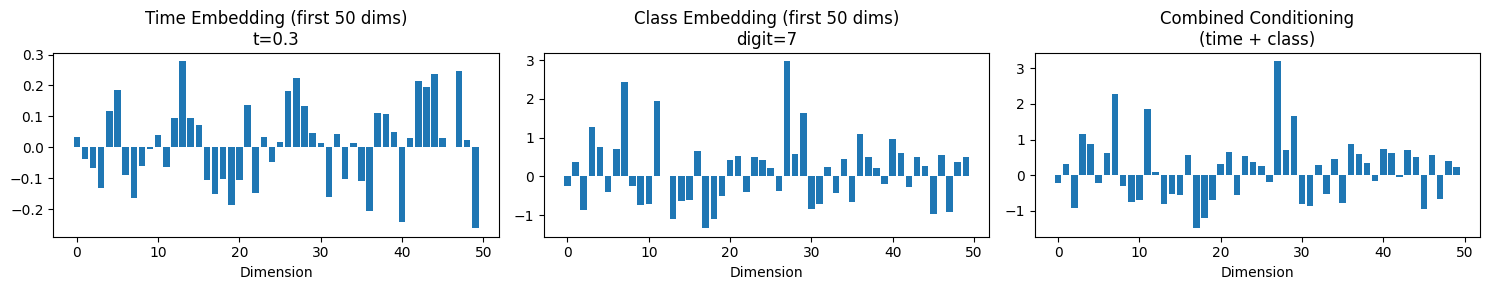

In [3]:
from from_noise_to_images.dit import TimestepEmbedding, ClassEmbedding

# Create embedding modules
embed_dim = 256
cond_dim = embed_dim * 4  # 1024

time_embed = TimestepEmbedding(embed_dim, cond_dim)
class_embed = ClassEmbedding(10, cond_dim)

# Sample inputs
t = torch.tensor([0.3])  # Timestep
y = torch.tensor([7])    # Class label (digit 7)

with torch.no_grad():
    time_cond = time_embed(t)
    class_cond = class_embed(y)
    combined = time_cond + class_cond

print("Conditioning Vector Construction:")
print(f"  Time embedding:   {time_cond.shape} → represents t={t.item():.1f}")
print(f"  Class embedding:  {class_cond.shape} → represents digit {y.item()}")
print(f"  Combined:         {combined.shape} → used for adaLN conditioning")

# Visualize the combination
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

axes[0].bar(range(50), time_cond[0, :50].numpy())
axes[0].set_title(f'Time Embedding (first 50 dims)\nt={t.item():.1f}')
axes[0].set_xlabel('Dimension')

axes[1].bar(range(50), class_cond[0, :50].numpy())
axes[1].set_title(f'Class Embedding (first 50 dims)\ndigit={y.item()}')
axes[1].set_xlabel('Dimension')

axes[2].bar(range(50), combined[0, :50].numpy())
axes[2].set_title('Combined Conditioning\n(time + class)')
axes[2].set_xlabel('Dimension')

plt.tight_layout()
plt.show()

## Step 3: Classifier-Free Guidance (CFG)

Here's a problem: simply training with class labels and sampling with class labels often produces "weak" conditioning. The model generates vaguely correct digits, but they don't really "pop."

**Classifier-Free Guidance (CFG)** solves this. It's arguably the most important technique in modern conditional generation.

### The Score Function Perspective

Using Bayes' rule for conditional distributions:

$$\log p(x \mid y) = \log p(y \mid x) + \log p(x) - \log p(y)$$

Taking gradients with respect to $x$:

$$\nabla_x \log p(x \mid y) = \nabla_x \log p(y \mid x) + \nabla_x \log p(x)$$

Rearranging:

$$\underbrace{\nabla_x \log p(x \mid y)}_{\text{conditional score}} = \underbrace{\nabla_x \log p(x)}_{\text{unconditional}} + \underbrace{\nabla_x \log p(y \mid x)}_{\text{"classifier" gradient}}$$

### The CFG Insight: Amplify the Class Signal

CFG amplifies the "classifier gradient" term by a factor $w > 1$:

$$\nabla_x \log p_{\text{CFG}}(x \mid y) = \nabla_x \log p(x) + w \cdot \nabla_x \log p(y \mid x)$$

Since $\nabla_x \log p(y \mid x) = \nabla_x \log p(x \mid y) - \nabla_x \log p(x)$, we get:

$$\nabla_x \log p_{\text{CFG}} = (1 - w) \cdot \nabla_x \log p(x) + w \cdot \nabla_x \log p(x \mid y)$$

### The CFG Formula for Velocity Fields

Translating to velocity fields:

$$\boxed{v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})}$$

Or equivalently:

$$v_{\text{CFG}} = (1 - w) \cdot v_{\text{uncond}} + w \cdot v_{\text{cond}}$$

where:
- $v_{\text{cond}} = v_\theta(x_t, t, y)$: Velocity with class label
- $v_{\text{uncond}} = v_\theta(x_t, t, \emptyset)$: Velocity with null class
- $w$: Guidance scale (typically 3-7)

### Intuitive Understanding

| Term | What It Represents |
|------|-------------------|
| $v_{\text{uncond}}$ | "What does any digit look like at this noise level?" |
| $v_{\text{cond}}$ | "What does digit $y$ look like at this noise level?" |
| $v_{\text{cond}} - v_{\text{uncond}}$ | "What makes this specifically digit $y$?" |
| $w \cdot (\ldots)$ | "Amplify the $y$-specific features" |

### Effect of Guidance Scale

| Scale $w$ | Mathematical Effect | Practical Result |
|-----------|---------------------|------------------|
| $w = 0$ | $v_{\text{CFG}} = v_{\text{uncond}}$ | Pure unconditional |
| $w = 1$ | $v_{\text{CFG}} = v_{\text{cond}}$ | No guidance amplification |
| $w = 3\text{-}5$ | Balanced amplification | Good balance |
| $w > 7$ | Strong amplification | May over-saturate |

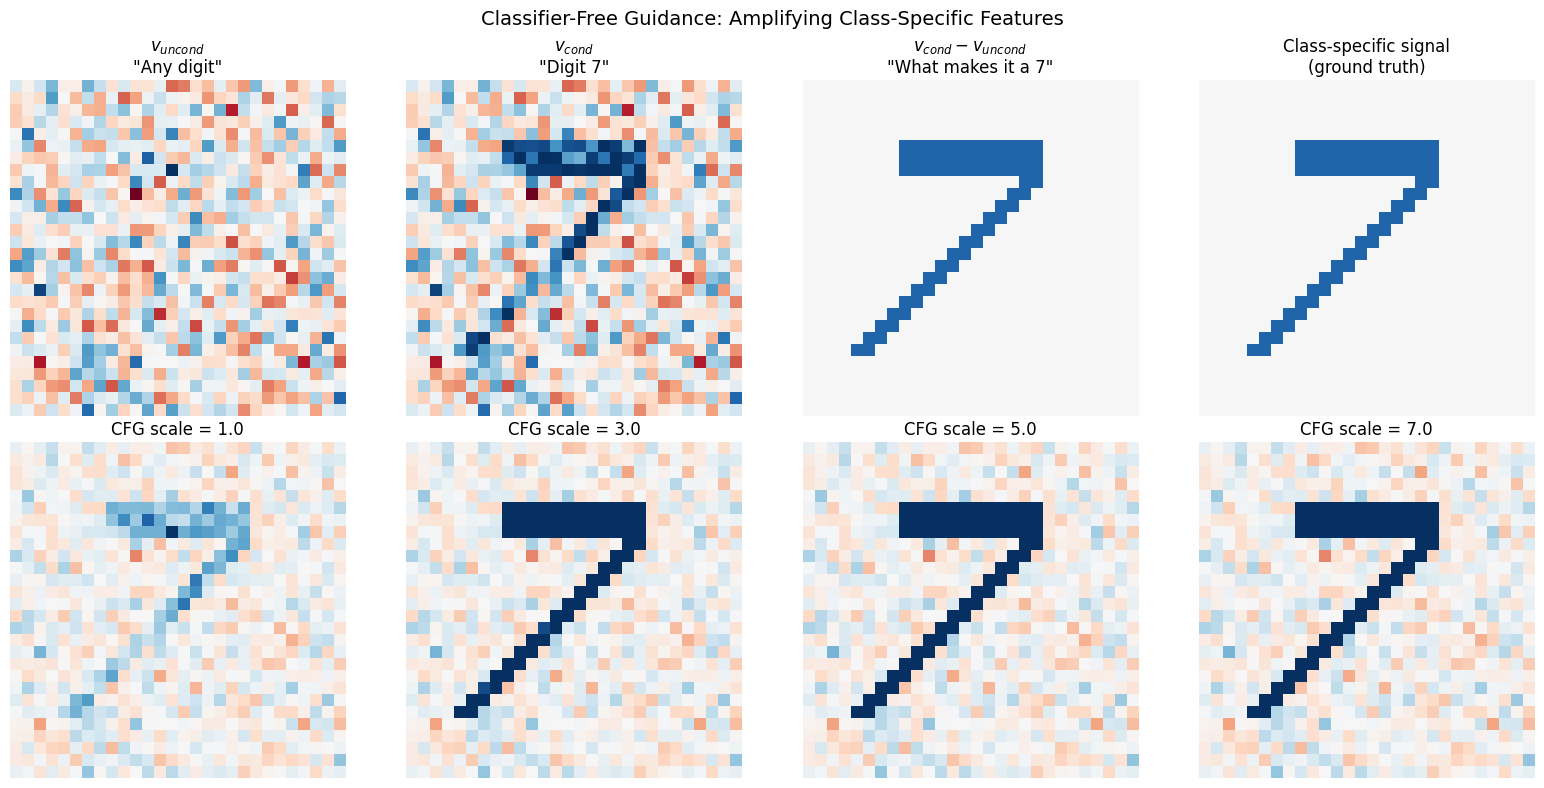


CFG Formula: v_guided = v_uncond + scale × (v_cond - v_uncond)

  • scale=1: Pure conditional (no amplification)
  • scale>1: Amplifies what the class 'adds' to the prediction
  • Higher scale = stronger class adherence, may reduce diversity


In [4]:
def visualize_cfg_concept():
    """
    Visualize how CFG amplifies the conditional signal.
    """
    np.random.seed(42)
    
    # Unconditional: generic velocity field
    v_uncond = np.random.randn(28, 28) * 0.3
    
    # Conditional: adds class-specific structure (e.g., "7" shape)
    v_class_specific = np.zeros((28, 28))
    # Horizontal bar at top (the top of a 7)
    v_class_specific[5:8, 8:20] = 0.8
    # Diagonal stroke
    for i in range(15):
        v_class_specific[8+i, 18-i:20-i] = 0.8
    
    v_cond = v_uncond + v_class_specific
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Row 1: The components
    im = axes[0, 0].imshow(v_uncond, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 0].set_title('$v_{uncond}$\n"Any digit"', fontsize=12)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(v_cond, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 1].set_title('$v_{cond}$\n"Digit 7"', fontsize=12)
    axes[0, 1].axis('off')
    
    difference = v_cond - v_uncond
    axes[0, 2].imshow(difference, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 2].set_title('$v_{cond} - v_{uncond}$\n"What makes it a 7"', fontsize=12)
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(v_class_specific, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 3].set_title('Class-specific signal\n(ground truth)', fontsize=12)
    axes[0, 3].axis('off')
    
    # Row 2: Different CFG scales
    scales = [1.0, 3.0, 5.0, 7.0]
    
    for i, scale in enumerate(scales):
        v_guided = v_uncond + scale * difference
        axes[1, i].imshow(v_guided, cmap='RdBu', vmin=-2, vmax=2)
        axes[1, i].set_title(f'CFG scale = {scale}', fontsize=12)
        axes[1, i].axis('off')
    
    plt.suptitle('Classifier-Free Guidance: Amplifying Class-Specific Features', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nCFG Formula: v_guided = v_uncond + scale × (v_cond - v_uncond)")
    print("\n  • scale=1: Pure conditional (no amplification)")
    print("  • scale>1: Amplifies what the class 'adds' to the prediction")
    print("  • Higher scale = stronger class adherence, may reduce diversity")

visualize_cfg_concept()

## Step 4: Label Dropout - Training for CFG

For CFG to work at inference, we run the model **twice**: once conditional ($v_{\text{cond}}$) and once unconditional ($v_{\text{uncond}}$). But how does a single model learn both behaviors?

### The Solution: Probabilistic Label Dropout

During training, we **randomly drop the class label** with probability $p_{\text{drop}}$:

$$y_{\text{train}} = \begin{cases}
y & \text{with probability } 1 - p_{\text{drop}} \\
\emptyset & \text{with probability } p_{\text{drop}}
\end{cases}$$

Typically $p_{\text{drop}} = 0.1$ (10%).

### What the Model Learns

| Training Mode | Fraction | What the Model Learns |
|---------------|----------|-----------------------|
| Conditional | 90% | $v_\theta(x_t, t, y) \approx \mathbb{E}[v \mid x_t, t, y]$ |
| Unconditional | 10% | $v_\theta(x_t, t, \emptyset) \approx \mathbb{E}[v \mid x_t, t]$ |

The **same model** learns both the conditional and marginal velocity fields!

### The Null Embedding

When the label is dropped, we use a learned **null embedding** $e_\emptyset$:

$$c_{\text{uncond}} = h_t + e_\emptyset$$

rather than just zeroing out the class signal. This lets the model learn a proper representation for "no class specified."

### Why 10% Dropout?

| Dropout Rate | Issue |
|--------------|-------|
| Too low (1%) | Model rarely sees unconditional → poor $v_{\text{uncond}}$ |
| Too high (50%) | Model sees fewer conditional → weaker $v_{\text{cond}}$ |
| 10% | Empirically good balance |

In [5]:
def visualize_label_dropout():
    """
    Show how label dropout works during training.
    """
    np.random.seed(42)
    batch_size = 20
    drop_prob = 0.1
    
    # Simulate original labels
    original_labels = np.random.randint(0, 10, batch_size)
    
    # Simulate dropout
    drop_mask = np.random.rand(batch_size) < drop_prob
    labels_after_dropout = original_labels.copy()
    labels_after_dropout[drop_mask] = 10  # Null class
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 5))
    
    # Original labels
    colors = plt.cm.tab10(original_labels / 10)
    bars = axes[0].bar(range(batch_size), original_labels + 0.5, color=colors, edgecolor='black')
    axes[0].set_ylabel('Class Label')
    axes[0].set_title('Original Labels', fontsize=12)
    axes[0].set_ylim(0, 11)
    axes[0].set_yticks(range(11))
    axes[0].set_yticklabels([str(i) for i in range(10)] + ['null'])
    axes[0].axhline(y=10, color='gray', linestyle='--', alpha=0.5)
    
    # After dropout
    colors_after = []
    for i, (orig, after) in enumerate(zip(original_labels, labels_after_dropout)):
        if after == 10:  # Dropped
            colors_after.append('lightgray')
        else:
            colors_after.append(plt.cm.tab10(orig / 10))
    
    bars = axes[1].bar(range(batch_size), labels_after_dropout + 0.5, color=colors_after, edgecolor='black')
    # Highlight dropped samples
    for i, dropped in enumerate(drop_mask):
        if dropped:
            axes[1].annotate('DROPPED', (i, 10.5), ha='center', fontsize=8, color='red')
    
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Class Label')
    axes[1].set_title(f'After {drop_prob*100:.0f}% Label Dropout (gray = null class)', fontsize=12)
    axes[1].set_ylim(0, 12)
    axes[1].set_yticks(range(11))
    axes[1].set_yticklabels([str(i) for i in range(10)] + ['null'])
    axes[1].axhline(y=10, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nLabel Dropout Statistics:")
    print(f"  • Total samples: {batch_size}")
    print(f"  • Dropped: {drop_mask.sum()} ({drop_mask.mean()*100:.0f}%)")
    print(f"  • Kept: {(~drop_mask).sum()} ({(~drop_mask).mean()*100:.0f}%)")

visualize_label_dropout()


Label Dropout Statistics:
  • Total samples: 20
  • Dropped: 2 (10%)
  • Kept: 18 (90%)


## Step 5: The Conditional DiT Architecture

The changes from the unconditional DiT are minimal but powerful.

### Forward Pass Comparison

**Before (Unconditional):**
$$v_\theta(x, t) = \text{DiT}(x, \text{TimeEmbed}(t))$$

**After (Conditional):**
$$v_\theta(x, t, y) = \text{ConditionalDiT}(x, \text{TimeEmbed}(t) + e(y))$$

### Architecture Summary

| Component | Equation | Shape |
|-----------|----------|-------|
| Time embedding | $h_t = \text{TimeEmbed}(t)$ | $\mathbb{R}^D$ |
| Class embedding | $h_y = e(y) = W_e[y]$ | $\mathbb{R}^D$ |
| Combined | $c = h_t + h_y$ | $\mathbb{R}^D$ |
| adaLN | $\gamma, \beta = \text{Linear}(c)$ | $\mathbb{R}^{d_{\text{model}}}$ each |

### Additional Parameters

The only new parameters are the class embeddings:

$$\Delta_{\text{params}} = (K + 1) \times D = 11 \times 1024 = 11,264$$

That's it - about 0.1% of the model!

In [6]:
from from_noise_to_images.dit import ConditionalDiT

# Create the conditional DiT model
model = ConditionalDiT(
    num_classes=10,     # 10 digit classes
    img_size=28,        # MNIST image size
    patch_size=4,       # 4×4 patches → 7×7 = 49 patches
    in_channels=1,      # Grayscale
    embed_dim=256,      # Embedding dimension
    depth=6,            # Number of transformer blocks
    num_heads=8,        # Attention heads
    mlp_ratio=4.0,      # MLP expansion
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"ConditionalDiT Parameters: {num_params:,}")

# Compare to unconditional DiT
from from_noise_to_images.dit import DiT
uncond_model = DiT()
uncond_params = sum(p.numel() for p in uncond_model.parameters() if p.requires_grad)
print(f"Unconditional DiT Parameters: {uncond_params:,}")
print(f"Difference: {num_params - uncond_params:,} (the class embeddings)")

# Test forward pass with different inputs
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)
test_y = torch.randint(0, 10, (4,), device=device)

print("\n--- Testing Forward Pass ---")

# With class labels
with torch.no_grad():
    out_cond = model(test_x, test_t, test_y)
print(f"With class labels:    input {test_x.shape} → output {out_cond.shape}")

# Without class labels (unconditional)
with torch.no_grad():
    out_uncond = model(test_x, test_t, y=None)
print(f"Without class labels: input {test_x.shape} → output {out_uncond.shape}")

print("\nModel handles both conditional and unconditional forward passes!")

ConditionalDiT Parameters: 12,363,024


Unconditional DiT Parameters: 12,351,760
Difference: 11,264 (the class embeddings)

--- Testing Forward Pass ---


With class labels:    input torch.Size([4, 1, 28, 28]) → output torch.Size([4, 1, 28, 28])
Without class labels: input torch.Size([4, 1, 28, 28]) → output torch.Size([4, 1, 28, 28])

Model handles both conditional and unconditional forward passes!


## Step 6: Training with Label Dropout

The training loop is nearly identical to before, with one key addition: label dropout.

### Training Algorithm

For each training sample $(x_0, y)$ where $x_0$ is an image and $y$ is its class:

1. **Sample noise and time**: $x_1 \sim \mathcal{N}(0, I)$, $t \sim \text{Uniform}(0, 1)$
2. **Interpolate**: $x_t = (1-t) x_0 + t x_1$
3. **Apply label dropout**:
$$y_{\text{train}} = \begin{cases} y & \text{w.p. } 0.9 \\ \emptyset & \text{w.p. } 0.1 \end{cases}$$
4. **Compute loss**: $\mathcal{L} = \| v_\theta(x_t, t, y_{\text{train}}) - (x_1 - x_0) \|^2$
5. **Backpropagate and update**

### Pseudocode

```python
for x_0, y in dataloader:
    x_1 = torch.randn_like(x_0)           # Sample noise
    t = torch.rand(batch_size)             # Sample timesteps
    x_t = (1-t)*x_0 + t*x_1                # Interpolate
    
    # Label dropout: replace 10% of labels with null class
    drop_mask = torch.rand(batch_size) < 0.1
    y_train = y.clone()
    y_train[drop_mask] = NULL_CLASS
    
    v_pred = model(x_t, t, y_train)        # Predict velocity
    v_true = x_1 - x_0                     # True velocity
    loss = mse_loss(v_pred, v_true)        # MSE loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

In [7]:
# Load MNIST with labels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

# Show sample data
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels: {labels[:10].tolist()}...")

Batch shape: torch.Size([128, 1, 28, 28])
Labels: [6, 4, 1, 4, 1, 3, 1, 4, 7, 8]...


In [8]:
from from_noise_to_images.train import ConditionalTrainer

# Create the conditional trainer
trainer = ConditionalTrainer(
    model=model,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    label_drop_prob=0.1,  # 10% label dropout for CFG
    num_classes=10,
    device=device,
)

print("Training Conditional DiT with CFG label dropout...")
print("(10% of samples trained without class labels)\n")

NUM_EPOCHS = 30
losses = trainer.train(num_epochs=NUM_EPOCHS)

Training Conditional DiT with CFG label dropout...
(10% of samples trained without class labels)

Training on cuda
Model parameters: 12,363,024
CFG label dropout: 10%


Epoch 1/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 1/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=1.9282]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<02:00,  3.88it/s, loss=1.9282]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<02:00,  3.88it/s, loss=1.8907]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<02:00,  3.88it/s, loss=1.8660]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<02:00,  3.88it/s, loss=1.8325]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:40, 11.60it/s, loss=1.8325]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:40, 11.60it/s, loss=1.8043]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:40, 11.60it/s, loss=1.7700]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:40, 11.60it/s, loss=1.7204]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:29, 15.81it/s, loss=1.7204]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:29, 15.81it/s, loss=1.7034]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:29, 15.81it/s, loss=1.6734]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:29, 15.81it/s, loss=1.6534]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 18.29it/s, loss=1.6534]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 18.29it/s, loss=1.6141]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 18.29it/s, loss=1.6032]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 18.29it/s, loss=1.5896]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 19.89it/s, loss=1.5896]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 19.89it/s, loss=1.5448]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 19.89it/s, loss=1.5440]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 19.89it/s, loss=1.5092]

Epoch 1/30:   3%|██                                                          | 16/468 [00:00<00:21, 20.91it/s, loss=1.5092]

Epoch 1/30:   3%|██                                                          | 16/468 [00:00<00:21, 20.91it/s, loss=1.5049]

Epoch 1/30:   3%|██                                                          | 16/468 [00:01<00:21, 20.91it/s, loss=1.4848]

Epoch 1/30:   3%|██                                                          | 16/468 [00:01<00:21, 20.91it/s, loss=1.4596]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:20, 21.56it/s, loss=1.4596]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:20, 21.56it/s, loss=1.4697]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:20, 21.56it/s, loss=1.4532]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:20, 21.56it/s, loss=1.4438]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:20, 22.04it/s, loss=1.4438]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:20, 22.04it/s, loss=1.4409]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:20, 22.04it/s, loss=1.4278]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:20, 22.04it/s, loss=1.4029]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:19, 22.38it/s, loss=1.4029]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:19, 22.38it/s, loss=1.4036]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:19, 22.38it/s, loss=1.4116]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:19, 22.38it/s, loss=1.3916]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:19, 22.60it/s, loss=1.3916]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:19, 22.60it/s, loss=1.3963]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:19, 22.60it/s, loss=1.4015]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:19, 22.60it/s, loss=1.3995]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:19, 22.75it/s, loss=1.3995]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:19, 22.75it/s, loss=1.3826]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:19, 22.75it/s, loss=1.3843]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:19, 22.75it/s, loss=1.3695]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:18, 22.87it/s, loss=1.3695]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:18, 22.87it/s, loss=1.3739]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:18, 22.87it/s, loss=1.3795]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:18, 22.87it/s, loss=1.3672]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:18, 22.90it/s, loss=1.3672]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:18, 22.90it/s, loss=1.3703]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:18, 22.90it/s, loss=1.3706]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:18, 22.90it/s, loss=1.3906]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:01<00:18, 22.94it/s, loss=1.3906]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:02<00:18, 22.94it/s, loss=1.3532]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:02<00:18, 22.94it/s, loss=1.3662]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:02<00:18, 22.94it/s, loss=1.4004]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:18, 22.93it/s, loss=1.4004]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:18, 22.93it/s, loss=1.3685]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:18, 22.93it/s, loss=1.3591]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:18, 22.93it/s, loss=1.3403]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:18, 22.94it/s, loss=1.3403]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:18, 22.94it/s, loss=1.3232]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:18, 22.94it/s, loss=1.2951]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:18, 22.94it/s, loss=1.2848]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:18, 23.00it/s, loss=1.2848]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:18, 23.00it/s, loss=1.2930]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:18, 23.00it/s, loss=1.2870]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:18, 23.00it/s, loss=1.2712]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:18, 23.02it/s, loss=1.2712]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:18, 23.02it/s, loss=1.2913]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:18, 23.02it/s, loss=1.2832]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:18, 23.02it/s, loss=1.3022]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:17, 22.97it/s, loss=1.3022]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:17, 22.97it/s, loss=1.2823]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:17, 22.97it/s, loss=1.2493]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:17, 22.97it/s, loss=1.2498]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:17, 23.00it/s, loss=1.2498]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:17, 23.00it/s, loss=1.2612]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:17, 23.00it/s, loss=1.2478]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:17, 23.00it/s, loss=1.2570]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:17, 23.02it/s, loss=1.2570]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:17, 23.02it/s, loss=1.2528]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:17, 23.02it/s, loss=1.2467]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:03<00:17, 23.02it/s, loss=1.2839]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:03<00:17, 23.00it/s, loss=1.2839]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:03<00:17, 23.00it/s, loss=1.2552]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:03<00:17, 23.00it/s, loss=1.2421]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:03<00:17, 23.00it/s, loss=1.2424]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:03<00:17, 23.00it/s, loss=1.2424]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:03<00:17, 23.00it/s, loss=1.2436]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:03<00:17, 23.00it/s, loss=1.2425]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:03<00:17, 23.00it/s, loss=1.2657]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:17, 23.01it/s, loss=1.2657]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:17, 23.01it/s, loss=1.2616]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:17, 23.01it/s, loss=1.2448]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:17, 23.01it/s, loss=1.2405]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:17, 22.99it/s, loss=1.2405]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:17, 22.99it/s, loss=1.2430]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:17, 22.99it/s, loss=1.2395]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:17, 22.99it/s, loss=1.2454]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:17, 22.98it/s, loss=1.2454]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:17, 22.98it/s, loss=1.2435]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:17, 22.98it/s, loss=1.2663]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:17, 22.98it/s, loss=1.2340]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:16, 22.94it/s, loss=1.2340]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:16, 22.94it/s, loss=1.2517]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:16, 22.94it/s, loss=1.2577]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:16, 22.94it/s, loss=1.2515]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:16, 22.96it/s, loss=1.2515]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:16, 22.96it/s, loss=1.2518]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:16, 22.96it/s, loss=1.2256]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:16, 22.96it/s, loss=1.2351]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:03<00:16, 22.99it/s, loss=1.2351]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:03<00:16, 22.99it/s, loss=1.2349]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:04<00:16, 22.99it/s, loss=1.2412]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:04<00:16, 22.99it/s, loss=1.2430]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:04<00:16, 22.99it/s, loss=1.2430]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:04<00:16, 22.99it/s, loss=1.2418]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:04<00:16, 22.99it/s, loss=1.2275]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:04<00:16, 22.99it/s, loss=1.2372]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:04<00:16, 23.01it/s, loss=1.2372]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:04<00:16, 23.01it/s, loss=1.2228]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:04<00:16, 23.01it/s, loss=1.2294]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:04<00:16, 23.01it/s, loss=1.2223]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:04<00:16, 23.00it/s, loss=1.2223]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:04<00:16, 23.00it/s, loss=1.2269]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:04<00:16, 23.00it/s, loss=1.2094]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:04<00:16, 23.00it/s, loss=1.2125]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:16, 22.99it/s, loss=1.2125]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:16, 22.99it/s, loss=1.2302]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:16, 22.99it/s, loss=1.2195]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:16, 22.99it/s, loss=1.2162]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:15, 23.05it/s, loss=1.2162]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:15, 23.05it/s, loss=1.2137]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:15, 23.05it/s, loss=1.2282]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:15, 23.05it/s, loss=1.2363]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:15, 23.08it/s, loss=1.2363]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:15, 23.08it/s, loss=1.2144]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:15, 23.08it/s, loss=1.2023]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:15, 23.08it/s, loss=1.2118]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:15, 23.09it/s, loss=1.2118]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:15, 23.09it/s, loss=1.2237]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:15, 23.09it/s, loss=1.2085]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:15, 23.09it/s, loss=1.2157]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:04<00:15, 23.08it/s, loss=1.2157]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:04<00:15, 23.08it/s, loss=1.2152]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:05<00:15, 23.08it/s, loss=1.2183]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:05<00:15, 23.08it/s, loss=1.2077]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:05<00:15, 23.01it/s, loss=1.2077]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:05<00:15, 23.01it/s, loss=1.2055]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:05<00:15, 23.01it/s, loss=1.2151]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:05<00:15, 23.01it/s, loss=1.2218]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:05<00:15, 23.02it/s, loss=1.2218]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:05<00:15, 23.02it/s, loss=1.2198]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:05<00:15, 23.02it/s, loss=1.2021]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:05<00:15, 23.02it/s, loss=1.2158]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:05<00:15, 22.98it/s, loss=1.2158]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:05<00:15, 22.98it/s, loss=1.1887]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:05<00:15, 22.98it/s, loss=1.2007]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:05<00:15, 22.98it/s, loss=1.1954]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:05<00:15, 22.97it/s, loss=1.1954]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:05<00:15, 22.97it/s, loss=1.1936]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:05<00:15, 22.97it/s, loss=1.2006]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:05<00:15, 22.97it/s, loss=1.2031]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:15, 22.92it/s, loss=1.2031]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:15, 22.92it/s, loss=1.1928]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:15, 22.92it/s, loss=1.1923]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:15, 22.92it/s, loss=1.2031]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:14, 22.94it/s, loss=1.2031]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:14, 22.94it/s, loss=1.1937]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:14, 22.94it/s, loss=1.1881]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:14, 22.94it/s, loss=1.2021]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:14, 22.98it/s, loss=1.2021]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:14, 22.98it/s, loss=1.1890]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:14, 22.98it/s, loss=1.1907]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:06<00:14, 22.98it/s, loss=1.1875]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:06<00:14, 22.96it/s, loss=1.1875]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:06<00:14, 22.96it/s, loss=1.1931]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:06<00:14, 22.96it/s, loss=1.1783]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:06<00:14, 22.96it/s, loss=1.1687]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:06<00:14, 22.97it/s, loss=1.1687]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:06<00:14, 22.97it/s, loss=1.1699]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:06<00:14, 22.97it/s, loss=1.1843]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:06<00:14, 22.97it/s, loss=1.1724]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:06<00:14, 22.98it/s, loss=1.1724]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:06<00:14, 22.98it/s, loss=1.1573]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:06<00:14, 22.98it/s, loss=1.1939]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:06<00:14, 22.98it/s, loss=1.1683]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:06<00:14, 22.89it/s, loss=1.1683]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:06<00:14, 22.89it/s, loss=1.1725]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:06<00:14, 22.89it/s, loss=1.1592]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:06<00:14, 22.89it/s, loss=1.1549]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:06<00:14, 22.95it/s, loss=1.1549]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:06<00:14, 22.95it/s, loss=1.1476]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:06<00:14, 22.95it/s, loss=1.1449]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:06<00:14, 22.95it/s, loss=1.1458]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:06<00:13, 22.96it/s, loss=1.1458]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:06<00:13, 22.96it/s, loss=1.1617]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:06<00:13, 22.96it/s, loss=1.1308]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:06<00:13, 22.96it/s, loss=1.1430]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:13, 22.99it/s, loss=1.1430]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:13, 22.99it/s, loss=1.1240]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:13, 22.99it/s, loss=1.1238]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:13, 22.99it/s, loss=1.1241]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:06<00:13, 23.02it/s, loss=1.1241]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:06<00:13, 23.02it/s, loss=1.1130]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:07<00:13, 23.02it/s, loss=1.1291]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:07<00:13, 23.02it/s, loss=1.1204]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:07<00:13, 22.99it/s, loss=1.1204]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:07<00:13, 22.99it/s, loss=1.1305]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:07<00:13, 22.99it/s, loss=1.1134]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:07<00:13, 22.99it/s, loss=1.1276]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:07<00:13, 23.03it/s, loss=1.1276]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:07<00:13, 23.03it/s, loss=1.1031]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:07<00:13, 23.03it/s, loss=1.1126]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:07<00:13, 23.03it/s, loss=1.0994]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:07<00:13, 23.03it/s, loss=1.0994]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:07<00:13, 23.03it/s, loss=1.0837]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:07<00:13, 23.03it/s, loss=1.1077]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:07<00:13, 23.03it/s, loss=1.0894]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:07<00:13, 23.01it/s, loss=1.0894]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:07<00:13, 23.01it/s, loss=1.0787]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:07<00:13, 23.01it/s, loss=1.0801]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:07<00:13, 23.01it/s, loss=1.0731]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:07<00:12, 23.02it/s, loss=1.0731]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:07<00:12, 23.02it/s, loss=1.0867]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:07<00:12, 23.02it/s, loss=1.0644]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:07<00:12, 23.02it/s, loss=1.0746]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:07<00:12, 22.98it/s, loss=1.0746]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:07<00:12, 22.98it/s, loss=1.0490]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:07<00:12, 22.98it/s, loss=1.0619]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:07<00:12, 22.98it/s, loss=1.0523]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:07<00:12, 22.97it/s, loss=1.0523]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:07<00:12, 22.97it/s, loss=1.0388]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:07<00:12, 22.97it/s, loss=1.0287]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:07<00:12, 22.97it/s, loss=1.0322]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:07<00:12, 23.03it/s, loss=1.0322]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:08<00:12, 23.03it/s, loss=1.0238]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:08<00:12, 23.03it/s, loss=1.0165]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:08<00:12, 23.03it/s, loss=1.0166]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:08<00:12, 23.01it/s, loss=1.0166]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:08<00:12, 23.01it/s, loss=1.0053]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:08<00:12, 23.01it/s, loss=0.9939]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:08<00:12, 23.01it/s, loss=0.9929]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:08<00:12, 23.02it/s, loss=0.9929]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:08<00:12, 23.02it/s, loss=0.9749]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:08<00:12, 23.02it/s, loss=0.9702]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:08<00:12, 23.02it/s, loss=0.9927]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:08<00:12, 23.03it/s, loss=0.9927]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:08<00:12, 23.03it/s, loss=0.9594]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:08<00:12, 23.03it/s, loss=0.9629]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:08<00:12, 23.03it/s, loss=0.9732]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:08<00:12, 23.04it/s, loss=0.9732]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:08<00:12, 23.04it/s, loss=0.9726]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:08<00:12, 23.04it/s, loss=0.9509]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:08<00:12, 23.04it/s, loss=0.9612]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:08<00:11, 23.06it/s, loss=0.9612]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:08<00:11, 23.06it/s, loss=0.9513]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:08<00:11, 23.06it/s, loss=0.9463]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:08<00:11, 23.06it/s, loss=0.9374]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:08<00:11, 23.06it/s, loss=0.9374]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:08<00:11, 23.06it/s, loss=0.9339]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:08<00:11, 23.06it/s, loss=0.9196]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:08<00:11, 23.06it/s, loss=0.9260]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:08<00:11, 23.02it/s, loss=0.9260]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:08<00:11, 23.02it/s, loss=0.9314]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:08<00:11, 23.02it/s, loss=0.9131]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:08<00:11, 23.02it/s, loss=0.8999]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:08<00:11, 23.04it/s, loss=0.8999]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:09<00:11, 23.04it/s, loss=0.9092]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:09<00:11, 23.04it/s, loss=0.9027]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:09<00:11, 23.04it/s, loss=0.8960]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:09<00:11, 23.04it/s, loss=0.8960]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:09<00:11, 23.04it/s, loss=0.8762]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:09<00:11, 23.04it/s, loss=0.8863]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:09<00:11, 23.04it/s, loss=0.8803]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:09<00:11, 22.96it/s, loss=0.8803]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:09<00:11, 22.96it/s, loss=0.8865]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:09<00:11, 22.96it/s, loss=0.8600]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:09<00:11, 22.96it/s, loss=0.8684]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:09<00:11, 22.99it/s, loss=0.8684]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:09<00:11, 22.99it/s, loss=0.8487]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:09<00:11, 22.99it/s, loss=0.8524]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:09<00:11, 22.99it/s, loss=0.8553]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:09<00:11, 22.98it/s, loss=0.8553]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:09<00:11, 22.98it/s, loss=0.8287]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:09<00:11, 22.98it/s, loss=0.8467]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:09<00:11, 22.98it/s, loss=0.8523]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:09<00:10, 23.00it/s, loss=0.8523]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:09<00:10, 23.00it/s, loss=0.8307]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:09<00:10, 23.00it/s, loss=0.8245]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:09<00:10, 23.00it/s, loss=0.8287]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:09<00:10, 23.01it/s, loss=0.8287]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:09<00:10, 23.01it/s, loss=0.8214]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:09<00:10, 23.01it/s, loss=0.8099]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:09<00:10, 23.01it/s, loss=0.8244]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:09<00:10, 23.02it/s, loss=0.8244]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:09<00:10, 23.02it/s, loss=0.8049]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:09<00:10, 23.02it/s, loss=0.7925]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:10<00:10, 23.02it/s, loss=0.7845]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:10<00:10, 22.99it/s, loss=0.7845]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:10<00:10, 22.99it/s, loss=0.7956]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:10<00:10, 22.99it/s, loss=0.7842]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:10<00:10, 22.99it/s, loss=0.7786]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:10<00:10, 22.98it/s, loss=0.7786]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:10<00:10, 22.98it/s, loss=0.7811]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:10<00:10, 22.98it/s, loss=0.7851]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:10<00:10, 22.98it/s, loss=0.7663]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:10<00:10, 22.99it/s, loss=0.7663]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:10<00:10, 22.99it/s, loss=0.7786]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:10<00:10, 22.99it/s, loss=0.7499]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:10<00:10, 22.99it/s, loss=0.7399]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:10<00:10, 23.01it/s, loss=0.7399]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:10<00:10, 23.01it/s, loss=0.7452]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:10<00:10, 23.01it/s, loss=0.7343]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:10<00:10, 23.01it/s, loss=0.7326]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:10<00:09, 23.01it/s, loss=0.7326]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:10<00:09, 23.01it/s, loss=0.7515]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:10<00:09, 23.01it/s, loss=0.7292]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:10<00:09, 23.01it/s, loss=0.7310]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:10<00:09, 22.97it/s, loss=0.7310]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:10<00:09, 22.97it/s, loss=0.7251]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:10<00:09, 22.97it/s, loss=0.7395]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:10<00:09, 22.97it/s, loss=0.7266]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:10<00:09, 22.99it/s, loss=0.7266]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:10<00:09, 22.99it/s, loss=0.7067]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:10<00:09, 22.99it/s, loss=0.7181]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:10<00:09, 22.99it/s, loss=0.6952]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:10<00:09, 23.01it/s, loss=0.6952]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:11<00:09, 23.01it/s, loss=0.7079]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:11<00:09, 23.01it/s, loss=0.6896]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:11<00:09, 23.01it/s, loss=0.6703]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:11<00:09, 22.92it/s, loss=0.6703]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:11<00:09, 22.92it/s, loss=0.6840]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:11<00:09, 22.92it/s, loss=0.6754]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:11<00:09, 22.92it/s, loss=0.6927]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:11<00:09, 22.91it/s, loss=0.6927]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:11<00:09, 22.91it/s, loss=0.6640]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:11<00:09, 22.91it/s, loss=0.6881]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:11<00:09, 22.91it/s, loss=0.6528]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:11<00:09, 22.99it/s, loss=0.6528]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:11<00:09, 22.99it/s, loss=0.6600]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:11<00:09, 22.99it/s, loss=0.6611]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:11<00:09, 22.99it/s, loss=0.6594]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:11<00:09, 22.99it/s, loss=0.6594]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:11<00:09, 22.99it/s, loss=0.6654]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:11<00:09, 22.99it/s, loss=0.6542]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:11<00:09, 22.99it/s, loss=0.6414]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:11<00:08, 23.04it/s, loss=0.6414]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:11<00:08, 23.04it/s, loss=0.6524]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:11<00:08, 23.04it/s, loss=0.6565]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:11<00:08, 23.04it/s, loss=0.6733]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:11<00:08, 23.06it/s, loss=0.6733]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:11<00:08, 23.06it/s, loss=0.6557]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:11<00:08, 23.06it/s, loss=0.6432]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:11<00:08, 23.06it/s, loss=0.6223]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:11<00:08, 23.07it/s, loss=0.6223]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:11<00:08, 23.07it/s, loss=0.6351]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:11<00:08, 23.07it/s, loss=0.6485]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:12<00:08, 23.07it/s, loss=0.6323]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:12<00:08, 22.96it/s, loss=0.6323]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:12<00:08, 22.96it/s, loss=0.6143]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:12<00:08, 22.96it/s, loss=0.6095]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:12<00:08, 22.96it/s, loss=0.6103]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:12<00:08, 22.95it/s, loss=0.6103]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:12<00:08, 22.95it/s, loss=0.6050]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:12<00:08, 22.95it/s, loss=0.6088]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:12<00:08, 22.95it/s, loss=0.5885]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:12<00:08, 22.95it/s, loss=0.5885]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:12<00:08, 22.95it/s, loss=0.6051]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:12<00:08, 22.95it/s, loss=0.5859]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:12<00:08, 22.95it/s, loss=0.5846]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:12<00:08, 22.99it/s, loss=0.5846]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:12<00:08, 22.99it/s, loss=0.5892]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:12<00:08, 22.99it/s, loss=0.5651]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:12<00:08, 22.99it/s, loss=0.5813]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:12<00:08, 22.99it/s, loss=0.5813]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:12<00:08, 22.99it/s, loss=0.5998]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:12<00:08, 22.99it/s, loss=0.5658]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:12<00:08, 22.99it/s, loss=0.5765]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:12<00:07, 23.02it/s, loss=0.5765]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:12<00:07, 23.02it/s, loss=0.5842]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:12<00:07, 23.02it/s, loss=0.5508]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:12<00:07, 23.02it/s, loss=0.5493]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:12<00:07, 22.99it/s, loss=0.5493]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:12<00:07, 22.99it/s, loss=0.5402]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:12<00:07, 22.99it/s, loss=0.5597]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:12<00:07, 22.99it/s, loss=0.5595]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:12<00:07, 22.97it/s, loss=0.5595]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:12<00:07, 22.97it/s, loss=0.5411]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:13<00:07, 22.97it/s, loss=0.5360]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:13<00:07, 22.97it/s, loss=0.5434]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:13<00:07, 22.99it/s, loss=0.5434]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:13<00:07, 22.99it/s, loss=0.5517]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:13<00:07, 22.99it/s, loss=0.5664]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:13<00:07, 22.99it/s, loss=0.5429]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:13<00:07, 23.05it/s, loss=0.5429]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:13<00:07, 23.05it/s, loss=0.5371]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:13<00:07, 23.05it/s, loss=0.5522]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:13<00:07, 23.05it/s, loss=0.5196]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:13<00:07, 23.08it/s, loss=0.5196]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:13<00:07, 23.08it/s, loss=0.5243]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:13<00:07, 23.08it/s, loss=0.5146]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:13<00:07, 23.08it/s, loss=0.5342]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:13<00:07, 23.10it/s, loss=0.5342]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:13<00:07, 23.10it/s, loss=0.5206]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:13<00:07, 23.10it/s, loss=0.5259]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:13<00:07, 23.10it/s, loss=0.5210]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:13<00:06, 23.10it/s, loss=0.5210]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:13<00:06, 23.10it/s, loss=0.5271]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:13<00:06, 23.10it/s, loss=0.5081]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:13<00:06, 23.10it/s, loss=0.4974]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:13<00:06, 23.06it/s, loss=0.4974]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:13<00:06, 23.06it/s, loss=0.5172]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:13<00:06, 23.06it/s, loss=0.5148]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:13<00:06, 23.06it/s, loss=0.5030]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:13<00:06, 23.04it/s, loss=0.5030]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:13<00:06, 23.04it/s, loss=0.5022]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:13<00:06, 23.04it/s, loss=0.5007]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:13<00:06, 23.04it/s, loss=0.4940]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:13<00:06, 23.06it/s, loss=0.4940]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:13<00:06, 23.06it/s, loss=0.4956]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:14<00:06, 23.06it/s, loss=0.5248]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:14<00:06, 23.06it/s, loss=0.4770]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:14<00:06, 23.08it/s, loss=0.4770]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:14<00:06, 23.08it/s, loss=0.4888]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:14<00:06, 23.08it/s, loss=0.4738]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:14<00:06, 23.08it/s, loss=0.4914]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:14<00:06, 23.08it/s, loss=0.4914]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:14<00:06, 23.08it/s, loss=0.4902]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:14<00:06, 23.08it/s, loss=0.4826]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:14<00:06, 23.08it/s, loss=0.4955]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:14<00:06, 23.07it/s, loss=0.4955]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:14<00:06, 23.07it/s, loss=0.4870]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:14<00:06, 23.07it/s, loss=0.4856]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:14<00:06, 23.07it/s, loss=0.4600]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:14<00:06, 23.05it/s, loss=0.4600]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:14<00:06, 23.05it/s, loss=0.4659]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:14<00:06, 23.05it/s, loss=0.4643]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:14<00:06, 23.05it/s, loss=0.4923]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:14<00:05, 23.03it/s, loss=0.4923]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:14<00:05, 23.03it/s, loss=0.4567]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:14<00:05, 23.03it/s, loss=0.4744]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:14<00:05, 23.03it/s, loss=0.4689]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:14<00:05, 23.06it/s, loss=0.4689]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:14<00:05, 23.06it/s, loss=0.4597]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:14<00:05, 23.06it/s, loss=0.4470]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:14<00:05, 23.06it/s, loss=0.4693]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:14<00:05, 23.07it/s, loss=0.4693]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:14<00:05, 23.07it/s, loss=0.4753]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:14<00:05, 23.07it/s, loss=0.4588]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:14<00:05, 23.07it/s, loss=0.4646]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:14<00:05, 23.03it/s, loss=0.4646]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:15<00:05, 23.03it/s, loss=0.4484]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:15<00:05, 23.03it/s, loss=0.4851]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:15<00:05, 23.03it/s, loss=0.4547]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:15<00:05, 23.02it/s, loss=0.4547]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:15<00:05, 23.02it/s, loss=0.4410]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:15<00:05, 23.02it/s, loss=0.4689]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:15<00:05, 23.02it/s, loss=0.4577]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:15<00:05, 23.05it/s, loss=0.4577]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:15<00:05, 23.05it/s, loss=0.4656]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:15<00:05, 23.05it/s, loss=0.4462]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:15<00:05, 23.05it/s, loss=0.4452]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:15<00:05, 23.05it/s, loss=0.4452]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:15<00:05, 23.05it/s, loss=0.4549]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:15<00:05, 23.05it/s, loss=0.4603]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:15<00:05, 23.05it/s, loss=0.4294]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:15<00:05, 23.06it/s, loss=0.4294]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:15<00:05, 23.06it/s, loss=0.4499]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:15<00:05, 23.06it/s, loss=0.4548]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:15<00:05, 23.06it/s, loss=0.4423]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:15<00:04, 23.07it/s, loss=0.4423]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:15<00:04, 23.07it/s, loss=0.4495]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:15<00:04, 23.07it/s, loss=0.4429]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:15<00:04, 23.07it/s, loss=0.4425]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:15<00:04, 23.07it/s, loss=0.4425]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:15<00:04, 23.07it/s, loss=0.4489]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:15<00:04, 23.07it/s, loss=0.4430]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:15<00:04, 23.07it/s, loss=0.4311]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:15<00:04, 23.08it/s, loss=0.4311]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:15<00:04, 23.08it/s, loss=0.4434]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:15<00:04, 23.08it/s, loss=0.4255]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:16<00:04, 23.08it/s, loss=0.4471]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:16<00:04, 23.06it/s, loss=0.4471]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:16<00:04, 23.06it/s, loss=0.4424]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:16<00:04, 23.06it/s, loss=0.4247]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:16<00:04, 23.06it/s, loss=0.4264]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:16<00:04, 23.05it/s, loss=0.4264]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:16<00:04, 23.05it/s, loss=0.4361]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:16<00:04, 23.05it/s, loss=0.4378]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:16<00:04, 23.05it/s, loss=0.4378]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:16<00:04, 23.05it/s, loss=0.4378]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:16<00:04, 23.05it/s, loss=0.4238]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:16<00:04, 23.05it/s, loss=0.4340]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:16<00:04, 23.05it/s, loss=0.4298]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:16<00:04, 23.06it/s, loss=0.4298]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:16<00:04, 23.06it/s, loss=0.4289]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:16<00:04, 23.06it/s, loss=0.4227]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:16<00:04, 23.06it/s, loss=0.4040]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:16<00:03, 23.08it/s, loss=0.4040]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:16<00:03, 23.08it/s, loss=0.4252]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:16<00:03, 23.08it/s, loss=0.4157]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:16<00:03, 23.08it/s, loss=0.4198]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:16<00:03, 23.10it/s, loss=0.4198]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:16<00:03, 23.10it/s, loss=0.4055]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:16<00:03, 23.10it/s, loss=0.4146]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:16<00:03, 23.10it/s, loss=0.4391]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:16<00:03, 23.09it/s, loss=0.4391]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:16<00:03, 23.09it/s, loss=0.4117]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:16<00:03, 23.09it/s, loss=0.4060]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:16<00:03, 23.09it/s, loss=0.4079]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:16<00:03, 23.12it/s, loss=0.4079]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:16<00:03, 23.12it/s, loss=0.4065]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:17<00:03, 23.12it/s, loss=0.4091]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:17<00:03, 23.12it/s, loss=0.4050]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:17<00:03, 23.13it/s, loss=0.4050]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:17<00:03, 23.13it/s, loss=0.4171]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:17<00:03, 23.13it/s, loss=0.4070]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:17<00:03, 23.13it/s, loss=0.4263]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:17<00:03, 23.13it/s, loss=0.4263]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:17<00:03, 23.13it/s, loss=0.3956]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:17<00:03, 23.13it/s, loss=0.4171]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:17<00:03, 23.13it/s, loss=0.4000]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:17<00:03, 23.12it/s, loss=0.4000]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:17<00:03, 23.12it/s, loss=0.4278]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:17<00:03, 23.12it/s, loss=0.4193]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:17<00:03, 23.12it/s, loss=0.4134]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:17<00:03, 23.08it/s, loss=0.4134]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:17<00:03, 23.08it/s, loss=0.4129]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:17<00:03, 23.08it/s, loss=0.4285]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:17<00:03, 23.08it/s, loss=0.4019]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:17<00:02, 23.04it/s, loss=0.4019]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:17<00:02, 23.04it/s, loss=0.3993]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:17<00:02, 23.04it/s, loss=0.4047]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:17<00:02, 23.04it/s, loss=0.4034]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:17<00:02, 23.01it/s, loss=0.4034]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:17<00:02, 23.01it/s, loss=0.4174]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:17<00:02, 23.01it/s, loss=0.4026]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:17<00:02, 23.01it/s, loss=0.3967]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:17<00:02, 22.98it/s, loss=0.3967]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:17<00:02, 22.98it/s, loss=0.3929]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:17<00:02, 22.98it/s, loss=0.4041]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:17<00:02, 22.98it/s, loss=0.4134]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:17<00:02, 23.03it/s, loss=0.4134]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:18<00:02, 23.03it/s, loss=0.3935]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:18<00:02, 23.03it/s, loss=0.3966]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:18<00:02, 23.03it/s, loss=0.3931]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:18<00:02, 23.08it/s, loss=0.3931]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:18<00:02, 23.08it/s, loss=0.4067]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:18<00:02, 23.08it/s, loss=0.3992]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:18<00:02, 23.08it/s, loss=0.4195]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:18<00:02, 23.06it/s, loss=0.4195]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:18<00:02, 23.06it/s, loss=0.4015]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:18<00:02, 23.06it/s, loss=0.3939]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:18<00:02, 23.06it/s, loss=0.3902]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:18<00:02, 22.91it/s, loss=0.3902]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:18<00:02, 22.91it/s, loss=0.4086]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:18<00:02, 22.91it/s, loss=0.3819]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:18<00:02, 22.91it/s, loss=0.4045]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:18<00:02, 22.92it/s, loss=0.4045]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:18<00:02, 22.92it/s, loss=0.3963]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:18<00:02, 22.92it/s, loss=0.3967]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:18<00:02, 22.92it/s, loss=0.4104]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:18<00:01, 22.98it/s, loss=0.4104]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:18<00:01, 22.98it/s, loss=0.4088]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:18<00:01, 22.98it/s, loss=0.4196]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:18<00:01, 22.98it/s, loss=0.3889]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:18<00:01, 22.96it/s, loss=0.3889]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:18<00:01, 22.96it/s, loss=0.4035]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:18<00:01, 22.96it/s, loss=0.3822]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:18<00:01, 22.96it/s, loss=0.3694]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:18<00:01, 23.00it/s, loss=0.3694]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:18<00:01, 23.00it/s, loss=0.3836]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:18<00:01, 23.00it/s, loss=0.3724]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:19<00:01, 23.00it/s, loss=0.3922]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:19<00:01, 23.01it/s, loss=0.3922]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:19<00:01, 23.01it/s, loss=0.3782]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:19<00:01, 23.01it/s, loss=0.3806]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:19<00:01, 23.01it/s, loss=0.3782]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:19<00:01, 23.03it/s, loss=0.3782]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:19<00:01, 23.03it/s, loss=0.3853]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:19<00:01, 23.03it/s, loss=0.3827]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:19<00:01, 23.03it/s, loss=0.3594]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:19<00:01, 23.07it/s, loss=0.3594]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:19<00:01, 23.07it/s, loss=0.3764]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:19<00:01, 23.07it/s, loss=0.3973]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:19<00:01, 23.07it/s, loss=0.3767]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:19<00:01, 23.09it/s, loss=0.3767]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:19<00:01, 23.09it/s, loss=0.3695]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:19<00:01, 23.09it/s, loss=0.3979]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:19<00:01, 23.09it/s, loss=0.3715]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:19<00:00, 23.10it/s, loss=0.3715]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:19<00:00, 23.10it/s, loss=0.3820]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:19<00:00, 23.10it/s, loss=0.3584]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:19<00:00, 23.10it/s, loss=0.3872]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:19<00:00, 23.13it/s, loss=0.3872]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:19<00:00, 23.13it/s, loss=0.3798]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:19<00:00, 23.13it/s, loss=0.3776]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:19<00:00, 23.13it/s, loss=0.3843]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:19<00:00, 23.13it/s, loss=0.3843]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:19<00:00, 23.13it/s, loss=0.3955]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:19<00:00, 23.13it/s, loss=0.3834]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:19<00:00, 23.13it/s, loss=0.3810]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:19<00:00, 23.12it/s, loss=0.3810]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:19<00:00, 23.12it/s, loss=0.3632]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:20<00:00, 23.12it/s, loss=0.3734]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:20<00:00, 23.12it/s, loss=0.3806]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:20<00:00, 23.13it/s, loss=0.3806]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:20<00:00, 23.13it/s, loss=0.3609]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:20<00:00, 23.13it/s, loss=0.3850]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:20<00:00, 23.13it/s, loss=0.3781]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:20<00:00, 23.10it/s, loss=0.3781]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:20<00:00, 23.10it/s, loss=0.3784]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:20<00:00, 23.10it/s, loss=0.3555]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:20<00:00, 23.10it/s, loss=0.3679]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:20<00:00, 23.10it/s, loss=0.3679]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:20<00:00, 23.10it/s, loss=0.3637]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:20<00:00, 23.10it/s, loss=0.3769]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:20<00:00, 23.10it/s, loss=0.3680]

Epoch 1/30: 100%|██████████████████████████████████████████████████████████▋| 466/468 [00:20<00:00, 23.09it/s, loss=0.3680]

Epoch 1/30: 100%|██████████████████████████████████████████████████████████▋| 466/468 [00:20<00:00, 23.09it/s, loss=0.3549]

Epoch 1/30: 100%|██████████████████████████████████████████████████████████▋| 466/468 [00:20<00:00, 23.09it/s, loss=0.3708]

Epoch 1/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.78it/s, loss=0.3708]

Epoch 1: avg_loss = 0.8345


Epoch 2/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 2/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3659]

Epoch 2/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3760]

Epoch 2/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3598]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.71it/s, loss=0.3598]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.71it/s, loss=0.3670]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.71it/s, loss=0.3664]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.71it/s, loss=0.3596]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.94it/s, loss=0.3596]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.94it/s, loss=0.3523]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.94it/s, loss=0.3588]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.94it/s, loss=0.3918]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.03it/s, loss=0.3918]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.03it/s, loss=0.3690]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.03it/s, loss=0.3850]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.03it/s, loss=0.3777]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.99it/s, loss=0.3777]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.99it/s, loss=0.3688]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.99it/s, loss=0.3657]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.99it/s, loss=0.3638]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.03it/s, loss=0.3638]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.03it/s, loss=0.3885]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.03it/s, loss=0.3799]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.03it/s, loss=0.3771]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.05it/s, loss=0.3771]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.05it/s, loss=0.3742]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.05it/s, loss=0.3565]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.05it/s, loss=0.3649]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.08it/s, loss=0.3649]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.08it/s, loss=0.3596]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.08it/s, loss=0.3672]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.08it/s, loss=0.3512]

Epoch 2/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.06it/s, loss=0.3512]

Epoch 2/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.06it/s, loss=0.3692]

Epoch 2/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.06it/s, loss=0.3811]

Epoch 2/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.06it/s, loss=0.3504]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.07it/s, loss=0.3504]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.07it/s, loss=0.3809]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.07it/s, loss=0.3942]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.07it/s, loss=0.3693]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 23.03it/s, loss=0.3693]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 23.03it/s, loss=0.3687]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 23.03it/s, loss=0.3719]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 23.03it/s, loss=0.3686]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.05it/s, loss=0.3686]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.05it/s, loss=0.3696]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.05it/s, loss=0.3744]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.05it/s, loss=0.3614]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.08it/s, loss=0.3614]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.08it/s, loss=0.3682]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.08it/s, loss=0.3816]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.08it/s, loss=0.3738]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.06it/s, loss=0.3738]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.06it/s, loss=0.3774]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.06it/s, loss=0.3583]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.06it/s, loss=0.3594]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.09it/s, loss=0.3594]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.09it/s, loss=0.3558]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.09it/s, loss=0.3759]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.09it/s, loss=0.3613]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.08it/s, loss=0.3613]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.08it/s, loss=0.3546]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.08it/s, loss=0.3652]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.08it/s, loss=0.3559]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.3559]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.3560]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.3670]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.3733]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.07it/s, loss=0.3733]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.07it/s, loss=0.3633]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.07it/s, loss=0.3478]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.07it/s, loss=0.3780]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.07it/s, loss=0.3780]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.07it/s, loss=0.3575]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.07it/s, loss=0.3693]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.07it/s, loss=0.3646]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.02it/s, loss=0.3646]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.02it/s, loss=0.3604]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.02it/s, loss=0.3813]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.02it/s, loss=0.3552]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.99it/s, loss=0.3552]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.99it/s, loss=0.3582]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.99it/s, loss=0.3486]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.99it/s, loss=0.3528]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.02it/s, loss=0.3528]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.02it/s, loss=0.3587]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.02it/s, loss=0.3656]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.02it/s, loss=0.3468]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.98it/s, loss=0.3468]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.98it/s, loss=0.3549]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.98it/s, loss=0.3679]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.98it/s, loss=0.3596]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:02<00:17, 23.03it/s, loss=0.3596]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.03it/s, loss=0.3605]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.03it/s, loss=0.3490]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.03it/s, loss=0.3518]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.95it/s, loss=0.3518]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.95it/s, loss=0.3591]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.95it/s, loss=0.3549]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.95it/s, loss=0.3791]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.93it/s, loss=0.3791]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.93it/s, loss=0.3586]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.93it/s, loss=0.3555]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.93it/s, loss=0.3587]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 22.94it/s, loss=0.3587]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 22.94it/s, loss=0.3622]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 22.94it/s, loss=0.3741]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 22.94it/s, loss=0.3615]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.02it/s, loss=0.3615]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.02it/s, loss=0.3585]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.02it/s, loss=0.3571]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.02it/s, loss=0.3543]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.04it/s, loss=0.3543]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.04it/s, loss=0.3674]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.04it/s, loss=0.3378]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.04it/s, loss=0.3445]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.00it/s, loss=0.3445]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.00it/s, loss=0.3531]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.00it/s, loss=0.3678]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.00it/s, loss=0.3591]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.05it/s, loss=0.3591]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.05it/s, loss=0.3598]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.05it/s, loss=0.3535]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.05it/s, loss=0.3412]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.05it/s, loss=0.3412]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.05it/s, loss=0.3497]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.05it/s, loss=0.3482]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.05it/s, loss=0.3566]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.07it/s, loss=0.3566]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.07it/s, loss=0.3502]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.07it/s, loss=0.3536]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.07it/s, loss=0.3599]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.10it/s, loss=0.3599]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.10it/s, loss=0.3693]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.10it/s, loss=0.3443]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.10it/s, loss=0.3642]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.06it/s, loss=0.3642]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.06it/s, loss=0.3577]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.06it/s, loss=0.3537]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.06it/s, loss=0.3503]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.3503]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.3420]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.3500]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.3599]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.08it/s, loss=0.3599]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.08it/s, loss=0.3577]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.08it/s, loss=0.3694]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.08it/s, loss=0.3464]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.03it/s, loss=0.3464]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.03it/s, loss=0.3534]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.03it/s, loss=0.3510]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.03it/s, loss=0.3413]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.03it/s, loss=0.3413]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.03it/s, loss=0.3457]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.03it/s, loss=0.3325]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.03it/s, loss=0.3543]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.03it/s, loss=0.3543]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.03it/s, loss=0.3533]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.03it/s, loss=0.3676]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.03it/s, loss=0.3419]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.01it/s, loss=0.3419]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.01it/s, loss=0.3354]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.01it/s, loss=0.3455]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.01it/s, loss=0.3594]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.3594]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.3491]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.3401]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.3296]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.00it/s, loss=0.3296]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.00it/s, loss=0.3431]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.00it/s, loss=0.3604]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.00it/s, loss=0.3368]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.3368]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.3541]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.3467]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.3456]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.96it/s, loss=0.3456]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.96it/s, loss=0.3358]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.96it/s, loss=0.3461]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.96it/s, loss=0.3538]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.02it/s, loss=0.3538]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.02it/s, loss=0.3513]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.02it/s, loss=0.3379]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.02it/s, loss=0.3472]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.05it/s, loss=0.3472]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.05it/s, loss=0.3447]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.05it/s, loss=0.3260]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.05it/s, loss=0.3510]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.03it/s, loss=0.3510]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.03it/s, loss=0.3585]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.03it/s, loss=0.3564]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.03it/s, loss=0.3291]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.00it/s, loss=0.3291]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.00it/s, loss=0.3456]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.00it/s, loss=0.3729]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.00it/s, loss=0.3323]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 22.98it/s, loss=0.3323]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 22.98it/s, loss=0.3254]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 22.98it/s, loss=0.3494]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 22.98it/s, loss=0.3534]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.91it/s, loss=0.3534]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.91it/s, loss=0.3348]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.91it/s, loss=0.3539]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.91it/s, loss=0.3521]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.86it/s, loss=0.3521]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.86it/s, loss=0.3523]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.86it/s, loss=0.3496]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.86it/s, loss=0.3370]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.92it/s, loss=0.3370]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.92it/s, loss=0.3486]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.92it/s, loss=0.3383]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.92it/s, loss=0.3657]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.92it/s, loss=0.3657]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.92it/s, loss=0.3561]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.92it/s, loss=0.3321]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 22.92it/s, loss=0.3620]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.3620]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.3522]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.3296]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.3459]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.94it/s, loss=0.3459]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.94it/s, loss=0.3431]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.94it/s, loss=0.3511]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.94it/s, loss=0.3533]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.3533]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.3341]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.3361]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.3503]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.99it/s, loss=0.3503]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.99it/s, loss=0.3346]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.99it/s, loss=0.3264]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.99it/s, loss=0.3410]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.97it/s, loss=0.3410]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.97it/s, loss=0.3448]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.97it/s, loss=0.3299]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.97it/s, loss=0.3240]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.3240]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.3273]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.3324]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.3493]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.03it/s, loss=0.3493]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.03it/s, loss=0.3395]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.03it/s, loss=0.3373]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.03it/s, loss=0.3307]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.03it/s, loss=0.3307]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.03it/s, loss=0.3350]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 23.03it/s, loss=0.3387]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 23.03it/s, loss=0.3223]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.00it/s, loss=0.3223]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.00it/s, loss=0.3296]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.00it/s, loss=0.3404]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.00it/s, loss=0.3276]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.03it/s, loss=0.3276]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.03it/s, loss=0.3375]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.03it/s, loss=0.3545]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.03it/s, loss=0.3446]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.3446]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.3392]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.3331]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.3404]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.00it/s, loss=0.3404]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.00it/s, loss=0.3370]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.00it/s, loss=0.3268]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.00it/s, loss=0.3414]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.02it/s, loss=0.3414]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.02it/s, loss=0.3329]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.02it/s, loss=0.3323]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.02it/s, loss=0.3422]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.06it/s, loss=0.3422]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.06it/s, loss=0.3367]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.06it/s, loss=0.3466]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.06it/s, loss=0.3364]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.12it/s, loss=0.3364]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.12it/s, loss=0.3194]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.12it/s, loss=0.3400]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.12it/s, loss=0.3252]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.11it/s, loss=0.3252]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.11it/s, loss=0.3329]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.11it/s, loss=0.3389]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.11it/s, loss=0.3251]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.09it/s, loss=0.3251]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.09it/s, loss=0.3339]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.09it/s, loss=0.3469]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.09it/s, loss=0.3335]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.10it/s, loss=0.3335]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.10it/s, loss=0.3334]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.10it/s, loss=0.3320]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.10it/s, loss=0.3211]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.10it/s, loss=0.3211]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.10it/s, loss=0.3189]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.10it/s, loss=0.3244]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.10it/s, loss=0.3457]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.09it/s, loss=0.3457]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.09it/s, loss=0.3266]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.09it/s, loss=0.3390]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.09it/s, loss=0.3248]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.03it/s, loss=0.3248]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.03it/s, loss=0.3126]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.03it/s, loss=0.3355]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.03it/s, loss=0.3334]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.01it/s, loss=0.3334]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.01it/s, loss=0.3330]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.01it/s, loss=0.3312]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.01it/s, loss=0.3412]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.04it/s, loss=0.3412]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.04it/s, loss=0.3387]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.04it/s, loss=0.3267]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 23.04it/s, loss=0.3302]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.05it/s, loss=0.3302]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.05it/s, loss=0.3437]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.05it/s, loss=0.3429]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.05it/s, loss=0.3123]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.05it/s, loss=0.3123]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.05it/s, loss=0.3378]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.05it/s, loss=0.3274]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.05it/s, loss=0.3347]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.10it/s, loss=0.3347]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.10it/s, loss=0.3354]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.10it/s, loss=0.3227]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.10it/s, loss=0.3129]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.3129]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.3211]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.3173]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.3278]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.3278]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.3305]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.3309]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.3246]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.99it/s, loss=0.3246]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.99it/s, loss=0.3308]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.99it/s, loss=0.3398]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.99it/s, loss=0.3206]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.3206]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.3430]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.3181]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.3428]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.01it/s, loss=0.3428]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.01it/s, loss=0.3202]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.01it/s, loss=0.3280]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.01it/s, loss=0.3329]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.98it/s, loss=0.3329]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.98it/s, loss=0.3388]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.98it/s, loss=0.3388]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.98it/s, loss=0.3175]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.01it/s, loss=0.3175]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.01it/s, loss=0.3476]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.01it/s, loss=0.3254]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.01it/s, loss=0.3226]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.3226]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.3111]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.3172]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.3136]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.08it/s, loss=0.3136]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.08it/s, loss=0.3442]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.08it/s, loss=0.3247]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.08it/s, loss=0.3294]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.06it/s, loss=0.3294]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.06it/s, loss=0.3113]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.06it/s, loss=0.3286]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.06it/s, loss=0.3179]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.00it/s, loss=0.3179]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.00it/s, loss=0.3253]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.00it/s, loss=0.3211]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.00it/s, loss=0.3301]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.98it/s, loss=0.3301]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.98it/s, loss=0.3257]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.98it/s, loss=0.3274]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.98it/s, loss=0.3211]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.04it/s, loss=0.3211]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.04it/s, loss=0.3305]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.04it/s, loss=0.3238]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.04it/s, loss=0.3239]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.05it/s, loss=0.3239]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.05it/s, loss=0.3369]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.05it/s, loss=0.3160]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.05it/s, loss=0.3244]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.03it/s, loss=0.3244]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.03it/s, loss=0.3307]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.03it/s, loss=0.3414]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.03it/s, loss=0.3258]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.3258]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.3153]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.3303]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.3298]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.3298]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.3323]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.3101]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.3112]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.3112]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.3084]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.3403]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.3452]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.90it/s, loss=0.3452]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.90it/s, loss=0.3349]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.90it/s, loss=0.3177]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.90it/s, loss=0.3161]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 22.95it/s, loss=0.3161]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 22.95it/s, loss=0.3346]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 22.95it/s, loss=0.3121]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.95it/s, loss=0.3324]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.97it/s, loss=0.3324]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.97it/s, loss=0.3170]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.97it/s, loss=0.3164]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.97it/s, loss=0.3127]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.99it/s, loss=0.3127]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.99it/s, loss=0.3157]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.99it/s, loss=0.3254]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.99it/s, loss=0.3270]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.01it/s, loss=0.3270]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.01it/s, loss=0.3396]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.01it/s, loss=0.3174]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.01it/s, loss=0.3272]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.07it/s, loss=0.3272]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.07it/s, loss=0.3341]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.07it/s, loss=0.3129]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.07it/s, loss=0.3247]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.3247]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.3208]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.3264]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.3303]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.3303]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.3105]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.3233]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.3255]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.13it/s, loss=0.3255]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.13it/s, loss=0.3321]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.13it/s, loss=0.3348]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.13it/s, loss=0.3139]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.3139]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.3226]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 23.14it/s, loss=0.3023]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 23.14it/s, loss=0.3063]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.12it/s, loss=0.3063]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.12it/s, loss=0.3173]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.12it/s, loss=0.3177]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.12it/s, loss=0.3110]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.11it/s, loss=0.3110]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.11it/s, loss=0.3210]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.11it/s, loss=0.3168]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.11it/s, loss=0.3102]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.07it/s, loss=0.3102]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.07it/s, loss=0.3297]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.07it/s, loss=0.3059]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.07it/s, loss=0.3060]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.05it/s, loss=0.3060]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.05it/s, loss=0.3244]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.05it/s, loss=0.3328]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.05it/s, loss=0.3252]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.07it/s, loss=0.3252]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.07it/s, loss=0.3085]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.07it/s, loss=0.3116]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.07it/s, loss=0.3262]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.99it/s, loss=0.3262]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.99it/s, loss=0.3014]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.99it/s, loss=0.3185]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.99it/s, loss=0.3335]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.02it/s, loss=0.3335]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.02it/s, loss=0.3214]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.02it/s, loss=0.3370]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.02it/s, loss=0.3250]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.00it/s, loss=0.3250]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.00it/s, loss=0.3040]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.00it/s, loss=0.3273]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.00it/s, loss=0.3281]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.00it/s, loss=0.3281]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.00it/s, loss=0.3023]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.00it/s, loss=0.3126]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.00it/s, loss=0.3134]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.01it/s, loss=0.3134]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.01it/s, loss=0.3314]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.01it/s, loss=0.3275]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.01it/s, loss=0.2969]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.03it/s, loss=0.2969]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.03it/s, loss=0.3252]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.03it/s, loss=0.3091]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.03it/s, loss=0.3272]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.97it/s, loss=0.3272]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.97it/s, loss=0.3314]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.97it/s, loss=0.3244]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.97it/s, loss=0.3400]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.01it/s, loss=0.3400]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.01it/s, loss=0.3114]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.01it/s, loss=0.3214]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.01it/s, loss=0.3158]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.3158]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2934]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.3046]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.3365]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 22.94it/s, loss=0.3365]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 22.94it/s, loss=0.3204]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 22.94it/s, loss=0.3172]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.94it/s, loss=0.3201]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.96it/s, loss=0.3201]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.96it/s, loss=0.3114]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.96it/s, loss=0.3368]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.96it/s, loss=0.3003]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.00it/s, loss=0.3003]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.00it/s, loss=0.3220]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.00it/s, loss=0.3004]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.00it/s, loss=0.3064]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.97it/s, loss=0.3064]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.97it/s, loss=0.3228]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.97it/s, loss=0.3074]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.97it/s, loss=0.3259]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.97it/s, loss=0.3259]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.97it/s, loss=0.3003]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.97it/s, loss=0.2983]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.97it/s, loss=0.3141]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.03it/s, loss=0.3141]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.03it/s, loss=0.3195]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.03it/s, loss=0.3170]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.03it/s, loss=0.3134]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.06it/s, loss=0.3134]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.06it/s, loss=0.3251]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.06it/s, loss=0.3136]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.06it/s, loss=0.3259]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.08it/s, loss=0.3259]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.08it/s, loss=0.3245]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.08it/s, loss=0.3088]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.08it/s, loss=0.3367]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.06it/s, loss=0.3367]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.06it/s, loss=0.3104]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.06it/s, loss=0.3125]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.06it/s, loss=0.3158]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.03it/s, loss=0.3158]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.03it/s, loss=0.2978]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.03it/s, loss=0.3058]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.03it/s, loss=0.3188]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.3188]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.3153]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.3177]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.3074]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.3074]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.3091]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.3135]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.3142]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.97it/s, loss=0.3142]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.97it/s, loss=0.3075]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.97it/s, loss=0.3077]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2985]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.98it/s, loss=0.2985]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.98it/s, loss=0.3293]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.98it/s, loss=0.3300]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.98it/s, loss=0.3053]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.97it/s, loss=0.3053]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.97it/s, loss=0.3026]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.97it/s, loss=0.3113]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.97it/s, loss=0.2961]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.95it/s, loss=0.2961]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.95it/s, loss=0.3049]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.95it/s, loss=0.3109]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.95it/s, loss=0.3088]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 22.94it/s, loss=0.3088]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.94it/s, loss=0.3182]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.94it/s, loss=0.3138]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.94it/s, loss=0.3007]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.96it/s, loss=0.3007]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.96it/s, loss=0.3049]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.96it/s, loss=0.3057]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.96it/s, loss=0.3208]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.00it/s, loss=0.3208]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.00it/s, loss=0.3154]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.00it/s, loss=0.3322]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.00it/s, loss=0.3103]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.03it/s, loss=0.3103]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.03it/s, loss=0.3053]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.03it/s, loss=0.3138]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.03it/s, loss=0.3290]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.05it/s, loss=0.3290]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.05it/s, loss=0.3159]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.05it/s, loss=0.3180]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.05it/s, loss=0.3042]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.05it/s, loss=0.3042]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.05it/s, loss=0.3149]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.05it/s, loss=0.3198]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.05it/s, loss=0.3107]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.08it/s, loss=0.3107]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.08it/s, loss=0.3154]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.08it/s, loss=0.2997]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.08it/s, loss=0.3215]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.08it/s, loss=0.3215]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.08it/s, loss=0.3047]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.08it/s, loss=0.3120]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 23.08it/s, loss=0.3014]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.11it/s, loss=0.3014]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.11it/s, loss=0.3017]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.11it/s, loss=0.3079]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.11it/s, loss=0.3046]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.06it/s, loss=0.3046]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.06it/s, loss=0.3125]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.06it/s, loss=0.3178]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.06it/s, loss=0.3133]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.03it/s, loss=0.3133]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.03it/s, loss=0.3077]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.03it/s, loss=0.3199]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.03it/s, loss=0.3081]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.95it/s, loss=0.3081]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.95it/s, loss=0.3223]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.95it/s, loss=0.3121]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.95it/s, loss=0.3228]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.00it/s, loss=0.3228]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.00it/s, loss=0.3052]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.00it/s, loss=0.3294]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.00it/s, loss=0.2999]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.97it/s, loss=0.2999]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.97it/s, loss=0.3024]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.97it/s, loss=0.3264]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.97it/s, loss=0.2964]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.98it/s, loss=0.2964]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.98it/s, loss=0.3026]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.98it/s, loss=0.3132]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.98it/s, loss=0.3022]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.02it/s, loss=0.3022]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.02it/s, loss=0.3057]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.02it/s, loss=0.3107]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.02it/s, loss=0.3055]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.06it/s, loss=0.3055]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.06it/s, loss=0.3021]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.06it/s, loss=0.3062]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.06it/s, loss=0.3092]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.08it/s, loss=0.3092]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.08it/s, loss=0.3183]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.08it/s, loss=0.3088]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.08it/s, loss=0.3243]

Epoch 2/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.09it/s, loss=0.3243]

Epoch 2/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.02it/s, loss=0.3243]

Epoch 2: avg_loss = 0.3346


Epoch 3/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 3/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3124]

Epoch 3/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3117]

Epoch 3/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3130]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.79it/s, loss=0.3130]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.79it/s, loss=0.2956]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.79it/s, loss=0.3234]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.79it/s, loss=0.3073]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.86it/s, loss=0.3073]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.86it/s, loss=0.3235]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.86it/s, loss=0.3060]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.86it/s, loss=0.3142]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.90it/s, loss=0.3142]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.90it/s, loss=0.3113]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.90it/s, loss=0.2922]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.90it/s, loss=0.3182]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.94it/s, loss=0.3182]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.94it/s, loss=0.3005]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.94it/s, loss=0.3084]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.94it/s, loss=0.2984]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.96it/s, loss=0.2984]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.96it/s, loss=0.3072]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.96it/s, loss=0.2996]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.96it/s, loss=0.3060]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.97it/s, loss=0.3060]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.97it/s, loss=0.2817]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.97it/s, loss=0.3048]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.97it/s, loss=0.3031]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.02it/s, loss=0.3031]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.02it/s, loss=0.3117]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.02it/s, loss=0.3124]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.02it/s, loss=0.3055]

Epoch 3/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.00it/s, loss=0.3055]

Epoch 3/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.00it/s, loss=0.2925]

Epoch 3/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.00it/s, loss=0.3144]

Epoch 3/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.00it/s, loss=0.2842]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.01it/s, loss=0.2842]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.01it/s, loss=0.3032]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.01it/s, loss=0.3094]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.01it/s, loss=0.3069]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 23.03it/s, loss=0.3069]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 23.03it/s, loss=0.3273]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 23.03it/s, loss=0.3050]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 23.03it/s, loss=0.3104]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.05it/s, loss=0.3104]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.05it/s, loss=0.3000]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.05it/s, loss=0.3107]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.05it/s, loss=0.3080]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.05it/s, loss=0.3080]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.05it/s, loss=0.3197]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.05it/s, loss=0.3094]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.05it/s, loss=0.2916]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.98it/s, loss=0.2916]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.98it/s, loss=0.3109]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.98it/s, loss=0.3007]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.98it/s, loss=0.3284]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.01it/s, loss=0.3284]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.01it/s, loss=0.2932]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.01it/s, loss=0.3039]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.01it/s, loss=0.3114]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.03it/s, loss=0.3114]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.03it/s, loss=0.3009]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.03it/s, loss=0.3069]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.03it/s, loss=0.2898]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.08it/s, loss=0.2898]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.08it/s, loss=0.3144]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.08it/s, loss=0.3066]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.08it/s, loss=0.2960]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.09it/s, loss=0.2960]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.09it/s, loss=0.3019]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.09it/s, loss=0.2915]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.09it/s, loss=0.2912]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.11it/s, loss=0.2912]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.11it/s, loss=0.2875]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.11it/s, loss=0.3215]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.11it/s, loss=0.2995]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.10it/s, loss=0.2995]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.10it/s, loss=0.2958]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.10it/s, loss=0.3107]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.10it/s, loss=0.2883]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.09it/s, loss=0.2883]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.09it/s, loss=0.3169]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.09it/s, loss=0.3052]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.09it/s, loss=0.3172]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.08it/s, loss=0.3172]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.08it/s, loss=0.3112]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.08it/s, loss=0.3175]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.08it/s, loss=0.3168]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.07it/s, loss=0.3168]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.07it/s, loss=0.3050]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.07it/s, loss=0.3018]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.07it/s, loss=0.2995]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:02<00:17, 23.08it/s, loss=0.2995]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.08it/s, loss=0.3110]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.08it/s, loss=0.2927]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.08it/s, loss=0.3133]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.02it/s, loss=0.3133]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.02it/s, loss=0.3209]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.02it/s, loss=0.3193]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.02it/s, loss=0.3160]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.99it/s, loss=0.3160]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.99it/s, loss=0.2981]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.99it/s, loss=0.3133]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.99it/s, loss=0.3206]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.04it/s, loss=0.3206]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.04it/s, loss=0.3109]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.04it/s, loss=0.2927]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.04it/s, loss=0.3020]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.07it/s, loss=0.3020]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.07it/s, loss=0.2989]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.07it/s, loss=0.3328]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.07it/s, loss=0.3122]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.04it/s, loss=0.3122]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.04it/s, loss=0.3061]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.04it/s, loss=0.2971]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.04it/s, loss=0.3252]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.01it/s, loss=0.3252]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.01it/s, loss=0.3065]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.01it/s, loss=0.3052]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.01it/s, loss=0.2911]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.03it/s, loss=0.2911]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.03it/s, loss=0.3021]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.03it/s, loss=0.3046]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.03it/s, loss=0.2919]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.99it/s, loss=0.2919]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.99it/s, loss=0.2977]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.99it/s, loss=0.3134]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.99it/s, loss=0.3162]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.04it/s, loss=0.3162]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.04it/s, loss=0.3120]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.04it/s, loss=0.2936]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.04it/s, loss=0.3166]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.06it/s, loss=0.3166]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.06it/s, loss=0.3169]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.06it/s, loss=0.3129]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.06it/s, loss=0.2963]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.04it/s, loss=0.2963]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.04it/s, loss=0.3031]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.04it/s, loss=0.2808]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.04it/s, loss=0.3138]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.05it/s, loss=0.3138]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.05it/s, loss=0.3100]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.05it/s, loss=0.3041]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.05it/s, loss=0.2903]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.08it/s, loss=0.2903]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.08it/s, loss=0.2991]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.08it/s, loss=0.2993]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.08it/s, loss=0.3015]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.99it/s, loss=0.3015]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.99it/s, loss=0.3090]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.99it/s, loss=0.3061]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.99it/s, loss=0.3212]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.03it/s, loss=0.3212]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.03it/s, loss=0.3084]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.03it/s, loss=0.3006]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.03it/s, loss=0.3007]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.05it/s, loss=0.3007]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.05it/s, loss=0.3021]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.05it/s, loss=0.2937]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.05it/s, loss=0.2923]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.06it/s, loss=0.2923]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.06it/s, loss=0.2972]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.06it/s, loss=0.3122]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.06it/s, loss=0.3058]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.06it/s, loss=0.3058]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.06it/s, loss=0.2837]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.06it/s, loss=0.2917]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.06it/s, loss=0.2995]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.08it/s, loss=0.2995]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.08it/s, loss=0.2998]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.08it/s, loss=0.3116]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.08it/s, loss=0.2982]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.2982]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.2927]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.3081]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.2899]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.01it/s, loss=0.2899]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.01it/s, loss=0.2972]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.01it/s, loss=0.2880]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.01it/s, loss=0.2907]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.04it/s, loss=0.2907]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.04it/s, loss=0.2934]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.04it/s, loss=0.3276]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.04it/s, loss=0.2836]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.06it/s, loss=0.2836]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.06it/s, loss=0.2831]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.06it/s, loss=0.3050]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.06it/s, loss=0.3266]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.05it/s, loss=0.3266]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.05it/s, loss=0.2914]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.05it/s, loss=0.3019]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.05it/s, loss=0.3079]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.3079]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.3004]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.3073]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.2993]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.05it/s, loss=0.2993]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.05it/s, loss=0.3063]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.05it/s, loss=0.2915]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.05it/s, loss=0.2854]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.00it/s, loss=0.2854]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.00it/s, loss=0.2926]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.00it/s, loss=0.3053]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.00it/s, loss=0.3012]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.99it/s, loss=0.3012]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.99it/s, loss=0.3045]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.99it/s, loss=0.2893]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.99it/s, loss=0.3022]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.98it/s, loss=0.3022]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.98it/s, loss=0.2975]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.98it/s, loss=0.3072]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.98it/s, loss=0.3018]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.05it/s, loss=0.3018]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.05it/s, loss=0.3015]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.05it/s, loss=0.2949]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 23.05it/s, loss=0.2819]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.08it/s, loss=0.2819]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.08it/s, loss=0.3111]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.08it/s, loss=0.2777]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.08it/s, loss=0.2890]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.03it/s, loss=0.2890]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.03it/s, loss=0.2998]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.03it/s, loss=0.2812]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.03it/s, loss=0.2827]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.00it/s, loss=0.2827]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.00it/s, loss=0.3024]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.00it/s, loss=0.2935]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.00it/s, loss=0.2906]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.01it/s, loss=0.2906]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.01it/s, loss=0.3011]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.01it/s, loss=0.2985]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.01it/s, loss=0.2987]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.03it/s, loss=0.2987]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.03it/s, loss=0.3135]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.03it/s, loss=0.3065]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.03it/s, loss=0.3226]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.03it/s, loss=0.3226]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.03it/s, loss=0.2874]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.03it/s, loss=0.2982]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.03it/s, loss=0.3037]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.06it/s, loss=0.3037]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.06it/s, loss=0.3025]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.06it/s, loss=0.2998]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.06it/s, loss=0.3024]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.11it/s, loss=0.3024]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.11it/s, loss=0.2868]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 23.11it/s, loss=0.2800]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 23.11it/s, loss=0.3031]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.11it/s, loss=0.3031]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.11it/s, loss=0.2986]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.11it/s, loss=0.2923]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.11it/s, loss=0.2874]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.13it/s, loss=0.2874]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.13it/s, loss=0.2843]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.13it/s, loss=0.2932]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.13it/s, loss=0.2970]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.13it/s, loss=0.2970]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.13it/s, loss=0.3200]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.13it/s, loss=0.2929]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.13it/s, loss=0.3039]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.12it/s, loss=0.3039]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.12it/s, loss=0.3016]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.12it/s, loss=0.3039]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.12it/s, loss=0.2928]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.11it/s, loss=0.2928]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.11it/s, loss=0.3137]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.11it/s, loss=0.3205]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.11it/s, loss=0.2917]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.08it/s, loss=0.2917]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.08it/s, loss=0.2767]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.08it/s, loss=0.2973]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.08it/s, loss=0.2858]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.04it/s, loss=0.2858]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.04it/s, loss=0.2970]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.04it/s, loss=0.2916]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.04it/s, loss=0.2965]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.04it/s, loss=0.2965]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.04it/s, loss=0.3049]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.04it/s, loss=0.3087]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.04it/s, loss=0.3199]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.06it/s, loss=0.3199]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.06it/s, loss=0.2942]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.06it/s, loss=0.2978]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.06it/s, loss=0.3001]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.10it/s, loss=0.3001]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.10it/s, loss=0.3045]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.10it/s, loss=0.2770]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.10it/s, loss=0.3071]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.12it/s, loss=0.3071]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.12it/s, loss=0.3024]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.12it/s, loss=0.2967]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.12it/s, loss=0.2869]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.12it/s, loss=0.2869]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.12it/s, loss=0.2944]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.12it/s, loss=0.2785]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.12it/s, loss=0.3050]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.13it/s, loss=0.3050]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.13it/s, loss=0.2806]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.13it/s, loss=0.2855]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.13it/s, loss=0.2835]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.04it/s, loss=0.2835]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.04it/s, loss=0.2903]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.04it/s, loss=0.2973]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.04it/s, loss=0.2953]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.02it/s, loss=0.2953]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.02it/s, loss=0.2868]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.02it/s, loss=0.3151]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 23.02it/s, loss=0.3127]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.97it/s, loss=0.3127]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.97it/s, loss=0.3078]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.97it/s, loss=0.3029]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.97it/s, loss=0.2966]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.95it/s, loss=0.2966]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.95it/s, loss=0.3111]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.95it/s, loss=0.3171]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.95it/s, loss=0.2902]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.03it/s, loss=0.2902]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.03it/s, loss=0.3115]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.03it/s, loss=0.3080]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.03it/s, loss=0.2903]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.07it/s, loss=0.2903]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.07it/s, loss=0.2937]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.07it/s, loss=0.2906]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.07it/s, loss=0.3087]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.08it/s, loss=0.3087]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.08it/s, loss=0.2976]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.08it/s, loss=0.3145]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.08it/s, loss=0.2919]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.07it/s, loss=0.2919]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.07it/s, loss=0.2911]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.07it/s, loss=0.2791]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.07it/s, loss=0.3040]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.3040]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2994]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2921]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2920]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 22.99it/s, loss=0.2920]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 22.99it/s, loss=0.3014]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.99it/s, loss=0.3053]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.99it/s, loss=0.2988]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.2988]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.3045]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.3083]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.3047]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.05it/s, loss=0.3047]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.05it/s, loss=0.2942]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.05it/s, loss=0.3055]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.05it/s, loss=0.3139]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.3139]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.2958]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.3030]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.3058]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.02it/s, loss=0.3058]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.02it/s, loss=0.2860]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.02it/s, loss=0.2960]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.02it/s, loss=0.3104]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.3104]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.3018]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.3033]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.3075]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.12it/s, loss=0.3075]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.12it/s, loss=0.3196]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.12it/s, loss=0.2915]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.12it/s, loss=0.2834]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.10it/s, loss=0.2834]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.10it/s, loss=0.2969]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.10it/s, loss=0.2996]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.10it/s, loss=0.2968]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.00it/s, loss=0.2968]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.00it/s, loss=0.2953]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.00it/s, loss=0.2845]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.00it/s, loss=0.2987]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.02it/s, loss=0.2987]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.02it/s, loss=0.3071]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.02it/s, loss=0.2970]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.02it/s, loss=0.3220]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.97it/s, loss=0.3220]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.97it/s, loss=0.3059]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.97it/s, loss=0.3032]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.97it/s, loss=0.3118]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.95it/s, loss=0.3118]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.95it/s, loss=0.2956]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.95it/s, loss=0.2991]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.95it/s, loss=0.2944]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.2944]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.3008]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.2922]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.2871]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.2871]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.3074]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.2942]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.3079]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.98it/s, loss=0.3079]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.98it/s, loss=0.3009]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.98it/s, loss=0.2763]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.98it/s, loss=0.2880]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.00it/s, loss=0.2880]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.00it/s, loss=0.2704]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.00it/s, loss=0.2907]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 23.00it/s, loss=0.2975]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.95it/s, loss=0.2975]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.95it/s, loss=0.2956]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.95it/s, loss=0.3026]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.95it/s, loss=0.2843]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.85it/s, loss=0.2843]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.85it/s, loss=0.2800]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.85it/s, loss=0.2902]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.85it/s, loss=0.2858]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.2858]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.3062]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.2842]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.2972]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.97it/s, loss=0.2972]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.97it/s, loss=0.2849]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.97it/s, loss=0.2962]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.97it/s, loss=0.2816]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.04it/s, loss=0.2816]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.04it/s, loss=0.2822]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.04it/s, loss=0.2871]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.04it/s, loss=0.2806]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2806]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2907]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2986]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2896]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.05it/s, loss=0.2896]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.05it/s, loss=0.2846]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.05it/s, loss=0.3052]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.05it/s, loss=0.3004]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.04it/s, loss=0.3004]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.04it/s, loss=0.2902]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 23.04it/s, loss=0.2998]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 23.04it/s, loss=0.2926]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.03it/s, loss=0.2926]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.03it/s, loss=0.3004]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.03it/s, loss=0.3079]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.03it/s, loss=0.2706]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.06it/s, loss=0.2706]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.06it/s, loss=0.2873]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.06it/s, loss=0.2907]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.06it/s, loss=0.2979]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.2979]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.3031]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.2992]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.3093]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.04it/s, loss=0.3093]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.04it/s, loss=0.2804]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.04it/s, loss=0.2912]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.04it/s, loss=0.2984]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.01it/s, loss=0.2984]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.01it/s, loss=0.2964]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.01it/s, loss=0.2960]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.01it/s, loss=0.3020]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.95it/s, loss=0.3020]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.95it/s, loss=0.3143]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.95it/s, loss=0.2914]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.95it/s, loss=0.3081]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.98it/s, loss=0.3081]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.98it/s, loss=0.2892]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.98it/s, loss=0.3025]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.98it/s, loss=0.3062]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 22.95it/s, loss=0.3062]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.95it/s, loss=0.2859]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.95it/s, loss=0.2960]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.95it/s, loss=0.2993]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.98it/s, loss=0.2993]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.98it/s, loss=0.3039]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.98it/s, loss=0.2932]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.98it/s, loss=0.2998]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.96it/s, loss=0.2998]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.96it/s, loss=0.2853]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.96it/s, loss=0.2900]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.96it/s, loss=0.2991]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.96it/s, loss=0.2991]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.96it/s, loss=0.2921]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.96it/s, loss=0.2911]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.96it/s, loss=0.2967]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.93it/s, loss=0.2967]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.93it/s, loss=0.2875]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.93it/s, loss=0.3058]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.93it/s, loss=0.2968]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2968]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2949]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2913]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2879]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.01it/s, loss=0.2879]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.01it/s, loss=0.3018]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.01it/s, loss=0.2863]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.01it/s, loss=0.3114]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.07it/s, loss=0.3114]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.07it/s, loss=0.2940]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.07it/s, loss=0.3050]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 23.07it/s, loss=0.2888]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.04it/s, loss=0.2888]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.04it/s, loss=0.2886]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.04it/s, loss=0.2855]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.04it/s, loss=0.2864]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.06it/s, loss=0.2864]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.06it/s, loss=0.2907]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.06it/s, loss=0.2856]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.06it/s, loss=0.2959]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.08it/s, loss=0.2959]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.08it/s, loss=0.2906]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.08it/s, loss=0.2985]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.08it/s, loss=0.2872]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.07it/s, loss=0.2872]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.07it/s, loss=0.2948]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.07it/s, loss=0.2842]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.07it/s, loss=0.2978]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.08it/s, loss=0.2978]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.08it/s, loss=0.2948]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.08it/s, loss=0.2776]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.08it/s, loss=0.2940]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.05it/s, loss=0.2940]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.05it/s, loss=0.2678]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.05it/s, loss=0.2827]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.05it/s, loss=0.2756]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.08it/s, loss=0.2756]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.08it/s, loss=0.3101]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.08it/s, loss=0.2792]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.08it/s, loss=0.2836]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.04it/s, loss=0.2836]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.04it/s, loss=0.2842]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.04it/s, loss=0.2848]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.04it/s, loss=0.2915]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.99it/s, loss=0.2915]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.99it/s, loss=0.2897]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.99it/s, loss=0.2915]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.99it/s, loss=0.2890]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2890]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2888]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2916]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2942]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.04it/s, loss=0.2942]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.04it/s, loss=0.3009]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.04it/s, loss=0.3003]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.04it/s, loss=0.2950]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.04it/s, loss=0.2950]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.04it/s, loss=0.2928]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.04it/s, loss=0.2912]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.04it/s, loss=0.2960]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.08it/s, loss=0.2960]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.08it/s, loss=0.2981]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.08it/s, loss=0.2994]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.08it/s, loss=0.3146]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.11it/s, loss=0.3146]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.11it/s, loss=0.2956]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.11it/s, loss=0.2795]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.11it/s, loss=0.2894]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.11it/s, loss=0.2894]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.11it/s, loss=0.2833]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.11it/s, loss=0.2879]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.11it/s, loss=0.2835]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.11it/s, loss=0.2835]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.11it/s, loss=0.2871]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.11it/s, loss=0.3194]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.11it/s, loss=0.2717]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.04it/s, loss=0.2717]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.04it/s, loss=0.2870]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.04it/s, loss=0.2897]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.04it/s, loss=0.2752]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.99it/s, loss=0.2752]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.99it/s, loss=0.2919]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.99it/s, loss=0.3000]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.99it/s, loss=0.2727]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.01it/s, loss=0.2727]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.01it/s, loss=0.2873]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.01it/s, loss=0.2736]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.01it/s, loss=0.2926]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.00it/s, loss=0.2926]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.00it/s, loss=0.2891]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.00it/s, loss=0.2883]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.00it/s, loss=0.2873]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.06it/s, loss=0.2873]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.06it/s, loss=0.2924]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.06it/s, loss=0.2757]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.06it/s, loss=0.2775]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.04it/s, loss=0.2775]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.04it/s, loss=0.2924]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.04it/s, loss=0.2811]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.04it/s, loss=0.2836]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.04it/s, loss=0.2836]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.04it/s, loss=0.2996]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.04it/s, loss=0.2883]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 23.04it/s, loss=0.2795]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.03it/s, loss=0.2795]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.03it/s, loss=0.2788]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.03it/s, loss=0.2992]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.03it/s, loss=0.3001]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.02it/s, loss=0.3001]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2929]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.02it/s, loss=0.3041]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2779]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.06it/s, loss=0.2779]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.06it/s, loss=0.2706]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.06it/s, loss=0.2890]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.06it/s, loss=0.2871]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.95it/s, loss=0.2871]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.95it/s, loss=0.2950]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.95it/s, loss=0.2920]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.95it/s, loss=0.2839]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.99it/s, loss=0.2839]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.99it/s, loss=0.2846]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.99it/s, loss=0.2891]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.99it/s, loss=0.2850]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.96it/s, loss=0.2850]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.96it/s, loss=0.2882]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.96it/s, loss=0.2802]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.96it/s, loss=0.3010]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.97it/s, loss=0.3010]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.97it/s, loss=0.3037]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.97it/s, loss=0.2793]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.97it/s, loss=0.3030]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 22.96it/s, loss=0.3030]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 22.96it/s, loss=0.2836]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.96it/s, loss=0.2986]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.96it/s, loss=0.2823]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.99it/s, loss=0.2823]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.99it/s, loss=0.2925]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.99it/s, loss=0.2834]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.99it/s, loss=0.2844]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.99it/s, loss=0.2844]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.99it/s, loss=0.2843]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.99it/s, loss=0.2940]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.99it/s, loss=0.2904]

Epoch 3/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.96it/s, loss=0.2904]

Epoch 3/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.03it/s, loss=0.2904]

Epoch 3: avg_loss = 0.2978


Epoch 4/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 4/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2717]

Epoch 4/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2784]

Epoch 4/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3007]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.82it/s, loss=0.3007]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.82it/s, loss=0.2849]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.82it/s, loss=0.2932]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.82it/s, loss=0.2888]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.77it/s, loss=0.2888]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.77it/s, loss=0.2894]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.77it/s, loss=0.2897]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.77it/s, loss=0.2921]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.85it/s, loss=0.2921]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.85it/s, loss=0.2751]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.85it/s, loss=0.2918]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.85it/s, loss=0.2927]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.97it/s, loss=0.2927]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.97it/s, loss=0.2837]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.97it/s, loss=0.3092]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.97it/s, loss=0.2908]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.00it/s, loss=0.2908]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.00it/s, loss=0.2965]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.00it/s, loss=0.2924]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.00it/s, loss=0.2983]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.02it/s, loss=0.2983]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.02it/s, loss=0.2962]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.02it/s, loss=0.2885]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.02it/s, loss=0.2928]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.07it/s, loss=0.2928]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.07it/s, loss=0.2862]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.07it/s, loss=0.2841]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.07it/s, loss=0.2792]

Epoch 4/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.08it/s, loss=0.2792]

Epoch 4/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.08it/s, loss=0.3093]

Epoch 4/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.08it/s, loss=0.2884]

Epoch 4/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.08it/s, loss=0.3031]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.04it/s, loss=0.3031]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.04it/s, loss=0.2778]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.04it/s, loss=0.2664]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.04it/s, loss=0.2879]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.96it/s, loss=0.2879]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.96it/s, loss=0.3031]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.96it/s, loss=0.2914]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.96it/s, loss=0.2928]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.99it/s, loss=0.2928]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.99it/s, loss=0.2888]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.99it/s, loss=0.2792]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.99it/s, loss=0.2809]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.90it/s, loss=0.2809]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.90it/s, loss=0.2862]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.90it/s, loss=0.2917]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.90it/s, loss=0.2970]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.95it/s, loss=0.2970]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.95it/s, loss=0.2950]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.95it/s, loss=0.2988]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.95it/s, loss=0.2878]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.00it/s, loss=0.2878]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.00it/s, loss=0.2832]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.00it/s, loss=0.2911]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.00it/s, loss=0.2930]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.06it/s, loss=0.2930]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.06it/s, loss=0.3015]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.06it/s, loss=0.2774]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.06it/s, loss=0.2847]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.2847]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.2680]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.2869]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.2734]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.05it/s, loss=0.2734]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.05it/s, loss=0.3032]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.05it/s, loss=0.2807]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.05it/s, loss=0.2913]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.02it/s, loss=0.2913]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.02it/s, loss=0.2827]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.02it/s, loss=0.2723]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.02it/s, loss=0.3033]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.02it/s, loss=0.3033]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.02it/s, loss=0.3013]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.02it/s, loss=0.2838]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.02it/s, loss=0.2773]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.96it/s, loss=0.2773]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.96it/s, loss=0.2810]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.96it/s, loss=0.2944]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.96it/s, loss=0.2950]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.97it/s, loss=0.2950]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.97it/s, loss=0.2792]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.97it/s, loss=0.2707]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.97it/s, loss=0.2698]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.00it/s, loss=0.2698]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.00it/s, loss=0.3044]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.00it/s, loss=0.3092]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:03<00:17, 23.00it/s, loss=0.2832]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.01it/s, loss=0.2832]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.01it/s, loss=0.2964]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.01it/s, loss=0.2968]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.01it/s, loss=0.2865]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.03it/s, loss=0.2865]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.03it/s, loss=0.2802]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.03it/s, loss=0.2810]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.03it/s, loss=0.2777]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 23.05it/s, loss=0.2777]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 23.05it/s, loss=0.2839]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 23.05it/s, loss=0.2772]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 23.05it/s, loss=0.2979]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.04it/s, loss=0.2979]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.04it/s, loss=0.2899]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.04it/s, loss=0.2927]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.04it/s, loss=0.2973]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.99it/s, loss=0.2973]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.99it/s, loss=0.2964]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.99it/s, loss=0.2691]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.99it/s, loss=0.2848]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.02it/s, loss=0.2848]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.02it/s, loss=0.2816]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.02it/s, loss=0.2839]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.02it/s, loss=0.2920]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.04it/s, loss=0.2920]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.04it/s, loss=0.2836]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.04it/s, loss=0.2874]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.04it/s, loss=0.2876]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.07it/s, loss=0.2876]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.07it/s, loss=0.2672]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.07it/s, loss=0.2867]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.07it/s, loss=0.3098]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.04it/s, loss=0.3098]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.04it/s, loss=0.2752]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.04it/s, loss=0.2820]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.04it/s, loss=0.2825]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.2825]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.2900]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.2877]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.3005]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 23.02it/s, loss=0.3005]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 23.02it/s, loss=0.2877]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 23.02it/s, loss=0.3055]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 23.02it/s, loss=0.2848]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.00it/s, loss=0.2848]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.00it/s, loss=0.2786]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.00it/s, loss=0.2917]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.00it/s, loss=0.2695]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.99it/s, loss=0.2695]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.99it/s, loss=0.2952]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.99it/s, loss=0.2713]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.99it/s, loss=0.2708]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.00it/s, loss=0.2708]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.00it/s, loss=0.2950]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.00it/s, loss=0.2714]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.00it/s, loss=0.2836]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.01it/s, loss=0.2836]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.01it/s, loss=0.2829]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.01it/s, loss=0.2928]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.01it/s, loss=0.2933]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 22.98it/s, loss=0.2933]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 22.98it/s, loss=0.2892]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.98it/s, loss=0.2647]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.98it/s, loss=0.2809]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.03it/s, loss=0.2809]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.03it/s, loss=0.3007]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.03it/s, loss=0.2924]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.03it/s, loss=0.2779]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.2779]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.3055]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.2726]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.2930]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.03it/s, loss=0.2930]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.03it/s, loss=0.2874]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.03it/s, loss=0.2728]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.03it/s, loss=0.2902]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.97it/s, loss=0.2902]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.97it/s, loss=0.2850]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.97it/s, loss=0.2809]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.97it/s, loss=0.2969]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.99it/s, loss=0.2969]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.99it/s, loss=0.2845]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.99it/s, loss=0.2710]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.99it/s, loss=0.2973]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.98it/s, loss=0.2973]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.98it/s, loss=0.2845]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.98it/s, loss=0.2918]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.98it/s, loss=0.2873]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.02it/s, loss=0.2873]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.02it/s, loss=0.2848]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.02it/s, loss=0.2859]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.02it/s, loss=0.2723]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.04it/s, loss=0.2723]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.2895]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.2781]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.2762]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.02it/s, loss=0.2762]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.02it/s, loss=0.2718]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.02it/s, loss=0.2873]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.02it/s, loss=0.2914]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.04it/s, loss=0.2914]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.04it/s, loss=0.2758]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.04it/s, loss=0.2881]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 23.04it/s, loss=0.2916]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.02it/s, loss=0.2916]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.02it/s, loss=0.2934]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.02it/s, loss=0.2882]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.02it/s, loss=0.3043]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.05it/s, loss=0.3043]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.05it/s, loss=0.2845]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.05it/s, loss=0.2710]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.05it/s, loss=0.2962]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.04it/s, loss=0.2962]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.04it/s, loss=0.2828]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.04it/s, loss=0.2903]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.04it/s, loss=0.2771]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.04it/s, loss=0.2771]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.04it/s, loss=0.2926]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.04it/s, loss=0.2695]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.04it/s, loss=0.2908]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.05it/s, loss=0.2908]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.05it/s, loss=0.2835]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.05it/s, loss=0.2980]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 23.05it/s, loss=0.2803]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.02it/s, loss=0.2803]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.02it/s, loss=0.2862]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.02it/s, loss=0.2812]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.02it/s, loss=0.2878]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.01it/s, loss=0.2878]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.01it/s, loss=0.2926]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.01it/s, loss=0.3116]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.01it/s, loss=0.2773]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.97it/s, loss=0.2773]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.97it/s, loss=0.2860]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.97it/s, loss=0.2682]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.97it/s, loss=0.2846]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.95it/s, loss=0.2846]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.95it/s, loss=0.2779]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.95it/s, loss=0.2838]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.95it/s, loss=0.2759]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2759]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2983]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2890]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2781]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.2781]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.2827]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.2841]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.2959]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.94it/s, loss=0.2959]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.94it/s, loss=0.3028]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.94it/s, loss=0.2906]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.94it/s, loss=0.3041]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 22.96it/s, loss=0.3041]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 22.96it/s, loss=0.2908]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.96it/s, loss=0.2914]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.96it/s, loss=0.2854]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.01it/s, loss=0.2854]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.01it/s, loss=0.2735]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.01it/s, loss=0.3043]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.01it/s, loss=0.3106]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.99it/s, loss=0.3106]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.99it/s, loss=0.2871]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.99it/s, loss=0.2975]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.99it/s, loss=0.2882]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.99it/s, loss=0.2882]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.99it/s, loss=0.2955]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.99it/s, loss=0.2978]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.99it/s, loss=0.2981]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.06it/s, loss=0.2981]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.06it/s, loss=0.2990]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.06it/s, loss=0.2806]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.06it/s, loss=0.2813]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.01it/s, loss=0.2813]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.01it/s, loss=0.3020]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.01it/s, loss=0.2725]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.01it/s, loss=0.2924]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.98it/s, loss=0.2924]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.98it/s, loss=0.2705]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.98it/s, loss=0.2975]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.98it/s, loss=0.2894]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.88it/s, loss=0.2894]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.88it/s, loss=0.2813]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.88it/s, loss=0.2758]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:09<00:11, 22.88it/s, loss=0.2812]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2812]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2795]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2943]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2750]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.97it/s, loss=0.2750]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.97it/s, loss=0.2932]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.97it/s, loss=0.2847]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.97it/s, loss=0.2665]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.95it/s, loss=0.2665]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.95it/s, loss=0.2832]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.95it/s, loss=0.2700]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.95it/s, loss=0.2714]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2714]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2783]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2882]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2828]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.89it/s, loss=0.2828]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.89it/s, loss=0.2778]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.89it/s, loss=0.2909]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.89it/s, loss=0.2893]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.88it/s, loss=0.2893]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.88it/s, loss=0.2831]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.88it/s, loss=0.2783]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.88it/s, loss=0.2818]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.87it/s, loss=0.2818]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.87it/s, loss=0.2827]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.87it/s, loss=0.2942]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.87it/s, loss=0.2770]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 22.87it/s, loss=0.2770]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 22.87it/s, loss=0.2872]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 22.87it/s, loss=0.2713]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 22.87it/s, loss=0.2649]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.90it/s, loss=0.2649]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.90it/s, loss=0.2919]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.90it/s, loss=0.2822]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.90it/s, loss=0.2724]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.96it/s, loss=0.2724]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.96it/s, loss=0.2759]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.96it/s, loss=0.2785]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.96it/s, loss=0.2748]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.94it/s, loss=0.2748]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.94it/s, loss=0.2756]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.94it/s, loss=0.2846]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.94it/s, loss=0.2724]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.95it/s, loss=0.2724]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.95it/s, loss=0.2659]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.95it/s, loss=0.2859]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.95it/s, loss=0.2993]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.97it/s, loss=0.2993]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.97it/s, loss=0.2838]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.97it/s, loss=0.2785]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.97it/s, loss=0.2705]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.86it/s, loss=0.2705]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.86it/s, loss=0.2837]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.86it/s, loss=0.2740]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.86it/s, loss=0.2710]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.91it/s, loss=0.2710]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.91it/s, loss=0.2869]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.91it/s, loss=0.2900]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.91it/s, loss=0.2751]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 22.96it/s, loss=0.2751]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.96it/s, loss=0.2836]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.96it/s, loss=0.2959]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.96it/s, loss=0.2895]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.08it/s, loss=0.2895]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.08it/s, loss=0.2761]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.08it/s, loss=0.2794]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.08it/s, loss=0.2801]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.05it/s, loss=0.2801]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.05it/s, loss=0.2833]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.05it/s, loss=0.2857]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.05it/s, loss=0.2699]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.2699]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.2815]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.2763]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.04it/s, loss=0.2804]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.06it/s, loss=0.2804]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.06it/s, loss=0.2855]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.06it/s, loss=0.2993]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.06it/s, loss=0.2788]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.07it/s, loss=0.2788]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.07it/s, loss=0.2657]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.07it/s, loss=0.2959]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.07it/s, loss=0.2796]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.11it/s, loss=0.2796]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.11it/s, loss=0.2666]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.11it/s, loss=0.2661]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.11it/s, loss=0.2979]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.13it/s, loss=0.2979]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.13it/s, loss=0.2849]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.13it/s, loss=0.2929]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:12<00:08, 23.13it/s, loss=0.2953]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.14it/s, loss=0.2953]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.14it/s, loss=0.2908]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.14it/s, loss=0.2850]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.14it/s, loss=0.2797]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.12it/s, loss=0.2797]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.12it/s, loss=0.2801]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.12it/s, loss=0.2837]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.12it/s, loss=0.2855]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.10it/s, loss=0.2855]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.10it/s, loss=0.2727]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.10it/s, loss=0.2791]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.10it/s, loss=0.2854]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.04it/s, loss=0.2854]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.04it/s, loss=0.2722]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.04it/s, loss=0.2983]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.04it/s, loss=0.2800]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2800]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2737]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2763]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2862]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.04it/s, loss=0.2862]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.04it/s, loss=0.2876]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.04it/s, loss=0.2716]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.04it/s, loss=0.2833]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.05it/s, loss=0.2833]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.05it/s, loss=0.2776]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.05it/s, loss=0.2892]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.05it/s, loss=0.2787]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.06it/s, loss=0.2787]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.06it/s, loss=0.2780]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.06it/s, loss=0.2620]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 23.06it/s, loss=0.2893]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.17it/s, loss=0.2893]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.17it/s, loss=0.2921]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.17it/s, loss=0.2823]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.17it/s, loss=0.2815]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.17it/s, loss=0.2815]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.17it/s, loss=0.2939]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.17it/s, loss=0.2781]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.17it/s, loss=0.3010]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.3010]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.3006]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.2819]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.2920]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.04it/s, loss=0.2920]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.04it/s, loss=0.2800]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.04it/s, loss=0.2732]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.04it/s, loss=0.2791]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.2791]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.2973]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.2868]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.2886]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2886]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2811]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2899]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2731]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.02it/s, loss=0.2731]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.02it/s, loss=0.2749]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.02it/s, loss=0.3012]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.02it/s, loss=0.2825]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 22.96it/s, loss=0.2825]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 22.96it/s, loss=0.2737]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.96it/s, loss=0.2871]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.96it/s, loss=0.2764]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.91it/s, loss=0.2764]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.91it/s, loss=0.2781]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.91it/s, loss=0.2834]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.91it/s, loss=0.2779]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.95it/s, loss=0.2779]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.95it/s, loss=0.2903]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.95it/s, loss=0.2787]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.95it/s, loss=0.2878]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2878]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2580]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2870]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2774]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.98it/s, loss=0.2774]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.98it/s, loss=0.2789]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.98it/s, loss=0.2778]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.98it/s, loss=0.2703]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.99it/s, loss=0.2703]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.99it/s, loss=0.2792]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.99it/s, loss=0.2950]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.99it/s, loss=0.2927]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.90it/s, loss=0.2927]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.90it/s, loss=0.3022]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.90it/s, loss=0.2980]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.90it/s, loss=0.2702]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.90it/s, loss=0.2702]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.90it/s, loss=0.2733]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.90it/s, loss=0.2777]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:15<00:05, 22.90it/s, loss=0.2746]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.83it/s, loss=0.2746]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.83it/s, loss=0.2760]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.83it/s, loss=0.2799]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.83it/s, loss=0.2787]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.84it/s, loss=0.2787]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.84it/s, loss=0.2791]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.84it/s, loss=0.2704]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.84it/s, loss=0.2778]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.89it/s, loss=0.2778]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.89it/s, loss=0.2720]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.89it/s, loss=0.2782]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.89it/s, loss=0.2689]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2689]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2865]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2824]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2873]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.90it/s, loss=0.2873]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.90it/s, loss=0.2657]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.90it/s, loss=0.2791]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.90it/s, loss=0.2903]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.89it/s, loss=0.2903]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.89it/s, loss=0.2910]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.89it/s, loss=0.2980]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.89it/s, loss=0.2829]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.83it/s, loss=0.2829]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.83it/s, loss=0.2720]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.83it/s, loss=0.2658]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.83it/s, loss=0.2736]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 22.84it/s, loss=0.2736]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 22.84it/s, loss=0.2918]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.84it/s, loss=0.2797]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.84it/s, loss=0.2818]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.91it/s, loss=0.2818]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.91it/s, loss=0.2823]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.91it/s, loss=0.2830]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.91it/s, loss=0.2700]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.94it/s, loss=0.2700]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.94it/s, loss=0.2905]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.94it/s, loss=0.2739]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.94it/s, loss=0.3001]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.92it/s, loss=0.3001]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.92it/s, loss=0.2812]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.92it/s, loss=0.2734]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.92it/s, loss=0.2881]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.94it/s, loss=0.2881]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.94it/s, loss=0.2914]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.94it/s, loss=0.2740]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.94it/s, loss=0.2902]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.96it/s, loss=0.2902]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.96it/s, loss=0.2795]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.96it/s, loss=0.2692]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.96it/s, loss=0.2585]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.98it/s, loss=0.2585]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.98it/s, loss=0.3115]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.98it/s, loss=0.3030]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.98it/s, loss=0.2771]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.93it/s, loss=0.2771]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.93it/s, loss=0.2735]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.93it/s, loss=0.2976]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.93it/s, loss=0.2719]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.01it/s, loss=0.2719]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.01it/s, loss=0.2844]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.01it/s, loss=0.2816]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.01it/s, loss=0.2679]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.98it/s, loss=0.2679]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.98it/s, loss=0.2711]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.98it/s, loss=0.2701]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.98it/s, loss=0.2778]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.96it/s, loss=0.2778]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.96it/s, loss=0.2924]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.96it/s, loss=0.2635]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.96it/s, loss=0.2828]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2828]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2859]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2934]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2774]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.91it/s, loss=0.2774]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.91it/s, loss=0.2781]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.91it/s, loss=0.2744]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.91it/s, loss=0.2799]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.93it/s, loss=0.2799]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.93it/s, loss=0.2834]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.93it/s, loss=0.2686]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.93it/s, loss=0.2804]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.96it/s, loss=0.2804]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.96it/s, loss=0.2766]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.96it/s, loss=0.2674]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.96it/s, loss=0.2725]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.94it/s, loss=0.2725]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.94it/s, loss=0.2769]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.94it/s, loss=0.2838]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:18<00:02, 22.94it/s, loss=0.2679]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.93it/s, loss=0.2679]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.93it/s, loss=0.2885]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.93it/s, loss=0.2840]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.93it/s, loss=0.2698]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.91it/s, loss=0.2698]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.91it/s, loss=0.2918]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.91it/s, loss=0.2759]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.91it/s, loss=0.2756]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.97it/s, loss=0.2756]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.97it/s, loss=0.2680]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.97it/s, loss=0.2851]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.97it/s, loss=0.3029]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.97it/s, loss=0.3029]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.97it/s, loss=0.2910]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.97it/s, loss=0.2764]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.97it/s, loss=0.2828]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.98it/s, loss=0.2828]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.98it/s, loss=0.2838]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.98it/s, loss=0.3004]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.98it/s, loss=0.2759]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.92it/s, loss=0.2759]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.92it/s, loss=0.2905]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.92it/s, loss=0.2653]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.92it/s, loss=0.2912]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.94it/s, loss=0.2912]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.94it/s, loss=0.2662]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.94it/s, loss=0.2896]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.94it/s, loss=0.2666]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 22.86it/s, loss=0.2666]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 22.86it/s, loss=0.2761]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.86it/s, loss=0.2923]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.86it/s, loss=0.2732]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.91it/s, loss=0.2732]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.91it/s, loss=0.2726]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.91it/s, loss=0.2825]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.91it/s, loss=0.2870]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.92it/s, loss=0.2870]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.92it/s, loss=0.2768]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.92it/s, loss=0.2769]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.92it/s, loss=0.2982]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.96it/s, loss=0.2982]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.96it/s, loss=0.2895]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.96it/s, loss=0.2947]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.96it/s, loss=0.2967]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.97it/s, loss=0.2967]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.97it/s, loss=0.2617]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.97it/s, loss=0.2828]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.97it/s, loss=0.2831]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.95it/s, loss=0.2831]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.95it/s, loss=0.2844]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.95it/s, loss=0.2754]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.95it/s, loss=0.2808]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.93it/s, loss=0.2808]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.93it/s, loss=0.2874]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.93it/s, loss=0.2778]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.93it/s, loss=0.2782]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.97it/s, loss=0.2782]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.97it/s, loss=0.2821]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.97it/s, loss=0.2813]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.97it/s, loss=0.2715]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.00it/s, loss=0.2715]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.00it/s, loss=0.2636]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.00it/s, loss=0.2929]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.00it/s, loss=0.2895]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.00it/s, loss=0.2895]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.00it/s, loss=0.2724]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.00it/s, loss=0.2740]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.00it/s, loss=0.2762]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.01it/s, loss=0.2762]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.01it/s, loss=0.2731]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.01it/s, loss=0.2683]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.01it/s, loss=0.2734]

Epoch 4/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.01it/s, loss=0.2734]

Epoch 4/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.98it/s, loss=0.2734]

Epoch 4: avg_loss = 0.2839


Epoch 5/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 5/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2634]

Epoch 5/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2909]

Epoch 5/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2625]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.25it/s, loss=0.2625]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.25it/s, loss=0.2791]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.25it/s, loss=0.2799]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.25it/s, loss=0.2767]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.53it/s, loss=0.2767]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.53it/s, loss=0.2756]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.53it/s, loss=0.2830]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.53it/s, loss=0.2775]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.67it/s, loss=0.2775]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.67it/s, loss=0.2872]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.67it/s, loss=0.2741]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.67it/s, loss=0.2703]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.78it/s, loss=0.2703]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.78it/s, loss=0.2917]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.78it/s, loss=0.2774]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.78it/s, loss=0.2701]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.83it/s, loss=0.2701]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.83it/s, loss=0.2879]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.83it/s, loss=0.2794]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.83it/s, loss=0.2849]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.84it/s, loss=0.2849]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.84it/s, loss=0.2761]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.84it/s, loss=0.2906]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.84it/s, loss=0.2700]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 22.84it/s, loss=0.2700]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 22.84it/s, loss=0.2914]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 22.84it/s, loss=0.2650]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 22.84it/s, loss=0.2882]

Epoch 5/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.89it/s, loss=0.2882]

Epoch 5/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.89it/s, loss=0.2708]

Epoch 5/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.89it/s, loss=0.2771]

Epoch 5/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.89it/s, loss=0.2835]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.91it/s, loss=0.2835]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.91it/s, loss=0.2741]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.91it/s, loss=0.2791]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.91it/s, loss=0.2771]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.90it/s, loss=0.2771]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.90it/s, loss=0.2772]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.90it/s, loss=0.2744]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.90it/s, loss=0.2903]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.62it/s, loss=0.2903]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.62it/s, loss=0.2655]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.62it/s, loss=0.2788]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.62it/s, loss=0.2697]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:19, 22.59it/s, loss=0.2697]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:19, 22.59it/s, loss=0.2696]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:19, 22.59it/s, loss=0.2944]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:19, 22.59it/s, loss=0.2732]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:19, 22.19it/s, loss=0.2732]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:19, 22.19it/s, loss=0.2910]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:19, 22.19it/s, loss=0.2742]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:19, 22.19it/s, loss=0.2875]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:19, 22.28it/s, loss=0.2875]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:19, 22.28it/s, loss=0.2746]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:19, 22.28it/s, loss=0.2882]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:19, 22.28it/s, loss=0.2698]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 22.45it/s, loss=0.2698]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.45it/s, loss=0.2815]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.45it/s, loss=0.2981]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.45it/s, loss=0.2718]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.52it/s, loss=0.2718]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.52it/s, loss=0.2907]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.52it/s, loss=0.2690]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.52it/s, loss=0.2826]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.58it/s, loss=0.2826]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.58it/s, loss=0.2783]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.58it/s, loss=0.2882]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.58it/s, loss=0.2843]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.71it/s, loss=0.2843]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.71it/s, loss=0.2611]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.71it/s, loss=0.2799]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.71it/s, loss=0.2739]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:18, 22.78it/s, loss=0.2739]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:18, 22.78it/s, loss=0.2727]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:18, 22.78it/s, loss=0.2523]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:18, 22.78it/s, loss=0.2704]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.84it/s, loss=0.2704]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.84it/s, loss=0.2869]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.84it/s, loss=0.2540]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.84it/s, loss=0.2846]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.92it/s, loss=0.2846]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.92it/s, loss=0.2768]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.92it/s, loss=0.2825]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.92it/s, loss=0.2744]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.93it/s, loss=0.2744]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.93it/s, loss=0.2818]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.93it/s, loss=0.2861]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:03<00:17, 22.93it/s, loss=0.2860]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.93it/s, loss=0.2860]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.93it/s, loss=0.2597]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.93it/s, loss=0.2841]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.93it/s, loss=0.2921]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.97it/s, loss=0.2921]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.97it/s, loss=0.2882]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.97it/s, loss=0.2647]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.97it/s, loss=0.2711]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.96it/s, loss=0.2711]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.96it/s, loss=0.2811]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.96it/s, loss=0.2764]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.96it/s, loss=0.2653]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.94it/s, loss=0.2653]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.94it/s, loss=0.2833]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.94it/s, loss=0.2775]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.94it/s, loss=0.2794]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.94it/s, loss=0.2794]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.94it/s, loss=0.2732]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.94it/s, loss=0.2785]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.94it/s, loss=0.2753]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.01it/s, loss=0.2753]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.01it/s, loss=0.2878]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.01it/s, loss=0.2690]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.01it/s, loss=0.2772]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.11it/s, loss=0.2772]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.11it/s, loss=0.2758]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.11it/s, loss=0.2648]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.11it/s, loss=0.2826]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.10it/s, loss=0.2826]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.10it/s, loss=0.2649]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.10it/s, loss=0.2679]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.10it/s, loss=0.2885]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.11it/s, loss=0.2885]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.11it/s, loss=0.2632]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.11it/s, loss=0.2826]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.11it/s, loss=0.2749]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.13it/s, loss=0.2749]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.13it/s, loss=0.2789]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.13it/s, loss=0.2773]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.13it/s, loss=0.2701]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 23.00it/s, loss=0.2701]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 23.00it/s, loss=0.2972]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 23.00it/s, loss=0.2717]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 23.00it/s, loss=0.2622]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.88it/s, loss=0.2622]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.88it/s, loss=0.2665]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.88it/s, loss=0.2575]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.88it/s, loss=0.2737]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.84it/s, loss=0.2737]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.84it/s, loss=0.2651]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.84it/s, loss=0.2692]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.84it/s, loss=0.2817]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.92it/s, loss=0.2817]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.92it/s, loss=0.2733]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.92it/s, loss=0.2678]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.92it/s, loss=0.2725]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.81it/s, loss=0.2725]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.81it/s, loss=0.2810]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.81it/s, loss=0.2809]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.81it/s, loss=0.2841]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 22.90it/s, loss=0.2841]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.90it/s, loss=0.3056]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.90it/s, loss=0.2881]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.90it/s, loss=0.2582]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.91it/s, loss=0.2582]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.91it/s, loss=0.2830]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.91it/s, loss=0.2762]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.91it/s, loss=0.2872]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.93it/s, loss=0.2872]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.93it/s, loss=0.2820]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.93it/s, loss=0.2607]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.93it/s, loss=0.2997]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 23.00it/s, loss=0.2997]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 23.00it/s, loss=0.2614]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 23.00it/s, loss=0.2762]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 23.00it/s, loss=0.3007]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.01it/s, loss=0.3007]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.01it/s, loss=0.2506]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.01it/s, loss=0.2716]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.01it/s, loss=0.2790]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.2790]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.2827]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.2866]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.2711]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.04it/s, loss=0.2711]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.04it/s, loss=0.2752]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.04it/s, loss=0.2813]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.04it/s, loss=0.2946]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.04it/s, loss=0.2946]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.04it/s, loss=0.2728]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.04it/s, loss=0.2838]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:06<00:14, 23.04it/s, loss=0.2603]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.03it/s, loss=0.2603]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.03it/s, loss=0.2828]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.03it/s, loss=0.2649]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.03it/s, loss=0.2847]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.92it/s, loss=0.2847]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.92it/s, loss=0.2847]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.92it/s, loss=0.2737]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.92it/s, loss=0.2745]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.67it/s, loss=0.2745]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.67it/s, loss=0.2774]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.67it/s, loss=0.2788]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.67it/s, loss=0.2779]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.81it/s, loss=0.2779]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.81it/s, loss=0.2667]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.81it/s, loss=0.2768]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.81it/s, loss=0.2705]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.96it/s, loss=0.2705]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.96it/s, loss=0.2706]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.96it/s, loss=0.2670]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.96it/s, loss=0.2825]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.05it/s, loss=0.2825]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.05it/s, loss=0.2685]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.05it/s, loss=0.3013]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.05it/s, loss=0.2771]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.10it/s, loss=0.2771]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.10it/s, loss=0.2890]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.10it/s, loss=0.2842]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.10it/s, loss=0.2850]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.02it/s, loss=0.2850]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.02it/s, loss=0.2676]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 23.02it/s, loss=0.2661]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 23.02it/s, loss=0.2934]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2934]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2589]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2780]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2616]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.08it/s, loss=0.2616]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.08it/s, loss=0.2521]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.08it/s, loss=0.2675]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.08it/s, loss=0.2610]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.05it/s, loss=0.2610]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.05it/s, loss=0.2850]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.05it/s, loss=0.2874]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.05it/s, loss=0.2681]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.08it/s, loss=0.2681]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.08it/s, loss=0.2738]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.08it/s, loss=0.2582]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.08it/s, loss=0.2758]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.08it/s, loss=0.2758]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.08it/s, loss=0.2829]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.08it/s, loss=0.2821]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.08it/s, loss=0.2633]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.96it/s, loss=0.2633]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.96it/s, loss=0.2808]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.96it/s, loss=0.2709]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.96it/s, loss=0.2824]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.71it/s, loss=0.2824]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.71it/s, loss=0.2905]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.71it/s, loss=0.2679]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:08<00:12, 22.71it/s, loss=0.2716]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.80it/s, loss=0.2716]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.80it/s, loss=0.2900]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.80it/s, loss=0.2592]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.80it/s, loss=0.2875]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.94it/s, loss=0.2875]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.94it/s, loss=0.2753]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.94it/s, loss=0.2841]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.94it/s, loss=0.2749]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.07it/s, loss=0.2749]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.07it/s, loss=0.2648]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.07it/s, loss=0.2755]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.07it/s, loss=0.2713]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.08it/s, loss=0.2713]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.08it/s, loss=0.2754]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.08it/s, loss=0.2793]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.08it/s, loss=0.2665]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.97it/s, loss=0.2665]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.97it/s, loss=0.2765]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.97it/s, loss=0.2742]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.97it/s, loss=0.2703]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.85it/s, loss=0.2703]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.85it/s, loss=0.2876]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.85it/s, loss=0.2653]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.85it/s, loss=0.2727]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.2727]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.2858]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.2753]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.2605]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.00it/s, loss=0.2605]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.00it/s, loss=0.2737]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.00it/s, loss=0.2700]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:09<00:11, 23.00it/s, loss=0.2781]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.02it/s, loss=0.2781]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.02it/s, loss=0.2612]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.02it/s, loss=0.2626]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.02it/s, loss=0.2716]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.01it/s, loss=0.2716]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.01it/s, loss=0.2810]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.01it/s, loss=0.2795]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.01it/s, loss=0.2616]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.06it/s, loss=0.2616]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.06it/s, loss=0.2572]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.06it/s, loss=0.2774]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.06it/s, loss=0.2837]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.08it/s, loss=0.2837]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.08it/s, loss=0.2848]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.08it/s, loss=0.2780]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.08it/s, loss=0.2779]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.11it/s, loss=0.2779]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.11it/s, loss=0.2707]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.11it/s, loss=0.2896]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.11it/s, loss=0.2665]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.07it/s, loss=0.2665]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.07it/s, loss=0.2881]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.07it/s, loss=0.2879]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.07it/s, loss=0.2801]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.04it/s, loss=0.2801]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.04it/s, loss=0.2749]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.04it/s, loss=0.2686]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.04it/s, loss=0.2728]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.02it/s, loss=0.2728]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.02it/s, loss=0.2715]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 23.02it/s, loss=0.2764]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 23.02it/s, loss=0.2710]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.03it/s, loss=0.2710]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.03it/s, loss=0.2605]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.03it/s, loss=0.2619]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.03it/s, loss=0.2670]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.01it/s, loss=0.2670]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.01it/s, loss=0.2754]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.01it/s, loss=0.2777]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.01it/s, loss=0.2664]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.95it/s, loss=0.2664]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.95it/s, loss=0.2802]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.95it/s, loss=0.2719]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.95it/s, loss=0.2735]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.2735]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.2600]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.2731]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.2634]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.04it/s, loss=0.2634]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.04it/s, loss=0.2686]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.04it/s, loss=0.2558]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.04it/s, loss=0.2984]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.11it/s, loss=0.2984]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.11it/s, loss=0.2699]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.11it/s, loss=0.2830]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.11it/s, loss=0.2740]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2740]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2641]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2522]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2737]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.08it/s, loss=0.2737]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.08it/s, loss=0.2654]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.08it/s, loss=0.2906]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.08it/s, loss=0.2823]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2823]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2790]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2808]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2650]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.19it/s, loss=0.2650]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.19it/s, loss=0.2901]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.19it/s, loss=0.2731]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.19it/s, loss=0.2887]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.17it/s, loss=0.2887]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.17it/s, loss=0.2852]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.17it/s, loss=0.2850]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.17it/s, loss=0.2587]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.11it/s, loss=0.2587]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.11it/s, loss=0.2655]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.11it/s, loss=0.2761]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.11it/s, loss=0.2919]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.2919]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.2814]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.2700]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.2758]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.07it/s, loss=0.2758]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.07it/s, loss=0.2747]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.07it/s, loss=0.2745]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.07it/s, loss=0.2700]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.05it/s, loss=0.2700]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.05it/s, loss=0.2777]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.05it/s, loss=0.2646]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:12<00:08, 23.05it/s, loss=0.2682]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.02it/s, loss=0.2682]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.02it/s, loss=0.2678]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.02it/s, loss=0.2532]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.02it/s, loss=0.2691]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.98it/s, loss=0.2691]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.98it/s, loss=0.2833]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.98it/s, loss=0.2719]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.98it/s, loss=0.2660]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.2660]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.2785]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.2667]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.2718]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.85it/s, loss=0.2718]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.85it/s, loss=0.2879]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.85it/s, loss=0.2741]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.85it/s, loss=0.2719]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.90it/s, loss=0.2719]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.90it/s, loss=0.2655]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.90it/s, loss=0.2820]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.90it/s, loss=0.2705]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.95it/s, loss=0.2705]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.95it/s, loss=0.2628]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.95it/s, loss=0.2637]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.95it/s, loss=0.2919]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.91it/s, loss=0.2919]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.91it/s, loss=0.2811]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.91it/s, loss=0.2797]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.91it/s, loss=0.2689]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 22.96it/s, loss=0.2689]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 22.96it/s, loss=0.2907]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.96it/s, loss=0.2674]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.96it/s, loss=0.2600]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.05it/s, loss=0.2600]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.05it/s, loss=0.2676]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.05it/s, loss=0.2556]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.05it/s, loss=0.2910]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.05it/s, loss=0.2910]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.05it/s, loss=0.2677]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.05it/s, loss=0.2640]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.05it/s, loss=0.2802]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.06it/s, loss=0.2802]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.06it/s, loss=0.2639]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.06it/s, loss=0.2735]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.06it/s, loss=0.2596]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.04it/s, loss=0.2596]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.04it/s, loss=0.2496]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.04it/s, loss=0.2787]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.04it/s, loss=0.2756]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2756]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2653]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2756]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2772]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2772]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2639]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2820]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2599]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.01it/s, loss=0.2599]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.01it/s, loss=0.2660]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.01it/s, loss=0.2666]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.01it/s, loss=0.2709]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 22.94it/s, loss=0.2709]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.94it/s, loss=0.2704]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.94it/s, loss=0.2760]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.94it/s, loss=0.2738]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.08it/s, loss=0.2738]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.08it/s, loss=0.2811]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.08it/s, loss=0.2579]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.08it/s, loss=0.2790]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2790]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2596]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2800]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2580]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.12it/s, loss=0.2580]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.12it/s, loss=0.2618]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.12it/s, loss=0.2654]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.12it/s, loss=0.2860]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.05it/s, loss=0.2860]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.05it/s, loss=0.2842]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.05it/s, loss=0.2831]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.05it/s, loss=0.2753]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.09it/s, loss=0.2753]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.09it/s, loss=0.2719]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.09it/s, loss=0.2667]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.09it/s, loss=0.2803]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.16it/s, loss=0.2803]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.16it/s, loss=0.2608]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.16it/s, loss=0.2889]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.16it/s, loss=0.2755]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.19it/s, loss=0.2755]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.19it/s, loss=0.2680]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.19it/s, loss=0.2672]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:15<00:05, 23.19it/s, loss=0.2704]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.15it/s, loss=0.2704]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.15it/s, loss=0.2748]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.15it/s, loss=0.2698]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.15it/s, loss=0.2795]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.11it/s, loss=0.2795]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.11it/s, loss=0.2760]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.11it/s, loss=0.2761]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.11it/s, loss=0.2653]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.23it/s, loss=0.2653]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.23it/s, loss=0.2746]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.23it/s, loss=0.2870]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.23it/s, loss=0.2706]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.27it/s, loss=0.2706]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.27it/s, loss=0.2937]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.27it/s, loss=0.2746]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.27it/s, loss=0.2561]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.19it/s, loss=0.2561]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.19it/s, loss=0.2793]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.19it/s, loss=0.2876]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.19it/s, loss=0.2675]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.09it/s, loss=0.2675]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.09it/s, loss=0.2561]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.09it/s, loss=0.2828]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.09it/s, loss=0.2780]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.07it/s, loss=0.2780]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.07it/s, loss=0.2652]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.07it/s, loss=0.2650]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.07it/s, loss=0.2551]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.17it/s, loss=0.2551]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.17it/s, loss=0.2656]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 23.17it/s, loss=0.2591]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 23.17it/s, loss=0.2747]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.18it/s, loss=0.2747]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.18it/s, loss=0.2653]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.18it/s, loss=0.2604]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.18it/s, loss=0.2729]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.18it/s, loss=0.2729]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.18it/s, loss=0.2779]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.18it/s, loss=0.2866]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.18it/s, loss=0.2642]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.15it/s, loss=0.2642]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.15it/s, loss=0.2694]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.15it/s, loss=0.2870]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.15it/s, loss=0.2651]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.17it/s, loss=0.2651]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.17it/s, loss=0.2679]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.17it/s, loss=0.2732]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.17it/s, loss=0.2588]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.14it/s, loss=0.2588]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.14it/s, loss=0.2845]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.14it/s, loss=0.2641]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.14it/s, loss=0.2827]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2827]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2711]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2761]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2789]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.05it/s, loss=0.2789]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.05it/s, loss=0.2675]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.05it/s, loss=0.2609]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.05it/s, loss=0.2609]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.00it/s, loss=0.2609]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.00it/s, loss=0.2599]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.00it/s, loss=0.2649]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.00it/s, loss=0.2583]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.08it/s, loss=0.2583]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.08it/s, loss=0.2586]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.08it/s, loss=0.2559]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.08it/s, loss=0.2521]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.13it/s, loss=0.2521]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.13it/s, loss=0.2753]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.13it/s, loss=0.2754]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.13it/s, loss=0.2653]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.05it/s, loss=0.2653]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.05it/s, loss=0.2600]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.05it/s, loss=0.2758]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.05it/s, loss=0.2727]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.04it/s, loss=0.2727]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.04it/s, loss=0.2649]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.04it/s, loss=0.2660]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.04it/s, loss=0.2839]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.04it/s, loss=0.2839]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.04it/s, loss=0.2679]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.04it/s, loss=0.2437]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.04it/s, loss=0.2523]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.09it/s, loss=0.2523]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.09it/s, loss=0.2727]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.09it/s, loss=0.2619]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.09it/s, loss=0.2686]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.04it/s, loss=0.2686]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.04it/s, loss=0.2963]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.04it/s, loss=0.2722]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:18<00:02, 23.04it/s, loss=0.2743]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.03it/s, loss=0.2743]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.03it/s, loss=0.2714]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.03it/s, loss=0.2585]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.03it/s, loss=0.2691]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.93it/s, loss=0.2691]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.93it/s, loss=0.2616]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.93it/s, loss=0.2706]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.93it/s, loss=0.2618]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.91it/s, loss=0.2618]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.91it/s, loss=0.2612]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.91it/s, loss=0.2809]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.91it/s, loss=0.2625]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2625]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2636]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2582]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2815]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.93it/s, loss=0.2815]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.93it/s, loss=0.2807]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.93it/s, loss=0.2558]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.93it/s, loss=0.2639]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.93it/s, loss=0.2639]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.93it/s, loss=0.2548]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.93it/s, loss=0.2602]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.93it/s, loss=0.2675]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.96it/s, loss=0.2675]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.96it/s, loss=0.2663]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.96it/s, loss=0.2690]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.96it/s, loss=0.2810]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 22.97it/s, loss=0.2810]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 22.97it/s, loss=0.2611]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.97it/s, loss=0.2759]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.97it/s, loss=0.2728]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.98it/s, loss=0.2728]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.98it/s, loss=0.2601]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.98it/s, loss=0.2601]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.98it/s, loss=0.2613]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.97it/s, loss=0.2613]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.97it/s, loss=0.2773]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.97it/s, loss=0.2754]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.97it/s, loss=0.2684]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.98it/s, loss=0.2684]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.98it/s, loss=0.2859]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.98it/s, loss=0.2778]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.98it/s, loss=0.2636]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.04it/s, loss=0.2636]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.04it/s, loss=0.2714]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.04it/s, loss=0.2666]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.04it/s, loss=0.2723]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2723]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2630]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2700]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2593]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.03it/s, loss=0.2593]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.03it/s, loss=0.2584]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.03it/s, loss=0.2625]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.03it/s, loss=0.2548]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.05it/s, loss=0.2548]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.05it/s, loss=0.2655]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.05it/s, loss=0.2717]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.05it/s, loss=0.2699]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.02it/s, loss=0.2699]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.02it/s, loss=0.2746]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.02it/s, loss=0.2706]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.02it/s, loss=0.2858]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.05it/s, loss=0.2858]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.05it/s, loss=0.2738]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.05it/s, loss=0.2760]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.05it/s, loss=0.2745]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.05it/s, loss=0.2745]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.05it/s, loss=0.2737]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.05it/s, loss=0.2757]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.05it/s, loss=0.2919]

Epoch 5/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.2919]

Epoch 5/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.98it/s, loss=0.2919]

Epoch 5: avg_loss = 0.2736


Epoch 6/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 6/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2606]

Epoch 6/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2739]

Epoch 6/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2944]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.36it/s, loss=0.2944]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.36it/s, loss=0.2640]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.36it/s, loss=0.2662]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.36it/s, loss=0.2655]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.57it/s, loss=0.2655]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.57it/s, loss=0.2565]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.57it/s, loss=0.2610]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.57it/s, loss=0.2752]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.71it/s, loss=0.2752]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.71it/s, loss=0.2659]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.71it/s, loss=0.2559]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.71it/s, loss=0.2632]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.78it/s, loss=0.2632]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.78it/s, loss=0.2711]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.78it/s, loss=0.2619]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.78it/s, loss=0.2700]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.80it/s, loss=0.2700]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.80it/s, loss=0.2707]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.80it/s, loss=0.2654]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.80it/s, loss=0.2620]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.92it/s, loss=0.2620]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.92it/s, loss=0.2507]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.92it/s, loss=0.2730]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.92it/s, loss=0.2703]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 22.92it/s, loss=0.2703]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 22.92it/s, loss=0.2729]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 22.92it/s, loss=0.2780]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 22.92it/s, loss=0.2665]

Epoch 6/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.94it/s, loss=0.2665]

Epoch 6/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.94it/s, loss=0.2568]

Epoch 6/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.94it/s, loss=0.2544]

Epoch 6/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.94it/s, loss=0.2888]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.95it/s, loss=0.2888]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.95it/s, loss=0.2674]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.95it/s, loss=0.2578]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.95it/s, loss=0.2637]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.97it/s, loss=0.2637]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.97it/s, loss=0.2662]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.97it/s, loss=0.2679]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.97it/s, loss=0.2616]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.98it/s, loss=0.2616]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.98it/s, loss=0.2809]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.98it/s, loss=0.2601]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.98it/s, loss=0.2501]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.96it/s, loss=0.2501]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.96it/s, loss=0.2661]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.96it/s, loss=0.2675]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.96it/s, loss=0.2684]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.96it/s, loss=0.2684]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.96it/s, loss=0.2672]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.96it/s, loss=0.2656]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.96it/s, loss=0.2768]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.96it/s, loss=0.2768]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.96it/s, loss=0.2775]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.96it/s, loss=0.2645]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.96it/s, loss=0.2716]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 22.98it/s, loss=0.2716]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.98it/s, loss=0.2742]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.98it/s, loss=0.2543]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.98it/s, loss=0.2542]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.97it/s, loss=0.2542]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.97it/s, loss=0.2545]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.97it/s, loss=0.2720]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.97it/s, loss=0.2658]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.95it/s, loss=0.2658]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.95it/s, loss=0.2729]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.95it/s, loss=0.2727]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.95it/s, loss=0.2601]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.96it/s, loss=0.2601]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.96it/s, loss=0.2760]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.96it/s, loss=0.2612]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.96it/s, loss=0.2728]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.98it/s, loss=0.2728]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.98it/s, loss=0.2691]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.98it/s, loss=0.2782]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.98it/s, loss=0.2603]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.04it/s, loss=0.2603]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.04it/s, loss=0.2731]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.04it/s, loss=0.2696]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.04it/s, loss=0.2651]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.89it/s, loss=0.2651]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.89it/s, loss=0.2487]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.89it/s, loss=0.2759]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.89it/s, loss=0.2652]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.88it/s, loss=0.2652]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.88it/s, loss=0.2610]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.88it/s, loss=0.2802]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:03<00:17, 22.88it/s, loss=0.2883]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.94it/s, loss=0.2883]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.94it/s, loss=0.2681]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.94it/s, loss=0.2808]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.94it/s, loss=0.2876]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.2876]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.2837]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.2851]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.2686]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.95it/s, loss=0.2686]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.95it/s, loss=0.2543]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.95it/s, loss=0.2756]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.95it/s, loss=0.2709]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.93it/s, loss=0.2709]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.93it/s, loss=0.2713]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.93it/s, loss=0.2735]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.93it/s, loss=0.2631]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.94it/s, loss=0.2631]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.94it/s, loss=0.2831]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.94it/s, loss=0.2553]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.94it/s, loss=0.2682]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.95it/s, loss=0.2682]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.95it/s, loss=0.2825]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.95it/s, loss=0.2537]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.95it/s, loss=0.2651]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.2651]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.2499]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.2660]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.2589]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.02it/s, loss=0.2589]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.02it/s, loss=0.2605]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.02it/s, loss=0.2741]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.02it/s, loss=0.2601]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2601]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2633]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2531]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2682]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.92it/s, loss=0.2682]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.92it/s, loss=0.2679]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.92it/s, loss=0.2773]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.92it/s, loss=0.2494]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.91it/s, loss=0.2494]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.91it/s, loss=0.2686]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.91it/s, loss=0.2674]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.91it/s, loss=0.2667]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.91it/s, loss=0.2667]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.91it/s, loss=0.2572]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.91it/s, loss=0.2737]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.91it/s, loss=0.2657]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.2657]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.2698]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.2690]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.2702]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.91it/s, loss=0.2702]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.91it/s, loss=0.2621]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.91it/s, loss=0.2625]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.91it/s, loss=0.2530]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.90it/s, loss=0.2530]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.90it/s, loss=0.2832]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.90it/s, loss=0.2688]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.90it/s, loss=0.2798]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 22.83it/s, loss=0.2798]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.83it/s, loss=0.2622]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.83it/s, loss=0.2669]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.83it/s, loss=0.2674]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.89it/s, loss=0.2674]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.89it/s, loss=0.2601]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.89it/s, loss=0.2594]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.89it/s, loss=0.2788]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.90it/s, loss=0.2788]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.90it/s, loss=0.2904]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.90it/s, loss=0.2506]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.90it/s, loss=0.2524]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.89it/s, loss=0.2524]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.89it/s, loss=0.2590]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.89it/s, loss=0.2756]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.89it/s, loss=0.2682]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.86it/s, loss=0.2682]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.86it/s, loss=0.2632]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.86it/s, loss=0.2647]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.86it/s, loss=0.2662]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.2662]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.2853]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.2660]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.2593]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.93it/s, loss=0.2593]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.93it/s, loss=0.2787]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.93it/s, loss=0.2648]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.93it/s, loss=0.2570]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.80it/s, loss=0.2570]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.80it/s, loss=0.2643]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.80it/s, loss=0.2734]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:06<00:14, 22.80it/s, loss=0.2651]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.83it/s, loss=0.2651]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.83it/s, loss=0.2778]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.83it/s, loss=0.2680]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.83it/s, loss=0.2740]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.85it/s, loss=0.2740]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.85it/s, loss=0.2575]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.85it/s, loss=0.2605]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.85it/s, loss=0.2925]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.2925]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.2696]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.2605]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.2633]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.85it/s, loss=0.2633]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.85it/s, loss=0.2826]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.85it/s, loss=0.2796]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.85it/s, loss=0.2565]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.88it/s, loss=0.2565]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.88it/s, loss=0.2559]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.88it/s, loss=0.2648]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.88it/s, loss=0.2559]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.88it/s, loss=0.2559]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.88it/s, loss=0.2520]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.88it/s, loss=0.2637]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.88it/s, loss=0.2505]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.93it/s, loss=0.2505]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.93it/s, loss=0.2680]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.93it/s, loss=0.2622]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.93it/s, loss=0.2806]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.93it/s, loss=0.2806]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.93it/s, loss=0.2681]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 22.93it/s, loss=0.2679]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 22.93it/s, loss=0.2764]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.97it/s, loss=0.2764]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.97it/s, loss=0.2736]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.97it/s, loss=0.2754]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.97it/s, loss=0.2794]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.00it/s, loss=0.2794]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.00it/s, loss=0.2782]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.00it/s, loss=0.2617]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.00it/s, loss=0.2653]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.2653]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.2548]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.2772]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.2698]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.99it/s, loss=0.2698]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.99it/s, loss=0.2589]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.99it/s, loss=0.2766]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.99it/s, loss=0.2681]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.97it/s, loss=0.2681]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.97it/s, loss=0.2763]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.97it/s, loss=0.2866]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.97it/s, loss=0.2691]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.95it/s, loss=0.2691]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.95it/s, loss=0.2680]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.95it/s, loss=0.2610]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.95it/s, loss=0.2731]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.91it/s, loss=0.2731]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.91it/s, loss=0.2600]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.91it/s, loss=0.2984]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.91it/s, loss=0.2840]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 22.96it/s, loss=0.2840]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.96it/s, loss=0.2568]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.96it/s, loss=0.2825]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.96it/s, loss=0.2597]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.97it/s, loss=0.2597]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.97it/s, loss=0.2680]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.97it/s, loss=0.2655]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.97it/s, loss=0.2759]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.97it/s, loss=0.2759]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.97it/s, loss=0.2576]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.97it/s, loss=0.2827]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.97it/s, loss=0.2642]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.94it/s, loss=0.2642]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.94it/s, loss=0.2669]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.94it/s, loss=0.2641]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.94it/s, loss=0.2680]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.95it/s, loss=0.2680]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.95it/s, loss=0.2478]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.95it/s, loss=0.2707]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.95it/s, loss=0.2743]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.92it/s, loss=0.2743]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.92it/s, loss=0.2699]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.92it/s, loss=0.2852]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.92it/s, loss=0.2651]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.92it/s, loss=0.2651]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.92it/s, loss=0.2594]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.92it/s, loss=0.2642]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.92it/s, loss=0.2628]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.91it/s, loss=0.2628]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.91it/s, loss=0.2570]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.91it/s, loss=0.2778]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:09<00:11, 22.91it/s, loss=0.2633]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2633]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2676]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2715]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2691]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.92it/s, loss=0.2691]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.92it/s, loss=0.2739]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.92it/s, loss=0.2559]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.92it/s, loss=0.2643]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.92it/s, loss=0.2643]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.92it/s, loss=0.2687]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.92it/s, loss=0.2615]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.92it/s, loss=0.2683]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2683]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2643]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2678]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2670]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.91it/s, loss=0.2670]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.91it/s, loss=0.2689]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.91it/s, loss=0.2593]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.91it/s, loss=0.2512]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.92it/s, loss=0.2512]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.92it/s, loss=0.2651]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.92it/s, loss=0.2580]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.92it/s, loss=0.2633]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.94it/s, loss=0.2633]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.94it/s, loss=0.2589]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.94it/s, loss=0.2552]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.94it/s, loss=0.2617]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 22.86it/s, loss=0.2617]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 22.86it/s, loss=0.2526]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 22.86it/s, loss=0.2763]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 22.86it/s, loss=0.2536]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.83it/s, loss=0.2536]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.83it/s, loss=0.2632]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.83it/s, loss=0.2664]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.83it/s, loss=0.2728]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.2728]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.2621]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.2711]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.2574]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.90it/s, loss=0.2574]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.90it/s, loss=0.2735]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.90it/s, loss=0.2735]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.90it/s, loss=0.2721]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2721]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2621]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2432]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2604]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.01it/s, loss=0.2604]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.01it/s, loss=0.2690]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.01it/s, loss=0.2477]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.01it/s, loss=0.2658]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.04it/s, loss=0.2658]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.04it/s, loss=0.2505]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.04it/s, loss=0.2579]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.04it/s, loss=0.2702]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.01it/s, loss=0.2702]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.01it/s, loss=0.2707]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.01it/s, loss=0.2729]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.01it/s, loss=0.2629]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.04it/s, loss=0.2629]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.04it/s, loss=0.2608]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.04it/s, loss=0.2679]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.04it/s, loss=0.2623]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.2623]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.2497]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.2774]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.2753]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.00it/s, loss=0.2753]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.00it/s, loss=0.2649]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.00it/s, loss=0.2813]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.00it/s, loss=0.2661]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.99it/s, loss=0.2661]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.99it/s, loss=0.2722]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.99it/s, loss=0.2708]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.99it/s, loss=0.2588]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.01it/s, loss=0.2588]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.01it/s, loss=0.2713]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.01it/s, loss=0.2664]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.01it/s, loss=0.2704]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.2704]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.2578]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.2858]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.2824]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.85it/s, loss=0.2824]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.85it/s, loss=0.2592]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.85it/s, loss=0.2710]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.85it/s, loss=0.2666]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.88it/s, loss=0.2666]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.88it/s, loss=0.2698]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.88it/s, loss=0.2627]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:12<00:08, 22.88it/s, loss=0.2859]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.92it/s, loss=0.2859]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.92it/s, loss=0.2796]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.92it/s, loss=0.2714]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.92it/s, loss=0.2700]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.86it/s, loss=0.2700]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.86it/s, loss=0.2642]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.86it/s, loss=0.2699]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.86it/s, loss=0.2649]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.81it/s, loss=0.2649]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.81it/s, loss=0.2714]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.81it/s, loss=0.2663]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.81it/s, loss=0.2716]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.85it/s, loss=0.2716]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.85it/s, loss=0.2695]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.85it/s, loss=0.2771]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.85it/s, loss=0.2561]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.88it/s, loss=0.2561]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.88it/s, loss=0.2648]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.88it/s, loss=0.2563]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.88it/s, loss=0.2404]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.91it/s, loss=0.2404]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.91it/s, loss=0.2615]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.91it/s, loss=0.2578]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.91it/s, loss=0.2574]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.82it/s, loss=0.2574]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.82it/s, loss=0.2588]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.82it/s, loss=0.2553]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.82it/s, loss=0.2603]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 22.89it/s, loss=0.2603]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.89it/s, loss=0.2604]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.89it/s, loss=0.2752]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.89it/s, loss=0.2618]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.95it/s, loss=0.2618]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.95it/s, loss=0.2497]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.95it/s, loss=0.2638]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.95it/s, loss=0.2643]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.96it/s, loss=0.2643]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.96it/s, loss=0.2459]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.96it/s, loss=0.2638]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.96it/s, loss=0.2661]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.2661]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.2593]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.2639]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.2647]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.95it/s, loss=0.2647]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.95it/s, loss=0.2703]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.95it/s, loss=0.2481]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.95it/s, loss=0.2606]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.94it/s, loss=0.2606]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.94it/s, loss=0.2639]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.94it/s, loss=0.2534]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.94it/s, loss=0.2593]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2593]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2921]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2737]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2728]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.86it/s, loss=0.2728]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.86it/s, loss=0.2600]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.86it/s, loss=0.2676]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:14<00:06, 22.86it/s, loss=0.2725]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.90it/s, loss=0.2725]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.90it/s, loss=0.2568]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.90it/s, loss=0.2487]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.90it/s, loss=0.2775]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.91it/s, loss=0.2775]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.91it/s, loss=0.2714]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.91it/s, loss=0.2676]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.91it/s, loss=0.2554]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.88it/s, loss=0.2554]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.88it/s, loss=0.2658]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.88it/s, loss=0.2485]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.88it/s, loss=0.2623]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.86it/s, loss=0.2623]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.86it/s, loss=0.2618]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.86it/s, loss=0.2495]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.86it/s, loss=0.2709]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.86it/s, loss=0.2709]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.86it/s, loss=0.2830]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.86it/s, loss=0.2539]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.86it/s, loss=0.2598]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.91it/s, loss=0.2598]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.91it/s, loss=0.2726]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.91it/s, loss=0.2634]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.91it/s, loss=0.2712]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.95it/s, loss=0.2712]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.95it/s, loss=0.2613]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.95it/s, loss=0.2690]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.95it/s, loss=0.2672]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.98it/s, loss=0.2672]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.98it/s, loss=0.2674]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:15<00:05, 22.98it/s, loss=0.2436]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:15<00:05, 22.98it/s, loss=0.2630]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.00it/s, loss=0.2630]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.00it/s, loss=0.2591]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.00it/s, loss=0.2618]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.00it/s, loss=0.2551]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.95it/s, loss=0.2551]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.95it/s, loss=0.2596]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.95it/s, loss=0.2687]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.95it/s, loss=0.2529]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.97it/s, loss=0.2529]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.97it/s, loss=0.2768]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.97it/s, loss=0.2672]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.97it/s, loss=0.2674]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2674]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2774]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2733]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2695]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.96it/s, loss=0.2695]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.96it/s, loss=0.2566]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.96it/s, loss=0.2514]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.96it/s, loss=0.2617]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.96it/s, loss=0.2617]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.96it/s, loss=0.2708]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.96it/s, loss=0.2738]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.96it/s, loss=0.2409]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2409]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2647]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2551]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2558]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 22.98it/s, loss=0.2558]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.98it/s, loss=0.2794]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.98it/s, loss=0.2659]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.98it/s, loss=0.2630]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.98it/s, loss=0.2630]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.98it/s, loss=0.2584]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.98it/s, loss=0.2575]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.98it/s, loss=0.2764]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.99it/s, loss=0.2764]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.99it/s, loss=0.2622]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.99it/s, loss=0.2598]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.99it/s, loss=0.2555]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.99it/s, loss=0.2555]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.99it/s, loss=0.2667]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.99it/s, loss=0.2579]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.99it/s, loss=0.2387]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.00it/s, loss=0.2387]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.00it/s, loss=0.2561]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.00it/s, loss=0.2608]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.00it/s, loss=0.2700]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.02it/s, loss=0.2700]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.02it/s, loss=0.2552]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.02it/s, loss=0.2584]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.02it/s, loss=0.2877]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.03it/s, loss=0.2877]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.03it/s, loss=0.2599]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.03it/s, loss=0.2466]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.03it/s, loss=0.2461]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.06it/s, loss=0.2461]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.06it/s, loss=0.2660]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.06it/s, loss=0.2549]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:17<00:03, 23.06it/s, loss=0.2633]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.00it/s, loss=0.2633]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.00it/s, loss=0.2609]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.00it/s, loss=0.2538]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 23.00it/s, loss=0.2615]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.96it/s, loss=0.2615]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.96it/s, loss=0.2543]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.96it/s, loss=0.2601]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.96it/s, loss=0.2713]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.2713]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.2576]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.2611]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.2628]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.89it/s, loss=0.2628]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.89it/s, loss=0.2606]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.89it/s, loss=0.2617]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.89it/s, loss=0.2457]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.91it/s, loss=0.2457]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.91it/s, loss=0.2690]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.91it/s, loss=0.2510]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.91it/s, loss=0.2562]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.97it/s, loss=0.2562]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.97it/s, loss=0.2571]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.97it/s, loss=0.2693]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.97it/s, loss=0.2692]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2692]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2508]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2676]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2574]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.96it/s, loss=0.2574]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.96it/s, loss=0.2531]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:18<00:02, 22.96it/s, loss=0.2508]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:18<00:02, 22.96it/s, loss=0.2691]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.96it/s, loss=0.2691]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.96it/s, loss=0.2542]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.96it/s, loss=0.2379]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.96it/s, loss=0.2561]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.97it/s, loss=0.2561]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.97it/s, loss=0.2687]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.97it/s, loss=0.2715]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.97it/s, loss=0.2547]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.93it/s, loss=0.2547]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.93it/s, loss=0.2610]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.93it/s, loss=0.2581]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.93it/s, loss=0.2576]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.88it/s, loss=0.2576]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.88it/s, loss=0.2647]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.88it/s, loss=0.2501]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.88it/s, loss=0.2747]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.91it/s, loss=0.2747]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.91it/s, loss=0.2676]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.91it/s, loss=0.2622]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.91it/s, loss=0.2592]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.93it/s, loss=0.2592]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.93it/s, loss=0.2716]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.93it/s, loss=0.2675]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.93it/s, loss=0.2636]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.96it/s, loss=0.2636]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.96it/s, loss=0.2627]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.96it/s, loss=0.2631]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.96it/s, loss=0.2470]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.00it/s, loss=0.2470]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 23.00it/s, loss=0.2518]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 23.00it/s, loss=0.2616]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 23.00it/s, loss=0.2434]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.96it/s, loss=0.2434]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.96it/s, loss=0.2477]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.96it/s, loss=0.2616]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.96it/s, loss=0.2602]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2602]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2639]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2542]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2660]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.94it/s, loss=0.2660]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.94it/s, loss=0.2718]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.94it/s, loss=0.2649]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.94it/s, loss=0.2616]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.96it/s, loss=0.2616]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.96it/s, loss=0.2613]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.96it/s, loss=0.2688]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.96it/s, loss=0.2546]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.90it/s, loss=0.2546]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.90it/s, loss=0.2682]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.90it/s, loss=0.2680]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.90it/s, loss=0.2562]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.92it/s, loss=0.2562]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.92it/s, loss=0.2573]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.92it/s, loss=0.2470]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.92it/s, loss=0.2553]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.90it/s, loss=0.2553]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.90it/s, loss=0.2538]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.90it/s, loss=0.2677]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:20<00:00, 22.90it/s, loss=0.2521]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.82it/s, loss=0.2521]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.82it/s, loss=0.2571]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.82it/s, loss=0.2616]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.82it/s, loss=0.2663]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.86it/s, loss=0.2663]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.86it/s, loss=0.2545]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.86it/s, loss=0.2609]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.86it/s, loss=0.2547]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.86it/s, loss=0.2547]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.86it/s, loss=0.2555]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.86it/s, loss=0.2324]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.86it/s, loss=0.2742]

Epoch 6/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.92it/s, loss=0.2742]

Epoch 6/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.93it/s, loss=0.2742]

Epoch 6: avg_loss = 0.2649


Epoch 7/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 7/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2452]

Epoch 7/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2580]

Epoch 7/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2519]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.31it/s, loss=0.2519]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.31it/s, loss=0.2613]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.31it/s, loss=0.2553]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.31it/s, loss=0.2542]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.57it/s, loss=0.2542]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.57it/s, loss=0.2477]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.57it/s, loss=0.2510]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.57it/s, loss=0.2556]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.77it/s, loss=0.2556]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.77it/s, loss=0.2589]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.77it/s, loss=0.2685]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.77it/s, loss=0.2640]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.79it/s, loss=0.2640]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.79it/s, loss=0.2761]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.79it/s, loss=0.2689]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.79it/s, loss=0.2681]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.79it/s, loss=0.2681]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.79it/s, loss=0.2579]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.79it/s, loss=0.2655]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.79it/s, loss=0.2638]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.79it/s, loss=0.2638]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.79it/s, loss=0.2626]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.79it/s, loss=0.2658]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.79it/s, loss=0.2555]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 22.86it/s, loss=0.2555]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 22.86it/s, loss=0.2550]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 22.86it/s, loss=0.2561]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 22.86it/s, loss=0.2559]

Epoch 7/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.84it/s, loss=0.2559]

Epoch 7/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.84it/s, loss=0.2564]

Epoch 7/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.84it/s, loss=0.2642]

Epoch 7/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.84it/s, loss=0.2639]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.85it/s, loss=0.2639]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.85it/s, loss=0.2434]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.85it/s, loss=0.2596]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.85it/s, loss=0.2483]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.86it/s, loss=0.2483]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.86it/s, loss=0.2721]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.86it/s, loss=0.2749]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.86it/s, loss=0.2500]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.93it/s, loss=0.2500]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.93it/s, loss=0.2629]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.93it/s, loss=0.2532]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 22.93it/s, loss=0.2645]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.92it/s, loss=0.2645]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.92it/s, loss=0.2584]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.92it/s, loss=0.2635]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.92it/s, loss=0.2653]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.92it/s, loss=0.2653]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.92it/s, loss=0.2520]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.92it/s, loss=0.2499]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.92it/s, loss=0.2496]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.87it/s, loss=0.2496]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.87it/s, loss=0.2665]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.87it/s, loss=0.2510]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.87it/s, loss=0.2494]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 22.82it/s, loss=0.2494]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.82it/s, loss=0.2551]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.82it/s, loss=0.2658]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.82it/s, loss=0.2461]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.2461]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.2508]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.2665]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.2613]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.91it/s, loss=0.2613]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.91it/s, loss=0.2585]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.91it/s, loss=0.2639]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.91it/s, loss=0.2689]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.94it/s, loss=0.2689]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.94it/s, loss=0.2632]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.94it/s, loss=0.2370]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.94it/s, loss=0.2549]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.96it/s, loss=0.2549]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.96it/s, loss=0.2522]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.96it/s, loss=0.2595]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.96it/s, loss=0.2623]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.97it/s, loss=0.2623]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.97it/s, loss=0.2647]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.97it/s, loss=0.2671]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.97it/s, loss=0.2675]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.00it/s, loss=0.2675]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.00it/s, loss=0.2468]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.00it/s, loss=0.2760]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.00it/s, loss=0.2596]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.02it/s, loss=0.2596]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.02it/s, loss=0.2680]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.02it/s, loss=0.2494]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:03<00:17, 23.02it/s, loss=0.2724]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.03it/s, loss=0.2724]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.03it/s, loss=0.2771]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.03it/s, loss=0.2605]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.03it/s, loss=0.2495]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.00it/s, loss=0.2495]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.00it/s, loss=0.2422]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.00it/s, loss=0.2595]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.00it/s, loss=0.2608]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.96it/s, loss=0.2608]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.96it/s, loss=0.2512]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.96it/s, loss=0.2610]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.96it/s, loss=0.2707]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.00it/s, loss=0.2707]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.00it/s, loss=0.2636]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.00it/s, loss=0.2687]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.00it/s, loss=0.2587]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.00it/s, loss=0.2587]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.00it/s, loss=0.2440]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.00it/s, loss=0.2463]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.00it/s, loss=0.2712]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.97it/s, loss=0.2712]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.97it/s, loss=0.2396]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.97it/s, loss=0.2603]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.97it/s, loss=0.2429]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.97it/s, loss=0.2429]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.97it/s, loss=0.2639]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.97it/s, loss=0.2452]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.97it/s, loss=0.2587]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 22.97it/s, loss=0.2587]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 22.97it/s, loss=0.2498]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 22.97it/s, loss=0.2430]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 22.97it/s, loss=0.2543]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2543]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2378]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2509]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2596]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.2596]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.2653]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.2429]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.2666]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.95it/s, loss=0.2666]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.95it/s, loss=0.2588]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.95it/s, loss=0.2717]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.95it/s, loss=0.2420]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.94it/s, loss=0.2420]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.94it/s, loss=0.2564]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.94it/s, loss=0.2558]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.94it/s, loss=0.2456]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.97it/s, loss=0.2456]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.97it/s, loss=0.2537]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.97it/s, loss=0.2554]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.97it/s, loss=0.2624]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.99it/s, loss=0.2624]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.99it/s, loss=0.2591]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.99it/s, loss=0.2645]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.99it/s, loss=0.2604]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.01it/s, loss=0.2604]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.01it/s, loss=0.2662]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.01it/s, loss=0.2477]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.01it/s, loss=0.2685]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 22.96it/s, loss=0.2685]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.96it/s, loss=0.2572]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.96it/s, loss=0.2604]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.96it/s, loss=0.2634]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.96it/s, loss=0.2634]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.96it/s, loss=0.2577]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.96it/s, loss=0.2564]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.96it/s, loss=0.2598]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.00it/s, loss=0.2598]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.00it/s, loss=0.2667]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.00it/s, loss=0.2486]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.00it/s, loss=0.2785]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.98it/s, loss=0.2785]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.98it/s, loss=0.2664]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.98it/s, loss=0.2614]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.98it/s, loss=0.2513]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.93it/s, loss=0.2513]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.93it/s, loss=0.2659]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.93it/s, loss=0.2651]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.93it/s, loss=0.2636]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.92it/s, loss=0.2636]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.92it/s, loss=0.2531]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.92it/s, loss=0.2528]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.92it/s, loss=0.2579]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.88it/s, loss=0.2579]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.88it/s, loss=0.2671]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.88it/s, loss=0.2531]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.88it/s, loss=0.2525]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.94it/s, loss=0.2525]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.94it/s, loss=0.2584]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.94it/s, loss=0.2644]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:06<00:14, 22.94it/s, loss=0.2562]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.93it/s, loss=0.2562]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.93it/s, loss=0.2584]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.93it/s, loss=0.2582]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.93it/s, loss=0.2529]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.96it/s, loss=0.2529]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.96it/s, loss=0.2593]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.96it/s, loss=0.2623]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.96it/s, loss=0.2780]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.90it/s, loss=0.2780]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.90it/s, loss=0.2555]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.90it/s, loss=0.2458]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.90it/s, loss=0.2466]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.90it/s, loss=0.2466]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.90it/s, loss=0.2519]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.90it/s, loss=0.2588]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.90it/s, loss=0.2659]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.93it/s, loss=0.2659]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.93it/s, loss=0.2601]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.93it/s, loss=0.2530]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.93it/s, loss=0.2514]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.2514]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.2741]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.2579]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.2610]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.90it/s, loss=0.2610]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.90it/s, loss=0.2639]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.90it/s, loss=0.2622]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.90it/s, loss=0.2705]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.96it/s, loss=0.2705]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.96it/s, loss=0.2610]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 22.96it/s, loss=0.2493]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 22.96it/s, loss=0.2556]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.97it/s, loss=0.2556]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.97it/s, loss=0.2485]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.97it/s, loss=0.2697]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.97it/s, loss=0.2711]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.95it/s, loss=0.2711]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.95it/s, loss=0.2646]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.95it/s, loss=0.2606]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.95it/s, loss=0.2632]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.99it/s, loss=0.2632]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.99it/s, loss=0.2559]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.99it/s, loss=0.2447]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.99it/s, loss=0.2540]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.98it/s, loss=0.2540]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.98it/s, loss=0.2618]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.98it/s, loss=0.2423]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.98it/s, loss=0.2607]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2607]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2590]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2484]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2660]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.2660]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.2626]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.2637]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.2491]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.97it/s, loss=0.2491]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.97it/s, loss=0.2669]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.97it/s, loss=0.2595]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.97it/s, loss=0.2530]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 22.96it/s, loss=0.2530]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.96it/s, loss=0.2781]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.96it/s, loss=0.2640]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.96it/s, loss=0.2536]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2536]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2604]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2481]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2627]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.94it/s, loss=0.2627]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.94it/s, loss=0.2555]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.94it/s, loss=0.2569]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.94it/s, loss=0.2586]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.96it/s, loss=0.2586]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.96it/s, loss=0.2430]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.96it/s, loss=0.2479]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.96it/s, loss=0.2505]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.96it/s, loss=0.2505]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.96it/s, loss=0.2657]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.96it/s, loss=0.2654]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.96it/s, loss=0.2483]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.98it/s, loss=0.2483]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.98it/s, loss=0.2482]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.98it/s, loss=0.2608]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.98it/s, loss=0.2602]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.01it/s, loss=0.2602]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.01it/s, loss=0.2606]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.01it/s, loss=0.2689]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.01it/s, loss=0.2436]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.01it/s, loss=0.2436]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.01it/s, loss=0.2613]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.01it/s, loss=0.2510]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:09<00:11, 23.01it/s, loss=0.2516]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.03it/s, loss=0.2516]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.03it/s, loss=0.2476]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.03it/s, loss=0.2477]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.03it/s, loss=0.2569]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.2569]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.2744]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.2590]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.2636]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.99it/s, loss=0.2636]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.99it/s, loss=0.2622]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.99it/s, loss=0.2343]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.99it/s, loss=0.2635]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 22.97it/s, loss=0.2635]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 22.97it/s, loss=0.2511]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 22.97it/s, loss=0.2400]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 22.97it/s, loss=0.2445]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.98it/s, loss=0.2445]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.98it/s, loss=0.2541]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.98it/s, loss=0.2604]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.98it/s, loss=0.2596]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.01it/s, loss=0.2596]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.01it/s, loss=0.2532]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.01it/s, loss=0.2557]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.01it/s, loss=0.2344]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.02it/s, loss=0.2344]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.02it/s, loss=0.2583]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.02it/s, loss=0.2530]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.02it/s, loss=0.2562]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.05it/s, loss=0.2562]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.05it/s, loss=0.2596]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 23.05it/s, loss=0.2585]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 23.05it/s, loss=0.2564]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.04it/s, loss=0.2564]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.04it/s, loss=0.2461]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.04it/s, loss=0.2450]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.04it/s, loss=0.2514]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.01it/s, loss=0.2514]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.01it/s, loss=0.2540]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.01it/s, loss=0.2639]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.01it/s, loss=0.2529]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.03it/s, loss=0.2529]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.03it/s, loss=0.2555]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.03it/s, loss=0.2744]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.03it/s, loss=0.2552]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.00it/s, loss=0.2552]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.00it/s, loss=0.2549]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.00it/s, loss=0.2439]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.00it/s, loss=0.2558]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.01it/s, loss=0.2558]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.01it/s, loss=0.2585]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.01it/s, loss=0.2545]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.01it/s, loss=0.2714]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.97it/s, loss=0.2714]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.97it/s, loss=0.2514]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.97it/s, loss=0.2513]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.97it/s, loss=0.2422]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.86it/s, loss=0.2422]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.86it/s, loss=0.2642]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.86it/s, loss=0.2704]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.86it/s, loss=0.2573]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 22.90it/s, loss=0.2573]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.90it/s, loss=0.2565]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.90it/s, loss=0.2685]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.90it/s, loss=0.2547]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.2547]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.2505]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.2650]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.2519]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.2519]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.2566]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.2511]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.2654]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.91it/s, loss=0.2654]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.91it/s, loss=0.2669]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.91it/s, loss=0.2509]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.91it/s, loss=0.2659]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.91it/s, loss=0.2659]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.91it/s, loss=0.2502]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.91it/s, loss=0.2631]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.91it/s, loss=0.2700]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.87it/s, loss=0.2700]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.87it/s, loss=0.2554]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.87it/s, loss=0.2422]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.87it/s, loss=0.2594]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.86it/s, loss=0.2594]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.86it/s, loss=0.2464]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.86it/s, loss=0.2683]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.86it/s, loss=0.2539]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.86it/s, loss=0.2539]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.86it/s, loss=0.2541]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.86it/s, loss=0.2600]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:12<00:08, 22.86it/s, loss=0.2543]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.84it/s, loss=0.2543]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.84it/s, loss=0.2488]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.84it/s, loss=0.2535]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.84it/s, loss=0.2771]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.80it/s, loss=0.2771]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.80it/s, loss=0.2672]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.80it/s, loss=0.2576]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.80it/s, loss=0.2540]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.84it/s, loss=0.2540]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.84it/s, loss=0.2396]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.84it/s, loss=0.2509]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.84it/s, loss=0.2680]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.89it/s, loss=0.2680]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.89it/s, loss=0.2436]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.89it/s, loss=0.2604]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.89it/s, loss=0.2568]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.2568]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.2513]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.2577]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.2646]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.2646]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.2791]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.2546]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.2417]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.97it/s, loss=0.2417]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.97it/s, loss=0.2766]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.97it/s, loss=0.2567]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.97it/s, loss=0.2638]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 22.97it/s, loss=0.2638]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 22.97it/s, loss=0.2615]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.97it/s, loss=0.2558]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.97it/s, loss=0.2546]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2546]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2686]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2552]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2515]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.98it/s, loss=0.2515]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.98it/s, loss=0.2455]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.98it/s, loss=0.2419]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.98it/s, loss=0.2548]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2548]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2633]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2639]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2593]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.96it/s, loss=0.2593]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.96it/s, loss=0.2657]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.96it/s, loss=0.2501]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 22.96it/s, loss=0.2529]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.95it/s, loss=0.2529]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.95it/s, loss=0.2560]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.95it/s, loss=0.2648]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.95it/s, loss=0.2628]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.99it/s, loss=0.2628]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.99it/s, loss=0.2677]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.99it/s, loss=0.2553]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.99it/s, loss=0.2460]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.99it/s, loss=0.2460]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.99it/s, loss=0.2568]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.99it/s, loss=0.2522]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.99it/s, loss=0.2601]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.01it/s, loss=0.2601]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 23.01it/s, loss=0.2538]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 23.01it/s, loss=0.2533]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 23.01it/s, loss=0.2498]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.94it/s, loss=0.2498]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.94it/s, loss=0.2541]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.94it/s, loss=0.2613]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.94it/s, loss=0.2736]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.2736]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.2520]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.2357]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.2621]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.90it/s, loss=0.2621]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.90it/s, loss=0.2646]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.90it/s, loss=0.2711]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.90it/s, loss=0.2510]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.94it/s, loss=0.2510]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.94it/s, loss=0.2631]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.94it/s, loss=0.2626]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.94it/s, loss=0.2576]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.95it/s, loss=0.2576]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.95it/s, loss=0.2585]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.95it/s, loss=0.2621]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.95it/s, loss=0.2538]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.91it/s, loss=0.2538]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.91it/s, loss=0.2471]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.91it/s, loss=0.2378]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.91it/s, loss=0.2447]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.89it/s, loss=0.2447]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.89it/s, loss=0.2519]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.89it/s, loss=0.2456]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:15<00:05, 22.89it/s, loss=0.2527]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.84it/s, loss=0.2527]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.84it/s, loss=0.2509]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.84it/s, loss=0.2304]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.84it/s, loss=0.2616]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.91it/s, loss=0.2616]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.91it/s, loss=0.2579]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.91it/s, loss=0.2476]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.91it/s, loss=0.2532]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.97it/s, loss=0.2532]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.97it/s, loss=0.2541]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.97it/s, loss=0.2508]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.97it/s, loss=0.2531]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2531]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2437]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2649]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2543]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.80it/s, loss=0.2543]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.80it/s, loss=0.2445]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.80it/s, loss=0.2559]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.80it/s, loss=0.2355]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.82it/s, loss=0.2355]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.82it/s, loss=0.2465]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.82it/s, loss=0.2541]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.82it/s, loss=0.2589]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.85it/s, loss=0.2589]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.85it/s, loss=0.2504]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.85it/s, loss=0.2512]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.85it/s, loss=0.2680]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 22.87it/s, loss=0.2680]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.87it/s, loss=0.2544]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.87it/s, loss=0.2462]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.87it/s, loss=0.2556]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.90it/s, loss=0.2556]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.90it/s, loss=0.2659]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.90it/s, loss=0.2661]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.90it/s, loss=0.2555]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.89it/s, loss=0.2555]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.89it/s, loss=0.2570]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.89it/s, loss=0.2393]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.89it/s, loss=0.2493]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.85it/s, loss=0.2493]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.85it/s, loss=0.2589]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.85it/s, loss=0.2491]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.85it/s, loss=0.2675]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.82it/s, loss=0.2675]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.82it/s, loss=0.2492]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.82it/s, loss=0.2615]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.82it/s, loss=0.2581]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.79it/s, loss=0.2581]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.79it/s, loss=0.2562]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.79it/s, loss=0.2504]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.79it/s, loss=0.2413]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.79it/s, loss=0.2413]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.79it/s, loss=0.2720]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.79it/s, loss=0.2644]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.79it/s, loss=0.2566]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.83it/s, loss=0.2566]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.83it/s, loss=0.2534]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.83it/s, loss=0.2822]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:17<00:03, 22.83it/s, loss=0.2365]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.85it/s, loss=0.2365]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.85it/s, loss=0.2509]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.85it/s, loss=0.2502]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.85it/s, loss=0.2657]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.87it/s, loss=0.2657]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.87it/s, loss=0.2543]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.87it/s, loss=0.2518]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.87it/s, loss=0.2782]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2782]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2709]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2480]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2509]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.90it/s, loss=0.2509]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.90it/s, loss=0.2536]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.90it/s, loss=0.2548]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.90it/s, loss=0.2511]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.92it/s, loss=0.2511]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.92it/s, loss=0.2511]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.92it/s, loss=0.2470]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.92it/s, loss=0.2507]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.93it/s, loss=0.2507]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.93it/s, loss=0.2582]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.93it/s, loss=0.2535]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.93it/s, loss=0.2430]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2430]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2543]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2517]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2492]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.99it/s, loss=0.2492]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.99it/s, loss=0.2446]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:18<00:02, 22.99it/s, loss=0.2648]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:18<00:02, 22.99it/s, loss=0.2469]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.00it/s, loss=0.2469]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.00it/s, loss=0.2591]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.00it/s, loss=0.2598]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.00it/s, loss=0.2453]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.99it/s, loss=0.2453]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.99it/s, loss=0.2477]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.99it/s, loss=0.2669]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.99it/s, loss=0.2446]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.00it/s, loss=0.2446]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.00it/s, loss=0.2604]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.00it/s, loss=0.2532]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.00it/s, loss=0.2369]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.02it/s, loss=0.2369]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.02it/s, loss=0.2528]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.02it/s, loss=0.2507]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.02it/s, loss=0.2596]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.87it/s, loss=0.2596]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.87it/s, loss=0.2534]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.87it/s, loss=0.2503]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.87it/s, loss=0.2605]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.84it/s, loss=0.2605]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.84it/s, loss=0.2496]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.84it/s, loss=0.2523]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.84it/s, loss=0.2519]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.78it/s, loss=0.2519]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.78it/s, loss=0.2349]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.78it/s, loss=0.2581]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.78it/s, loss=0.2588]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 22.84it/s, loss=0.2588]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.84it/s, loss=0.2422]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.84it/s, loss=0.2500]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.84it/s, loss=0.2623]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.87it/s, loss=0.2623]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.87it/s, loss=0.2482]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.87it/s, loss=0.2497]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.87it/s, loss=0.2387]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.90it/s, loss=0.2387]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.90it/s, loss=0.2418]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.90it/s, loss=0.2501]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.90it/s, loss=0.2541]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.95it/s, loss=0.2541]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.95it/s, loss=0.2531]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.95it/s, loss=0.2446]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.95it/s, loss=0.2606]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.97it/s, loss=0.2606]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.97it/s, loss=0.2539]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.97it/s, loss=0.2301]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.97it/s, loss=0.2540]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.98it/s, loss=0.2540]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.98it/s, loss=0.2575]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.98it/s, loss=0.2595]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.98it/s, loss=0.2729]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.96it/s, loss=0.2729]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.96it/s, loss=0.2526]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.96it/s, loss=0.2676]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.96it/s, loss=0.2439]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.98it/s, loss=0.2439]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.98it/s, loss=0.2444]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.98it/s, loss=0.2491]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:20<00:00, 22.98it/s, loss=0.2522]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.00it/s, loss=0.2522]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.00it/s, loss=0.2407]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.00it/s, loss=0.2462]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 23.00it/s, loss=0.2604]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.01it/s, loss=0.2604]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.01it/s, loss=0.2583]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.01it/s, loss=0.2577]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.01it/s, loss=0.2475]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.98it/s, loss=0.2475]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.98it/s, loss=0.2412]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.98it/s, loss=0.2543]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.98it/s, loss=0.2618]

Epoch 7/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.96it/s, loss=0.2618]

Epoch 7/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.93it/s, loss=0.2618]

Epoch 7: avg_loss = 0.2563


Epoch 8/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 8/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2545]

Epoch 8/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2518]

Epoch 8/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2471]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.39it/s, loss=0.2471]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.39it/s, loss=0.2540]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.39it/s, loss=0.2455]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.39it/s, loss=0.2510]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.68it/s, loss=0.2510]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.68it/s, loss=0.2624]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.68it/s, loss=0.2611]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.68it/s, loss=0.2560]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.82it/s, loss=0.2560]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.82it/s, loss=0.2474]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.82it/s, loss=0.2763]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.82it/s, loss=0.2554]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.80it/s, loss=0.2554]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.80it/s, loss=0.2511]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.80it/s, loss=0.2516]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 22.80it/s, loss=0.2381]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.77it/s, loss=0.2381]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.77it/s, loss=0.2497]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.77it/s, loss=0.2611]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.77it/s, loss=0.2547]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.79it/s, loss=0.2547]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.79it/s, loss=0.2542]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.79it/s, loss=0.2613]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.79it/s, loss=0.2572]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 22.77it/s, loss=0.2572]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 22.77it/s, loss=0.2489]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 22.77it/s, loss=0.2534]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 22.77it/s, loss=0.2433]

Epoch 8/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.81it/s, loss=0.2433]

Epoch 8/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.81it/s, loss=0.2435]

Epoch 8/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.81it/s, loss=0.2464]

Epoch 8/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.81it/s, loss=0.2701]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.78it/s, loss=0.2701]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.78it/s, loss=0.2410]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.78it/s, loss=0.2597]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.78it/s, loss=0.2637]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.83it/s, loss=0.2637]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.83it/s, loss=0.2436]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.83it/s, loss=0.2630]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.83it/s, loss=0.2447]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.86it/s, loss=0.2447]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.86it/s, loss=0.2632]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.86it/s, loss=0.2687]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.86it/s, loss=0.2487]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.89it/s, loss=0.2487]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.89it/s, loss=0.2639]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.89it/s, loss=0.2729]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.89it/s, loss=0.2508]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.87it/s, loss=0.2508]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.87it/s, loss=0.2588]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.87it/s, loss=0.2554]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.87it/s, loss=0.2575]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.86it/s, loss=0.2575]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.86it/s, loss=0.2796]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.86it/s, loss=0.2590]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.86it/s, loss=0.2334]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 22.90it/s, loss=0.2334]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.90it/s, loss=0.2536]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.90it/s, loss=0.2588]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.90it/s, loss=0.2499]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.93it/s, loss=0.2499]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.93it/s, loss=0.2462]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.93it/s, loss=0.2410]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.93it/s, loss=0.2536]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.96it/s, loss=0.2536]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.96it/s, loss=0.2610]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.96it/s, loss=0.2513]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.96it/s, loss=0.2689]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.98it/s, loss=0.2689]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.98it/s, loss=0.2599]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.98it/s, loss=0.2550]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.98it/s, loss=0.2443]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.98it/s, loss=0.2443]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.98it/s, loss=0.2558]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.98it/s, loss=0.2489]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.98it/s, loss=0.2461]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.92it/s, loss=0.2461]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.92it/s, loss=0.2510]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.92it/s, loss=0.2435]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.92it/s, loss=0.2544]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.91it/s, loss=0.2544]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.91it/s, loss=0.2422]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.91it/s, loss=0.2529]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.91it/s, loss=0.2489]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.92it/s, loss=0.2489]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.92it/s, loss=0.2558]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.92it/s, loss=0.2694]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:03<00:17, 22.92it/s, loss=0.2568]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.98it/s, loss=0.2568]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.98it/s, loss=0.2516]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.98it/s, loss=0.2545]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.98it/s, loss=0.2506]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.00it/s, loss=0.2506]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.00it/s, loss=0.2561]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.00it/s, loss=0.2681]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.00it/s, loss=0.2513]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 23.00it/s, loss=0.2513]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 23.00it/s, loss=0.2585]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 23.00it/s, loss=0.2633]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 23.00it/s, loss=0.2704]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 22.99it/s, loss=0.2704]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 22.99it/s, loss=0.2658]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 22.99it/s, loss=0.2717]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 22.99it/s, loss=0.2413]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.98it/s, loss=0.2413]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.98it/s, loss=0.2507]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.98it/s, loss=0.2591]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.98it/s, loss=0.2783]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.97it/s, loss=0.2783]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.97it/s, loss=0.2311]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.97it/s, loss=0.2744]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.97it/s, loss=0.2458]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.2458]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.2387]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.2624]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.2658]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 22.99it/s, loss=0.2658]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 22.99it/s, loss=0.2650]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 22.99it/s, loss=0.2563]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 22.99it/s, loss=0.2546]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2546]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2579]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2587]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.97it/s, loss=0.2463]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.97it/s, loss=0.2463]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.97it/s, loss=0.2532]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.97it/s, loss=0.2636]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.97it/s, loss=0.2495]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.93it/s, loss=0.2495]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.93it/s, loss=0.2357]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.93it/s, loss=0.2595]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.93it/s, loss=0.2540]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.91it/s, loss=0.2540]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.91it/s, loss=0.2573]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.91it/s, loss=0.2365]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.91it/s, loss=0.2539]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.2539]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.2509]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.2580]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.2436]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.97it/s, loss=0.2436]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.97it/s, loss=0.2575]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.97it/s, loss=0.2585]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.97it/s, loss=0.2547]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.94it/s, loss=0.2547]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.94it/s, loss=0.2519]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.94it/s, loss=0.2499]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.94it/s, loss=0.2427]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 22.97it/s, loss=0.2427]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.97it/s, loss=0.2394]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.97it/s, loss=0.2407]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.97it/s, loss=0.2439]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.96it/s, loss=0.2439]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.96it/s, loss=0.2586]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.96it/s, loss=0.2435]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 22.96it/s, loss=0.2383]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.92it/s, loss=0.2383]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.92it/s, loss=0.2485]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.92it/s, loss=0.2585]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.92it/s, loss=0.2706]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.93it/s, loss=0.2706]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.93it/s, loss=0.2690]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.93it/s, loss=0.2448]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:05<00:15, 22.93it/s, loss=0.2435]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.88it/s, loss=0.2435]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.88it/s, loss=0.2433]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.88it/s, loss=0.2498]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 22.88it/s, loss=0.2504]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.2504]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.2385]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.2394]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.2405]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.89it/s, loss=0.2405]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.89it/s, loss=0.2550]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.89it/s, loss=0.2447]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.89it/s, loss=0.2501]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.86it/s, loss=0.2501]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.86it/s, loss=0.2528]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.86it/s, loss=0.2472]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:06<00:14, 22.86it/s, loss=0.2352]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.85it/s, loss=0.2352]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.85it/s, loss=0.2491]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.85it/s, loss=0.2519]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.85it/s, loss=0.2517]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.78it/s, loss=0.2517]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.78it/s, loss=0.2588]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.78it/s, loss=0.2468]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.78it/s, loss=0.2553]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.78it/s, loss=0.2553]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.78it/s, loss=0.2393]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.78it/s, loss=0.2532]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.78it/s, loss=0.2444]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.83it/s, loss=0.2444]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.83it/s, loss=0.2537]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.83it/s, loss=0.2467]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:14, 22.83it/s, loss=0.2388]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.90it/s, loss=0.2388]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.90it/s, loss=0.2493]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.90it/s, loss=0.2620]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.90it/s, loss=0.2499]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.2499]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.2424]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.2603]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.2640]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.95it/s, loss=0.2640]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.95it/s, loss=0.2484]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.95it/s, loss=0.2434]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.95it/s, loss=0.2388]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.93it/s, loss=0.2388]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.93it/s, loss=0.2473]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 22.93it/s, loss=0.2545]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 22.93it/s, loss=0.2497]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.93it/s, loss=0.2497]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.93it/s, loss=0.2554]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.93it/s, loss=0.2572]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.93it/s, loss=0.2449]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.95it/s, loss=0.2449]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.95it/s, loss=0.2580]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.95it/s, loss=0.2452]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.95it/s, loss=0.2586]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.2586]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.2525]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.2435]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.2464]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.92it/s, loss=0.2464]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.92it/s, loss=0.2455]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.92it/s, loss=0.2473]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 22.92it/s, loss=0.2478]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.88it/s, loss=0.2478]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.88it/s, loss=0.2652]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.88it/s, loss=0.2563]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.88it/s, loss=0.2485]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.2485]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.2468]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.2464]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.2569]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.90it/s, loss=0.2569]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.90it/s, loss=0.2583]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.90it/s, loss=0.2579]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 22.90it/s, loss=0.2432]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 22.93it/s, loss=0.2432]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.93it/s, loss=0.2513]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.93it/s, loss=0.2381]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.93it/s, loss=0.2663]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.95it/s, loss=0.2663]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.95it/s, loss=0.2656]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.95it/s, loss=0.2574]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.95it/s, loss=0.2444]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.97it/s, loss=0.2444]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.97it/s, loss=0.2433]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.97it/s, loss=0.2561]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.97it/s, loss=0.2470]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.01it/s, loss=0.2470]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.01it/s, loss=0.2586]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.01it/s, loss=0.2417]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.01it/s, loss=0.2468]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.95it/s, loss=0.2468]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.95it/s, loss=0.2398]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.95it/s, loss=0.2598]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 22.95it/s, loss=0.2484]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.97it/s, loss=0.2484]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.97it/s, loss=0.2602]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.97it/s, loss=0.2618]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 22.97it/s, loss=0.2564]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.95it/s, loss=0.2564]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.95it/s, loss=0.2563]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.95it/s, loss=0.2376]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.95it/s, loss=0.2559]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.94it/s, loss=0.2559]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.94it/s, loss=0.2555]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.94it/s, loss=0.2600]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:09<00:11, 22.94it/s, loss=0.2464]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2464]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2456]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2260]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.92it/s, loss=0.2739]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.2739]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.2470]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.2361]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.2417]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.82it/s, loss=0.2417]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.82it/s, loss=0.2595]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.82it/s, loss=0.2366]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 22.82it/s, loss=0.2429]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.82it/s, loss=0.2429]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.82it/s, loss=0.2468]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.82it/s, loss=0.2486]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:11, 22.82it/s, loss=0.2435]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.79it/s, loss=0.2435]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.79it/s, loss=0.2514]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.79it/s, loss=0.2529]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 22.79it/s, loss=0.2550]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.73it/s, loss=0.2550]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.73it/s, loss=0.2426]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.73it/s, loss=0.2426]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.73it/s, loss=0.2465]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.79it/s, loss=0.2465]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.79it/s, loss=0.2494]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.79it/s, loss=0.2499]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.79it/s, loss=0.2397]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 22.84it/s, loss=0.2397]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 22.84it/s, loss=0.2508]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 22.84it/s, loss=0.2481]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 22.84it/s, loss=0.2542]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.88it/s, loss=0.2542]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.88it/s, loss=0.2421]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.88it/s, loss=0.2417]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.88it/s, loss=0.2457]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.2457]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.2677]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.2483]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.2502]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.87it/s, loss=0.2502]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.87it/s, loss=0.2285]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.87it/s, loss=0.2369]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.87it/s, loss=0.2409]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.2409]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.2588]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.2523]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.2596]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.2596]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.2468]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.2626]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.2445]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.95it/s, loss=0.2445]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.95it/s, loss=0.2576]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.95it/s, loss=0.2443]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.95it/s, loss=0.2298]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.96it/s, loss=0.2298]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.96it/s, loss=0.2289]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 22.96it/s, loss=0.2383]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:11<00:09, 22.96it/s, loss=0.2519]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.98it/s, loss=0.2519]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.98it/s, loss=0.2586]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.98it/s, loss=0.2520]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 22.98it/s, loss=0.2515]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.2515]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.2687]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.2697]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.2511]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.97it/s, loss=0.2511]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.97it/s, loss=0.2446]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.97it/s, loss=0.2442]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.97it/s, loss=0.2496]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.99it/s, loss=0.2496]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.99it/s, loss=0.2568]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.99it/s, loss=0.2538]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.99it/s, loss=0.2540]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.2540]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.2484]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.2688]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.2536]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.2536]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.2462]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.2614]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.2428]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.96it/s, loss=0.2428]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.96it/s, loss=0.2714]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.96it/s, loss=0.2294]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.96it/s, loss=0.2658]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.96it/s, loss=0.2658]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.96it/s, loss=0.2475]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:12<00:08, 22.96it/s, loss=0.2302]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:12<00:08, 22.96it/s, loss=0.2503]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.96it/s, loss=0.2503]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.96it/s, loss=0.2385]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.96it/s, loss=0.2297]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 22.96it/s, loss=0.2493]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.95it/s, loss=0.2493]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.95it/s, loss=0.2672]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.95it/s, loss=0.2433]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.95it/s, loss=0.2485]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.91it/s, loss=0.2485]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.91it/s, loss=0.2442]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.91it/s, loss=0.2391]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.91it/s, loss=0.2596]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.84it/s, loss=0.2596]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.84it/s, loss=0.2423]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.84it/s, loss=0.2594]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:08, 22.84it/s, loss=0.2665]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.84it/s, loss=0.2665]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.84it/s, loss=0.2519]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.84it/s, loss=0.2505]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 22.84it/s, loss=0.2442]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.89it/s, loss=0.2442]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.89it/s, loss=0.2650]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.89it/s, loss=0.2315]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 22.89it/s, loss=0.2557]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.91it/s, loss=0.2557]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.91it/s, loss=0.2498]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.91it/s, loss=0.2447]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 22.91it/s, loss=0.2557]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 22.95it/s, loss=0.2557]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.95it/s, loss=0.2579]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.95it/s, loss=0.2513]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 22.95it/s, loss=0.2399]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2399]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2550]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2474]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2505]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.02it/s, loss=0.2505]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.02it/s, loss=0.2450]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.02it/s, loss=0.2550]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.02it/s, loss=0.2409]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.02it/s, loss=0.2409]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.02it/s, loss=0.2481]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.02it/s, loss=0.2476]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 23.02it/s, loss=0.2609]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.00it/s, loss=0.2609]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.00it/s, loss=0.2608]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.00it/s, loss=0.2432]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.00it/s, loss=0.2711]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2711]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2501]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2455]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2376]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.98it/s, loss=0.2376]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.98it/s, loss=0.2343]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.98it/s, loss=0.2603]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.98it/s, loss=0.2564]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.96it/s, loss=0.2564]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.96it/s, loss=0.2352]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.96it/s, loss=0.2549]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:14<00:06, 22.96it/s, loss=0.2565]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.98it/s, loss=0.2565]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.98it/s, loss=0.2351]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.98it/s, loss=0.2438]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.98it/s, loss=0.2510]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.99it/s, loss=0.2510]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.99it/s, loss=0.2478]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.99it/s, loss=0.2447]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.99it/s, loss=0.2588]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.99it/s, loss=0.2588]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.99it/s, loss=0.2424]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.99it/s, loss=0.2650]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.99it/s, loss=0.2507]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2507]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2443]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2563]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2537]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.02it/s, loss=0.2537]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.02it/s, loss=0.2559]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.02it/s, loss=0.2608]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.02it/s, loss=0.2340]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.01it/s, loss=0.2340]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.01it/s, loss=0.2518]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.01it/s, loss=0.2605]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.01it/s, loss=0.2377]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2377]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2422]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2415]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2497]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.91it/s, loss=0.2497]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.91it/s, loss=0.2520]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:15<00:05, 22.91it/s, loss=0.2340]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:15<00:05, 22.91it/s, loss=0.2371]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.87it/s, loss=0.2371]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.87it/s, loss=0.2387]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.87it/s, loss=0.2476]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.87it/s, loss=0.2693]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.90it/s, loss=0.2693]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.90it/s, loss=0.2427]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.90it/s, loss=0.2445]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.90it/s, loss=0.2299]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.94it/s, loss=0.2299]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.94it/s, loss=0.2479]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.94it/s, loss=0.2521]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.94it/s, loss=0.2531]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.95it/s, loss=0.2531]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.95it/s, loss=0.2481]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.95it/s, loss=0.2525]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.95it/s, loss=0.2495]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.97it/s, loss=0.2495]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.97it/s, loss=0.2465]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.97it/s, loss=0.2514]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.97it/s, loss=0.2504]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.94it/s, loss=0.2504]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.94it/s, loss=0.2395]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.94it/s, loss=0.2487]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.94it/s, loss=0.2443]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2443]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2534]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2458]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2442]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.00it/s, loss=0.2442]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 23.00it/s, loss=0.2377]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 23.00it/s, loss=0.2580]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 23.00it/s, loss=0.2531]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.98it/s, loss=0.2531]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.98it/s, loss=0.2340]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.98it/s, loss=0.2547]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.98it/s, loss=0.2524]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.97it/s, loss=0.2524]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.97it/s, loss=0.2520]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.97it/s, loss=0.2418]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.97it/s, loss=0.2548]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.99it/s, loss=0.2548]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.99it/s, loss=0.2311]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.99it/s, loss=0.2415]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.99it/s, loss=0.2404]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.00it/s, loss=0.2404]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.00it/s, loss=0.2410]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.00it/s, loss=0.2549]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.00it/s, loss=0.2433]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.98it/s, loss=0.2433]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.98it/s, loss=0.2397]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.98it/s, loss=0.2274]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.98it/s, loss=0.2460]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.97it/s, loss=0.2460]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.97it/s, loss=0.2461]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.97it/s, loss=0.2325]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.97it/s, loss=0.2487]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.90it/s, loss=0.2487]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.90it/s, loss=0.2396]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.90it/s, loss=0.2484]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:17<00:03, 22.90it/s, loss=0.2459]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.91it/s, loss=0.2459]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.91it/s, loss=0.2493]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.91it/s, loss=0.2388]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.91it/s, loss=0.2429]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.89it/s, loss=0.2429]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.89it/s, loss=0.2347]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.89it/s, loss=0.2476]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.89it/s, loss=0.2439]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.2439]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.2455]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.2772]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.94it/s, loss=0.2356]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2356]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2338]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2584]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2498]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.96it/s, loss=0.2498]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.96it/s, loss=0.2404]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.96it/s, loss=0.2372]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.96it/s, loss=0.2537]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.91it/s, loss=0.2537]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.91it/s, loss=0.2530]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.91it/s, loss=0.2364]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.91it/s, loss=0.2541]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2541]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2544]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2411]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.94it/s, loss=0.2357]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.92it/s, loss=0.2357]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.92it/s, loss=0.2585]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:18<00:02, 22.92it/s, loss=0.2395]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:18<00:02, 22.92it/s, loss=0.2612]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.95it/s, loss=0.2612]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.95it/s, loss=0.2426]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.95it/s, loss=0.2654]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 22.95it/s, loss=0.2692]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.94it/s, loss=0.2692]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.94it/s, loss=0.2387]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.94it/s, loss=0.2617]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 22.94it/s, loss=0.2492]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.93it/s, loss=0.2492]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.93it/s, loss=0.2433]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.93it/s, loss=0.2291]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.93it/s, loss=0.2351]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2351]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2598]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2301]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2579]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.93it/s, loss=0.2579]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.93it/s, loss=0.2358]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.93it/s, loss=0.2473]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.93it/s, loss=0.2445]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.88it/s, loss=0.2445]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.88it/s, loss=0.2542]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.88it/s, loss=0.2479]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.88it/s, loss=0.2439]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.85it/s, loss=0.2439]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.85it/s, loss=0.2513]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.85it/s, loss=0.2488]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.85it/s, loss=0.2296]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 22.86it/s, loss=0.2296]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.86it/s, loss=0.2540]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.86it/s, loss=0.2529]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.86it/s, loss=0.2490]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.86it/s, loss=0.2490]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.86it/s, loss=0.2477]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.86it/s, loss=0.2427]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.86it/s, loss=0.2403]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.87it/s, loss=0.2403]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.87it/s, loss=0.2595]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.87it/s, loss=0.2441]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.87it/s, loss=0.2445]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.86it/s, loss=0.2445]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.86it/s, loss=0.2641]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.86it/s, loss=0.2501]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.86it/s, loss=0.2516]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.90it/s, loss=0.2516]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.90it/s, loss=0.2426]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.90it/s, loss=0.2610]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.90it/s, loss=0.2495]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.94it/s, loss=0.2495]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.94it/s, loss=0.2561]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.94it/s, loss=0.2488]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.94it/s, loss=0.2565]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.93it/s, loss=0.2565]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.93it/s, loss=0.2322]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.93it/s, loss=0.2454]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.93it/s, loss=0.2560]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.95it/s, loss=0.2560]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.95it/s, loss=0.2370]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.95it/s, loss=0.2356]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:20<00:00, 22.95it/s, loss=0.2493]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.97it/s, loss=0.2493]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.97it/s, loss=0.2576]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.97it/s, loss=0.2588]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.97it/s, loss=0.2494]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.95it/s, loss=0.2494]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.95it/s, loss=0.2638]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.95it/s, loss=0.2352]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.95it/s, loss=0.2422]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.95it/s, loss=0.2422]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.95it/s, loss=0.2423]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.95it/s, loss=0.2527]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.95it/s, loss=0.2485]

Epoch 8/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.97it/s, loss=0.2485]

Epoch 8/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.92it/s, loss=0.2485]

Epoch 8: avg_loss = 0.2502


Epoch 9/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 9/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2448]

Epoch 9/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2536]

Epoch 9/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2452]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.57it/s, loss=0.2452]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.57it/s, loss=0.2407]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.57it/s, loss=0.2304]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.57it/s, loss=0.2482]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.84it/s, loss=0.2482]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.84it/s, loss=0.2325]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.84it/s, loss=0.2580]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.84it/s, loss=0.2489]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.80it/s, loss=0.2489]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.80it/s, loss=0.2450]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.80it/s, loss=0.2395]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:20, 22.80it/s, loss=0.2434]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.79it/s, loss=0.2434]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.79it/s, loss=0.2516]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.79it/s, loss=0.2469]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:20, 22.79it/s, loss=0.2703]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.88it/s, loss=0.2703]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.88it/s, loss=0.2417]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.88it/s, loss=0.2440]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 22.88it/s, loss=0.2632]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.91it/s, loss=0.2632]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.91it/s, loss=0.2436]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.91it/s, loss=0.2585]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 22.91it/s, loss=0.2408]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 22.94it/s, loss=0.2408]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 22.94it/s, loss=0.2608]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 22.94it/s, loss=0.2533]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 22.94it/s, loss=0.2527]

Epoch 9/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.95it/s, loss=0.2527]

Epoch 9/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.95it/s, loss=0.2527]

Epoch 9/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.95it/s, loss=0.2544]

Epoch 9/30:   5%|███                                                         | 24/468 [00:01<00:19, 22.95it/s, loss=0.2330]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.85it/s, loss=0.2330]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.85it/s, loss=0.2419]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.85it/s, loss=0.2503]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 22.85it/s, loss=0.2512]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.82it/s, loss=0.2512]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.82it/s, loss=0.2460]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.82it/s, loss=0.2549]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:19, 22.82it/s, loss=0.2257]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.82it/s, loss=0.2257]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.82it/s, loss=0.2642]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.82it/s, loss=0.2400]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:19, 22.82it/s, loss=0.2420]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.85it/s, loss=0.2420]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.85it/s, loss=0.2484]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.85it/s, loss=0.2480]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 22.85it/s, loss=0.2471]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.88it/s, loss=0.2471]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.88it/s, loss=0.2597]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.88it/s, loss=0.2448]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:18, 22.88it/s, loss=0.2414]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.84it/s, loss=0.2414]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.84it/s, loss=0.2496]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.84it/s, loss=0.2278]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 22.84it/s, loss=0.2436]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 22.90it/s, loss=0.2436]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.90it/s, loss=0.2334]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.90it/s, loss=0.2428]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 22.90it/s, loss=0.2525]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.2525]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.2296]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.2628]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.2303]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.93it/s, loss=0.2303]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.93it/s, loss=0.2300]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.93it/s, loss=0.2487]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 22.93it/s, loss=0.2322]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.88it/s, loss=0.2322]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.88it/s, loss=0.2459]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.88it/s, loss=0.2263]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:18, 22.88it/s, loss=0.2518]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.89it/s, loss=0.2518]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.89it/s, loss=0.2510]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.89it/s, loss=0.2349]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 22.89it/s, loss=0.2417]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.86it/s, loss=0.2417]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.86it/s, loss=0.2345]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.86it/s, loss=0.2352]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 22.86it/s, loss=0.2456]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.87it/s, loss=0.2456]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.87it/s, loss=0.2522]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.87it/s, loss=0.2359]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:17, 22.87it/s, loss=0.2522]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.89it/s, loss=0.2522]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.89it/s, loss=0.2484]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 22.89it/s, loss=0.2359]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:03<00:17, 22.89it/s, loss=0.2362]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.90it/s, loss=0.2362]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.90it/s, loss=0.2338]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.90it/s, loss=0.2442]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 22.90it/s, loss=0.2357]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.2357]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.2384]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.2411]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.2506]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.89it/s, loss=0.2506]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.89it/s, loss=0.2494]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.89it/s, loss=0.2370]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:03<00:17, 22.89it/s, loss=0.2460]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.90it/s, loss=0.2460]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.90it/s, loss=0.2380]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.90it/s, loss=0.2420]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:03<00:17, 22.90it/s, loss=0.2367]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.86it/s, loss=0.2367]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.86it/s, loss=0.2505]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.86it/s, loss=0.2229]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 22.86it/s, loss=0.2324]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.86it/s, loss=0.2324]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.86it/s, loss=0.2537]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.86it/s, loss=0.2562]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 22.86it/s, loss=0.2422]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.2422]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.2458]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.2331]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.2416]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 22.92it/s, loss=0.2416]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 22.92it/s, loss=0.2487]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 22.92it/s, loss=0.2500]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 22.92it/s, loss=0.2452]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.93it/s, loss=0.2452]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.93it/s, loss=0.2427]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.93it/s, loss=0.2537]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 22.93it/s, loss=0.2283]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.91it/s, loss=0.2283]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.91it/s, loss=0.2507]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.91it/s, loss=0.2394]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 22.91it/s, loss=0.2260]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.93it/s, loss=0.2260]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.93it/s, loss=0.2397]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.93it/s, loss=0.2470]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:04<00:16, 22.93it/s, loss=0.2298]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.92it/s, loss=0.2298]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.92it/s, loss=0.2294]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.92it/s, loss=0.2557]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 22.92it/s, loss=0.2331]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.93it/s, loss=0.2331]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.93it/s, loss=0.2528]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.93it/s, loss=0.2425]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 22.93it/s, loss=0.2336]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.96it/s, loss=0.2336]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.96it/s, loss=0.2377]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.96it/s, loss=0.2521]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.96it/s, loss=0.2576]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.98it/s, loss=0.2576]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.98it/s, loss=0.2367]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.98it/s, loss=0.2365]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.98it/s, loss=0.2437]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 22.99it/s, loss=0.2437]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.99it/s, loss=0.2327]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.99it/s, loss=0.2390]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.99it/s, loss=0.2436]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.04it/s, loss=0.2436]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.04it/s, loss=0.2478]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.04it/s, loss=0.2437]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.04it/s, loss=0.2457]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.04it/s, loss=0.2457]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.04it/s, loss=0.2422]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.04it/s, loss=0.2454]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.04it/s, loss=0.2610]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.2610]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.2526]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.2646]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.2463]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.02it/s, loss=0.2463]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.02it/s, loss=0.2419]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.02it/s, loss=0.2251]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.02it/s, loss=0.2257]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.01it/s, loss=0.2257]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.01it/s, loss=0.2441]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.01it/s, loss=0.2520]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.01it/s, loss=0.2426]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.95it/s, loss=0.2426]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.95it/s, loss=0.2321]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.95it/s, loss=0.2477]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 22.95it/s, loss=0.2421]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.98it/s, loss=0.2421]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.98it/s, loss=0.2539]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 22.98it/s, loss=0.2452]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:06<00:14, 22.98it/s, loss=0.2571]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.95it/s, loss=0.2571]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.95it/s, loss=0.2507]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.95it/s, loss=0.2461]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 22.95it/s, loss=0.2517]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.98it/s, loss=0.2517]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.98it/s, loss=0.2518]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.98it/s, loss=0.2473]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 22.98it/s, loss=0.2602]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.98it/s, loss=0.2602]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.98it/s, loss=0.2327]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.98it/s, loss=0.2368]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:14, 22.98it/s, loss=0.2351]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.01it/s, loss=0.2351]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.01it/s, loss=0.2405]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.01it/s, loss=0.2605]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.01it/s, loss=0.2392]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.98it/s, loss=0.2392]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.98it/s, loss=0.2424]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.98it/s, loss=0.2383]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 22.98it/s, loss=0.2401]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.96it/s, loss=0.2401]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.96it/s, loss=0.2430]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.96it/s, loss=0.2492]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 22.96it/s, loss=0.2597]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.95it/s, loss=0.2597]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.95it/s, loss=0.2373]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.95it/s, loss=0.2424]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 22.95it/s, loss=0.2580]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.96it/s, loss=0.2580]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 22.96it/s, loss=0.2296]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 22.96it/s, loss=0.2350]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:07<00:13, 22.96it/s, loss=0.2471]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.2471]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.2418]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.2375]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.2516]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.98it/s, loss=0.2516]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.98it/s, loss=0.2480]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.98it/s, loss=0.2472]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 22.98it/s, loss=0.2429]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.2429]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.2472]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.2471]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:13, 23.01it/s, loss=0.2426]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.00it/s, loss=0.2426]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.00it/s, loss=0.2534]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.00it/s, loss=0.2500]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.00it/s, loss=0.2317]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2317]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2400]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2423]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 22.98it/s, loss=0.2458]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.2458]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.2419]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.2384]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.2290]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.01it/s, loss=0.2290]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.01it/s, loss=0.2410]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.01it/s, loss=0.2323]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.01it/s, loss=0.2370]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 22.95it/s, loss=0.2370]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.95it/s, loss=0.2311]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.95it/s, loss=0.2578]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 22.95it/s, loss=0.2318]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.97it/s, loss=0.2318]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.97it/s, loss=0.2506]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.97it/s, loss=0.2310]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 22.97it/s, loss=0.2427]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.98it/s, loss=0.2427]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.98it/s, loss=0.2494]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.98it/s, loss=0.2398]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 22.98it/s, loss=0.2372]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.99it/s, loss=0.2372]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.99it/s, loss=0.2399]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.99it/s, loss=0.2294]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:12, 22.99it/s, loss=0.2508]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.01it/s, loss=0.2508]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.01it/s, loss=0.2418]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.01it/s, loss=0.2487]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.01it/s, loss=0.2404]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.03it/s, loss=0.2404]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.03it/s, loss=0.2335]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.03it/s, loss=0.2392]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.03it/s, loss=0.2319]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.2319]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.2487]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.2316]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.2348]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.96it/s, loss=0.2348]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.96it/s, loss=0.2561]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 22.96it/s, loss=0.2566]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:09<00:11, 22.96it/s, loss=0.2378]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.97it/s, loss=0.2378]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.97it/s, loss=0.2362]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.97it/s, loss=0.2484]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 22.97it/s, loss=0.2330]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2330]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2490]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2495]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2283]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.01it/s, loss=0.2283]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.01it/s, loss=0.2287]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.01it/s, loss=0.2471]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.01it/s, loss=0.2432]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.01it/s, loss=0.2432]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.01it/s, loss=0.2439]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.01it/s, loss=0.2518]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.01it/s, loss=0.2431]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.00it/s, loss=0.2431]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.00it/s, loss=0.2453]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.00it/s, loss=0.2419]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.00it/s, loss=0.2414]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.97it/s, loss=0.2414]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.97it/s, loss=0.2463]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.97it/s, loss=0.2337]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 22.97it/s, loss=0.2303]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.98it/s, loss=0.2303]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.98it/s, loss=0.2391]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.98it/s, loss=0.2398]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 22.98it/s, loss=0.2466]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.00it/s, loss=0.2466]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.00it/s, loss=0.2334]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 23.00it/s, loss=0.2446]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:10<00:10, 23.00it/s, loss=0.2383]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.95it/s, loss=0.2383]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.95it/s, loss=0.2552]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.95it/s, loss=0.2520]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 22.95it/s, loss=0.2563]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2563]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2495]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2335]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2417]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.96it/s, loss=0.2417]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.96it/s, loss=0.2346]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.96it/s, loss=0.2448]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 22.96it/s, loss=0.2491]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2491]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2343]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2319]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2444]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.98it/s, loss=0.2444]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.98it/s, loss=0.2369]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.98it/s, loss=0.2420]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 22.98it/s, loss=0.2560]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.98it/s, loss=0.2560]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.98it/s, loss=0.2374]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.98it/s, loss=0.2466]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 22.98it/s, loss=0.2691]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2691]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2504]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2420]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2481]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.03it/s, loss=0.2481]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.03it/s, loss=0.2308]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.03it/s, loss=0.2421]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:11<00:09, 23.03it/s, loss=0.2463]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.98it/s, loss=0.2463]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.98it/s, loss=0.2275]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.98it/s, loss=0.2410]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 22.98it/s, loss=0.2542]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.2542]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.2417]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.2385]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.2499]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.94it/s, loss=0.2499]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.94it/s, loss=0.2380]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.94it/s, loss=0.2333]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:09, 22.94it/s, loss=0.2548]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.2548]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.2384]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.2274]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.2296]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2296]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2356]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2280]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2376]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.96it/s, loss=0.2376]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.96it/s, loss=0.2468]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.96it/s, loss=0.2353]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 22.96it/s, loss=0.2356]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.99it/s, loss=0.2356]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.99it/s, loss=0.2266]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 22.99it/s, loss=0.2451]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:12<00:08, 22.99it/s, loss=0.2332]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.00it/s, loss=0.2332]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.00it/s, loss=0.2395]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.00it/s, loss=0.2228]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.00it/s, loss=0.2394]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.2394]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.2441]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.2497]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.2371]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2371]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2277]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2376]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2353]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.2353]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.2560]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.2440]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.2456]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.2456]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.2223]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.2409]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.2258]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.00it/s, loss=0.2258]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.00it/s, loss=0.2404]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.00it/s, loss=0.2350]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.00it/s, loss=0.2439]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.02it/s, loss=0.2439]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.02it/s, loss=0.2333]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.02it/s, loss=0.2196]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.02it/s, loss=0.2446]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.02it/s, loss=0.2446]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.02it/s, loss=0.2382]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 23.02it/s, loss=0.2364]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:13<00:07, 23.02it/s, loss=0.2306]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2306]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2296]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2355]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 22.98it/s, loss=0.2540]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.97it/s, loss=0.2540]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.97it/s, loss=0.2417]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.97it/s, loss=0.2400]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 22.97it/s, loss=0.2485]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2485]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2556]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2285]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2381]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.00it/s, loss=0.2381]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.00it/s, loss=0.2543]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.00it/s, loss=0.2347]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.00it/s, loss=0.2339]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.2339]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.2355]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.2354]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.2451]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2451]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2448]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2473]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2336]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.96it/s, loss=0.2336]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.96it/s, loss=0.2317]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.96it/s, loss=0.2469]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 22.96it/s, loss=0.2335]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 22.97it/s, loss=0.2335]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.2430]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.2270]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.2242]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.95it/s, loss=0.2242]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.95it/s, loss=0.2359]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.95it/s, loss=0.2272]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 22.95it/s, loss=0.2405]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.92it/s, loss=0.2405]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.92it/s, loss=0.2435]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.92it/s, loss=0.2337]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 22.92it/s, loss=0.2429]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.97it/s, loss=0.2429]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.97it/s, loss=0.2392]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.97it/s, loss=0.2456]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:06, 22.97it/s, loss=0.2419]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.94it/s, loss=0.2419]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.94it/s, loss=0.2454]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.94it/s, loss=0.2520]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 22.94it/s, loss=0.2409]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.97it/s, loss=0.2409]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.97it/s, loss=0.2325]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.97it/s, loss=0.2262]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 22.97it/s, loss=0.2341]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2341]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2378]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2362]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2345]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.98it/s, loss=0.2345]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.98it/s, loss=0.2191]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 22.98it/s, loss=0.2294]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:15<00:05, 22.98it/s, loss=0.2464]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.98it/s, loss=0.2464]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.98it/s, loss=0.2211]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.98it/s, loss=0.2162]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 22.98it/s, loss=0.2335]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.87it/s, loss=0.2335]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.87it/s, loss=0.2282]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.87it/s, loss=0.2250]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 22.87it/s, loss=0.2318]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.93it/s, loss=0.2318]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.93it/s, loss=0.2362]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.93it/s, loss=0.2412]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 22.93it/s, loss=0.2385]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.98it/s, loss=0.2385]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.98it/s, loss=0.2386]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.98it/s, loss=0.2296]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 22.98it/s, loss=0.2403]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.96it/s, loss=0.2403]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.96it/s, loss=0.2346]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.96it/s, loss=0.2430]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 22.96it/s, loss=0.2264]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.94it/s, loss=0.2264]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.94it/s, loss=0.2374]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.94it/s, loss=0.2342]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 22.94it/s, loss=0.2431]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.95it/s, loss=0.2431]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.95it/s, loss=0.2382]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.95it/s, loss=0.2496]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 22.95it/s, loss=0.2428]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 22.96it/s, loss=0.2428]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 22.96it/s, loss=0.2334]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.96it/s, loss=0.2333]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:16<00:04, 22.96it/s, loss=0.2459]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.99it/s, loss=0.2459]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.99it/s, loss=0.2394]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.99it/s, loss=0.2336]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 22.99it/s, loss=0.2347]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.95it/s, loss=0.2347]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.95it/s, loss=0.2461]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.95it/s, loss=0.2266]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 22.95it/s, loss=0.2333]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.91it/s, loss=0.2333]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.91it/s, loss=0.2271]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.91it/s, loss=0.2474]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 22.91it/s, loss=0.2318]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.86it/s, loss=0.2318]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.86it/s, loss=0.2353]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.86it/s, loss=0.2341]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 22.86it/s, loss=0.2312]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.88it/s, loss=0.2312]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.88it/s, loss=0.2330]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.88it/s, loss=0.2346]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 22.88it/s, loss=0.2527]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.92it/s, loss=0.2527]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.92it/s, loss=0.2497]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.92it/s, loss=0.2495]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 22.92it/s, loss=0.2355]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.96it/s, loss=0.2355]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.96it/s, loss=0.2388]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.96it/s, loss=0.2444]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 22.96it/s, loss=0.2356]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 22.98it/s, loss=0.2356]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.98it/s, loss=0.2440]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.98it/s, loss=0.2451]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:17<00:03, 22.98it/s, loss=0.2400]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.91it/s, loss=0.2400]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.91it/s, loss=0.2322]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.91it/s, loss=0.2448]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 22.91it/s, loss=0.2255]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2255]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2352]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2358]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2421]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.96it/s, loss=0.2421]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.96it/s, loss=0.2319]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.96it/s, loss=0.2426]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:03, 22.96it/s, loss=0.2516]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.95it/s, loss=0.2516]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.95it/s, loss=0.2142]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.95it/s, loss=0.2318]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 22.95it/s, loss=0.2392]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.94it/s, loss=0.2392]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.94it/s, loss=0.2255]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.94it/s, loss=0.2535]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 22.94it/s, loss=0.2386]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.99it/s, loss=0.2386]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.99it/s, loss=0.2240]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.99it/s, loss=0.2423]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 22.99it/s, loss=0.2416]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.98it/s, loss=0.2416]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.98it/s, loss=0.2435]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 22.98it/s, loss=0.2398]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:18<00:02, 22.98it/s, loss=0.2455]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.01it/s, loss=0.2455]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.01it/s, loss=0.2295]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.01it/s, loss=0.2502]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:18<00:02, 23.01it/s, loss=0.2361]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.00it/s, loss=0.2361]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.00it/s, loss=0.2337]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.00it/s, loss=0.2336]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.00it/s, loss=0.2297]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.99it/s, loss=0.2297]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.99it/s, loss=0.2340]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.99it/s, loss=0.2456]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 22.99it/s, loss=0.2347]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2347]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2455]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2283]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2339]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.88it/s, loss=0.2339]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.88it/s, loss=0.2243]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.88it/s, loss=0.2415]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 22.88it/s, loss=0.2329]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.90it/s, loss=0.2329]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.90it/s, loss=0.2370]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.90it/s, loss=0.2596]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 22.90it/s, loss=0.2617]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.93it/s, loss=0.2617]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.93it/s, loss=0.2378]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.93it/s, loss=0.2458]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 22.93it/s, loss=0.2461]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 22.97it/s, loss=0.2461]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 22.97it/s, loss=0.2347]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.97it/s, loss=0.2454]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:19<00:01, 22.97it/s, loss=0.2348]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.99it/s, loss=0.2348]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.99it/s, loss=0.2252]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.99it/s, loss=0.2336]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 22.99it/s, loss=0.2349]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.93it/s, loss=0.2349]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.93it/s, loss=0.2241]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.93it/s, loss=0.2544]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 22.93it/s, loss=0.2337]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.90it/s, loss=0.2337]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.90it/s, loss=0.2308]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.90it/s, loss=0.2395]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 22.90it/s, loss=0.2412]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.85it/s, loss=0.2412]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.85it/s, loss=0.2296]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.85it/s, loss=0.2316]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 22.85it/s, loss=0.2318]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.92it/s, loss=0.2318]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.92it/s, loss=0.2336]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.92it/s, loss=0.2490]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 22.92it/s, loss=0.2321]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.90it/s, loss=0.2321]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.90it/s, loss=0.2279]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.90it/s, loss=0.2494]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 22.90it/s, loss=0.2409]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.90it/s, loss=0.2409]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.90it/s, loss=0.2361]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 22.90it/s, loss=0.2355]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:20<00:00, 22.90it/s, loss=0.2358]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.86it/s, loss=0.2358]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.86it/s, loss=0.2359]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.86it/s, loss=0.2494]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:20<00:00, 22.86it/s, loss=0.2413]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.82it/s, loss=0.2413]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.82it/s, loss=0.2388]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.82it/s, loss=0.2352]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 22.82it/s, loss=0.2337]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.86it/s, loss=0.2337]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.86it/s, loss=0.2262]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.86it/s, loss=0.2386]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 22.86it/s, loss=0.2208]

Epoch 9/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.86it/s, loss=0.2208]

Epoch 9/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.94it/s, loss=0.2208]

Epoch 9: avg_loss = 0.2407


Epoch 10/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 10/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2274]

Epoch 10/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2319]

Epoch 10/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2335]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.34it/s, loss=0.2335]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.34it/s, loss=0.2366]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.34it/s, loss=0.2429]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.34it/s, loss=0.2445]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.69it/s, loss=0.2445]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.69it/s, loss=0.2410]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.69it/s, loss=0.2391]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.69it/s, loss=0.2590]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.80it/s, loss=0.2590]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.80it/s, loss=0.2291]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.80it/s, loss=0.2378]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.80it/s, loss=0.2270]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.2270]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.2421]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.2318]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.2446]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.83it/s, loss=0.2446]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.83it/s, loss=0.2447]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.83it/s, loss=0.2345]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.83it/s, loss=0.2263]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.86it/s, loss=0.2263]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.86it/s, loss=0.2490]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.86it/s, loss=0.2443]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.86it/s, loss=0.2285]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.84it/s, loss=0.2285]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.84it/s, loss=0.2452]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.84it/s, loss=0.2334]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.84it/s, loss=0.2390]

Epoch 10/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.87it/s, loss=0.2390]

Epoch 10/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.87it/s, loss=0.2318]

Epoch 10/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.87it/s, loss=0.2442]

Epoch 10/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.87it/s, loss=0.2244]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.91it/s, loss=0.2244]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.91it/s, loss=0.2444]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.91it/s, loss=0.2415]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.91it/s, loss=0.2404]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.91it/s, loss=0.2404]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.91it/s, loss=0.2300]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.91it/s, loss=0.2285]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.91it/s, loss=0.2380]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.86it/s, loss=0.2380]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.86it/s, loss=0.2333]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.86it/s, loss=0.2460]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.86it/s, loss=0.2345]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.92it/s, loss=0.2345]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.92it/s, loss=0.2383]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.92it/s, loss=0.2361]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.92it/s, loss=0.2331]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.96it/s, loss=0.2331]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.96it/s, loss=0.2463]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.96it/s, loss=0.2335]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.96it/s, loss=0.2280]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.99it/s, loss=0.2280]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.99it/s, loss=0.2339]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.99it/s, loss=0.2324]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.99it/s, loss=0.2264]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.00it/s, loss=0.2264]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.00it/s, loss=0.2308]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.00it/s, loss=0.2325]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.00it/s, loss=0.2167]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.95it/s, loss=0.2167]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.95it/s, loss=0.2332]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.95it/s, loss=0.2293]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.95it/s, loss=0.2216]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.2216]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.2171]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.2403]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.2367]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.2367]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.2319]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.2465]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.2463]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.2463]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.2314]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.2366]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.2358]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.95it/s, loss=0.2358]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.95it/s, loss=0.2237]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.95it/s, loss=0.2477]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.95it/s, loss=0.2300]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.98it/s, loss=0.2300]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.98it/s, loss=0.2306]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.98it/s, loss=0.2301]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.98it/s, loss=0.2446]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.97it/s, loss=0.2446]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.97it/s, loss=0.2326]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.97it/s, loss=0.2436]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.97it/s, loss=0.2310]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.97it/s, loss=0.2310]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.97it/s, loss=0.2207]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.97it/s, loss=0.2472]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.97it/s, loss=0.2286]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.98it/s, loss=0.2286]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.98it/s, loss=0.2287]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.98it/s, loss=0.2422]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.98it/s, loss=0.2368]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.99it/s, loss=0.2368]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.99it/s, loss=0.2226]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.99it/s, loss=0.2284]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.99it/s, loss=0.2269]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.02it/s, loss=0.2269]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.02it/s, loss=0.2408]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.02it/s, loss=0.2269]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.02it/s, loss=0.2278]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.2278]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.2335]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.2271]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.2331]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.2331]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.2287]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.2234]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.2235]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.04it/s, loss=0.2235]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.04it/s, loss=0.2319]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.04it/s, loss=0.2182]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.04it/s, loss=0.2429]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.01it/s, loss=0.2429]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.01it/s, loss=0.2294]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.01it/s, loss=0.2201]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.01it/s, loss=0.2454]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.96it/s, loss=0.2454]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.96it/s, loss=0.2216]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.96it/s, loss=0.2358]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.96it/s, loss=0.2311]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.98it/s, loss=0.2311]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.98it/s, loss=0.2374]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.98it/s, loss=0.2436]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.98it/s, loss=0.2386]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.01it/s, loss=0.2386]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.01it/s, loss=0.2432]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.01it/s, loss=0.2231]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.01it/s, loss=0.2296]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.02it/s, loss=0.2296]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.02it/s, loss=0.2299]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.02it/s, loss=0.2385]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.02it/s, loss=0.2356]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.2356]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.2560]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.2400]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.2206]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.06it/s, loss=0.2206]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.06it/s, loss=0.2365]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.06it/s, loss=0.2254]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.06it/s, loss=0.2483]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2483]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2423]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2466]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2433]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.96it/s, loss=0.2433]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.96it/s, loss=0.2359]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.96it/s, loss=0.2291]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.96it/s, loss=0.2232]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.2232]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.2400]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.2368]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.2105]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2105]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2264]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2307]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2438]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.75it/s, loss=0.2438]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.75it/s, loss=0.2344]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.75it/s, loss=0.2409]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.75it/s, loss=0.2380]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:05<00:15, 22.78it/s, loss=0.2380]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:05<00:15, 22.78it/s, loss=0.2300]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:05<00:15, 22.78it/s, loss=0.2227]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:05<00:15, 22.78it/s, loss=0.2425]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.77it/s, loss=0.2425]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.77it/s, loss=0.2236]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.77it/s, loss=0.2213]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.77it/s, loss=0.2277]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.83it/s, loss=0.2277]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.83it/s, loss=0.2236]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.83it/s, loss=0.2384]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.83it/s, loss=0.2258]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.80it/s, loss=0.2258]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.80it/s, loss=0.2188]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.80it/s, loss=0.2200]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.80it/s, loss=0.2493]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.2493]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.2411]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.2450]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.2279]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.2279]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.2334]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.2274]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.2317]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.2317]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.2458]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.2206]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.2412]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.2412]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.2435]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.2242]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.2302]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.2302]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.2264]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.2313]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.2310]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.96it/s, loss=0.2310]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.96it/s, loss=0.2305]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.96it/s, loss=0.2412]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.96it/s, loss=0.2470]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.96it/s, loss=0.2470]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.96it/s, loss=0.2189]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.96it/s, loss=0.2340]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.96it/s, loss=0.2271]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.00it/s, loss=0.2271]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.00it/s, loss=0.2249]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.00it/s, loss=0.2404]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.00it/s, loss=0.2270]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.02it/s, loss=0.2270]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.02it/s, loss=0.2389]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.02it/s, loss=0.2256]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.02it/s, loss=0.2440]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.02it/s, loss=0.2440]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.02it/s, loss=0.2274]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.02it/s, loss=0.2361]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.02it/s, loss=0.2115]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.02it/s, loss=0.2115]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.02it/s, loss=0.2225]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.02it/s, loss=0.2259]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.02it/s, loss=0.2413]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2413]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2391]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2271]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2358]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.04it/s, loss=0.2358]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.04it/s, loss=0.2294]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.04it/s, loss=0.2314]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.04it/s, loss=0.2376]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.98it/s, loss=0.2376]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.98it/s, loss=0.2323]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.98it/s, loss=0.2330]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.98it/s, loss=0.2237]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.99it/s, loss=0.2237]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.99it/s, loss=0.2361]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.99it/s, loss=0.2300]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.99it/s, loss=0.2329]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.98it/s, loss=0.2329]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.98it/s, loss=0.2359]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.98it/s, loss=0.2381]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.98it/s, loss=0.2509]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.88it/s, loss=0.2509]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.88it/s, loss=0.2221]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.88it/s, loss=0.2283]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.88it/s, loss=0.2228]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.2228]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.2286]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.2276]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.2342]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.83it/s, loss=0.2342]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.83it/s, loss=0.2245]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.83it/s, loss=0.2492]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.83it/s, loss=0.2322]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.2322]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.2303]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.2322]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.2364]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.2364]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.2280]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.2374]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.2244]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.2244]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.2311]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.2305]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.2358]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.85it/s, loss=0.2358]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.85it/s, loss=0.2247]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.85it/s, loss=0.2207]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.85it/s, loss=0.2419]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.85it/s, loss=0.2419]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.85it/s, loss=0.2278]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.85it/s, loss=0.2289]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.85it/s, loss=0.2273]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.2273]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.2324]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.2430]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.2256]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.89it/s, loss=0.2256]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.89it/s, loss=0.2370]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.89it/s, loss=0.2086]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.89it/s, loss=0.2266]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.2266]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.2273]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.2390]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.2175]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.2175]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.2279]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.2342]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.2261]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.90it/s, loss=0.2261]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.90it/s, loss=0.2376]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.90it/s, loss=0.2329]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.90it/s, loss=0.2367]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.93it/s, loss=0.2367]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.93it/s, loss=0.2416]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.93it/s, loss=0.2342]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.93it/s, loss=0.2313]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.98it/s, loss=0.2313]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.98it/s, loss=0.2203]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.98it/s, loss=0.2331]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.98it/s, loss=0.2295]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.95it/s, loss=0.2295]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.95it/s, loss=0.2279]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.95it/s, loss=0.2357]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.95it/s, loss=0.2335]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2335]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2367]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2410]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2194]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.95it/s, loss=0.2194]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.95it/s, loss=0.2291]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.95it/s, loss=0.2235]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.95it/s, loss=0.2370]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.95it/s, loss=0.2370]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.95it/s, loss=0.2321]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.95it/s, loss=0.2371]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.95it/s, loss=0.2421]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.89it/s, loss=0.2421]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.89it/s, loss=0.2460]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.89it/s, loss=0.2361]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.89it/s, loss=0.2148]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.2148]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.2253]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.2263]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.2235]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.2235]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.2227]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.2272]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.2248]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 22.94it/s, loss=0.2248]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.94it/s, loss=0.2245]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.94it/s, loss=0.2262]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.94it/s, loss=0.2460]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.94it/s, loss=0.2460]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.94it/s, loss=0.2365]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.94it/s, loss=0.2301]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.94it/s, loss=0.2304]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.97it/s, loss=0.2304]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.97it/s, loss=0.2382]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.97it/s, loss=0.2451]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.97it/s, loss=0.2349]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.01it/s, loss=0.2349]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.01it/s, loss=0.2141]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.01it/s, loss=0.2238]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.01it/s, loss=0.2390]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.2390]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.2326]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.2241]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.2270]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.88it/s, loss=0.2270]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.88it/s, loss=0.2160]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.88it/s, loss=0.2260]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.88it/s, loss=0.2327]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.2327]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.2245]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.2334]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.2183]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.86it/s, loss=0.2183]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.86it/s, loss=0.2289]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.86it/s, loss=0.2196]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.86it/s, loss=0.2335]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.2335]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.2388]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.2183]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.2279]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2279]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2339]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2279]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2165]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.94it/s, loss=0.2165]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.94it/s, loss=0.2302]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.94it/s, loss=0.2277]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.94it/s, loss=0.2162]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.89it/s, loss=0.2162]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.89it/s, loss=0.2364]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.89it/s, loss=0.2227]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.89it/s, loss=0.2137]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.91it/s, loss=0.2137]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.91it/s, loss=0.2374]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.91it/s, loss=0.2344]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.91it/s, loss=0.2262]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.2262]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.2270]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.2237]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.2116]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.99it/s, loss=0.2116]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.99it/s, loss=0.2281]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.99it/s, loss=0.2430]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.99it/s, loss=0.2298]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.93it/s, loss=0.2298]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.93it/s, loss=0.2324]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.93it/s, loss=0.2373]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.93it/s, loss=0.2288]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.91it/s, loss=0.2288]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.91it/s, loss=0.2272]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.91it/s, loss=0.2352]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.91it/s, loss=0.2349]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.2349]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.2397]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.2267]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.2264]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.2264]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.2210]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.2503]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.2332]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.87it/s, loss=0.2332]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.87it/s, loss=0.2210]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.87it/s, loss=0.2243]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.87it/s, loss=0.2325]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.2325]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.2326]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.2260]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.2291]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.90it/s, loss=0.2291]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.90it/s, loss=0.2277]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.90it/s, loss=0.2354]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.90it/s, loss=0.2285]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.2285]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.2322]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.2264]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.2398]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 22.94it/s, loss=0.2398]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.94it/s, loss=0.2280]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.94it/s, loss=0.2374]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.94it/s, loss=0.2284]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.96it/s, loss=0.2284]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.96it/s, loss=0.2292]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.96it/s, loss=0.2283]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.96it/s, loss=0.2276]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.98it/s, loss=0.2276]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.98it/s, loss=0.2314]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.98it/s, loss=0.2190]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.98it/s, loss=0.2221]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.97it/s, loss=0.2221]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.97it/s, loss=0.2153]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.97it/s, loss=0.2228]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.97it/s, loss=0.2257]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.94it/s, loss=0.2257]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.94it/s, loss=0.2233]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.94it/s, loss=0.2267]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.94it/s, loss=0.2259]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.97it/s, loss=0.2259]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.97it/s, loss=0.2187]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.97it/s, loss=0.2400]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.97it/s, loss=0.2244]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.2244]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.2182]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.2310]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.2212]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.89it/s, loss=0.2212]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.89it/s, loss=0.2366]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.89it/s, loss=0.2416]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.89it/s, loss=0.2220]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.91it/s, loss=0.2220]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.91it/s, loss=0.2302]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.91it/s, loss=0.2221]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.91it/s, loss=0.2354]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.95it/s, loss=0.2354]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.95it/s, loss=0.2298]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.95it/s, loss=0.2228]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.95it/s, loss=0.2281]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.98it/s, loss=0.2281]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.98it/s, loss=0.2264]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.98it/s, loss=0.2173]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.98it/s, loss=0.2131]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.00it/s, loss=0.2131]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.00it/s, loss=0.2193]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.00it/s, loss=0.2122]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.00it/s, loss=0.2366]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.97it/s, loss=0.2366]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.97it/s, loss=0.2361]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.97it/s, loss=0.2256]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.97it/s, loss=0.2226]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2226]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2148]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2185]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2046]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.99it/s, loss=0.2046]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.99it/s, loss=0.2326]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.99it/s, loss=0.2286]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.99it/s, loss=0.2291]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.00it/s, loss=0.2291]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.00it/s, loss=0.2383]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.00it/s, loss=0.2214]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.00it/s, loss=0.2310]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.03it/s, loss=0.2310]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.03it/s, loss=0.2266]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.03it/s, loss=0.2258]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.03it/s, loss=0.2340]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.97it/s, loss=0.2340]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.97it/s, loss=0.2245]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.97it/s, loss=0.2300]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.97it/s, loss=0.2270]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.00it/s, loss=0.2270]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.00it/s, loss=0.2258]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.00it/s, loss=0.2236]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.00it/s, loss=0.2337]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.99it/s, loss=0.2337]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.99it/s, loss=0.2328]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.99it/s, loss=0.2332]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.99it/s, loss=0.2438]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.2438]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.2336]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.2069]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.2264]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.98it/s, loss=0.2264]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.98it/s, loss=0.2225]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.98it/s, loss=0.2178]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.98it/s, loss=0.2338]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.97it/s, loss=0.2338]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.97it/s, loss=0.2304]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.97it/s, loss=0.2237]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.97it/s, loss=0.2139]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.2139]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.2281]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.2300]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.2318]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.96it/s, loss=0.2318]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.96it/s, loss=0.2201]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.96it/s, loss=0.2108]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.96it/s, loss=0.2451]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.97it/s, loss=0.2451]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.97it/s, loss=0.2256]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.97it/s, loss=0.2336]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.97it/s, loss=0.2339]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.2339]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.2140]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.2364]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.2262]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2262]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2361]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2182]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2301]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.2301]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.2213]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.2178]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.2228]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.00it/s, loss=0.2228]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.00it/s, loss=0.2341]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.00it/s, loss=0.2174]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.00it/s, loss=0.2298]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.03it/s, loss=0.2298]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.03it/s, loss=0.2157]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 23.03it/s, loss=0.2308]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 23.03it/s, loss=0.2240]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.04it/s, loss=0.2240]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.04it/s, loss=0.2205]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.04it/s, loss=0.2304]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.04it/s, loss=0.2194]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.03it/s, loss=0.2194]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.03it/s, loss=0.2283]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.03it/s, loss=0.2168]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.03it/s, loss=0.2259]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.03it/s, loss=0.2259]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.03it/s, loss=0.2232]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.03it/s, loss=0.2280]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.03it/s, loss=0.2227]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.04it/s, loss=0.2227]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.04it/s, loss=0.2256]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.04it/s, loss=0.2332]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.04it/s, loss=0.2105]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.96it/s, loss=0.2105]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.96it/s, loss=0.2184]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.96it/s, loss=0.2156]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.96it/s, loss=0.2145]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.97it/s, loss=0.2145]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.97it/s, loss=0.2352]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.97it/s, loss=0.2425]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.97it/s, loss=0.2268]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.99it/s, loss=0.2268]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.99it/s, loss=0.2391]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.99it/s, loss=0.2162]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.99it/s, loss=0.2312]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.99it/s, loss=0.2312]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.99it/s, loss=0.2210]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.99it/s, loss=0.2160]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.99it/s, loss=0.2345]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.01it/s, loss=0.2345]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.01it/s, loss=0.2178]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.01it/s, loss=0.2384]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.01it/s, loss=0.2314]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.2314]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.2214]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.2263]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.2325]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.81it/s, loss=0.2325]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.81it/s, loss=0.2366]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.81it/s, loss=0.2337]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.81it/s, loss=0.2226]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.78it/s, loss=0.2226]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.78it/s, loss=0.2342]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.78it/s, loss=0.2158]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.78it/s, loss=0.2293]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.74it/s, loss=0.2293]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.74it/s, loss=0.2303]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.74it/s, loss=0.2185]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.74it/s, loss=0.2234]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.77it/s, loss=0.2234]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.77it/s, loss=0.2206]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.77it/s, loss=0.2304]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.77it/s, loss=0.2193]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.82it/s, loss=0.2193]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.82it/s, loss=0.2276]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.82it/s, loss=0.2253]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.82it/s, loss=0.2180]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.83it/s, loss=0.2180]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.83it/s, loss=0.2292]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.83it/s, loss=0.2206]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.83it/s, loss=0.2260]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.88it/s, loss=0.2260]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.88it/s, loss=0.2267]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.88it/s, loss=0.2330]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.88it/s, loss=0.2281]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.75it/s, loss=0.2281]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.75it/s, loss=0.2337]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.75it/s, loss=0.2308]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.75it/s, loss=0.2183]

Epoch 10/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.77it/s, loss=0.2183]

Epoch 10/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.93it/s, loss=0.2183]

Epoch 10: avg_loss = 0.2302


Epoch 11/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 11/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2340]

Epoch 11/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2238]

Epoch 11/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2217]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.51it/s, loss=0.2217]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.51it/s, loss=0.2254]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.51it/s, loss=0.2292]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.51it/s, loss=0.2201]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.75it/s, loss=0.2201]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.75it/s, loss=0.2275]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.75it/s, loss=0.2311]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.75it/s, loss=0.2364]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.2364]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.2099]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.2136]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.2327]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.88it/s, loss=0.2327]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.88it/s, loss=0.2178]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.88it/s, loss=0.2189]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.88it/s, loss=0.2181]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.92it/s, loss=0.2181]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.92it/s, loss=0.2143]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.92it/s, loss=0.2185]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.92it/s, loss=0.2291]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.94it/s, loss=0.2291]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.94it/s, loss=0.2230]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.94it/s, loss=0.2225]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.94it/s, loss=0.2275]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.95it/s, loss=0.2275]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.95it/s, loss=0.2415]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.95it/s, loss=0.2284]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.95it/s, loss=0.2327]

Epoch 11/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.95it/s, loss=0.2327]

Epoch 11/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.95it/s, loss=0.2270]

Epoch 11/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.95it/s, loss=0.2363]

Epoch 11/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.95it/s, loss=0.2256]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.97it/s, loss=0.2256]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.97it/s, loss=0.2202]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.97it/s, loss=0.2320]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.97it/s, loss=0.2528]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.97it/s, loss=0.2528]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.97it/s, loss=0.2163]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.97it/s, loss=0.2364]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.97it/s, loss=0.2458]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.95it/s, loss=0.2458]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.95it/s, loss=0.2266]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.95it/s, loss=0.2314]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.95it/s, loss=0.2213]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.2213]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.2285]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.2084]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.2381]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.94it/s, loss=0.2381]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.94it/s, loss=0.2201]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.94it/s, loss=0.2283]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.94it/s, loss=0.2135]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.2135]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.2198]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.2157]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.2076]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.78it/s, loss=0.2076]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.78it/s, loss=0.2306]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.78it/s, loss=0.2249]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.78it/s, loss=0.2304]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.2304]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.2207]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.2250]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.2343]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.86it/s, loss=0.2343]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.86it/s, loss=0.2392]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.86it/s, loss=0.2226]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.86it/s, loss=0.2318]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.81it/s, loss=0.2318]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.81it/s, loss=0.2324]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.81it/s, loss=0.2271]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.81it/s, loss=0.2170]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:18, 22.83it/s, loss=0.2170]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:18, 22.83it/s, loss=0.2215]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:18, 22.83it/s, loss=0.2148]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:18, 22.83it/s, loss=0.2286]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.86it/s, loss=0.2286]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.86it/s, loss=0.2332]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.86it/s, loss=0.2125]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.86it/s, loss=0.2306]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.90it/s, loss=0.2306]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.90it/s, loss=0.2211]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.90it/s, loss=0.2330]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.90it/s, loss=0.2297]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.88it/s, loss=0.2297]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.88it/s, loss=0.2279]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.88it/s, loss=0.2339]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.88it/s, loss=0.2271]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.90it/s, loss=0.2271]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.90it/s, loss=0.2197]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.90it/s, loss=0.2387]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.90it/s, loss=0.2248]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.2248]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.2188]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.2345]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.2234]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.2234]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.2156]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.2349]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.2230]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.92it/s, loss=0.2230]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.92it/s, loss=0.2116]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.92it/s, loss=0.2286]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.92it/s, loss=0.2280]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.95it/s, loss=0.2280]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.95it/s, loss=0.2244]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.95it/s, loss=0.2361]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.95it/s, loss=0.2274]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.93it/s, loss=0.2274]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.93it/s, loss=0.2203]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.93it/s, loss=0.2169]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.93it/s, loss=0.2204]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.93it/s, loss=0.2204]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.93it/s, loss=0.2226]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.93it/s, loss=0.2155]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.93it/s, loss=0.2273]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.93it/s, loss=0.2273]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.93it/s, loss=0.2183]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.93it/s, loss=0.2169]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.93it/s, loss=0.2135]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.2135]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.2270]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.2187]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.2267]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.2267]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.2169]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.2173]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.2313]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.89it/s, loss=0.2313]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.89it/s, loss=0.2348]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.89it/s, loss=0.2338]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.89it/s, loss=0.2438]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.88it/s, loss=0.2438]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.88it/s, loss=0.2185]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.88it/s, loss=0.2164]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.88it/s, loss=0.2150]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.93it/s, loss=0.2150]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.93it/s, loss=0.2390]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.93it/s, loss=0.2404]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.93it/s, loss=0.2299]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.2299]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.2163]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.2181]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.2345]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.2345]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.2313]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.2321]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.2204]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.96it/s, loss=0.2204]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.96it/s, loss=0.2259]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.96it/s, loss=0.2113]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.96it/s, loss=0.2168]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.2168]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.2332]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.2353]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.2287]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2287]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2231]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2284]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2322]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.91it/s, loss=0.2322]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.91it/s, loss=0.2315]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.91it/s, loss=0.2090]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.91it/s, loss=0.2232]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.89it/s, loss=0.2232]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.89it/s, loss=0.2211]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.89it/s, loss=0.2210]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.89it/s, loss=0.2136]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.93it/s, loss=0.2136]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.93it/s, loss=0.2282]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.93it/s, loss=0.2097]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.93it/s, loss=0.2136]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.96it/s, loss=0.2136]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.96it/s, loss=0.2250]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.96it/s, loss=0.2152]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.96it/s, loss=0.2201]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.96it/s, loss=0.2201]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.96it/s, loss=0.2289]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.96it/s, loss=0.2312]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.96it/s, loss=0.2164]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.2164]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.2133]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.2269]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.2091]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.00it/s, loss=0.2091]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.00it/s, loss=0.2239]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.00it/s, loss=0.2223]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.00it/s, loss=0.2275]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.01it/s, loss=0.2275]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.01it/s, loss=0.2219]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.01it/s, loss=0.2269]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.01it/s, loss=0.2297]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.2297]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.2275]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.2265]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.2046]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2046]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2247]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2141]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2072]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.03it/s, loss=0.2072]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.03it/s, loss=0.2235]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.03it/s, loss=0.2199]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.03it/s, loss=0.2163]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.95it/s, loss=0.2163]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.95it/s, loss=0.2212]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.95it/s, loss=0.2136]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.95it/s, loss=0.2339]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.89it/s, loss=0.2339]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.89it/s, loss=0.2151]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.89it/s, loss=0.2113]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.89it/s, loss=0.2107]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.2107]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.2209]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.2191]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.2096]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.79it/s, loss=0.2096]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.79it/s, loss=0.2301]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.79it/s, loss=0.2434]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.79it/s, loss=0.2118]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.88it/s, loss=0.2118]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.88it/s, loss=0.2332]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.88it/s, loss=0.2231]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.88it/s, loss=0.2144]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.90it/s, loss=0.2144]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.90it/s, loss=0.2158]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.90it/s, loss=0.2246]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.90it/s, loss=0.2264]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.91it/s, loss=0.2264]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.91it/s, loss=0.2229]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.91it/s, loss=0.2263]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.91it/s, loss=0.2164]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.2164]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.2186]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.2275]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.2406]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.97it/s, loss=0.2406]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.97it/s, loss=0.2242]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.97it/s, loss=0.2272]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.97it/s, loss=0.2186]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.89it/s, loss=0.2186]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.89it/s, loss=0.2279]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.89it/s, loss=0.2273]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.89it/s, loss=0.2129]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.91it/s, loss=0.2129]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.91it/s, loss=0.2114]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.91it/s, loss=0.2225]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.91it/s, loss=0.2134]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.91it/s, loss=0.2134]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.91it/s, loss=0.2314]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.91it/s, loss=0.2390]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.91it/s, loss=0.2339]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2339]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2214]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2161]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2171]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.80it/s, loss=0.2171]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.80it/s, loss=0.2321]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.80it/s, loss=0.2351]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.80it/s, loss=0.2118]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.87it/s, loss=0.2118]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.87it/s, loss=0.2206]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.87it/s, loss=0.2237]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.87it/s, loss=0.2365]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.2365]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.2135]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.2116]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.2177]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.89it/s, loss=0.2177]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.89it/s, loss=0.2271]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.89it/s, loss=0.2256]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.89it/s, loss=0.2081]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.92it/s, loss=0.2081]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.92it/s, loss=0.2338]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.92it/s, loss=0.2207]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.92it/s, loss=0.2261]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.84it/s, loss=0.2261]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.84it/s, loss=0.2204]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.84it/s, loss=0.2273]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.84it/s, loss=0.2176]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.79it/s, loss=0.2176]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.79it/s, loss=0.2279]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.79it/s, loss=0.2120]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.79it/s, loss=0.2203]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.83it/s, loss=0.2203]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.83it/s, loss=0.2166]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.83it/s, loss=0.2224]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.83it/s, loss=0.2180]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.2180]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.2099]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.2260]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.2338]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.88it/s, loss=0.2338]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.88it/s, loss=0.2275]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.88it/s, loss=0.2214]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.88it/s, loss=0.2187]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.2187]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.2285]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.2159]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.2082]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.93it/s, loss=0.2082]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.93it/s, loss=0.2197]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.93it/s, loss=0.2196]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.93it/s, loss=0.2098]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.93it/s, loss=0.2098]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.93it/s, loss=0.2196]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.93it/s, loss=0.2153]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.93it/s, loss=0.2240]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.94it/s, loss=0.2240]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.94it/s, loss=0.2124]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.94it/s, loss=0.2334]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.94it/s, loss=0.2204]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.2204]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.2248]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.2099]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.2265]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.99it/s, loss=0.2265]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.99it/s, loss=0.2293]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.99it/s, loss=0.2345]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.99it/s, loss=0.2311]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.97it/s, loss=0.2311]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.97it/s, loss=0.2139]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.97it/s, loss=0.2267]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.97it/s, loss=0.2284]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.2284]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.2090]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.2283]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.2223]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.93it/s, loss=0.2223]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.93it/s, loss=0.2225]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.93it/s, loss=0.2249]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.93it/s, loss=0.2225]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 22.96it/s, loss=0.2225]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.96it/s, loss=0.2192]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.96it/s, loss=0.2146]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.96it/s, loss=0.2143]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.2143]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.2099]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.2258]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.2290]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.92it/s, loss=0.2290]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.92it/s, loss=0.2248]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.92it/s, loss=0.2158]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.92it/s, loss=0.2137]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.86it/s, loss=0.2137]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.86it/s, loss=0.2271]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.86it/s, loss=0.2231]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.86it/s, loss=0.2261]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.2261]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.2274]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.2283]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.2218]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.2218]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.2086]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.2199]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.2159]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.2159]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.2216]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.2204]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.2113]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.91it/s, loss=0.2113]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.91it/s, loss=0.2173]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.91it/s, loss=0.2133]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.91it/s, loss=0.2241]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.2241]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.2155]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.2202]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.2008]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.92it/s, loss=0.2008]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.92it/s, loss=0.2146]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.92it/s, loss=0.2220]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.92it/s, loss=0.2101]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.2101]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.2256]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.2197]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.2065]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.2065]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.2141]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.2084]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.2133]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.2133]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.2165]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.2169]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.2201]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.90it/s, loss=0.2201]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.90it/s, loss=0.2073]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.90it/s, loss=0.2286]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.90it/s, loss=0.2200]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.92it/s, loss=0.2200]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.92it/s, loss=0.2139]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.92it/s, loss=0.2107]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.92it/s, loss=0.2210]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.89it/s, loss=0.2210]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.89it/s, loss=0.2048]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.89it/s, loss=0.2184]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.89it/s, loss=0.2156]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.85it/s, loss=0.2156]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.85it/s, loss=0.2174]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.85it/s, loss=0.2200]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.85it/s, loss=0.2259]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.90it/s, loss=0.2259]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.90it/s, loss=0.2179]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.90it/s, loss=0.2278]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.90it/s, loss=0.2064]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.2064]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.2140]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.2062]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.2278]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.95it/s, loss=0.2278]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.95it/s, loss=0.1997]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.95it/s, loss=0.2199]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.95it/s, loss=0.2183]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.90it/s, loss=0.2183]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.90it/s, loss=0.2141]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.90it/s, loss=0.2163]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.90it/s, loss=0.2152]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.91it/s, loss=0.2152]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.91it/s, loss=0.2268]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.91it/s, loss=0.2279]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.91it/s, loss=0.2159]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.92it/s, loss=0.2159]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.92it/s, loss=0.2151]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.92it/s, loss=0.2206]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.92it/s, loss=0.2197]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.90it/s, loss=0.2197]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.90it/s, loss=0.2224]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.90it/s, loss=0.2130]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.90it/s, loss=0.2266]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.92it/s, loss=0.2266]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.92it/s, loss=0.2217]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.92it/s, loss=0.2218]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.92it/s, loss=0.2107]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.94it/s, loss=0.2107]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.94it/s, loss=0.2187]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.94it/s, loss=0.2176]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.94it/s, loss=0.2269]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.2269]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.2305]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.2132]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.2170]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.92it/s, loss=0.2170]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.92it/s, loss=0.2217]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.92it/s, loss=0.2155]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.92it/s, loss=0.2228]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.96it/s, loss=0.2228]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.96it/s, loss=0.2181]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.96it/s, loss=0.2190]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.96it/s, loss=0.2185]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.2185]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.2341]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.2109]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.2366]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.91it/s, loss=0.2366]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.91it/s, loss=0.2234]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.91it/s, loss=0.2206]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.91it/s, loss=0.2113]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.81it/s, loss=0.2113]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.81it/s, loss=0.2302]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.81it/s, loss=0.2162]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.81it/s, loss=0.2266]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.2266]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.2208]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.2244]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.2174]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.87it/s, loss=0.2174]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.87it/s, loss=0.2094]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.87it/s, loss=0.2118]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.87it/s, loss=0.2202]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.86it/s, loss=0.2202]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.86it/s, loss=0.2111]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.86it/s, loss=0.2354]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.86it/s, loss=0.2318]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.89it/s, loss=0.2318]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.89it/s, loss=0.2071]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.89it/s, loss=0.2104]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.89it/s, loss=0.2199]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.2199]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.2064]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.2189]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.2175]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.2175]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.2146]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.2243]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.1963]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 22.89it/s, loss=0.1963]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.89it/s, loss=0.2098]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.89it/s, loss=0.2034]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.89it/s, loss=0.2183]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.90it/s, loss=0.2183]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.90it/s, loss=0.2032]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.90it/s, loss=0.2161]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.90it/s, loss=0.2168]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.93it/s, loss=0.2168]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.93it/s, loss=0.2268]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.93it/s, loss=0.2239]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.93it/s, loss=0.2017]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.92it/s, loss=0.2017]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.92it/s, loss=0.2169]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.92it/s, loss=0.2115]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.92it/s, loss=0.2259]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.93it/s, loss=0.2259]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.93it/s, loss=0.2121]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.93it/s, loss=0.2083]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.93it/s, loss=0.2008]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.2008]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.2079]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.2084]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.2194]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.92it/s, loss=0.2194]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.92it/s, loss=0.2190]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.92it/s, loss=0.2233]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.92it/s, loss=0.2209]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.94it/s, loss=0.2209]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.94it/s, loss=0.2102]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.94it/s, loss=0.2281]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.94it/s, loss=0.2200]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.92it/s, loss=0.2200]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.92it/s, loss=0.2078]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.92it/s, loss=0.2062]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.92it/s, loss=0.2030]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.92it/s, loss=0.2030]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.92it/s, loss=0.2107]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.92it/s, loss=0.2103]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.92it/s, loss=0.2258]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.2258]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.2045]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.2013]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.2135]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2135]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2271]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2284]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.92it/s, loss=0.2162]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.94it/s, loss=0.2162]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.94it/s, loss=0.2251]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.94it/s, loss=0.2124]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.94it/s, loss=0.2249]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.96it/s, loss=0.2249]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.96it/s, loss=0.2228]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.96it/s, loss=0.2086]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.96it/s, loss=0.2259]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2259]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2243]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2124]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2127]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.99it/s, loss=0.2127]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.99it/s, loss=0.2281]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.99it/s, loss=0.2269]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.99it/s, loss=0.2077]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.00it/s, loss=0.2077]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.00it/s, loss=0.2294]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.00it/s, loss=0.2429]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.00it/s, loss=0.2180]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.02it/s, loss=0.2180]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.02it/s, loss=0.2035]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.02it/s, loss=0.2256]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.02it/s, loss=0.2111]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.01it/s, loss=0.2111]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.01it/s, loss=0.2077]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.01it/s, loss=0.2270]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.01it/s, loss=0.2243]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.03it/s, loss=0.2243]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.03it/s, loss=0.2240]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.03it/s, loss=0.2256]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.03it/s, loss=0.2352]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.04it/s, loss=0.2352]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.04it/s, loss=0.2139]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.04it/s, loss=0.2233]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.04it/s, loss=0.2142]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.02it/s, loss=0.2142]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.02it/s, loss=0.2100]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.02it/s, loss=0.2274]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.02it/s, loss=0.2047]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.2047]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.2168]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.2226]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.2175]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.96it/s, loss=0.2175]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.96it/s, loss=0.2167]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.96it/s, loss=0.2166]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.96it/s, loss=0.2202]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.88it/s, loss=0.2202]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.88it/s, loss=0.2290]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.88it/s, loss=0.2168]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.88it/s, loss=0.2110]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.2110]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.2324]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.2081]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.2231]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.86it/s, loss=0.2231]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.86it/s, loss=0.2053]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.86it/s, loss=0.2207]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.86it/s, loss=0.2136]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.92it/s, loss=0.2136]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.92it/s, loss=0.2037]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.92it/s, loss=0.2190]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.92it/s, loss=0.2132]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.91it/s, loss=0.2132]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.91it/s, loss=0.2231]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.91it/s, loss=0.2311]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.91it/s, loss=0.2154]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.97it/s, loss=0.2154]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.97it/s, loss=0.2140]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.97it/s, loss=0.2114]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.97it/s, loss=0.2074]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.95it/s, loss=0.2074]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.95it/s, loss=0.2048]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.95it/s, loss=0.2168]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.95it/s, loss=0.2278]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.2278]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.2040]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.2176]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.2170]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.97it/s, loss=0.2170]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.97it/s, loss=0.2284]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.97it/s, loss=0.2087]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.97it/s, loss=0.2187]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.94it/s, loss=0.2187]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.94it/s, loss=0.2173]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.94it/s, loss=0.2164]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.94it/s, loss=0.2093]

Epoch 11/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.94it/s, loss=0.2093]

Epoch 11/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.92it/s, loss=0.2093]

Epoch 11: avg_loss = 0.2208


Epoch 12/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 12/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2179]

Epoch 12/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2221]

Epoch 12/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2131]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.41it/s, loss=0.2131]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.41it/s, loss=0.2137]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.41it/s, loss=0.2237]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.41it/s, loss=0.2255]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.62it/s, loss=0.2255]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.62it/s, loss=0.2221]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.62it/s, loss=0.2158]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.62it/s, loss=0.2272]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.71it/s, loss=0.2272]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.71it/s, loss=0.2038]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.71it/s, loss=0.2218]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.71it/s, loss=0.2307]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.79it/s, loss=0.2307]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.79it/s, loss=0.2177]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.79it/s, loss=0.2251]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.79it/s, loss=0.2184]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.87it/s, loss=0.2184]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.87it/s, loss=0.2138]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.87it/s, loss=0.2116]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.87it/s, loss=0.2096]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.89it/s, loss=0.2096]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.89it/s, loss=0.2147]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.89it/s, loss=0.2232]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.89it/s, loss=0.2122]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.93it/s, loss=0.2122]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.93it/s, loss=0.2105]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.93it/s, loss=0.2097]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.93it/s, loss=0.2191]

Epoch 12/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.87it/s, loss=0.2191]

Epoch 12/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.87it/s, loss=0.2240]

Epoch 12/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.87it/s, loss=0.2108]

Epoch 12/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.87it/s, loss=0.2196]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.91it/s, loss=0.2196]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.91it/s, loss=0.2132]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.91it/s, loss=0.2127]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.91it/s, loss=0.2120]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.94it/s, loss=0.2120]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.94it/s, loss=0.2137]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.94it/s, loss=0.2087]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.94it/s, loss=0.2195]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.2195]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.2029]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.2156]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.2038]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.95it/s, loss=0.2038]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.95it/s, loss=0.2282]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.95it/s, loss=0.2176]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.95it/s, loss=0.2101]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.97it/s, loss=0.2101]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.97it/s, loss=0.2322]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.97it/s, loss=0.2311]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.97it/s, loss=0.2197]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.93it/s, loss=0.2197]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.93it/s, loss=0.2236]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.93it/s, loss=0.2273]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.93it/s, loss=0.2222]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.96it/s, loss=0.2222]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.96it/s, loss=0.2151]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.96it/s, loss=0.2307]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.96it/s, loss=0.2269]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.2269]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.2149]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.2074]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.2183]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.2183]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.2126]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.2166]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.2147]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.91it/s, loss=0.2147]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.91it/s, loss=0.2245]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.91it/s, loss=0.2237]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.91it/s, loss=0.2240]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.2240]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.2225]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.2075]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.2124]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.90it/s, loss=0.2124]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.90it/s, loss=0.2089]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.90it/s, loss=0.2098]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.90it/s, loss=0.2039]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.95it/s, loss=0.2039]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.95it/s, loss=0.2185]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.95it/s, loss=0.2140]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.95it/s, loss=0.2013]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.95it/s, loss=0.2013]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.95it/s, loss=0.2126]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.95it/s, loss=0.2340]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.95it/s, loss=0.2195]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.89it/s, loss=0.2195]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.89it/s, loss=0.2125]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.89it/s, loss=0.2277]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.89it/s, loss=0.2080]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.2080]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.2290]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.2154]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.2198]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.2198]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.2125]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.2188]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.2056]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.93it/s, loss=0.2056]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.93it/s, loss=0.2112]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.93it/s, loss=0.2136]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.93it/s, loss=0.2197]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.2197]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.2105]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.2144]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.2072]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.85it/s, loss=0.2072]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.85it/s, loss=0.2164]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.85it/s, loss=0.1974]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.85it/s, loss=0.2232]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.2232]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.2222]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.2033]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.2062]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.88it/s, loss=0.2062]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.88it/s, loss=0.2319]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.88it/s, loss=0.2127]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.88it/s, loss=0.2182]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.92it/s, loss=0.2182]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.92it/s, loss=0.2144]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.92it/s, loss=0.2159]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.92it/s, loss=0.2188]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.90it/s, loss=0.2188]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.90it/s, loss=0.2123]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.90it/s, loss=0.2225]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.90it/s, loss=0.2106]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.93it/s, loss=0.2106]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.93it/s, loss=0.2183]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.93it/s, loss=0.2288]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.93it/s, loss=0.2141]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.2141]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.2098]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.2186]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.2294]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.2294]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.2371]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.2024]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.2157]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.89it/s, loss=0.2157]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.89it/s, loss=0.2122]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.89it/s, loss=0.2176]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.89it/s, loss=0.2185]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.2185]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.2328]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.2248]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.2211]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.90it/s, loss=0.2211]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.90it/s, loss=0.2193]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.90it/s, loss=0.2110]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.90it/s, loss=0.2337]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.2337]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.2262]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.2204]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.2130]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2130]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2216]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2100]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2058]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.79it/s, loss=0.2058]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.79it/s, loss=0.2147]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.79it/s, loss=0.2040]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.79it/s, loss=0.2142]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.84it/s, loss=0.2142]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.84it/s, loss=0.2145]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.84it/s, loss=0.2195]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.84it/s, loss=0.2131]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.2131]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.2135]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.2244]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.2252]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.85it/s, loss=0.2252]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.85it/s, loss=0.2250]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.85it/s, loss=0.2041]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.85it/s, loss=0.2140]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.92it/s, loss=0.2140]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.92it/s, loss=0.2155]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.92it/s, loss=0.2102]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.92it/s, loss=0.2057]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.2057]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.2133]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.2165]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.2159]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.2159]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.2029]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.2212]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.2185]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.2185]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.2120]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.2129]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.2102]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.88it/s, loss=0.2102]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.88it/s, loss=0.2148]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.88it/s, loss=0.2133]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.88it/s, loss=0.1974]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.84it/s, loss=0.1974]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.84it/s, loss=0.2141]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.84it/s, loss=0.2055]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.84it/s, loss=0.2057]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.89it/s, loss=0.2057]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.89it/s, loss=0.2042]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.89it/s, loss=0.2121]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.89it/s, loss=0.2192]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.2192]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.2044]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.1995]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.1999]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.96it/s, loss=0.1999]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.96it/s, loss=0.2164]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.96it/s, loss=0.2413]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.96it/s, loss=0.2100]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2100]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2000]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2358]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2146]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.97it/s, loss=0.2146]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.97it/s, loss=0.2014]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.97it/s, loss=0.2064]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.97it/s, loss=0.2125]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.99it/s, loss=0.2125]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.99it/s, loss=0.2228]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.99it/s, loss=0.2192]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.99it/s, loss=0.2312]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.00it/s, loss=0.2312]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.00it/s, loss=0.2166]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.00it/s, loss=0.2142]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.00it/s, loss=0.1994]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.00it/s, loss=0.1994]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.00it/s, loss=0.2122]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.00it/s, loss=0.2298]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.00it/s, loss=0.2215]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.2215]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.2146]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.2076]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.2239]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.97it/s, loss=0.2239]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.97it/s, loss=0.2106]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.97it/s, loss=0.2161]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.97it/s, loss=0.2240]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.94it/s, loss=0.2240]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.94it/s, loss=0.2082]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.94it/s, loss=0.2192]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.94it/s, loss=0.2113]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.94it/s, loss=0.2113]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.94it/s, loss=0.2009]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.94it/s, loss=0.2130]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.94it/s, loss=0.2121]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.2121]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.2178]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.2099]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.2143]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.95it/s, loss=0.2143]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.95it/s, loss=0.2125]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.95it/s, loss=0.2106]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.95it/s, loss=0.2204]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.98it/s, loss=0.2204]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.98it/s, loss=0.2065]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.98it/s, loss=0.2295]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.98it/s, loss=0.2178]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.98it/s, loss=0.2178]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.98it/s, loss=0.2149]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.98it/s, loss=0.2147]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.98it/s, loss=0.2211]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.03it/s, loss=0.2211]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.03it/s, loss=0.2159]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.03it/s, loss=0.2099]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.03it/s, loss=0.2125]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.99it/s, loss=0.2125]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.99it/s, loss=0.2111]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.99it/s, loss=0.2120]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.99it/s, loss=0.2090]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.97it/s, loss=0.2090]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.97it/s, loss=0.2188]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.97it/s, loss=0.2020]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.97it/s, loss=0.2043]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.94it/s, loss=0.2043]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.94it/s, loss=0.2204]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.94it/s, loss=0.2066]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.94it/s, loss=0.2094]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.2094]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.2161]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.2215]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.2033]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2033]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2173]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2058]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2331]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.2331]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.2242]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.2061]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.2075]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.92it/s, loss=0.2075]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.92it/s, loss=0.2174]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.92it/s, loss=0.2112]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.92it/s, loss=0.2170]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.2170]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.2063]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.2036]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.2049]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.96it/s, loss=0.2049]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.96it/s, loss=0.2017]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.96it/s, loss=0.2173]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.96it/s, loss=0.2158]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.97it/s, loss=0.2158]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.97it/s, loss=0.2074]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.97it/s, loss=0.2134]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.97it/s, loss=0.2116]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.92it/s, loss=0.2116]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.92it/s, loss=0.2091]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.92it/s, loss=0.2074]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.92it/s, loss=0.2052]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.93it/s, loss=0.2052]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.93it/s, loss=0.2166]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.93it/s, loss=0.2181]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.93it/s, loss=0.2149]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.2149]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.2160]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.2218]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.2210]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.93it/s, loss=0.2210]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.93it/s, loss=0.2020]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.93it/s, loss=0.2117]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.93it/s, loss=0.2296]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.2296]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1982]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.2166]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.2195]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.90it/s, loss=0.2195]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.90it/s, loss=0.2252]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.90it/s, loss=0.2108]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.90it/s, loss=0.2147]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 22.87it/s, loss=0.2147]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.87it/s, loss=0.1971]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.87it/s, loss=0.2109]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.87it/s, loss=0.2050]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.92it/s, loss=0.2050]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.92it/s, loss=0.2015]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.92it/s, loss=0.2178]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.92it/s, loss=0.2269]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.96it/s, loss=0.2269]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.96it/s, loss=0.2105]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.96it/s, loss=0.1974]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.96it/s, loss=0.2041]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.99it/s, loss=0.2041]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.99it/s, loss=0.2013]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.99it/s, loss=0.2054]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.99it/s, loss=0.2050]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.2050]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.2216]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.2256]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.2116]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.88it/s, loss=0.2116]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.88it/s, loss=0.2196]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.88it/s, loss=0.2300]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.88it/s, loss=0.2237]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.93it/s, loss=0.2237]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.93it/s, loss=0.2164]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.93it/s, loss=0.2063]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.93it/s, loss=0.2087]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.97it/s, loss=0.2087]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.97it/s, loss=0.2203]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.97it/s, loss=0.2048]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.97it/s, loss=0.2108]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.97it/s, loss=0.2108]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.97it/s, loss=0.2075]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.97it/s, loss=0.2155]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.97it/s, loss=0.2065]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.97it/s, loss=0.2065]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.97it/s, loss=0.2107]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.97it/s, loss=0.2103]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.97it/s, loss=0.2137]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2137]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2033]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2061]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2126]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.95it/s, loss=0.2126]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.95it/s, loss=0.2288]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.95it/s, loss=0.2069]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.95it/s, loss=0.2015]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.2015]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.2329]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.2156]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.2053]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.2053]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.2122]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.2103]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.2165]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.98it/s, loss=0.2165]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.98it/s, loss=0.2146]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.98it/s, loss=0.2148]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.98it/s, loss=0.2094]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.01it/s, loss=0.2094]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.01it/s, loss=0.2180]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 23.01it/s, loss=0.1955]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 23.01it/s, loss=0.2146]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.2146]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.2126]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.1947]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.2202]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2202]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2115]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2210]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2017]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.03it/s, loss=0.2017]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.03it/s, loss=0.2223]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.03it/s, loss=0.2110]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.03it/s, loss=0.2336]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2336]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2202]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2177]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2140]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.2140]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.2121]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.2142]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.2037]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.95it/s, loss=0.2037]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.95it/s, loss=0.2243]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.95it/s, loss=0.2134]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.95it/s, loss=0.2027]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.2027]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.2090]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.2120]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.95it/s, loss=0.2069]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.2069]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.2184]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.2063]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.2067]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.93it/s, loss=0.2067]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.93it/s, loss=0.1885]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.93it/s, loss=0.2065]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.93it/s, loss=0.2160]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.2160]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.2109]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.1965]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.2121]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.94it/s, loss=0.2121]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.94it/s, loss=0.2149]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.94it/s, loss=0.2175]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.94it/s, loss=0.2066]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.89it/s, loss=0.2066]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.89it/s, loss=0.2146]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.89it/s, loss=0.2061]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.89it/s, loss=0.1957]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1957]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1977]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.2096]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.2003]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.2003]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.2237]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.2046]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.2114]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.92it/s, loss=0.2114]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.92it/s, loss=0.2217]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.92it/s, loss=0.2066]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.92it/s, loss=0.2044]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.96it/s, loss=0.2044]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.96it/s, loss=0.2107]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.96it/s, loss=0.2053]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.96it/s, loss=0.2046]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.96it/s, loss=0.2046]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.96it/s, loss=0.2119]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.96it/s, loss=0.2155]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.96it/s, loss=0.2162]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.92it/s, loss=0.2162]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.92it/s, loss=0.2146]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.92it/s, loss=0.2004]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.92it/s, loss=0.2037]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2037]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2093]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2071]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.93it/s, loss=0.2114]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.91it/s, loss=0.2114]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.91it/s, loss=0.1928]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.91it/s, loss=0.2145]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.91it/s, loss=0.2103]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.87it/s, loss=0.2103]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.87it/s, loss=0.2055]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.87it/s, loss=0.2055]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.87it/s, loss=0.2174]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.2174]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.2140]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.1895]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.2023]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 22.89it/s, loss=0.2023]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.89it/s, loss=0.2068]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.89it/s, loss=0.2074]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.89it/s, loss=0.2045]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.2045]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.2032]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.2114]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.2054]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.90it/s, loss=0.2054]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.90it/s, loss=0.1895]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.90it/s, loss=0.2106]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.90it/s, loss=0.2005]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.2005]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1960]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.2079]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.2103]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.96it/s, loss=0.2103]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.96it/s, loss=0.1954]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.96it/s, loss=0.2025]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.96it/s, loss=0.2205]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.96it/s, loss=0.2205]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.96it/s, loss=0.2077]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.96it/s, loss=0.2234]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.96it/s, loss=0.2047]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.01it/s, loss=0.2047]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.01it/s, loss=0.2197]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.01it/s, loss=0.2160]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.01it/s, loss=0.2077]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.01it/s, loss=0.2077]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.01it/s, loss=0.2202]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.01it/s, loss=0.2183]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 23.01it/s, loss=0.2081]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.2081]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.2208]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.2103]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.2044]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.95it/s, loss=0.2044]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.95it/s, loss=0.2031]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.95it/s, loss=0.2119]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.95it/s, loss=0.2048]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.96it/s, loss=0.2048]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.96it/s, loss=0.2031]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.96it/s, loss=0.2172]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.96it/s, loss=0.2077]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.2077]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.2199]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.2022]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.2157]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2157]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2101]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2192]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2140]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.88it/s, loss=0.2140]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.88it/s, loss=0.1998]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.88it/s, loss=0.2119]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.88it/s, loss=0.2077]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.88it/s, loss=0.2077]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.88it/s, loss=0.2172]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.88it/s, loss=0.2106]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.88it/s, loss=0.1926]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.93it/s, loss=0.1926]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.93it/s, loss=0.2126]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.93it/s, loss=0.2057]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.93it/s, loss=0.2084]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.89it/s, loss=0.2084]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.89it/s, loss=0.2025]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.89it/s, loss=0.2112]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.89it/s, loss=0.2058]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.93it/s, loss=0.2058]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.93it/s, loss=0.2028]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.93it/s, loss=0.2002]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.93it/s, loss=0.2113]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.92it/s, loss=0.2113]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.92it/s, loss=0.2192]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.92it/s, loss=0.1956]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.92it/s, loss=0.2149]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.94it/s, loss=0.2149]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.94it/s, loss=0.2133]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.94it/s, loss=0.2054]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.94it/s, loss=0.2069]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.97it/s, loss=0.2069]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.97it/s, loss=0.2181]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.97it/s, loss=0.2152]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.97it/s, loss=0.2165]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.2165]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.2197]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.2145]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.2130]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.85it/s, loss=0.2130]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.85it/s, loss=0.2082]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.85it/s, loss=0.2208]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.85it/s, loss=0.2032]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.86it/s, loss=0.2032]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.86it/s, loss=0.2074]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.86it/s, loss=0.2231]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.86it/s, loss=0.1945]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1945]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.2121]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1993]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.2035]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.93it/s, loss=0.2035]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.93it/s, loss=0.2149]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.93it/s, loss=0.2098]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.93it/s, loss=0.1950]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.94it/s, loss=0.1950]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.94it/s, loss=0.2121]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.94it/s, loss=0.2029]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.94it/s, loss=0.1946]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.94it/s, loss=0.1946]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.94it/s, loss=0.2043]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.94it/s, loss=0.2066]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.94it/s, loss=0.2250]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.95it/s, loss=0.2250]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.95it/s, loss=0.2149]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.95it/s, loss=0.2080]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.95it/s, loss=0.2214]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.94it/s, loss=0.2214]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.94it/s, loss=0.2108]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.94it/s, loss=0.2193]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.94it/s, loss=0.2013]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.93it/s, loss=0.2013]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.93it/s, loss=0.2048]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.93it/s, loss=0.2100]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.93it/s, loss=0.2007]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.97it/s, loss=0.2007]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.97it/s, loss=0.2128]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.97it/s, loss=0.2084]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.97it/s, loss=0.2165]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.98it/s, loss=0.2165]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.98it/s, loss=0.2187]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.98it/s, loss=0.2046]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.98it/s, loss=0.1985]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.90it/s, loss=0.1985]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.90it/s, loss=0.2057]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.90it/s, loss=0.1975]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.90it/s, loss=0.2075]

Epoch 12/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.93it/s, loss=0.2075]

Epoch 12/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.93it/s, loss=0.2075]

Epoch 12: avg_loss = 0.2127


Epoch 13/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 13/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2060]

Epoch 13/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2077]

Epoch 13/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1952]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.68it/s, loss=0.1952]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.68it/s, loss=0.2126]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.68it/s, loss=0.2154]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.68it/s, loss=0.2131]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.77it/s, loss=0.2131]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.77it/s, loss=0.2130]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.77it/s, loss=0.2059]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.77it/s, loss=0.2085]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.86it/s, loss=0.2085]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.86it/s, loss=0.2037]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.86it/s, loss=0.1979]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.86it/s, loss=0.2055]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.89it/s, loss=0.2055]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.89it/s, loss=0.2216]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.89it/s, loss=0.2169]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.89it/s, loss=0.1986]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.96it/s, loss=0.1986]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.96it/s, loss=0.1934]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.96it/s, loss=0.2064]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.96it/s, loss=0.2172]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.93it/s, loss=0.2172]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.93it/s, loss=0.1930]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.93it/s, loss=0.2078]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.93it/s, loss=0.2117]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.92it/s, loss=0.2117]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.92it/s, loss=0.1985]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.92it/s, loss=0.2136]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.92it/s, loss=0.1927]

Epoch 13/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.94it/s, loss=0.1927]

Epoch 13/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.94it/s, loss=0.2030]

Epoch 13/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.94it/s, loss=0.2124]

Epoch 13/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.94it/s, loss=0.2131]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.92it/s, loss=0.2131]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.92it/s, loss=0.2341]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.92it/s, loss=0.2244]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.92it/s, loss=0.2092]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.89it/s, loss=0.2092]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.89it/s, loss=0.2175]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.89it/s, loss=0.2053]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.89it/s, loss=0.2059]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.89it/s, loss=0.2059]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.89it/s, loss=0.2074]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.89it/s, loss=0.2087]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.89it/s, loss=0.2230]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.91it/s, loss=0.2230]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.91it/s, loss=0.2065]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.91it/s, loss=0.2183]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.91it/s, loss=0.2033]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.2033]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.2069]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.2117]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.2021]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.2021]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.2123]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.2306]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.2149]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.89it/s, loss=0.2149]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.89it/s, loss=0.1988]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.89it/s, loss=0.2150]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.89it/s, loss=0.2103]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.88it/s, loss=0.2103]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.88it/s, loss=0.2088]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.88it/s, loss=0.2146]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.88it/s, loss=0.2126]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.87it/s, loss=0.2126]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.87it/s, loss=0.1946]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.87it/s, loss=0.2153]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.87it/s, loss=0.2284]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.89it/s, loss=0.2284]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.89it/s, loss=0.2080]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.89it/s, loss=0.2095]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.89it/s, loss=0.2095]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.2095]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.2019]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.2065]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.2235]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.86it/s, loss=0.2235]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.86it/s, loss=0.2092]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.86it/s, loss=0.2056]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.86it/s, loss=0.2105]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.88it/s, loss=0.2105]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.88it/s, loss=0.2288]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.88it/s, loss=0.2057]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.88it/s, loss=0.2046]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.94it/s, loss=0.2046]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.94it/s, loss=0.2260]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.94it/s, loss=0.2098]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.94it/s, loss=0.2009]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.2009]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.2117]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.2015]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.2015]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.93it/s, loss=0.2015]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.93it/s, loss=0.2104]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.93it/s, loss=0.2128]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.93it/s, loss=0.2024]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.84it/s, loss=0.2024]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.84it/s, loss=0.2159]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.84it/s, loss=0.2025]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.84it/s, loss=0.2099]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.87it/s, loss=0.2099]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.87it/s, loss=0.2044]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.87it/s, loss=0.2013]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.87it/s, loss=0.1964]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.92it/s, loss=0.1964]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.92it/s, loss=0.1963]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.92it/s, loss=0.2074]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.92it/s, loss=0.2026]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.96it/s, loss=0.2026]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.96it/s, loss=0.2227]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.96it/s, loss=0.2005]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.96it/s, loss=0.1989]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.96it/s, loss=0.1989]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.96it/s, loss=0.2116]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.96it/s, loss=0.2150]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.96it/s, loss=0.2137]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.93it/s, loss=0.2137]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.93it/s, loss=0.2080]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.93it/s, loss=0.1994]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.93it/s, loss=0.2234]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.2234]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.2047]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.2070]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.1990]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.92it/s, loss=0.1990]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.92it/s, loss=0.2062]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.92it/s, loss=0.1988]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.92it/s, loss=0.2110]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.94it/s, loss=0.2110]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.94it/s, loss=0.2031]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.94it/s, loss=0.2039]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.94it/s, loss=0.2082]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.2082]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.1959]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.1879]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.2112]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.94it/s, loss=0.2112]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.94it/s, loss=0.2037]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.94it/s, loss=0.2055]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.94it/s, loss=0.1888]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.90it/s, loss=0.1888]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.90it/s, loss=0.2132]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.90it/s, loss=0.2117]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.90it/s, loss=0.2074]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.88it/s, loss=0.2074]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.88it/s, loss=0.1995]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.88it/s, loss=0.2011]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.88it/s, loss=0.2080]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.91it/s, loss=0.2080]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.91it/s, loss=0.2157]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.91it/s, loss=0.2016]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.91it/s, loss=0.2181]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.2181]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.2085]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.2045]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.2083]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2083]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2229]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2100]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2180]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.2180]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.1951]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.2157]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.2036]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.88it/s, loss=0.2036]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.88it/s, loss=0.2236]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.88it/s, loss=0.2109]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.88it/s, loss=0.2039]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.2039]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.2131]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.2264]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.2243]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.2243]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.2253]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.2181]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.2277]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.93it/s, loss=0.2277]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.93it/s, loss=0.2063]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.93it/s, loss=0.2187]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.93it/s, loss=0.2056]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.2056]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.2176]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.2082]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.2242]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.97it/s, loss=0.2242]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.97it/s, loss=0.2255]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.97it/s, loss=0.2200]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.97it/s, loss=0.2181]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.94it/s, loss=0.2181]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.94it/s, loss=0.2145]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.94it/s, loss=0.2209]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.94it/s, loss=0.2346]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.89it/s, loss=0.2346]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.89it/s, loss=0.2104]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.89it/s, loss=0.1958]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.89it/s, loss=0.2106]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.89it/s, loss=0.2106]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.89it/s, loss=0.2168]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.89it/s, loss=0.2092]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.89it/s, loss=0.2116]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.2116]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.2026]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.2048]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.2155]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.2155]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.2070]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.1950]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.1898]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.92it/s, loss=0.1898]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.92it/s, loss=0.2108]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.92it/s, loss=0.2139]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.92it/s, loss=0.2037]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.94it/s, loss=0.2037]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.94it/s, loss=0.2036]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.94it/s, loss=0.1939]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.94it/s, loss=0.2224]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.91it/s, loss=0.2224]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.91it/s, loss=0.2081]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.91it/s, loss=0.2082]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.91it/s, loss=0.2168]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.2168]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1985]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1974]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1972]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.91it/s, loss=0.1972]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.91it/s, loss=0.2141]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.91it/s, loss=0.2100]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.91it/s, loss=0.1971]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.90it/s, loss=0.1971]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.90it/s, loss=0.2090]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.90it/s, loss=0.2137]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.90it/s, loss=0.2135]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.2135]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.2079]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.2103]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.2206]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.2206]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.2021]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.2110]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.2024]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.94it/s, loss=0.2024]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.94it/s, loss=0.2034]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.94it/s, loss=0.2074]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.94it/s, loss=0.2116]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2116]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2129]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2136]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2171]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.96it/s, loss=0.2171]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.96it/s, loss=0.2069]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.96it/s, loss=0.2142]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.96it/s, loss=0.2107]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2107]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2094]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2108]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2108]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.2108]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.2006]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.2018]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.1980]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.1980]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.2106]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.1920]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.2071]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.95it/s, loss=0.2071]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.95it/s, loss=0.2048]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.95it/s, loss=0.1947]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.95it/s, loss=0.2010]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.87it/s, loss=0.2010]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.87it/s, loss=0.2056]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.87it/s, loss=0.2080]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.87it/s, loss=0.2160]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.84it/s, loss=0.2160]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.84it/s, loss=0.2155]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.84it/s, loss=0.2064]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.84it/s, loss=0.2030]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.83it/s, loss=0.2030]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.83it/s, loss=0.2158]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.83it/s, loss=0.2129]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.83it/s, loss=0.1975]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.87it/s, loss=0.1975]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.87it/s, loss=0.2089]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.87it/s, loss=0.2115]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.87it/s, loss=0.1920]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.87it/s, loss=0.1920]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.87it/s, loss=0.2196]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.87it/s, loss=0.2031]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.87it/s, loss=0.1953]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.1953]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.2073]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.2078]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.2087]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.86it/s, loss=0.2087]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.86it/s, loss=0.2087]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.86it/s, loss=0.1983]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.86it/s, loss=0.2013]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.83it/s, loss=0.2013]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.83it/s, loss=0.2074]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.83it/s, loss=0.2220]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.83it/s, loss=0.2066]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.77it/s, loss=0.2066]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.77it/s, loss=0.2190]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.77it/s, loss=0.2075]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.77it/s, loss=0.2112]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.82it/s, loss=0.2112]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.82it/s, loss=0.2013]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.82it/s, loss=0.2081]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.82it/s, loss=0.2086]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.82it/s, loss=0.2086]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.82it/s, loss=0.2035]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.82it/s, loss=0.1950]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.82it/s, loss=0.2097]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.83it/s, loss=0.2097]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.83it/s, loss=0.2092]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.83it/s, loss=0.1967]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.83it/s, loss=0.2132]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.2132]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.2078]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1998]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1983]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.88it/s, loss=0.1983]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.88it/s, loss=0.2082]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.88it/s, loss=0.2106]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.88it/s, loss=0.2103]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.2103]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.1962]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.2095]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.2108]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.96it/s, loss=0.2108]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.96it/s, loss=0.1915]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.96it/s, loss=0.2036]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.96it/s, loss=0.2056]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.97it/s, loss=0.2056]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.97it/s, loss=0.2047]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.97it/s, loss=0.2143]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.97it/s, loss=0.2102]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.00it/s, loss=0.2102]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.00it/s, loss=0.2011]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.00it/s, loss=0.2115]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.00it/s, loss=0.1963]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.96it/s, loss=0.1963]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.96it/s, loss=0.1987]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.96it/s, loss=0.2081]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.96it/s, loss=0.2088]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.2088]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.2155]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.2268]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.2236]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.96it/s, loss=0.2236]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.96it/s, loss=0.1904]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.96it/s, loss=0.2021]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.96it/s, loss=0.2089]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.2089]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.2062]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.2082]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.2042]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.96it/s, loss=0.2042]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.96it/s, loss=0.2219]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.96it/s, loss=0.2000]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.96it/s, loss=0.2041]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.96it/s, loss=0.2041]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.96it/s, loss=0.2033]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.96it/s, loss=0.2045]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.96it/s, loss=0.2042]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.98it/s, loss=0.2042]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.98it/s, loss=0.2025]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.98it/s, loss=0.1947]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.98it/s, loss=0.1974]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.96it/s, loss=0.1974]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.96it/s, loss=0.2107]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.96it/s, loss=0.2041]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.96it/s, loss=0.2101]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2101]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2033]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2094]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.98it/s, loss=0.2060]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.99it/s, loss=0.2060]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.99it/s, loss=0.2130]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.99it/s, loss=0.2186]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.99it/s, loss=0.1937]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.98it/s, loss=0.1937]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.98it/s, loss=0.2075]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.98it/s, loss=0.2018]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.98it/s, loss=0.2292]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.2292]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.2083]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.2028]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.2051]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.95it/s, loss=0.2051]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.95it/s, loss=0.1990]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.95it/s, loss=0.1924]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.95it/s, loss=0.2055]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.98it/s, loss=0.2055]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.98it/s, loss=0.2121]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.98it/s, loss=0.2058]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.98it/s, loss=0.2140]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.2140]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.1924]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.2249]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.1985]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.99it/s, loss=0.1985]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.99it/s, loss=0.2106]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.99it/s, loss=0.2023]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.99it/s, loss=0.2061]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2061]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2162]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2018]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2077]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2077]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2121]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2108]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2072]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2072]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.1964]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2142]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2017]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2017]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2073]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2017]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2134]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.00it/s, loss=0.2134]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.00it/s, loss=0.2052]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.00it/s, loss=0.1953]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 23.00it/s, loss=0.2002]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.99it/s, loss=0.2002]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.99it/s, loss=0.2150]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.99it/s, loss=0.2153]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.99it/s, loss=0.2033]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.00it/s, loss=0.2033]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.00it/s, loss=0.1966]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.00it/s, loss=0.2043]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.00it/s, loss=0.2100]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.2100]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.2209]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.1993]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.1942]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.1942]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.2062]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.2101]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.2030]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.2030]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.2026]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1933]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.2206]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.00it/s, loss=0.2206]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.00it/s, loss=0.2146]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.00it/s, loss=0.2043]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.00it/s, loss=0.1918]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.1918]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.2078]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.2115]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.2182]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.84it/s, loss=0.2182]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.84it/s, loss=0.2015]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.84it/s, loss=0.2025]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.84it/s, loss=0.2037]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.88it/s, loss=0.2037]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.88it/s, loss=0.2110]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.88it/s, loss=0.2038]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.88it/s, loss=0.2039]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.82it/s, loss=0.2039]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.82it/s, loss=0.2138]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.82it/s, loss=0.2039]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.82it/s, loss=0.2157]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.2157]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.1955]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.2221]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.1951]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.91it/s, loss=0.1951]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.91it/s, loss=0.2047]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.91it/s, loss=0.2037]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.91it/s, loss=0.1856]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.95it/s, loss=0.1856]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.95it/s, loss=0.2009]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.95it/s, loss=0.2087]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.95it/s, loss=0.2203]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2203]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2074]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2021]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2146]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.2146]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.2048]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.2015]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.92it/s, loss=0.2101]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 22.94it/s, loss=0.2101]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.94it/s, loss=0.2061]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.94it/s, loss=0.2083]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.94it/s, loss=0.1988]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.98it/s, loss=0.1988]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.98it/s, loss=0.2009]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.98it/s, loss=0.1913]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.98it/s, loss=0.1946]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.88it/s, loss=0.1946]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.88it/s, loss=0.2039]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.88it/s, loss=0.1945]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.88it/s, loss=0.2162]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.79it/s, loss=0.2162]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.79it/s, loss=0.2123]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.79it/s, loss=0.2108]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.79it/s, loss=0.2019]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.84it/s, loss=0.2019]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.84it/s, loss=0.2162]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.84it/s, loss=0.2062]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.84it/s, loss=0.2055]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.80it/s, loss=0.2055]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.80it/s, loss=0.2152]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.80it/s, loss=0.2081]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.80it/s, loss=0.2020]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.83it/s, loss=0.2020]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.83it/s, loss=0.2006]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.83it/s, loss=0.1971]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.83it/s, loss=0.1982]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.87it/s, loss=0.1982]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.87it/s, loss=0.2060]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.87it/s, loss=0.2031]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.87it/s, loss=0.1992]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.89it/s, loss=0.1992]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.89it/s, loss=0.2011]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.89it/s, loss=0.2055]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.89it/s, loss=0.1928]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.94it/s, loss=0.1928]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.94it/s, loss=0.2137]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.94it/s, loss=0.1973]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.94it/s, loss=0.2119]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2119]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2042]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.92it/s, loss=0.1974]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.92it/s, loss=0.2092]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.2092]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.2022]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.2059]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.1917]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.99it/s, loss=0.1917]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.99it/s, loss=0.1974]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.99it/s, loss=0.2022]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.99it/s, loss=0.2059]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.2059]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.1976]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.1999]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.2231]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.93it/s, loss=0.2231]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.93it/s, loss=0.1957]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.93it/s, loss=0.2098]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.93it/s, loss=0.2046]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.95it/s, loss=0.2046]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.95it/s, loss=0.2267]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.95it/s, loss=0.2152]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.95it/s, loss=0.2139]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.88it/s, loss=0.2139]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.88it/s, loss=0.2139]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.88it/s, loss=0.2088]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.88it/s, loss=0.2105]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.2105]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.2118]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.2046]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.2053]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.91it/s, loss=0.2053]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.91it/s, loss=0.2143]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.91it/s, loss=0.2068]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.91it/s, loss=0.1988]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.1988]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2095]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2052]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.2195]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.93it/s, loss=0.2195]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.93it/s, loss=0.1945]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.93it/s, loss=0.1849]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.93it/s, loss=0.2148]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.2148]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.2023]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1964]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1973]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.87it/s, loss=0.1973]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.87it/s, loss=0.2068]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.87it/s, loss=0.2062]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.87it/s, loss=0.2066]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.85it/s, loss=0.2066]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.85it/s, loss=0.1933]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.85it/s, loss=0.2032]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.85it/s, loss=0.2110]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.90it/s, loss=0.2110]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.90it/s, loss=0.2080]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.90it/s, loss=0.1947]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.90it/s, loss=0.1975]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.84it/s, loss=0.1975]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.84it/s, loss=0.1959]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.84it/s, loss=0.1937]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.84it/s, loss=0.2083]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.84it/s, loss=0.2083]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.84it/s, loss=0.2148]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.84it/s, loss=0.2165]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.84it/s, loss=0.1954]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.91it/s, loss=0.1954]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.91it/s, loss=0.2029]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.91it/s, loss=0.2216]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.91it/s, loss=0.2125]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.87it/s, loss=0.2125]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.87it/s, loss=0.1976]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.87it/s, loss=0.2077]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.87it/s, loss=0.2076]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.90it/s, loss=0.2076]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.90it/s, loss=0.2177]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.90it/s, loss=0.2018]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.90it/s, loss=0.1957]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.92it/s, loss=0.1957]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.92it/s, loss=0.1950]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.92it/s, loss=0.2123]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.92it/s, loss=0.2051]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.2051]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.2040]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.2065]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.2080]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.88it/s, loss=0.2080]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.88it/s, loss=0.2287]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.88it/s, loss=0.2009]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.88it/s, loss=0.1961]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.1961]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.2086]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.1895]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.1993]

Epoch 13/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.84it/s, loss=0.1993]

Epoch 13/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.91it/s, loss=0.1993]

Epoch 13: avg_loss = 0.2072


Epoch 14/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 14/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2120]

Epoch 14/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2022]

Epoch 14/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2084]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.27it/s, loss=0.2084]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.27it/s, loss=0.2133]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.27it/s, loss=0.1990]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.27it/s, loss=0.1969]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.40it/s, loss=0.1969]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.40it/s, loss=0.2064]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.40it/s, loss=0.2066]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.40it/s, loss=0.2089]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.55it/s, loss=0.2089]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.55it/s, loss=0.1935]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.55it/s, loss=0.2129]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.55it/s, loss=0.2162]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.65it/s, loss=0.2162]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.65it/s, loss=0.2084]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.65it/s, loss=0.2006]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.65it/s, loss=0.2043]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.70it/s, loss=0.2043]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.70it/s, loss=0.2059]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.70it/s, loss=0.2047]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.70it/s, loss=0.2081]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.74it/s, loss=0.2081]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.74it/s, loss=0.2187]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.74it/s, loss=0.2016]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.74it/s, loss=0.1906]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.80it/s, loss=0.1906]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.80it/s, loss=0.2060]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.80it/s, loss=0.2005]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.80it/s, loss=0.1879]

Epoch 14/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.1879]

Epoch 14/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.2185]

Epoch 14/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.2069]

Epoch 14/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.1979]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.84it/s, loss=0.1979]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.84it/s, loss=0.2145]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.84it/s, loss=0.2101]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.84it/s, loss=0.2033]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.2033]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.2066]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.2081]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.1989]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.80it/s, loss=0.1989]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.80it/s, loss=0.2052]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.80it/s, loss=0.1994]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.80it/s, loss=0.2160]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.2160]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.1989]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.2070]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.1999]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.1999]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.2019]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.2048]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.2002]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.85it/s, loss=0.2002]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.85it/s, loss=0.2144]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.85it/s, loss=0.2016]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.85it/s, loss=0.2056]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.86it/s, loss=0.2056]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.86it/s, loss=0.2127]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.86it/s, loss=0.2118]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.86it/s, loss=0.2013]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.83it/s, loss=0.2013]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.83it/s, loss=0.2002]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.83it/s, loss=0.2013]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.83it/s, loss=0.1943]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.83it/s, loss=0.1943]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.83it/s, loss=0.1957]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.83it/s, loss=0.1981]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.83it/s, loss=0.1995]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.84it/s, loss=0.1995]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.84it/s, loss=0.2009]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.84it/s, loss=0.1869]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.84it/s, loss=0.2213]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.2213]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.2050]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.2198]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.2234]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.2234]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1962]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1918]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1965]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.91it/s, loss=0.1965]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.91it/s, loss=0.2095]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.91it/s, loss=0.1966]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.91it/s, loss=0.2135]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.95it/s, loss=0.2135]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.95it/s, loss=0.2058]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.95it/s, loss=0.2005]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.95it/s, loss=0.1905]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.1905]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.1917]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.1922]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.1952]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.93it/s, loss=0.1952]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.93it/s, loss=0.2124]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.93it/s, loss=0.2125]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.93it/s, loss=0.2003]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.92it/s, loss=0.2003]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.92it/s, loss=0.2078]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.92it/s, loss=0.1938]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.92it/s, loss=0.2025]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 22.94it/s, loss=0.2025]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 22.94it/s, loss=0.1985]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 22.94it/s, loss=0.1991]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 22.94it/s, loss=0.2146]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.99it/s, loss=0.2146]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.99it/s, loss=0.1947]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.99it/s, loss=0.1940]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.99it/s, loss=0.1992]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.94it/s, loss=0.1992]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.94it/s, loss=0.1976]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.94it/s, loss=0.2006]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.94it/s, loss=0.2040]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.2040]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.1883]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.1886]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.2001]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.91it/s, loss=0.2001]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.91it/s, loss=0.2122]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.91it/s, loss=0.2079]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.91it/s, loss=0.2163]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.2163]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.2077]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.1942]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.95it/s, loss=0.2065]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.2065]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.2072]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.2052]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.1939]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.86it/s, loss=0.1939]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.86it/s, loss=0.2005]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.86it/s, loss=0.2077]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.86it/s, loss=0.2150]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.84it/s, loss=0.2150]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.84it/s, loss=0.2090]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.84it/s, loss=0.1919]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.84it/s, loss=0.2136]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.80it/s, loss=0.2136]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.80it/s, loss=0.2092]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.80it/s, loss=0.2115]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.80it/s, loss=0.2010]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.83it/s, loss=0.2010]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.83it/s, loss=0.2090]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.83it/s, loss=0.2119]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.83it/s, loss=0.2006]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.2006]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.2141]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.2161]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.1932]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.94it/s, loss=0.1932]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.94it/s, loss=0.2005]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.94it/s, loss=0.2071]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.94it/s, loss=0.2102]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.90it/s, loss=0.2102]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.90it/s, loss=0.2103]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.90it/s, loss=0.1973]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.90it/s, loss=0.2001]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.93it/s, loss=0.2001]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.93it/s, loss=0.1887]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.93it/s, loss=0.2076]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.93it/s, loss=0.2100]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.97it/s, loss=0.2100]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.97it/s, loss=0.2154]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.97it/s, loss=0.1983]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.97it/s, loss=0.2018]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.99it/s, loss=0.2018]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.99it/s, loss=0.1902]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.99it/s, loss=0.1997]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.99it/s, loss=0.2041]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.02it/s, loss=0.2041]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.02it/s, loss=0.1910]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.02it/s, loss=0.2118]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.02it/s, loss=0.2144]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.2144]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.1931]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.2068]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.1920]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.94it/s, loss=0.1920]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.94it/s, loss=0.2138]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.94it/s, loss=0.1900]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.94it/s, loss=0.1980]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.79it/s, loss=0.1980]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.79it/s, loss=0.1991]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.79it/s, loss=0.2019]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.79it/s, loss=0.2036]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.84it/s, loss=0.2036]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.84it/s, loss=0.1978]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.84it/s, loss=0.2089]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.84it/s, loss=0.1972]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.89it/s, loss=0.1972]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.89it/s, loss=0.2127]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.89it/s, loss=0.2014]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.89it/s, loss=0.2116]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.2116]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.1976]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.2150]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.2025]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.2025]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.2092]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.2107]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.2050]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.91it/s, loss=0.2050]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.91it/s, loss=0.2056]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.91it/s, loss=0.2051]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.91it/s, loss=0.2027]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.2027]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.1918]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.2016]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.2046]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.93it/s, loss=0.2046]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.93it/s, loss=0.1949]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.93it/s, loss=0.2062]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.93it/s, loss=0.1826]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.94it/s, loss=0.1826]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.94it/s, loss=0.1976]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.94it/s, loss=0.2050]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.94it/s, loss=0.1976]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.96it/s, loss=0.1976]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.96it/s, loss=0.1776]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.96it/s, loss=0.2077]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.96it/s, loss=0.1995]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.94it/s, loss=0.1995]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.94it/s, loss=0.1997]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.94it/s, loss=0.1782]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.94it/s, loss=0.2000]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.2000]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.2065]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.1913]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.2011]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.94it/s, loss=0.2011]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.94it/s, loss=0.2010]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.94it/s, loss=0.1897]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.94it/s, loss=0.1964]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.95it/s, loss=0.1964]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.95it/s, loss=0.1974]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.95it/s, loss=0.2114]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.95it/s, loss=0.1994]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.1994]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.2040]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.1991]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.1959]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.91it/s, loss=0.1959]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.91it/s, loss=0.2033]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.91it/s, loss=0.2062]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.91it/s, loss=0.2010]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.2010]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1961]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.2027]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1890]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.93it/s, loss=0.1890]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.93it/s, loss=0.1904]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.93it/s, loss=0.2040]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.93it/s, loss=0.2028]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2028]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.1954]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2168]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2090]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.88it/s, loss=0.2090]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.88it/s, loss=0.2112]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.88it/s, loss=0.1963]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.88it/s, loss=0.2021]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.88it/s, loss=0.2021]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.88it/s, loss=0.2130]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.88it/s, loss=0.2010]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.88it/s, loss=0.1898]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.96it/s, loss=0.1898]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.96it/s, loss=0.1981]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.96it/s, loss=0.1958]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.96it/s, loss=0.2146]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.89it/s, loss=0.2146]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.89it/s, loss=0.2050]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.89it/s, loss=0.1984]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.89it/s, loss=0.1988]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.86it/s, loss=0.1988]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.86it/s, loss=0.2020]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.86it/s, loss=0.2116]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.86it/s, loss=0.2011]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.83it/s, loss=0.2011]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.83it/s, loss=0.1958]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.83it/s, loss=0.1994]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.83it/s, loss=0.2006]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.82it/s, loss=0.2006]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.82it/s, loss=0.2016]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.82it/s, loss=0.2192]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.82it/s, loss=0.2042]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2042]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2298]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.1894]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.90it/s, loss=0.2043]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.91it/s, loss=0.2043]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.91it/s, loss=0.2043]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.91it/s, loss=0.2033]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.91it/s, loss=0.2063]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.92it/s, loss=0.2063]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.92it/s, loss=0.2076]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.92it/s, loss=0.1995]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.92it/s, loss=0.1917]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.93it/s, loss=0.1917]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.93it/s, loss=0.2114]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.93it/s, loss=0.2101]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.93it/s, loss=0.2062]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.95it/s, loss=0.2062]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.95it/s, loss=0.2020]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.95it/s, loss=0.2040]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.95it/s, loss=0.2154]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.99it/s, loss=0.2154]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.99it/s, loss=0.1970]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.99it/s, loss=0.1986]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.99it/s, loss=0.2121]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.00it/s, loss=0.2121]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.00it/s, loss=0.1997]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.00it/s, loss=0.2057]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.00it/s, loss=0.1913]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.1913]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.1888]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.1985]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.2077]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2077]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2073]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.2059]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.98it/s, loss=0.1850]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.99it/s, loss=0.1850]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.99it/s, loss=0.2135]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.99it/s, loss=0.1937]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.99it/s, loss=0.1933]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.98it/s, loss=0.1933]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.98it/s, loss=0.1943]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.98it/s, loss=0.1942]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.98it/s, loss=0.1979]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.1979]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2070]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.1945]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 23.00it/s, loss=0.2018]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.00it/s, loss=0.2018]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.00it/s, loss=0.1991]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.00it/s, loss=0.1926]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.00it/s, loss=0.1929]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.1929]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.2039]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.1844]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.2049]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.98it/s, loss=0.2049]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.98it/s, loss=0.1998]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.98it/s, loss=0.1885]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.98it/s, loss=0.1956]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.96it/s, loss=0.1956]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.96it/s, loss=0.1910]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.96it/s, loss=0.2144]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.96it/s, loss=0.1921]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.1921]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.2080]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.2177]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.2050]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2050]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2095]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2043]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.1901]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.98it/s, loss=0.1901]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.98it/s, loss=0.1923]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.98it/s, loss=0.2152]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.98it/s, loss=0.1926]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.00it/s, loss=0.1926]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.00it/s, loss=0.2096]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 23.00it/s, loss=0.2150]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 23.00it/s, loss=0.1979]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.1979]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.2062]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.1992]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.2092]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2092]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2026]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2117]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2078]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.88it/s, loss=0.2078]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.88it/s, loss=0.2102]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.88it/s, loss=0.2022]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.88it/s, loss=0.1967]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.93it/s, loss=0.1967]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.93it/s, loss=0.2053]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.93it/s, loss=0.2228]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.93it/s, loss=0.1946]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.1946]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.1825]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.1988]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.2205]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.89it/s, loss=0.2205]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.89it/s, loss=0.2075]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.89it/s, loss=0.2004]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.89it/s, loss=0.1979]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.87it/s, loss=0.1979]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.87it/s, loss=0.2106]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.87it/s, loss=0.2189]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.87it/s, loss=0.2126]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.90it/s, loss=0.2126]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.90it/s, loss=0.1990]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.90it/s, loss=0.1938]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.90it/s, loss=0.1989]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.89it/s, loss=0.1989]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.89it/s, loss=0.1953]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.89it/s, loss=0.2075]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.89it/s, loss=0.1971]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.90it/s, loss=0.1971]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.90it/s, loss=0.1929]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.90it/s, loss=0.2122]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.90it/s, loss=0.1934]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.93it/s, loss=0.1934]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.93it/s, loss=0.2100]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.93it/s, loss=0.1924]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.93it/s, loss=0.2054]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2054]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2004]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.2020]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.99it/s, loss=0.1924]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.98it/s, loss=0.1924]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.98it/s, loss=0.2046]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.98it/s, loss=0.2040]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.98it/s, loss=0.2136]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2136]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.1959]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2155]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.97it/s, loss=0.2040]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.96it/s, loss=0.2040]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.96it/s, loss=0.1925]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.96it/s, loss=0.1956]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.96it/s, loss=0.1958]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.98it/s, loss=0.1958]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.98it/s, loss=0.2043]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.98it/s, loss=0.1998]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.98it/s, loss=0.1989]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.99it/s, loss=0.1989]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.99it/s, loss=0.1977]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.99it/s, loss=0.1930]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.99it/s, loss=0.1955]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.99it/s, loss=0.1955]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.99it/s, loss=0.2096]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.99it/s, loss=0.1910]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.99it/s, loss=0.1871]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.93it/s, loss=0.1871]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.93it/s, loss=0.2121]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.93it/s, loss=0.2025]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.93it/s, loss=0.1926]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.94it/s, loss=0.1926]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.94it/s, loss=0.2030]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.94it/s, loss=0.2035]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.94it/s, loss=0.1885]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1885]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.2071]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.2145]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1958]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.95it/s, loss=0.1958]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.95it/s, loss=0.2041]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.95it/s, loss=0.2114]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.95it/s, loss=0.1964]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.96it/s, loss=0.1964]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.96it/s, loss=0.1965]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.96it/s, loss=0.2066]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.96it/s, loss=0.2108]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.98it/s, loss=0.2108]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.98it/s, loss=0.1994]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.98it/s, loss=0.2048]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.98it/s, loss=0.2035]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.00it/s, loss=0.2035]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.00it/s, loss=0.1944]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.00it/s, loss=0.2109]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.00it/s, loss=0.1989]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.96it/s, loss=0.1989]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.96it/s, loss=0.1875]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.96it/s, loss=0.1898]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.96it/s, loss=0.2078]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.00it/s, loss=0.2078]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.00it/s, loss=0.2000]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.00it/s, loss=0.2000]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.00it/s, loss=0.2118]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.99it/s, loss=0.2118]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.99it/s, loss=0.1989]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.99it/s, loss=0.1952]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.99it/s, loss=0.2056]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.99it/s, loss=0.2056]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.99it/s, loss=0.1884]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.99it/s, loss=0.2037]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.99it/s, loss=0.2040]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2040]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.98it/s, loss=0.1944]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.98it/s, loss=0.2167]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.98it/s, loss=0.1898]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 22.99it/s, loss=0.1898]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.99it/s, loss=0.1991]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.99it/s, loss=0.2045]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.99it/s, loss=0.2051]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.88it/s, loss=0.2051]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.88it/s, loss=0.2105]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.88it/s, loss=0.2081]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.88it/s, loss=0.1959]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.92it/s, loss=0.1959]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.92it/s, loss=0.2042]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.92it/s, loss=0.1908]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.92it/s, loss=0.1892]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.89it/s, loss=0.1892]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.89it/s, loss=0.2035]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.89it/s, loss=0.2016]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.89it/s, loss=0.2087]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.2087]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.2004]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.2025]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.2096]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.2096]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.2004]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.2079]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.1983]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.88it/s, loss=0.1983]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.88it/s, loss=0.2080]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.88it/s, loss=0.2016]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.88it/s, loss=0.2064]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.91it/s, loss=0.2064]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.91it/s, loss=0.1803]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.91it/s, loss=0.1939]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.91it/s, loss=0.1850]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.90it/s, loss=0.1850]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.90it/s, loss=0.2038]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.90it/s, loss=0.1975]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.90it/s, loss=0.2063]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.81it/s, loss=0.2063]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.81it/s, loss=0.1966]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.81it/s, loss=0.2000]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.81it/s, loss=0.1831]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.84it/s, loss=0.1831]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.84it/s, loss=0.2062]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.84it/s, loss=0.1903]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.84it/s, loss=0.1965]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.83it/s, loss=0.1965]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.83it/s, loss=0.2012]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.83it/s, loss=0.2063]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.83it/s, loss=0.1974]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.87it/s, loss=0.1974]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.87it/s, loss=0.2002]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.87it/s, loss=0.1983]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.87it/s, loss=0.2107]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.89it/s, loss=0.2107]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.89it/s, loss=0.1954]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.89it/s, loss=0.2007]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.89it/s, loss=0.2084]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.91it/s, loss=0.2084]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.91it/s, loss=0.1956]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.91it/s, loss=0.1932]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.91it/s, loss=0.2010]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.92it/s, loss=0.2010]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.92it/s, loss=0.1995]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.92it/s, loss=0.2003]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.92it/s, loss=0.2043]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.2043]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1884]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1991]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1995]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.94it/s, loss=0.1995]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.94it/s, loss=0.1861]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.94it/s, loss=0.2026]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.94it/s, loss=0.2073]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.2073]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.1865]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.2023]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.2047]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.89it/s, loss=0.2047]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.89it/s, loss=0.1932]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.89it/s, loss=0.2091]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.89it/s, loss=0.1961]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.91it/s, loss=0.1961]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.91it/s, loss=0.2076]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.91it/s, loss=0.1977]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.91it/s, loss=0.2030]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.94it/s, loss=0.2030]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.94it/s, loss=0.2076]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.94it/s, loss=0.2124]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.94it/s, loss=0.2067]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.96it/s, loss=0.2067]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.96it/s, loss=0.1954]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.96it/s, loss=0.1974]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.96it/s, loss=0.1989]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.98it/s, loss=0.1989]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.98it/s, loss=0.2057]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.98it/s, loss=0.2022]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.98it/s, loss=0.1901]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.98it/s, loss=0.1901]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.98it/s, loss=0.2028]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.98it/s, loss=0.1939]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.98it/s, loss=0.1943]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.99it/s, loss=0.1943]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.99it/s, loss=0.1993]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.99it/s, loss=0.2138]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.99it/s, loss=0.1990]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.95it/s, loss=0.1990]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.95it/s, loss=0.2030]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.95it/s, loss=0.2006]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.95it/s, loss=0.2147]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.89it/s, loss=0.2147]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.89it/s, loss=0.2016]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.89it/s, loss=0.2133]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.89it/s, loss=0.1958]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1958]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1861]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.2133]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1992]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1992]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.2052]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1974]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.2062]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.90it/s, loss=0.2062]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.90it/s, loss=0.2072]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.90it/s, loss=0.1941]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.90it/s, loss=0.2033]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.2033]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1896]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1972]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.2097]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.85it/s, loss=0.2097]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.85it/s, loss=0.2009]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.85it/s, loss=0.1932]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.85it/s, loss=0.2008]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.2008]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.2025]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.1995]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.2012]

Epoch 14/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.92it/s, loss=0.2012]

Epoch 14/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.91it/s, loss=0.2012]

Epoch 14: avg_loss = 0.2019


Epoch 15/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 15/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1970]

Epoch 15/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1929]

Epoch 15/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1839]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.47it/s, loss=0.1839]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.47it/s, loss=0.1992]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.47it/s, loss=0.2049]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.47it/s, loss=0.1800]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.62it/s, loss=0.1800]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.62it/s, loss=0.2060]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.62it/s, loss=0.2030]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.62it/s, loss=0.1914]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.79it/s, loss=0.1914]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.79it/s, loss=0.2087]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.79it/s, loss=0.1998]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.79it/s, loss=0.1935]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.81it/s, loss=0.1935]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.81it/s, loss=0.2087]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.81it/s, loss=0.2229]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.81it/s, loss=0.1974]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.87it/s, loss=0.1974]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.87it/s, loss=0.1899]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.87it/s, loss=0.2098]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.87it/s, loss=0.2019]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.88it/s, loss=0.2019]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.88it/s, loss=0.1967]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.88it/s, loss=0.1963]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.88it/s, loss=0.1903]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.88it/s, loss=0.1903]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.88it/s, loss=0.1895]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.88it/s, loss=0.2188]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.88it/s, loss=0.2153]

Epoch 15/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.84it/s, loss=0.2153]

Epoch 15/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.84it/s, loss=0.2005]

Epoch 15/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.84it/s, loss=0.1980]

Epoch 15/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.84it/s, loss=0.2050]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.86it/s, loss=0.2050]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.86it/s, loss=0.2149]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.86it/s, loss=0.1976]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.86it/s, loss=0.1997]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.85it/s, loss=0.1997]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.85it/s, loss=0.1939]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.85it/s, loss=0.1843]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.85it/s, loss=0.1978]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.1978]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.2017]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.1981]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.2005]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.93it/s, loss=0.2005]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.93it/s, loss=0.1785]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.93it/s, loss=0.1930]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.93it/s, loss=0.2014]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.93it/s, loss=0.2014]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.93it/s, loss=0.1924]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.93it/s, loss=0.1978]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.93it/s, loss=0.2035]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.97it/s, loss=0.2035]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.97it/s, loss=0.2016]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.97it/s, loss=0.1888]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.97it/s, loss=0.2059]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.94it/s, loss=0.2059]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.94it/s, loss=0.2014]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.94it/s, loss=0.2069]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.94it/s, loss=0.1943]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.91it/s, loss=0.1943]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.91it/s, loss=0.2102]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.91it/s, loss=0.2002]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.91it/s, loss=0.1979]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.90it/s, loss=0.1979]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.90it/s, loss=0.1898]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.90it/s, loss=0.1846]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.90it/s, loss=0.1940]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.85it/s, loss=0.1940]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.85it/s, loss=0.1875]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.85it/s, loss=0.1946]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.85it/s, loss=0.2138]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.2138]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.1845]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.2101]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.2018]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.2018]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1929]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1836]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1882]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.84it/s, loss=0.1882]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.84it/s, loss=0.2118]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.84it/s, loss=0.1836]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.84it/s, loss=0.1897]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.86it/s, loss=0.1897]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.86it/s, loss=0.1891]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.86it/s, loss=0.1857]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.86it/s, loss=0.2062]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.87it/s, loss=0.2062]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.87it/s, loss=0.1984]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.87it/s, loss=0.1974]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.87it/s, loss=0.1880]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.85it/s, loss=0.1880]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.85it/s, loss=0.1957]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.85it/s, loss=0.1838]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.85it/s, loss=0.2055]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.82it/s, loss=0.2055]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.82it/s, loss=0.1876]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.82it/s, loss=0.1995]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.82it/s, loss=0.2065]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.2065]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.1987]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.2016]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.2028]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.89it/s, loss=0.2028]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.89it/s, loss=0.2005]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.89it/s, loss=0.1959]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.89it/s, loss=0.2011]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.2011]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.1811]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.2064]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.2146]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.90it/s, loss=0.2146]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.90it/s, loss=0.2046]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.90it/s, loss=0.2150]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.90it/s, loss=0.2016]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.91it/s, loss=0.2016]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.91it/s, loss=0.1966]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.91it/s, loss=0.1952]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.91it/s, loss=0.2171]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.94it/s, loss=0.2171]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.94it/s, loss=0.2044]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.94it/s, loss=0.2005]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.94it/s, loss=0.2039]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.2039]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.1991]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.1917]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.2165]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.99it/s, loss=0.2165]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.99it/s, loss=0.2055]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.99it/s, loss=0.1981]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.99it/s, loss=0.2077]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.97it/s, loss=0.2077]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.97it/s, loss=0.1867]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.97it/s, loss=0.2116]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.97it/s, loss=0.2194]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.97it/s, loss=0.2194]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.97it/s, loss=0.2146]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.97it/s, loss=0.2074]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.97it/s, loss=0.1962]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.90it/s, loss=0.1962]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.90it/s, loss=0.1899]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.90it/s, loss=0.2120]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.90it/s, loss=0.1848]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.1848]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.1933]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.1981]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.1996]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.93it/s, loss=0.1996]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.93it/s, loss=0.2061]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.93it/s, loss=0.2002]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.93it/s, loss=0.2030]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.95it/s, loss=0.2030]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.95it/s, loss=0.1992]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.95it/s, loss=0.1895]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.95it/s, loss=0.1904]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.96it/s, loss=0.1904]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.96it/s, loss=0.1923]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.96it/s, loss=0.2135]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.96it/s, loss=0.2149]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.92it/s, loss=0.2149]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.92it/s, loss=0.2034]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.92it/s, loss=0.2021]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.92it/s, loss=0.1978]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.97it/s, loss=0.1978]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.97it/s, loss=0.1897]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.97it/s, loss=0.2123]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.97it/s, loss=0.1954]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.95it/s, loss=0.1954]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.95it/s, loss=0.1999]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.95it/s, loss=0.1983]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.95it/s, loss=0.1968]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.1968]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.2130]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.1948]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.2054]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.91it/s, loss=0.2054]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.91it/s, loss=0.1982]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.91it/s, loss=0.1937]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.91it/s, loss=0.2058]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.86it/s, loss=0.2058]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.86it/s, loss=0.2008]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.86it/s, loss=0.1911]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.86it/s, loss=0.2084]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.2084]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1910]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1888]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1917]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.85it/s, loss=0.1917]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.85it/s, loss=0.1984]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.85it/s, loss=0.1933]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.85it/s, loss=0.1973]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.79it/s, loss=0.1973]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.79it/s, loss=0.2036]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.79it/s, loss=0.1875]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.79it/s, loss=0.1979]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.82it/s, loss=0.1979]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.82it/s, loss=0.1949]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.82it/s, loss=0.2089]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.82it/s, loss=0.1895]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.82it/s, loss=0.1895]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.82it/s, loss=0.1976]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.82it/s, loss=0.2107]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.82it/s, loss=0.1980]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.80it/s, loss=0.1980]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.80it/s, loss=0.2010]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.80it/s, loss=0.1946]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.80it/s, loss=0.1933]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.84it/s, loss=0.1933]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.84it/s, loss=0.1958]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.84it/s, loss=0.1967]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.84it/s, loss=0.1961]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.83it/s, loss=0.1961]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.83it/s, loss=0.1987]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.83it/s, loss=0.1970]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.83it/s, loss=0.2011]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.79it/s, loss=0.2011]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.79it/s, loss=0.2002]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.79it/s, loss=0.2026]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.79it/s, loss=0.2018]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.84it/s, loss=0.2018]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.84it/s, loss=0.2044]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.84it/s, loss=0.2075]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.84it/s, loss=0.1922]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1922]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1943]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1887]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.2105]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.2105]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.2065]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.2007]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.2045]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.85it/s, loss=0.2045]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.85it/s, loss=0.2025]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.85it/s, loss=0.1814]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.85it/s, loss=0.2005]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.88it/s, loss=0.2005]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.88it/s, loss=0.2030]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.88it/s, loss=0.1993]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.88it/s, loss=0.1980]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.91it/s, loss=0.1980]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.91it/s, loss=0.1986]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.91it/s, loss=0.2044]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.91it/s, loss=0.2184]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.2184]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.2010]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.2124]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1996]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.1996]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.1866]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.2095]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.2040]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.87it/s, loss=0.2040]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.87it/s, loss=0.1970]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.87it/s, loss=0.2000]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.87it/s, loss=0.2051]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.2051]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.1994]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.2135]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.2042]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.86it/s, loss=0.2042]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.86it/s, loss=0.2018]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.86it/s, loss=0.1935]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.86it/s, loss=0.2035]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.84it/s, loss=0.2035]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.84it/s, loss=0.1913]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.84it/s, loss=0.1997]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.84it/s, loss=0.1953]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.84it/s, loss=0.1953]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.84it/s, loss=0.2047]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.84it/s, loss=0.1876]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.84it/s, loss=0.2154]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.89it/s, loss=0.2154]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.89it/s, loss=0.2143]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.89it/s, loss=0.2041]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.89it/s, loss=0.1999]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1999]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.2105]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1990]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1922]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.76it/s, loss=0.1922]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.76it/s, loss=0.2066]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.76it/s, loss=0.1946]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.76it/s, loss=0.1984]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.77it/s, loss=0.1984]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.77it/s, loss=0.2059]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.77it/s, loss=0.2022]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.77it/s, loss=0.1975]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.84it/s, loss=0.1975]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.84it/s, loss=0.1997]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.84it/s, loss=0.1975]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.84it/s, loss=0.2022]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.2022]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.1824]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.1972]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.2000]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.90it/s, loss=0.2000]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.90it/s, loss=0.1938]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.90it/s, loss=0.2013]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.90it/s, loss=0.2145]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.87it/s, loss=0.2145]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.87it/s, loss=0.1914]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.87it/s, loss=0.1919]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.87it/s, loss=0.1887]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.83it/s, loss=0.1887]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.83it/s, loss=0.1934]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.83it/s, loss=0.2029]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.83it/s, loss=0.1973]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.86it/s, loss=0.1973]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.86it/s, loss=0.1953]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.86it/s, loss=0.1943]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.86it/s, loss=0.1987]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.83it/s, loss=0.1987]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.83it/s, loss=0.2138]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.83it/s, loss=0.2070]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.83it/s, loss=0.2006]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.87it/s, loss=0.2006]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.87it/s, loss=0.1950]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.87it/s, loss=0.2141]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.87it/s, loss=0.1998]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.89it/s, loss=0.1998]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.89it/s, loss=0.2009]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.89it/s, loss=0.2001]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.89it/s, loss=0.1883]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.85it/s, loss=0.1883]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.85it/s, loss=0.1933]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.85it/s, loss=0.2033]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.85it/s, loss=0.2010]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.79it/s, loss=0.2010]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.79it/s, loss=0.1929]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.79it/s, loss=0.2031]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.79it/s, loss=0.2135]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.76it/s, loss=0.2135]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.76it/s, loss=0.2128]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.76it/s, loss=0.1960]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.76it/s, loss=0.1961]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.78it/s, loss=0.1961]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.78it/s, loss=0.2089]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.78it/s, loss=0.1888]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.78it/s, loss=0.1904]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.81it/s, loss=0.1904]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.81it/s, loss=0.2022]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.81it/s, loss=0.1921]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.81it/s, loss=0.1853]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.88it/s, loss=0.1853]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.88it/s, loss=0.2021]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.88it/s, loss=0.1981]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.88it/s, loss=0.1983]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.90it/s, loss=0.1983]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.90it/s, loss=0.1986]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.90it/s, loss=0.2007]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.90it/s, loss=0.1947]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.89it/s, loss=0.1947]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.89it/s, loss=0.1831]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.89it/s, loss=0.2082]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.89it/s, loss=0.1960]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.89it/s, loss=0.1960]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.89it/s, loss=0.1972]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.89it/s, loss=0.2058]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.89it/s, loss=0.1879]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.88it/s, loss=0.1879]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.88it/s, loss=0.2055]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.88it/s, loss=0.1855]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.88it/s, loss=0.2068]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.88it/s, loss=0.2068]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.88it/s, loss=0.1917]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.88it/s, loss=0.1900]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.88it/s, loss=0.1932]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1932]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1942]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.2058]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1993]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.88it/s, loss=0.1993]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.88it/s, loss=0.1941]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.88it/s, loss=0.1906]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.88it/s, loss=0.1979]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.79it/s, loss=0.1979]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.79it/s, loss=0.1909]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.79it/s, loss=0.2038]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.79it/s, loss=0.1910]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.79it/s, loss=0.1910]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.79it/s, loss=0.1960]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.79it/s, loss=0.1974]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.79it/s, loss=0.2114]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.77it/s, loss=0.2114]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.77it/s, loss=0.1979]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.77it/s, loss=0.2011]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.77it/s, loss=0.2179]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.79it/s, loss=0.2179]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.79it/s, loss=0.1981]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.79it/s, loss=0.2071]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.79it/s, loss=0.2089]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.81it/s, loss=0.2089]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.81it/s, loss=0.2053]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.81it/s, loss=0.2026]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.81it/s, loss=0.2104]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.84it/s, loss=0.2104]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.84it/s, loss=0.1950]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.84it/s, loss=0.1777]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.84it/s, loss=0.1901]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.85it/s, loss=0.1901]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.85it/s, loss=0.2025]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.85it/s, loss=0.2020]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.85it/s, loss=0.2129]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.87it/s, loss=0.2129]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.87it/s, loss=0.1902]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.87it/s, loss=0.1913]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.87it/s, loss=0.2099]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.84it/s, loss=0.2099]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.84it/s, loss=0.1965]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.84it/s, loss=0.1849]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.84it/s, loss=0.1925]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.85it/s, loss=0.1925]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.85it/s, loss=0.1924]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.85it/s, loss=0.1986]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.85it/s, loss=0.2024]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.81it/s, loss=0.2024]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.81it/s, loss=0.2059]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.81it/s, loss=0.2131]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.81it/s, loss=0.1988]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.84it/s, loss=0.1988]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.84it/s, loss=0.1891]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.84it/s, loss=0.1877]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.84it/s, loss=0.2108]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.79it/s, loss=0.2108]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.79it/s, loss=0.2027]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.79it/s, loss=0.1950]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.79it/s, loss=0.2169]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.81it/s, loss=0.2169]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.81it/s, loss=0.1962]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.81it/s, loss=0.2083]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.81it/s, loss=0.2035]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.83it/s, loss=0.2035]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.83it/s, loss=0.2040]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.83it/s, loss=0.2042]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.83it/s, loss=0.2069]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.83it/s, loss=0.2069]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.83it/s, loss=0.2076]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.83it/s, loss=0.2000]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.83it/s, loss=0.2059]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.85it/s, loss=0.2059]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.85it/s, loss=0.2138]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.85it/s, loss=0.2014]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.85it/s, loss=0.2010]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.86it/s, loss=0.2010]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.86it/s, loss=0.2121]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.86it/s, loss=0.2105]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.86it/s, loss=0.2011]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.80it/s, loss=0.2011]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.80it/s, loss=0.2009]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.80it/s, loss=0.1953]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.80it/s, loss=0.1968]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.87it/s, loss=0.1968]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.87it/s, loss=0.2031]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.87it/s, loss=0.2032]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.87it/s, loss=0.1906]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.86it/s, loss=0.1906]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.86it/s, loss=0.1916]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.86it/s, loss=0.2053]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.86it/s, loss=0.1883]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.1883]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.1922]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.1886]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.1796]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.1796]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.1838]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.1854]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.2028]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.84it/s, loss=0.2028]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.84it/s, loss=0.1932]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.84it/s, loss=0.2022]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.84it/s, loss=0.1998]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.87it/s, loss=0.1998]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.87it/s, loss=0.1909]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.87it/s, loss=0.1994]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.87it/s, loss=0.1997]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.83it/s, loss=0.1997]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.83it/s, loss=0.2022]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.83it/s, loss=0.2062]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.83it/s, loss=0.2012]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.84it/s, loss=0.2012]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.84it/s, loss=0.1889]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.84it/s, loss=0.2110]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:16<00:04, 22.84it/s, loss=0.1887]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.81it/s, loss=0.1887]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.81it/s, loss=0.1969]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.81it/s, loss=0.1956]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.81it/s, loss=0.1903]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.83it/s, loss=0.1903]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.83it/s, loss=0.1877]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.83it/s, loss=0.1958]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.83it/s, loss=0.1989]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.84it/s, loss=0.1989]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.84it/s, loss=0.1822]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.84it/s, loss=0.2099]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.84it/s, loss=0.2019]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.85it/s, loss=0.2019]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.85it/s, loss=0.2007]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.85it/s, loss=0.1926]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.85it/s, loss=0.2033]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.85it/s, loss=0.2033]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.85it/s, loss=0.1953]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.85it/s, loss=0.1832]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.85it/s, loss=0.1922]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.86it/s, loss=0.1922]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.86it/s, loss=0.2041]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.86it/s, loss=0.2041]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.86it/s, loss=0.1913]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.90it/s, loss=0.1913]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.90it/s, loss=0.1955]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.90it/s, loss=0.1931]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.90it/s, loss=0.1989]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.93it/s, loss=0.1989]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.93it/s, loss=0.2007]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.93it/s, loss=0.1945]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.93it/s, loss=0.1956]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.89it/s, loss=0.1956]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.89it/s, loss=0.2084]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.89it/s, loss=0.1918]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.89it/s, loss=0.2091]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.86it/s, loss=0.2091]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.86it/s, loss=0.2042]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.86it/s, loss=0.1950]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.86it/s, loss=0.1952]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.1952]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.1942]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.1992]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.2077]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.2077]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.2002]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.1893]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.1927]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.86it/s, loss=0.1927]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.86it/s, loss=0.2090]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.86it/s, loss=0.1874]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.86it/s, loss=0.2047]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.88it/s, loss=0.2047]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.88it/s, loss=0.1926]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.88it/s, loss=0.2029]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.88it/s, loss=0.1913]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.89it/s, loss=0.1913]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.89it/s, loss=0.1965]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.89it/s, loss=0.2038]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.89it/s, loss=0.1904]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.78it/s, loss=0.1904]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.78it/s, loss=0.1968]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.78it/s, loss=0.1990]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.78it/s, loss=0.1917]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.78it/s, loss=0.1917]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.78it/s, loss=0.2085]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.78it/s, loss=0.1892]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.78it/s, loss=0.1823]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.83it/s, loss=0.1823]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.83it/s, loss=0.1946]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.83it/s, loss=0.2034]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.83it/s, loss=0.2012]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.81it/s, loss=0.2012]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.81it/s, loss=0.2058]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.81it/s, loss=0.2113]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.81it/s, loss=0.2029]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.83it/s, loss=0.2029]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.83it/s, loss=0.1899]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.83it/s, loss=0.1845]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.83it/s, loss=0.1927]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.84it/s, loss=0.1927]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.84it/s, loss=0.1963]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.84it/s, loss=0.1913]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.84it/s, loss=0.2084]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.2084]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.2039]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.1906]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.1950]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.84it/s, loss=0.1950]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.84it/s, loss=0.2049]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.84it/s, loss=0.1919]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.84it/s, loss=0.1946]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.87it/s, loss=0.1946]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.87it/s, loss=0.1933]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.87it/s, loss=0.1871]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.87it/s, loss=0.2120]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.85it/s, loss=0.2120]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.85it/s, loss=0.1955]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.85it/s, loss=0.2113]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.85it/s, loss=0.2065]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.84it/s, loss=0.2065]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.84it/s, loss=0.2013]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.84it/s, loss=0.1905]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.84it/s, loss=0.2129]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.77it/s, loss=0.2129]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.77it/s, loss=0.1959]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.77it/s, loss=0.1809]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.77it/s, loss=0.1982]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.82it/s, loss=0.1982]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.82it/s, loss=0.2047]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.82it/s, loss=0.1943]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.82it/s, loss=0.2078]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.2078]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.2051]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.2070]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1920]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.91it/s, loss=0.1920]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.91it/s, loss=0.1953]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.91it/s, loss=0.2026]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.91it/s, loss=0.1982]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.90it/s, loss=0.1982]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.90it/s, loss=0.1960]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.90it/s, loss=0.1939]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.90it/s, loss=0.2081]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.89it/s, loss=0.2081]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.89it/s, loss=0.2021]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.89it/s, loss=0.1996]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.89it/s, loss=0.1992]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1992]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1992]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1875]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1834]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.91it/s, loss=0.1834]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.91it/s, loss=0.1888]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.91it/s, loss=0.2104]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.91it/s, loss=0.1880]

Epoch 15/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.92it/s, loss=0.1880]

Epoch 15/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.86it/s, loss=0.1880]

Epoch 15: avg_loss = 0.1989


Epoch 16/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 16/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2031]

Epoch 16/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1885]

Epoch 16/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1895]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.35it/s, loss=0.1895]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.35it/s, loss=0.1931]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.35it/s, loss=0.1974]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.35it/s, loss=0.2017]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.59it/s, loss=0.2017]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.59it/s, loss=0.2051]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.59it/s, loss=0.2008]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.59it/s, loss=0.1982]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.63it/s, loss=0.1982]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.63it/s, loss=0.2081]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.63it/s, loss=0.1963]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.63it/s, loss=0.1931]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.70it/s, loss=0.1931]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.70it/s, loss=0.2086]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.70it/s, loss=0.1845]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.70it/s, loss=0.1894]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.81it/s, loss=0.1894]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.81it/s, loss=0.1959]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.81it/s, loss=0.2010]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.81it/s, loss=0.1823]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.83it/s, loss=0.1823]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.83it/s, loss=0.1990]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.83it/s, loss=0.2006]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.83it/s, loss=0.2004]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.87it/s, loss=0.2004]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.87it/s, loss=0.1868]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.87it/s, loss=0.2025]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.87it/s, loss=0.1990]

Epoch 16/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.83it/s, loss=0.1990]

Epoch 16/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.83it/s, loss=0.1961]

Epoch 16/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.83it/s, loss=0.2020]

Epoch 16/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.83it/s, loss=0.1924]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1924]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1862]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.2078]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1917]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.1917]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.2026]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.2014]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.1946]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.86it/s, loss=0.1946]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.86it/s, loss=0.2034]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.86it/s, loss=0.1868]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.86it/s, loss=0.1946]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.83it/s, loss=0.1946]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.83it/s, loss=0.1970]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.83it/s, loss=0.1917]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.83it/s, loss=0.1877]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.84it/s, loss=0.1877]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.84it/s, loss=0.1900]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.84it/s, loss=0.2037]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.84it/s, loss=0.1897]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.78it/s, loss=0.1897]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.78it/s, loss=0.1860]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.78it/s, loss=0.1982]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.78it/s, loss=0.1972]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.79it/s, loss=0.1972]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.79it/s, loss=0.1798]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.79it/s, loss=0.1949]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.79it/s, loss=0.1964]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.82it/s, loss=0.1964]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.82it/s, loss=0.2094]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.82it/s, loss=0.1962]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.82it/s, loss=0.1936]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1936]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1756]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1898]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.2023]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.90it/s, loss=0.2023]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.90it/s, loss=0.1932]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.90it/s, loss=0.1874]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.90it/s, loss=0.1835]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.89it/s, loss=0.1835]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.89it/s, loss=0.1893]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.89it/s, loss=0.1874]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.89it/s, loss=0.2126]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.87it/s, loss=0.2126]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.87it/s, loss=0.2005]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.87it/s, loss=0.2023]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.87it/s, loss=0.1977]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.89it/s, loss=0.1977]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.89it/s, loss=0.2034]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.89it/s, loss=0.2000]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.89it/s, loss=0.2011]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.2011]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.1981]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.2177]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.91it/s, loss=0.1945]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.1945]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.1938]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.2035]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.2054]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.86it/s, loss=0.2054]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.86it/s, loss=0.2003]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.86it/s, loss=0.2033]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.86it/s, loss=0.1898]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.85it/s, loss=0.1898]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.85it/s, loss=0.1914]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.85it/s, loss=0.1888]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.85it/s, loss=0.1868]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1868]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1990]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1821]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1932]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.1932]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.2015]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.1983]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.1891]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.87it/s, loss=0.1891]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.87it/s, loss=0.1958]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.87it/s, loss=0.1968]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.87it/s, loss=0.2000]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.2000]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.1931]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.1997]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.1935]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.94it/s, loss=0.1935]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.94it/s, loss=0.2015]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.94it/s, loss=0.2011]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.94it/s, loss=0.1843]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.92it/s, loss=0.1843]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.92it/s, loss=0.1970]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.92it/s, loss=0.1990]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.92it/s, loss=0.1926]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.95it/s, loss=0.1926]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.95it/s, loss=0.1806]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.95it/s, loss=0.2017]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.95it/s, loss=0.1956]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.95it/s, loss=0.1956]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.95it/s, loss=0.1986]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.95it/s, loss=0.2068]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.95it/s, loss=0.1920]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.1920]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.2057]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.2160]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.2020]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.2020]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1954]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1877]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1902]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.83it/s, loss=0.1902]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.83it/s, loss=0.2028]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.83it/s, loss=0.2041]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.83it/s, loss=0.1925]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1925]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1928]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1941]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.2161]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.84it/s, loss=0.2161]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.84it/s, loss=0.1888]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.84it/s, loss=0.2011]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.84it/s, loss=0.1967]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.1967]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.1982]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.1964]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.86it/s, loss=0.2111]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2111]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.1890]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.1893]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2034]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.2034]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.2069]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.2007]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.2214]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.2214]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1900]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1977]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1894]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1894]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1953]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1995]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1962]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.89it/s, loss=0.1962]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.89it/s, loss=0.1969]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.89it/s, loss=0.1950]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.89it/s, loss=0.2101]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.87it/s, loss=0.2101]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.87it/s, loss=0.1852]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.87it/s, loss=0.1813]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.87it/s, loss=0.1990]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.90it/s, loss=0.1990]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.90it/s, loss=0.1913]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.90it/s, loss=0.1940]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.90it/s, loss=0.1946]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.89it/s, loss=0.1946]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.89it/s, loss=0.1870]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.89it/s, loss=0.1992]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.89it/s, loss=0.2111]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.86it/s, loss=0.2111]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.86it/s, loss=0.1979]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.86it/s, loss=0.2042]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.86it/s, loss=0.1870]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.86it/s, loss=0.1870]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.86it/s, loss=0.2120]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.86it/s, loss=0.1959]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.86it/s, loss=0.1907]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.85it/s, loss=0.1907]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.85it/s, loss=0.2022]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.85it/s, loss=0.1830]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.85it/s, loss=0.1928]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.1928]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.1959]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.1927]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.1988]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1988]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1879]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1990]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.2039]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.92it/s, loss=0.2039]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.92it/s, loss=0.2042]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.92it/s, loss=0.1917]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.92it/s, loss=0.1921]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.93it/s, loss=0.1921]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.93it/s, loss=0.1858]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.93it/s, loss=0.1847]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.93it/s, loss=0.1952]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1952]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.2041]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1899]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1971]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.92it/s, loss=0.1971]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.92it/s, loss=0.1778]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.92it/s, loss=0.1980]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.92it/s, loss=0.2010]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.2010]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.2011]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.2068]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.1984]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.96it/s, loss=0.1984]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.96it/s, loss=0.2059]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.96it/s, loss=0.1914]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.96it/s, loss=0.1953]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.1953]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.1924]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.1892]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.94it/s, loss=0.1882]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.96it/s, loss=0.1882]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.96it/s, loss=0.2126]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.96it/s, loss=0.1982]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:08<00:12, 22.96it/s, loss=0.1884]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.1884]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.2073]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.1915]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.1846]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1846]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1946]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.2016]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1970]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.87it/s, loss=0.1970]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.87it/s, loss=0.1981]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.87it/s, loss=0.2005]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.87it/s, loss=0.1911]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.90it/s, loss=0.1911]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.90it/s, loss=0.1879]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.90it/s, loss=0.2019]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.90it/s, loss=0.2023]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.87it/s, loss=0.2023]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.87it/s, loss=0.1887]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.87it/s, loss=0.1986]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.87it/s, loss=0.1936]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.85it/s, loss=0.1936]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.85it/s, loss=0.1950]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.85it/s, loss=0.2077]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.85it/s, loss=0.1973]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.83it/s, loss=0.1973]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.83it/s, loss=0.1981]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.83it/s, loss=0.1951]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.83it/s, loss=0.1976]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.84it/s, loss=0.1976]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.84it/s, loss=0.1932]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.84it/s, loss=0.1933]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.84it/s, loss=0.1927]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.88it/s, loss=0.1927]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.88it/s, loss=0.1992]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.88it/s, loss=0.1785]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.88it/s, loss=0.1939]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.87it/s, loss=0.1939]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.87it/s, loss=0.1971]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.87it/s, loss=0.1981]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.87it/s, loss=0.1890]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.84it/s, loss=0.1890]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.84it/s, loss=0.1914]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.84it/s, loss=0.2095]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.84it/s, loss=0.1908]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.82it/s, loss=0.1908]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.82it/s, loss=0.2068]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.82it/s, loss=0.1874]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.82it/s, loss=0.1873]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.1873]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.2008]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.1985]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.1870]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.1870]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.1856]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.1906]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.1866]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.85it/s, loss=0.1866]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.85it/s, loss=0.1959]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.85it/s, loss=0.1963]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.85it/s, loss=0.2030]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.86it/s, loss=0.2030]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.86it/s, loss=0.1889]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.86it/s, loss=0.1951]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.86it/s, loss=0.2080]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.90it/s, loss=0.2080]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.90it/s, loss=0.1856]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.90it/s, loss=0.1910]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.90it/s, loss=0.1958]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.85it/s, loss=0.1958]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.85it/s, loss=0.1821]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.85it/s, loss=0.2055]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.85it/s, loss=0.1840]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.1840]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.2014]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.1954]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.1954]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.85it/s, loss=0.1954]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.85it/s, loss=0.1985]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.85it/s, loss=0.1823]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.85it/s, loss=0.1871]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.87it/s, loss=0.1871]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.87it/s, loss=0.1863]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.87it/s, loss=0.2052]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.87it/s, loss=0.1809]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.1809]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.2068]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.1940]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.1978]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.94it/s, loss=0.1978]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.94it/s, loss=0.2016]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.94it/s, loss=0.1950]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.94it/s, loss=0.2019]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.89it/s, loss=0.2019]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.89it/s, loss=0.1930]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.89it/s, loss=0.1867]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.89it/s, loss=0.1959]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.84it/s, loss=0.1959]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.84it/s, loss=0.2068]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.84it/s, loss=0.1901]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.84it/s, loss=0.1842]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.79it/s, loss=0.1842]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.79it/s, loss=0.1955]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.79it/s, loss=0.1957]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.79it/s, loss=0.1875]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.80it/s, loss=0.1875]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.80it/s, loss=0.1873]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.80it/s, loss=0.1818]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.80it/s, loss=0.1968]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.78it/s, loss=0.1968]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.78it/s, loss=0.1954]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.78it/s, loss=0.1989]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.78it/s, loss=0.1984]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.77it/s, loss=0.1984]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.77it/s, loss=0.1893]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.77it/s, loss=0.1914]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.77it/s, loss=0.1824]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.79it/s, loss=0.1824]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.79it/s, loss=0.2035]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.79it/s, loss=0.2021]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.79it/s, loss=0.1870]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.86it/s, loss=0.1870]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.86it/s, loss=0.1906]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.86it/s, loss=0.1848]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.86it/s, loss=0.1902]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1902]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1892]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1986]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1861]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1861]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2001]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2123]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2013]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.85it/s, loss=0.2013]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.85it/s, loss=0.1839]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.85it/s, loss=0.1764]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.85it/s, loss=0.1951]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.84it/s, loss=0.1951]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.84it/s, loss=0.1855]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.84it/s, loss=0.2082]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.84it/s, loss=0.2116]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.86it/s, loss=0.2116]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.86it/s, loss=0.1892]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.86it/s, loss=0.2010]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.86it/s, loss=0.1890]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1890]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1988]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1989]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1843]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1843]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1891]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1959]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1933]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.82it/s, loss=0.1933]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.82it/s, loss=0.1988]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.82it/s, loss=0.1984]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.82it/s, loss=0.1912]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.83it/s, loss=0.1912]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.83it/s, loss=0.1918]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.83it/s, loss=0.1898]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.83it/s, loss=0.1987]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.87it/s, loss=0.1987]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.87it/s, loss=0.1877]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.87it/s, loss=0.1970]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.87it/s, loss=0.1881]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.86it/s, loss=0.1881]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.86it/s, loss=0.1904]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.86it/s, loss=0.1972]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.86it/s, loss=0.1901]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.86it/s, loss=0.1901]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.86it/s, loss=0.1916]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.86it/s, loss=0.1873]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.86it/s, loss=0.1833]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1833]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.2040]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1987]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1982]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.1982]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.2037]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.1789]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.1930]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.83it/s, loss=0.1930]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.83it/s, loss=0.1984]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.83it/s, loss=0.1939]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.83it/s, loss=0.2002]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.85it/s, loss=0.2002]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.85it/s, loss=0.2043]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.85it/s, loss=0.2036]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.85it/s, loss=0.2054]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.85it/s, loss=0.2054]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.85it/s, loss=0.2135]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.85it/s, loss=0.1954]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.85it/s, loss=0.2009]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.88it/s, loss=0.2009]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.88it/s, loss=0.1899]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.88it/s, loss=0.1984]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.88it/s, loss=0.1942]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.85it/s, loss=0.1942]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.85it/s, loss=0.1968]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.85it/s, loss=0.1838]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.85it/s, loss=0.2087]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.85it/s, loss=0.2087]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.85it/s, loss=0.2032]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.85it/s, loss=0.1951]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.85it/s, loss=0.1825]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1825]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1970]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1882]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.2020]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.89it/s, loss=0.2020]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.89it/s, loss=0.1981]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.89it/s, loss=0.1884]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.89it/s, loss=0.1957]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.82it/s, loss=0.1957]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.82it/s, loss=0.1992]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.82it/s, loss=0.1959]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.82it/s, loss=0.1809]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.77it/s, loss=0.1809]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.77it/s, loss=0.1930]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.77it/s, loss=0.1933]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.77it/s, loss=0.1967]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.1967]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.1995]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.2007]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.83it/s, loss=0.1891]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.84it/s, loss=0.1891]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.84it/s, loss=0.1918]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.84it/s, loss=0.1863]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.84it/s, loss=0.1998]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.83it/s, loss=0.1998]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.83it/s, loss=0.2007]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.83it/s, loss=0.1943]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.83it/s, loss=0.1942]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.83it/s, loss=0.1942]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.83it/s, loss=0.1921]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.83it/s, loss=0.1902]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.83it/s, loss=0.1915]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.84it/s, loss=0.1915]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.84it/s, loss=0.1947]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.84it/s, loss=0.2059]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.84it/s, loss=0.2064]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.85it/s, loss=0.2064]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.85it/s, loss=0.2090]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.85it/s, loss=0.1890]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:16<00:04, 22.85it/s, loss=0.1925]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.87it/s, loss=0.1925]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.87it/s, loss=0.1964]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.87it/s, loss=0.1952]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.87it/s, loss=0.1912]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.87it/s, loss=0.1912]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.87it/s, loss=0.1986]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.87it/s, loss=0.2172]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.87it/s, loss=0.1847]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.87it/s, loss=0.1847]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.87it/s, loss=0.1882]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.87it/s, loss=0.1905]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.87it/s, loss=0.1886]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.85it/s, loss=0.1886]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.85it/s, loss=0.1846]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.85it/s, loss=0.1862]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.85it/s, loss=0.1922]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.1922]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.2011]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.1936]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.1906]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1906]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1968]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1885]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1877]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.85it/s, loss=0.1877]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.85it/s, loss=0.1999]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.85it/s, loss=0.1878]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.85it/s, loss=0.1878]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.83it/s, loss=0.1878]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.83it/s, loss=0.1879]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.83it/s, loss=0.1940]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.83it/s, loss=0.2007]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.84it/s, loss=0.2007]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.84it/s, loss=0.1934]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.84it/s, loss=0.1959]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.84it/s, loss=0.1926]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.81it/s, loss=0.1926]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.81it/s, loss=0.1982]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.81it/s, loss=0.1954]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.81it/s, loss=0.1989]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.79it/s, loss=0.1989]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.79it/s, loss=0.2008]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.79it/s, loss=0.1909]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.79it/s, loss=0.1781]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.1781]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.1882]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.2050]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.1952]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.86it/s, loss=0.1952]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.86it/s, loss=0.2043]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.86it/s, loss=0.1799]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.86it/s, loss=0.2017]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.87it/s, loss=0.2017]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.87it/s, loss=0.2065]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.87it/s, loss=0.2061]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.87it/s, loss=0.1981]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.85it/s, loss=0.1981]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.85it/s, loss=0.1897]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.85it/s, loss=0.1931]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.85it/s, loss=0.1885]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.88it/s, loss=0.1885]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.88it/s, loss=0.1907]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.88it/s, loss=0.1897]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.88it/s, loss=0.1863]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.95it/s, loss=0.1863]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.95it/s, loss=0.1832]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.95it/s, loss=0.1877]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.95it/s, loss=0.1868]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.94it/s, loss=0.1868]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.94it/s, loss=0.1921]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.94it/s, loss=0.1904]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.94it/s, loss=0.1913]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.91it/s, loss=0.1913]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.91it/s, loss=0.2028]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.91it/s, loss=0.1881]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.91it/s, loss=0.1868]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.86it/s, loss=0.1868]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.86it/s, loss=0.1978]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.86it/s, loss=0.1798]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.86it/s, loss=0.1921]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.82it/s, loss=0.1921]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.82it/s, loss=0.1928]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.82it/s, loss=0.2027]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.82it/s, loss=0.1869]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.78it/s, loss=0.1869]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.78it/s, loss=0.1865]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.78it/s, loss=0.1918]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.78it/s, loss=0.1915]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.81it/s, loss=0.1915]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.81it/s, loss=0.1988]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.81it/s, loss=0.1908]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.81it/s, loss=0.1957]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.81it/s, loss=0.1957]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.81it/s, loss=0.1787]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.81it/s, loss=0.2044]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.81it/s, loss=0.2141]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.83it/s, loss=0.2141]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.83it/s, loss=0.1855]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.83it/s, loss=0.1896]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.83it/s, loss=0.1956]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.81it/s, loss=0.1956]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.81it/s, loss=0.1950]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.81it/s, loss=0.1985]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.81it/s, loss=0.1961]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.82it/s, loss=0.1961]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.82it/s, loss=0.1938]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.82it/s, loss=0.1876]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.82it/s, loss=0.1930]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.81it/s, loss=0.1930]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.81it/s, loss=0.1851]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.81it/s, loss=0.2001]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.81it/s, loss=0.1854]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.81it/s, loss=0.1854]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.81it/s, loss=0.1928]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.81it/s, loss=0.1808]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.81it/s, loss=0.1899]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1899]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1770]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1978]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1820]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.87it/s, loss=0.1820]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.87it/s, loss=0.1899]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.87it/s, loss=0.1773]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.87it/s, loss=0.1996]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.80it/s, loss=0.1996]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.80it/s, loss=0.1885]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.80it/s, loss=0.1877]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.80it/s, loss=0.1915]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.80it/s, loss=0.1915]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.80it/s, loss=0.1874]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.80it/s, loss=0.1960]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.80it/s, loss=0.1911]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.79it/s, loss=0.1911]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.79it/s, loss=0.1793]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.79it/s, loss=0.1967]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.79it/s, loss=0.1762]

Epoch 16/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.78it/s, loss=0.1762]

Epoch 16/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.85it/s, loss=0.1762]

Epoch 16: avg_loss = 0.1948


Epoch 17/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 17/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1868]

Epoch 17/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1934]

Epoch 17/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1973]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.48it/s, loss=0.1973]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.48it/s, loss=0.1924]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.48it/s, loss=0.1983]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.48it/s, loss=0.1798]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.67it/s, loss=0.1798]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.67it/s, loss=0.1999]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.67it/s, loss=0.1983]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.67it/s, loss=0.1833]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.71it/s, loss=0.1833]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.71it/s, loss=0.1886]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.71it/s, loss=0.1905]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.71it/s, loss=0.1940]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.79it/s, loss=0.1940]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.79it/s, loss=0.1953]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.79it/s, loss=0.1852]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.79it/s, loss=0.1999]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.85it/s, loss=0.1999]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.85it/s, loss=0.1985]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.85it/s, loss=0.1878]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.85it/s, loss=0.1854]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.1854]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.1834]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.1888]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.1979]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.79it/s, loss=0.1979]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.79it/s, loss=0.1987]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.79it/s, loss=0.1812]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.79it/s, loss=0.1885]

Epoch 17/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.79it/s, loss=0.1885]

Epoch 17/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.79it/s, loss=0.1897]

Epoch 17/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.79it/s, loss=0.1958]

Epoch 17/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.79it/s, loss=0.2038]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.82it/s, loss=0.2038]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.82it/s, loss=0.2061]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.82it/s, loss=0.1989]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.82it/s, loss=0.2024]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.81it/s, loss=0.2024]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.81it/s, loss=0.1913]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.81it/s, loss=0.1926]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.81it/s, loss=0.1815]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.82it/s, loss=0.1815]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.82it/s, loss=0.1983]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.82it/s, loss=0.1886]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.82it/s, loss=0.2023]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.86it/s, loss=0.2023]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.86it/s, loss=0.1906]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.86it/s, loss=0.1874]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.86it/s, loss=0.1942]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1942]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1976]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.2079]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1926]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.91it/s, loss=0.1926]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.91it/s, loss=0.2002]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.91it/s, loss=0.1946]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.91it/s, loss=0.1905]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.91it/s, loss=0.1905]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.91it/s, loss=0.1908]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.91it/s, loss=0.1933]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.91it/s, loss=0.1878]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.1878]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.1869]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.1886]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.2004]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.93it/s, loss=0.2004]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.93it/s, loss=0.1966]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.93it/s, loss=0.1845]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.93it/s, loss=0.1972]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.1972]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.1826]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.1870]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.1983]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.91it/s, loss=0.1983]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.91it/s, loss=0.1931]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.91it/s, loss=0.1951]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.91it/s, loss=0.1936]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.90it/s, loss=0.1936]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.90it/s, loss=0.1840]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.90it/s, loss=0.1897]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.90it/s, loss=0.1881]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.85it/s, loss=0.1881]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.85it/s, loss=0.2115]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.85it/s, loss=0.1967]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.85it/s, loss=0.1915]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.88it/s, loss=0.1915]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.88it/s, loss=0.1946]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.88it/s, loss=0.1883]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.88it/s, loss=0.1943]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.89it/s, loss=0.1943]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.89it/s, loss=0.1901]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.89it/s, loss=0.2030]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.89it/s, loss=0.1833]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.89it/s, loss=0.1833]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.89it/s, loss=0.1801]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.89it/s, loss=0.1912]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.89it/s, loss=0.2015]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.2015]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.2026]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.2098]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.1952]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.88it/s, loss=0.1952]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.88it/s, loss=0.1891]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.88it/s, loss=0.1960]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.88it/s, loss=0.1992]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.1992]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.2009]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.1934]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.2012]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.2012]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.1952]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.1941]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.2011]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.2011]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.1833]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.2134]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.1848]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.85it/s, loss=0.1848]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.85it/s, loss=0.1854]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.85it/s, loss=0.1943]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.85it/s, loss=0.1957]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.79it/s, loss=0.1957]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.79it/s, loss=0.2034]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.79it/s, loss=0.1943]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.79it/s, loss=0.2021]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.77it/s, loss=0.2021]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.77it/s, loss=0.1836]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.77it/s, loss=0.2010]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.77it/s, loss=0.1876]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.78it/s, loss=0.1876]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.78it/s, loss=0.1868]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.78it/s, loss=0.2028]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.78it/s, loss=0.1842]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.80it/s, loss=0.1842]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.80it/s, loss=0.1802]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.80it/s, loss=0.2053]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.80it/s, loss=0.1877]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.77it/s, loss=0.1877]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.77it/s, loss=0.1889]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.77it/s, loss=0.1924]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.77it/s, loss=0.1877]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.82it/s, loss=0.1877]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.82it/s, loss=0.1785]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.82it/s, loss=0.1804]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.82it/s, loss=0.1999]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.83it/s, loss=0.1999]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.83it/s, loss=0.1853]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.83it/s, loss=0.1912]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.83it/s, loss=0.1970]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.87it/s, loss=0.1970]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.87it/s, loss=0.1917]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.87it/s, loss=0.1992]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.87it/s, loss=0.1843]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.83it/s, loss=0.1843]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.83it/s, loss=0.1857]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.83it/s, loss=0.1815]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.83it/s, loss=0.2012]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.2012]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.1828]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.1828]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.86it/s, loss=0.1953]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.81it/s, loss=0.1953]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.81it/s, loss=0.1875]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.81it/s, loss=0.2022]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.81it/s, loss=0.1884]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.84it/s, loss=0.1884]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.84it/s, loss=0.2010]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.84it/s, loss=0.2054]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.84it/s, loss=0.1875]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1875]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.2025]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1899]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1955]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.1955]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.2051]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.1778]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.1980]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.89it/s, loss=0.1980]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.89it/s, loss=0.1825]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.89it/s, loss=0.1962]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.89it/s, loss=0.1884]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.91it/s, loss=0.1884]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.91it/s, loss=0.1858]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.91it/s, loss=0.1837]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.91it/s, loss=0.1985]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.1985]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.1898]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.1803]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.1937]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.1937]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.1805]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.2019]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.1894]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1894]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1877]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1861]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1997]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.91it/s, loss=0.1997]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.91it/s, loss=0.2003]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.91it/s, loss=0.1946]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.91it/s, loss=0.1999]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1999]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1824]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1979]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1917]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.1917]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.2003]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.2050]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.1937]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.93it/s, loss=0.1937]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.93it/s, loss=0.1890]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.93it/s, loss=0.1878]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.93it/s, loss=0.2120]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.2120]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.1737]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.2007]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.1909]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1909]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1855]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1945]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1895]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1895]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1862]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1928]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1890]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1890]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.2014]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1947]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1921]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1921]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1950]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.2003]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1855]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.88it/s, loss=0.1855]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.88it/s, loss=0.1854]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.88it/s, loss=0.1929]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.88it/s, loss=0.2004]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.87it/s, loss=0.2004]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.87it/s, loss=0.1856]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.87it/s, loss=0.2073]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:08<00:12, 22.87it/s, loss=0.1899]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.87it/s, loss=0.1899]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.87it/s, loss=0.1898]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.87it/s, loss=0.2020]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.87it/s, loss=0.1968]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.82it/s, loss=0.1968]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.82it/s, loss=0.1978]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.82it/s, loss=0.1922]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.82it/s, loss=0.2065]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.83it/s, loss=0.2065]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.83it/s, loss=0.2046]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.83it/s, loss=0.2080]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.83it/s, loss=0.1905]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.85it/s, loss=0.1905]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.85it/s, loss=0.1983]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.85it/s, loss=0.1943]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.85it/s, loss=0.2002]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.2002]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.1906]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.1924]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.86it/s, loss=0.2009]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.82it/s, loss=0.2009]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.82it/s, loss=0.1826]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.82it/s, loss=0.1863]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.82it/s, loss=0.2019]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.83it/s, loss=0.2019]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.83it/s, loss=0.1795]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.83it/s, loss=0.1843]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.83it/s, loss=0.1945]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.87it/s, loss=0.1945]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.87it/s, loss=0.2030]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.87it/s, loss=0.1820]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.87it/s, loss=0.2009]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.88it/s, loss=0.2009]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.88it/s, loss=0.1868]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.88it/s, loss=0.1950]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.88it/s, loss=0.1975]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.86it/s, loss=0.1975]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.86it/s, loss=0.1995]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.86it/s, loss=0.1880]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.86it/s, loss=0.1948]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.87it/s, loss=0.1948]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.87it/s, loss=0.1857]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.87it/s, loss=0.1972]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.87it/s, loss=0.1928]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.91it/s, loss=0.1928]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.91it/s, loss=0.1934]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.91it/s, loss=0.1984]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.91it/s, loss=0.1897]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.89it/s, loss=0.1897]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.89it/s, loss=0.2139]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.89it/s, loss=0.1972]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.89it/s, loss=0.2028]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.87it/s, loss=0.2028]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.87it/s, loss=0.1912]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.87it/s, loss=0.2004]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.87it/s, loss=0.1920]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1920]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1997]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1991]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.2019]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.81it/s, loss=0.2019]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.81it/s, loss=0.1877]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.81it/s, loss=0.2071]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.81it/s, loss=0.1874]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.81it/s, loss=0.1874]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.81it/s, loss=0.1825]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.81it/s, loss=0.2016]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.81it/s, loss=0.1998]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.81it/s, loss=0.1998]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.81it/s, loss=0.1897]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.81it/s, loss=0.1843]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.81it/s, loss=0.1974]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.1974]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.2088]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.1900]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.1967]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.83it/s, loss=0.1967]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.83it/s, loss=0.1954]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.83it/s, loss=0.2002]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.83it/s, loss=0.1773]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.85it/s, loss=0.1773]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.85it/s, loss=0.1994]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.85it/s, loss=0.1912]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.85it/s, loss=0.1983]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.84it/s, loss=0.1983]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.84it/s, loss=0.1801]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.84it/s, loss=0.1800]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.84it/s, loss=0.1913]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.75it/s, loss=0.1913]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.75it/s, loss=0.2069]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.75it/s, loss=0.2068]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.75it/s, loss=0.2066]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.79it/s, loss=0.2066]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.79it/s, loss=0.1781]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.79it/s, loss=0.2084]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.79it/s, loss=0.1939]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.80it/s, loss=0.1939]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.80it/s, loss=0.1956]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.80it/s, loss=0.1788]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.80it/s, loss=0.1843]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.80it/s, loss=0.1843]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.80it/s, loss=0.1930]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.80it/s, loss=0.1787]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.80it/s, loss=0.1833]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.77it/s, loss=0.1833]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.77it/s, loss=0.2036]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.77it/s, loss=0.1916]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.77it/s, loss=0.1897]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.82it/s, loss=0.1897]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.82it/s, loss=0.1974]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.82it/s, loss=0.1880]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.82it/s, loss=0.1949]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.86it/s, loss=0.1949]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.86it/s, loss=0.1846]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.86it/s, loss=0.1916]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.86it/s, loss=0.2004]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.85it/s, loss=0.2004]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.85it/s, loss=0.1914]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.85it/s, loss=0.2015]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.85it/s, loss=0.1983]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.84it/s, loss=0.1983]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.84it/s, loss=0.1956]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.84it/s, loss=0.1789]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.84it/s, loss=0.1872]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.77it/s, loss=0.1872]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.77it/s, loss=0.1859]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.77it/s, loss=0.1983]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.77it/s, loss=0.1827]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.74it/s, loss=0.1827]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.74it/s, loss=0.1752]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.74it/s, loss=0.1952]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.74it/s, loss=0.1956]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.78it/s, loss=0.1956]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.78it/s, loss=0.1854]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.78it/s, loss=0.1854]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.78it/s, loss=0.1874]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.80it/s, loss=0.1874]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.80it/s, loss=0.1934]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.80it/s, loss=0.2021]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.80it/s, loss=0.2010]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.80it/s, loss=0.2010]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.80it/s, loss=0.1929]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.80it/s, loss=0.1821]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.80it/s, loss=0.1867]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.80it/s, loss=0.1867]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.80it/s, loss=0.1943]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.80it/s, loss=0.1822]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.80it/s, loss=0.1841]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.86it/s, loss=0.1841]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.86it/s, loss=0.2086]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.86it/s, loss=0.1946]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.86it/s, loss=0.1869]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.87it/s, loss=0.1869]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.87it/s, loss=0.1932]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.87it/s, loss=0.1908]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.87it/s, loss=0.1933]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.88it/s, loss=0.1933]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.88it/s, loss=0.1922]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.88it/s, loss=0.1874]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.88it/s, loss=0.1986]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1986]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1977]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1934]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1948]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.88it/s, loss=0.1948]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.88it/s, loss=0.2065]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.88it/s, loss=0.1968]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.88it/s, loss=0.1868]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1868]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1843]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1919]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.2048]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.87it/s, loss=0.2048]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.87it/s, loss=0.1982]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.87it/s, loss=0.1877]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.87it/s, loss=0.1913]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.88it/s, loss=0.1913]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.88it/s, loss=0.1823]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.88it/s, loss=0.2019]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.88it/s, loss=0.1937]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1937]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1900]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.93it/s, loss=0.1866]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.93it/s, loss=0.2089]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.2089]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.2044]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.1897]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.1925]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.92it/s, loss=0.1925]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.92it/s, loss=0.2013]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.92it/s, loss=0.2032]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.92it/s, loss=0.1941]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1941]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1834]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1906]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.2058]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.85it/s, loss=0.2058]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.85it/s, loss=0.1971]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.85it/s, loss=0.2000]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.85it/s, loss=0.1817]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1817]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1922]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1848]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1884]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.91it/s, loss=0.1884]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.91it/s, loss=0.2022]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.91it/s, loss=0.1954]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.91it/s, loss=0.1857]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.95it/s, loss=0.1857]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.95it/s, loss=0.1907]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.95it/s, loss=0.1951]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.95it/s, loss=0.1893]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.93it/s, loss=0.1893]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.93it/s, loss=0.2113]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.93it/s, loss=0.2006]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.93it/s, loss=0.2049]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.92it/s, loss=0.2049]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.92it/s, loss=0.1903]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.92it/s, loss=0.1969]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.92it/s, loss=0.1952]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1952]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1848]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1890]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1847]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.1847]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.2080]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.1966]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.86it/s, loss=0.2040]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:05, 22.78it/s, loss=0.2040]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:05, 22.78it/s, loss=0.2023]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:05, 22.78it/s, loss=0.1958]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:05, 22.78it/s, loss=0.1845]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.79it/s, loss=0.1845]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.79it/s, loss=0.1931]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.79it/s, loss=0.1869]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.79it/s, loss=0.1998]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.81it/s, loss=0.1998]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.81it/s, loss=0.1956]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.81it/s, loss=0.1840]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.81it/s, loss=0.1969]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.82it/s, loss=0.1969]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.82it/s, loss=0.1863]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.82it/s, loss=0.1975]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:16<00:04, 22.82it/s, loss=0.1974]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.84it/s, loss=0.1974]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.84it/s, loss=0.1955]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.84it/s, loss=0.1909]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.84it/s, loss=0.1934]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1934]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1956]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1779]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.2019]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.83it/s, loss=0.2019]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.83it/s, loss=0.1925]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.83it/s, loss=0.1765]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.83it/s, loss=0.1904]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.86it/s, loss=0.1904]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.86it/s, loss=0.1877]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.86it/s, loss=0.1870]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.86it/s, loss=0.1805]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1805]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1936]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1843]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1952]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.1952]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.1849]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.1957]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.1895]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1895]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1823]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.2073]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1902]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.65it/s, loss=0.1902]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.65it/s, loss=0.1811]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.65it/s, loss=0.1943]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.65it/s, loss=0.2040]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.68it/s, loss=0.2040]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.68it/s, loss=0.1872]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.68it/s, loss=0.1906]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.68it/s, loss=0.1999]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.75it/s, loss=0.1999]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.75it/s, loss=0.2014]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.75it/s, loss=0.1933]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.75it/s, loss=0.1931]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.76it/s, loss=0.1931]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.76it/s, loss=0.2086]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.76it/s, loss=0.2023]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.76it/s, loss=0.1905]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.82it/s, loss=0.1905]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.82it/s, loss=0.1970]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.82it/s, loss=0.1914]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.82it/s, loss=0.1911]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.79it/s, loss=0.1911]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.79it/s, loss=0.1975]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.79it/s, loss=0.1825]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.79it/s, loss=0.2144]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.85it/s, loss=0.2144]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.85it/s, loss=0.1846]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.85it/s, loss=0.1969]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.85it/s, loss=0.2073]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.85it/s, loss=0.2073]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.85it/s, loss=0.1971]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.85it/s, loss=0.1875]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.85it/s, loss=0.1919]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.83it/s, loss=0.1919]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.83it/s, loss=0.1919]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.83it/s, loss=0.1858]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.83it/s, loss=0.1833]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.86it/s, loss=0.1833]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.86it/s, loss=0.1855]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.86it/s, loss=0.1991]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.86it/s, loss=0.1851]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.91it/s, loss=0.1851]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.91it/s, loss=0.2035]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.91it/s, loss=0.1864]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.91it/s, loss=0.2028]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.92it/s, loss=0.2028]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.92it/s, loss=0.2089]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.92it/s, loss=0.1831]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.92it/s, loss=0.1894]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.1894]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.1906]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.1917]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.1845]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.91it/s, loss=0.1845]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.91it/s, loss=0.1997]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.91it/s, loss=0.1907]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.91it/s, loss=0.1939]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.91it/s, loss=0.1939]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.91it/s, loss=0.1976]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.91it/s, loss=0.1881]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.91it/s, loss=0.1921]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.91it/s, loss=0.1921]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.91it/s, loss=0.1958]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.91it/s, loss=0.1854]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.91it/s, loss=0.1812]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.93it/s, loss=0.1812]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.93it/s, loss=0.1835]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.93it/s, loss=0.1842]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.93it/s, loss=0.1850]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.94it/s, loss=0.1850]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.94it/s, loss=0.1861]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.94it/s, loss=0.1984]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.94it/s, loss=0.1857]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.93it/s, loss=0.1857]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.93it/s, loss=0.1950]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.93it/s, loss=0.1877]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.93it/s, loss=0.1984]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1984]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1846]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1963]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1830]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.93it/s, loss=0.1830]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.93it/s, loss=0.1941]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.93it/s, loss=0.1740]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.93it/s, loss=0.1879]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1879]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1911]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1936]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.2098]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.2098]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.2031]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1888]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1859]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.89it/s, loss=0.1859]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.89it/s, loss=0.1918]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.89it/s, loss=0.1909]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.89it/s, loss=0.1812]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.83it/s, loss=0.1812]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.83it/s, loss=0.1982]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.83it/s, loss=0.1872]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.83it/s, loss=0.1884]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.87it/s, loss=0.1884]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.87it/s, loss=0.1960]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.87it/s, loss=0.2000]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.87it/s, loss=0.1862]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.88it/s, loss=0.1862]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.88it/s, loss=0.1923]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.88it/s, loss=0.1810]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.88it/s, loss=0.2012]

Epoch 17/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.84it/s, loss=0.2012]

Epoch 17/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.85it/s, loss=0.2012]

Epoch 17: avg_loss = 0.1930


Epoch 18/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 18/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1863]

Epoch 18/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1940]

Epoch 18/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1788]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.48it/s, loss=0.1788]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.48it/s, loss=0.1918]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.48it/s, loss=0.1975]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.48it/s, loss=0.1981]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.61it/s, loss=0.1981]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.61it/s, loss=0.1894]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.61it/s, loss=0.1944]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.61it/s, loss=0.1886]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.74it/s, loss=0.1886]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.74it/s, loss=0.1845]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.74it/s, loss=0.1985]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.74it/s, loss=0.1917]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.80it/s, loss=0.1917]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.80it/s, loss=0.1984]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.80it/s, loss=0.1943]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.80it/s, loss=0.1984]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.77it/s, loss=0.1984]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.77it/s, loss=0.1973]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.77it/s, loss=0.1986]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.77it/s, loss=0.1956]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.78it/s, loss=0.1956]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.78it/s, loss=0.1963]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.78it/s, loss=0.1885]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.78it/s, loss=0.1829]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.78it/s, loss=0.1829]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.78it/s, loss=0.1921]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.78it/s, loss=0.1895]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.78it/s, loss=0.1935]

Epoch 18/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.73it/s, loss=0.1935]

Epoch 18/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.73it/s, loss=0.1926]

Epoch 18/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.73it/s, loss=0.1876]

Epoch 18/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.73it/s, loss=0.2119]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.79it/s, loss=0.2119]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.79it/s, loss=0.2073]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.79it/s, loss=0.1906]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.79it/s, loss=0.1875]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.83it/s, loss=0.1875]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.83it/s, loss=0.1848]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.83it/s, loss=0.1913]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.83it/s, loss=0.1850]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.85it/s, loss=0.1850]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.85it/s, loss=0.1799]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.85it/s, loss=0.1887]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.85it/s, loss=0.1880]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1880]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1985]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.2048]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1825]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.88it/s, loss=0.1825]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.88it/s, loss=0.1886]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.88it/s, loss=0.1955]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.88it/s, loss=0.1989]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.87it/s, loss=0.1989]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.87it/s, loss=0.2101]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.87it/s, loss=0.2028]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.87it/s, loss=0.1880]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.85it/s, loss=0.1880]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1985]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1976]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1884]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.1884]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.1878]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.1865]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.1878]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.82it/s, loss=0.1878]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.82it/s, loss=0.1868]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.82it/s, loss=0.1817]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.82it/s, loss=0.1917]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.86it/s, loss=0.1917]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.86it/s, loss=0.2029]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.86it/s, loss=0.1881]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.86it/s, loss=0.1899]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.84it/s, loss=0.1899]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.84it/s, loss=0.1877]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.84it/s, loss=0.1931]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.84it/s, loss=0.1884]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.83it/s, loss=0.1884]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.83it/s, loss=0.1962]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.83it/s, loss=0.1954]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.83it/s, loss=0.1856]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.83it/s, loss=0.1856]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.83it/s, loss=0.1855]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.83it/s, loss=0.1937]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.83it/s, loss=0.1924]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.83it/s, loss=0.1924]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.83it/s, loss=0.1810]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.83it/s, loss=0.2139]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.83it/s, loss=0.1986]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.84it/s, loss=0.1986]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.84it/s, loss=0.1823]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.84it/s, loss=0.1957]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.84it/s, loss=0.1944]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.87it/s, loss=0.1944]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.87it/s, loss=0.1943]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.87it/s, loss=0.1856]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.87it/s, loss=0.1831]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.1831]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.1859]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.1946]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.2083]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.2083]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1833]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1750]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1939]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.92it/s, loss=0.1939]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.92it/s, loss=0.1988]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.92it/s, loss=0.1919]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.92it/s, loss=0.1967]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.1967]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.1916]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.1931]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.2012]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.87it/s, loss=0.2012]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.87it/s, loss=0.1830]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.87it/s, loss=0.1927]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.87it/s, loss=0.1866]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.83it/s, loss=0.1866]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.83it/s, loss=0.1860]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.83it/s, loss=0.1997]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.83it/s, loss=0.1913]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1913]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1796]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1809]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1872]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.77it/s, loss=0.1872]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.77it/s, loss=0.1910]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.77it/s, loss=0.2017]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.77it/s, loss=0.1849]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.83it/s, loss=0.1849]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.83it/s, loss=0.1930]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.83it/s, loss=0.1828]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.83it/s, loss=0.1858]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.87it/s, loss=0.1858]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.87it/s, loss=0.1688]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.87it/s, loss=0.1843]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.87it/s, loss=0.1792]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.88it/s, loss=0.1792]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.88it/s, loss=0.1872]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.88it/s, loss=0.1864]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.88it/s, loss=0.1856]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.85it/s, loss=0.1856]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.85it/s, loss=0.1766]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.85it/s, loss=0.1934]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.85it/s, loss=0.1906]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.1906]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.2010]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.1951]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.1743]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.87it/s, loss=0.1743]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.87it/s, loss=0.2013]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.87it/s, loss=0.1985]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.87it/s, loss=0.2010]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.91it/s, loss=0.2010]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.91it/s, loss=0.1773]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.91it/s, loss=0.2033]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.91it/s, loss=0.1857]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.90it/s, loss=0.1857]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.90it/s, loss=0.1912]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.90it/s, loss=0.2050]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.90it/s, loss=0.1838]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.77it/s, loss=0.1838]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.77it/s, loss=0.1838]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.77it/s, loss=0.1963]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.77it/s, loss=0.1851]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:05<00:15, 22.78it/s, loss=0.1851]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:05<00:15, 22.78it/s, loss=0.1808]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:05<00:15, 22.78it/s, loss=0.1958]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:05<00:15, 22.78it/s, loss=0.1864]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.1864]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.1885]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.1931]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.1898]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.1898]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.1951]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.2044]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.1813]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1813]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1864]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1898]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.90it/s, loss=0.1948]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.87it/s, loss=0.1948]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.87it/s, loss=0.1941]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.87it/s, loss=0.1853]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.87it/s, loss=0.1755]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1755]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1825]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1862]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1870]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.1870]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.1899]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.1918]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.1977]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.84it/s, loss=0.1977]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.84it/s, loss=0.1807]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.84it/s, loss=0.1860]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.84it/s, loss=0.2072]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.87it/s, loss=0.2072]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.87it/s, loss=0.1825]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.87it/s, loss=0.1900]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.87it/s, loss=0.1771]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1771]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1816]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.2038]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1928]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1928]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1697]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1909]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1850]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.88it/s, loss=0.1850]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.88it/s, loss=0.1810]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.88it/s, loss=0.1881]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.88it/s, loss=0.1863]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.86it/s, loss=0.1863]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.86it/s, loss=0.1830]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.86it/s, loss=0.1885]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.86it/s, loss=0.1833]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.88it/s, loss=0.1833]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.88it/s, loss=0.2050]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.88it/s, loss=0.2039]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.88it/s, loss=0.1824]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.87it/s, loss=0.1824]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.87it/s, loss=0.1633]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.87it/s, loss=0.1836]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.87it/s, loss=0.1964]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.89it/s, loss=0.1964]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.89it/s, loss=0.1856]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.89it/s, loss=0.1884]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.89it/s, loss=0.1874]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1874]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1922]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1842]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1801]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1801]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1884]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1938]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1902]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.90it/s, loss=0.1902]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.90it/s, loss=0.1925]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.90it/s, loss=0.1897]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:08<00:12, 22.90it/s, loss=0.1970]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.91it/s, loss=0.1970]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.91it/s, loss=0.1853]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.91it/s, loss=0.1771]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.91it/s, loss=0.1933]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1933]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1741]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1836]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.2000]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.90it/s, loss=0.2000]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.90it/s, loss=0.1936]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.90it/s, loss=0.1855]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.90it/s, loss=0.1982]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.88it/s, loss=0.1982]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.88it/s, loss=0.1977]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.88it/s, loss=0.2000]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.88it/s, loss=0.1967]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.85it/s, loss=0.1967]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.85it/s, loss=0.1915]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.85it/s, loss=0.1898]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.85it/s, loss=0.1982]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.84it/s, loss=0.1982]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.84it/s, loss=0.1901]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.84it/s, loss=0.1921]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.84it/s, loss=0.2001]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.2001]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.1932]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.1975]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.88it/s, loss=0.1901]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.86it/s, loss=0.1901]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.86it/s, loss=0.1914]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.86it/s, loss=0.1853]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.86it/s, loss=0.1956]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.91it/s, loss=0.1956]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.91it/s, loss=0.1927]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.91it/s, loss=0.1911]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.91it/s, loss=0.2069]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.93it/s, loss=0.2069]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.93it/s, loss=0.1931]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.93it/s, loss=0.1857]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.93it/s, loss=0.1793]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.1793]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.1931]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.1826]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.1894]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.86it/s, loss=0.1894]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.86it/s, loss=0.1853]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.86it/s, loss=0.1969]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.86it/s, loss=0.1821]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.1821]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.1898]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.1803]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.1944]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.94it/s, loss=0.1944]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.94it/s, loss=0.1831]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.94it/s, loss=0.1909]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.94it/s, loss=0.1941]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.88it/s, loss=0.1941]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.88it/s, loss=0.1763]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.88it/s, loss=0.1828]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.88it/s, loss=0.1921]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.86it/s, loss=0.1921]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.86it/s, loss=0.1902]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.86it/s, loss=0.1858]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.86it/s, loss=0.1898]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.87it/s, loss=0.1898]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.87it/s, loss=0.1783]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.87it/s, loss=0.1891]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.87it/s, loss=0.1914]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.84it/s, loss=0.1914]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.84it/s, loss=0.1965]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.84it/s, loss=0.1888]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.84it/s, loss=0.1998]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.1998]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.1911]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.1916]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.85it/s, loss=0.1811]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1811]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1969]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1780]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1772]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.86it/s, loss=0.1772]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.86it/s, loss=0.1886]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.86it/s, loss=0.1996]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.86it/s, loss=0.1825]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.1825]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.1775]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.1922]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.90it/s, loss=0.1957]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.90it/s, loss=0.1957]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.90it/s, loss=0.1944]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.90it/s, loss=0.1963]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.90it/s, loss=0.2005]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.2005]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1944]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1961]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1991]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.88it/s, loss=0.1991]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.88it/s, loss=0.1795]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.88it/s, loss=0.1809]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.88it/s, loss=0.1951]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.88it/s, loss=0.1951]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.88it/s, loss=0.1895]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.88it/s, loss=0.1893]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.88it/s, loss=0.1978]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.89it/s, loss=0.1978]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.89it/s, loss=0.2023]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.89it/s, loss=0.2109]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.89it/s, loss=0.1897]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.90it/s, loss=0.1897]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.90it/s, loss=0.2037]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.90it/s, loss=0.1950]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.90it/s, loss=0.1868]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.86it/s, loss=0.1868]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.86it/s, loss=0.1913]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.86it/s, loss=0.1984]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.86it/s, loss=0.1999]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.1999]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.2037]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.1890]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.1929]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.88it/s, loss=0.1929]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.88it/s, loss=0.1941]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.88it/s, loss=0.1933]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.88it/s, loss=0.1930]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.89it/s, loss=0.1930]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.89it/s, loss=0.1814]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.89it/s, loss=0.1862]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.89it/s, loss=0.1868]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.87it/s, loss=0.1868]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.87it/s, loss=0.1795]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.87it/s, loss=0.1781]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.87it/s, loss=0.1777]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.90it/s, loss=0.1777]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.90it/s, loss=0.1946]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.90it/s, loss=0.1924]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.90it/s, loss=0.1882]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.93it/s, loss=0.1882]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.93it/s, loss=0.1849]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.93it/s, loss=0.2048]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.93it/s, loss=0.1829]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.89it/s, loss=0.1829]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.89it/s, loss=0.1988]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.89it/s, loss=0.1936]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.89it/s, loss=0.1827]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.90it/s, loss=0.1827]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.90it/s, loss=0.1786]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.90it/s, loss=0.1775]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.90it/s, loss=0.1737]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1737]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1970]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1802]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1856]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.92it/s, loss=0.1856]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.92it/s, loss=0.1767]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.92it/s, loss=0.1913]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.92it/s, loss=0.1915]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.90it/s, loss=0.1915]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.90it/s, loss=0.1771]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.90it/s, loss=0.1879]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.90it/s, loss=0.1980]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1980]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1796]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1754]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1873]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.89it/s, loss=0.1873]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.89it/s, loss=0.2054]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.89it/s, loss=0.1999]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.89it/s, loss=0.1824]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.91it/s, loss=0.1824]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.91it/s, loss=0.1947]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.91it/s, loss=0.1960]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.91it/s, loss=0.1928]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.86it/s, loss=0.1928]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.86it/s, loss=0.1971]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.86it/s, loss=0.1916]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.86it/s, loss=0.1973]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.87it/s, loss=0.1973]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.87it/s, loss=0.2035]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.87it/s, loss=0.1998]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.87it/s, loss=0.1878]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.87it/s, loss=0.1878]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.87it/s, loss=0.1898]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.87it/s, loss=0.1885]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.87it/s, loss=0.2000]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.86it/s, loss=0.2000]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.86it/s, loss=0.1849]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.86it/s, loss=0.1897]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.86it/s, loss=0.1981]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1981]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1987]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1902]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1929]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1929]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1910]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1921]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1919]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1919]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1853]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1795]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1923]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1923]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1894]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1915]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1979]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.89it/s, loss=0.1979]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.89it/s, loss=0.1831]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.89it/s, loss=0.1899]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.89it/s, loss=0.1894]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.82it/s, loss=0.1894]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.82it/s, loss=0.1965]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.82it/s, loss=0.1989]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.82it/s, loss=0.1843]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.83it/s, loss=0.1843]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.83it/s, loss=0.1805]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.83it/s, loss=0.1838]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.83it/s, loss=0.1859]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.82it/s, loss=0.1859]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.82it/s, loss=0.2007]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.82it/s, loss=0.1875]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.82it/s, loss=0.2005]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.75it/s, loss=0.2005]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.75it/s, loss=0.1929]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.75it/s, loss=0.2121]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.75it/s, loss=0.1980]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.78it/s, loss=0.1980]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.78it/s, loss=0.1895]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.78it/s, loss=0.1878]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.78it/s, loss=0.1948]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:05, 22.76it/s, loss=0.1948]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:05, 22.76it/s, loss=0.2034]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:05, 22.76it/s, loss=0.1834]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:05, 22.76it/s, loss=0.1880]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.79it/s, loss=0.1880]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.79it/s, loss=0.2044]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.79it/s, loss=0.1986]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.79it/s, loss=0.1987]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.83it/s, loss=0.1987]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.83it/s, loss=0.1982]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.83it/s, loss=0.1974]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.83it/s, loss=0.1886]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.82it/s, loss=0.1886]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.82it/s, loss=0.1794]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.82it/s, loss=0.1977]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:16<00:04, 22.82it/s, loss=0.1890]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.88it/s, loss=0.1890]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.88it/s, loss=0.1881]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.88it/s, loss=0.2017]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.88it/s, loss=0.1921]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.83it/s, loss=0.1921]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.83it/s, loss=0.1969]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.83it/s, loss=0.1890]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.83it/s, loss=0.2090]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.84it/s, loss=0.2090]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.84it/s, loss=0.1869]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.84it/s, loss=0.1882]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.84it/s, loss=0.1790]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.83it/s, loss=0.1790]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.83it/s, loss=0.1968]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.83it/s, loss=0.1885]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.83it/s, loss=0.1897]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.79it/s, loss=0.1897]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.79it/s, loss=0.2017]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.79it/s, loss=0.2040]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.79it/s, loss=0.1908]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.77it/s, loss=0.1908]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.77it/s, loss=0.1849]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.77it/s, loss=0.1811]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.77it/s, loss=0.1881]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.79it/s, loss=0.1881]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.79it/s, loss=0.2047]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.79it/s, loss=0.2003]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.79it/s, loss=0.1928]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.75it/s, loss=0.1928]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.75it/s, loss=0.1777]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.75it/s, loss=0.1893]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.75it/s, loss=0.2143]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.81it/s, loss=0.2143]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.81it/s, loss=0.1839]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.81it/s, loss=0.1966]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.81it/s, loss=0.1911]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.82it/s, loss=0.1911]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.82it/s, loss=0.1867]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.82it/s, loss=0.1922]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.82it/s, loss=0.2022]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.2022]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.2091]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.1891]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.2027]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.80it/s, loss=0.2027]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.80it/s, loss=0.1854]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.80it/s, loss=0.1948]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.80it/s, loss=0.1823]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.83it/s, loss=0.1823]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.83it/s, loss=0.1971]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.83it/s, loss=0.1930]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.83it/s, loss=0.2036]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.2036]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.2029]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.1937]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.1963]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.81it/s, loss=0.1963]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.81it/s, loss=0.1989]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.81it/s, loss=0.1929]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.81it/s, loss=0.1962]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.84it/s, loss=0.1962]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.84it/s, loss=0.1759]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.84it/s, loss=0.1824]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.84it/s, loss=0.1906]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.88it/s, loss=0.1906]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.88it/s, loss=0.1850]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.88it/s, loss=0.1910]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.88it/s, loss=0.1829]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.86it/s, loss=0.1829]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.86it/s, loss=0.1754]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.86it/s, loss=0.1991]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.86it/s, loss=0.2036]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.87it/s, loss=0.2036]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.87it/s, loss=0.1945]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.87it/s, loss=0.1887]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.87it/s, loss=0.1758]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.85it/s, loss=0.1758]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.85it/s, loss=0.1808]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.85it/s, loss=0.2044]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.85it/s, loss=0.1917]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.83it/s, loss=0.1917]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.83it/s, loss=0.1817]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.83it/s, loss=0.1891]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.83it/s, loss=0.1847]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.74it/s, loss=0.1847]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.74it/s, loss=0.1886]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.74it/s, loss=0.1918]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.74it/s, loss=0.1852]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.71it/s, loss=0.1852]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.71it/s, loss=0.1960]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.71it/s, loss=0.1767]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.71it/s, loss=0.1798]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.76it/s, loss=0.1798]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.76it/s, loss=0.1797]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.76it/s, loss=0.1925]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.76it/s, loss=0.1872]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.79it/s, loss=0.1872]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.79it/s, loss=0.1996]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.79it/s, loss=0.1848]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.79it/s, loss=0.2059]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.83it/s, loss=0.2059]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.83it/s, loss=0.1934]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.83it/s, loss=0.1933]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.83it/s, loss=0.1914]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.84it/s, loss=0.1914]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.84it/s, loss=0.1794]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.84it/s, loss=0.1729]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.84it/s, loss=0.1955]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.80it/s, loss=0.1955]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.80it/s, loss=0.1846]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.80it/s, loss=0.1908]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.80it/s, loss=0.1822]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.85it/s, loss=0.1822]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.85it/s, loss=0.1879]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.85it/s, loss=0.1689]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.85it/s, loss=0.2044]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.2044]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1769]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1882]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1761]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.87it/s, loss=0.1761]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.87it/s, loss=0.1924]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.87it/s, loss=0.1849]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.87it/s, loss=0.1871]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1871]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1862]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1887]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1808]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.85it/s, loss=0.1808]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.85it/s, loss=0.1657]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.85it/s, loss=0.1946]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.85it/s, loss=0.1814]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1814]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1811]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1895]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1820]

Epoch 18/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.91it/s, loss=0.1820]

Epoch 18/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.85it/s, loss=0.1820]

Epoch 18: avg_loss = 0.1904


Epoch 19/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 19/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1840]

Epoch 19/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1973]

Epoch 19/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1886]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.38it/s, loss=0.1886]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.38it/s, loss=0.1947]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.38it/s, loss=0.1730]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.38it/s, loss=0.1847]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.68it/s, loss=0.1847]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.68it/s, loss=0.1881]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.68it/s, loss=0.1998]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.68it/s, loss=0.2015]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.2015]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.1917]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.1961]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.1997]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.1997]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.1793]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.1837]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.1931]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.81it/s, loss=0.1931]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.81it/s, loss=0.1875]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.81it/s, loss=0.1872]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.81it/s, loss=0.1926]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.1926]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.1939]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.2028]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.1912]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.89it/s, loss=0.1912]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.89it/s, loss=0.1831]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.89it/s, loss=0.1816]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.89it/s, loss=0.2018]

Epoch 19/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.88it/s, loss=0.2018]

Epoch 19/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.88it/s, loss=0.1879]

Epoch 19/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.88it/s, loss=0.1982]

Epoch 19/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.88it/s, loss=0.1894]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1894]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1994]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1886]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1912]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.89it/s, loss=0.1912]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.89it/s, loss=0.1942]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.89it/s, loss=0.1979]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.89it/s, loss=0.1952]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.89it/s, loss=0.1952]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.89it/s, loss=0.1905]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.89it/s, loss=0.1948]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.89it/s, loss=0.1813]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.1813]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.1764]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.1906]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.90it/s, loss=0.1800]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1800]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1809]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1853]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1902]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1902]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1940]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1926]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1844]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.89it/s, loss=0.1844]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.89it/s, loss=0.1881]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.89it/s, loss=0.1973]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.89it/s, loss=0.2095]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.89it/s, loss=0.2095]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.89it/s, loss=0.1846]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.89it/s, loss=0.1938]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.89it/s, loss=0.1911]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1911]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1963]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1955]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1824]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.87it/s, loss=0.1824]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.87it/s, loss=0.1959]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.87it/s, loss=0.2087]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.87it/s, loss=0.2064]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.2064]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.1734]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.1967]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.1978]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.87it/s, loss=0.1978]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.87it/s, loss=0.2026]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.87it/s, loss=0.1901]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.87it/s, loss=0.2019]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.84it/s, loss=0.2019]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.84it/s, loss=0.1940]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.84it/s, loss=0.1844]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.84it/s, loss=0.1929]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.87it/s, loss=0.1929]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.87it/s, loss=0.1889]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.87it/s, loss=0.1785]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.87it/s, loss=0.1899]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.86it/s, loss=0.1899]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.86it/s, loss=0.1851]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.86it/s, loss=0.1883]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.86it/s, loss=0.1811]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.88it/s, loss=0.1811]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.88it/s, loss=0.1767]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.88it/s, loss=0.2038]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.88it/s, loss=0.1928]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.1928]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.1889]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.2029]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.89it/s, loss=0.1908]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1908]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1786]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1910]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1907]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.88it/s, loss=0.1907]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.88it/s, loss=0.1894]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.88it/s, loss=0.1814]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.88it/s, loss=0.1802]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.1802]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.1919]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.1894]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.89it/s, loss=0.1895]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.86it/s, loss=0.1895]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.86it/s, loss=0.1780]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.86it/s, loss=0.2015]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.86it/s, loss=0.1795]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.89it/s, loss=0.1795]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.89it/s, loss=0.1962]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.89it/s, loss=0.1898]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.89it/s, loss=0.2040]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.88it/s, loss=0.2040]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.88it/s, loss=0.1850]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.88it/s, loss=0.1839]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.88it/s, loss=0.1854]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.82it/s, loss=0.1854]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.82it/s, loss=0.1854]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.82it/s, loss=0.1961]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.82it/s, loss=0.1827]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.88it/s, loss=0.1827]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.88it/s, loss=0.1810]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.88it/s, loss=0.1856]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.88it/s, loss=0.1843]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.89it/s, loss=0.1843]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.89it/s, loss=0.1973]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.89it/s, loss=0.1855]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.89it/s, loss=0.1985]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.1985]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.1974]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.1866]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.90it/s, loss=0.1962]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.1962]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.1965]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.1854]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.1748]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.1748]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.1872]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.1674]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.1776]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.91it/s, loss=0.1776]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.91it/s, loss=0.1848]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.91it/s, loss=0.1816]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.91it/s, loss=0.1965]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1965]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1925]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1899]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1898]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.81it/s, loss=0.1898]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.81it/s, loss=0.1947]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.81it/s, loss=0.1815]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.81it/s, loss=0.1874]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.87it/s, loss=0.1874]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.87it/s, loss=0.1816]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.87it/s, loss=0.1932]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.87it/s, loss=0.1800]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.85it/s, loss=0.1800]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.85it/s, loss=0.1912]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.85it/s, loss=0.1933]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.85it/s, loss=0.1876]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.87it/s, loss=0.1876]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.87it/s, loss=0.1854]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.87it/s, loss=0.2040]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.87it/s, loss=0.1979]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.92it/s, loss=0.1979]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.92it/s, loss=0.1894]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.92it/s, loss=0.1899]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.92it/s, loss=0.1757]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.89it/s, loss=0.1757]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.89it/s, loss=0.1959]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.89it/s, loss=0.1974]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.89it/s, loss=0.1863]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.86it/s, loss=0.1863]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.86it/s, loss=0.1848]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.86it/s, loss=0.2065]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.86it/s, loss=0.1894]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.80it/s, loss=0.1894]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.80it/s, loss=0.2053]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.80it/s, loss=0.1817]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.80it/s, loss=0.2109]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.76it/s, loss=0.2109]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.76it/s, loss=0.1933]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.76it/s, loss=0.1913]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.76it/s, loss=0.1906]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.79it/s, loss=0.1906]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.79it/s, loss=0.1878]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.79it/s, loss=0.1959]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.79it/s, loss=0.1816]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.86it/s, loss=0.1816]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.86it/s, loss=0.1740]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.86it/s, loss=0.2018]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.86it/s, loss=0.1815]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.85it/s, loss=0.1815]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.85it/s, loss=0.1657]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.85it/s, loss=0.1845]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.85it/s, loss=0.1739]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.87it/s, loss=0.1739]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.87it/s, loss=0.1756]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.87it/s, loss=0.2003]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.87it/s, loss=0.1991]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.89it/s, loss=0.1991]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.89it/s, loss=0.2046]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.89it/s, loss=0.1876]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.89it/s, loss=0.1832]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.86it/s, loss=0.1832]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.86it/s, loss=0.1787]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.86it/s, loss=0.1979]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.86it/s, loss=0.1877]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.86it/s, loss=0.1877]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.86it/s, loss=0.1909]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.86it/s, loss=0.2010]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.86it/s, loss=0.1775]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.86it/s, loss=0.1775]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.86it/s, loss=0.1836]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.86it/s, loss=0.2040]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.86it/s, loss=0.1898]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.88it/s, loss=0.1898]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.88it/s, loss=0.1975]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.88it/s, loss=0.1821]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.88it/s, loss=0.1978]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1978]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1994]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1820]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1774]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.1774]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.2001]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.1971]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.2058]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.87it/s, loss=0.2058]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.87it/s, loss=0.1919]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.87it/s, loss=0.1962]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:08<00:12, 22.87it/s, loss=0.1935]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.82it/s, loss=0.1935]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.82it/s, loss=0.1909]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.82it/s, loss=0.1960]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.82it/s, loss=0.1844]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1844]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1863]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1762]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1918]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.91it/s, loss=0.1918]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.91it/s, loss=0.1908]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.91it/s, loss=0.1850]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.91it/s, loss=0.1966]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.1966]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.1925]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.1954]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.1918]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.1918]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.1879]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.1806]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.1820]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.95it/s, loss=0.1820]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.95it/s, loss=0.1879]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.95it/s, loss=0.1911]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.95it/s, loss=0.1855]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1855]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1797]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1938]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1932]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.82it/s, loss=0.1932]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.82it/s, loss=0.1886]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.82it/s, loss=0.1881]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.82it/s, loss=0.1889]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.82it/s, loss=0.1889]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.82it/s, loss=0.1919]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.82it/s, loss=0.1916]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.82it/s, loss=0.1896]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.1896]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.1807]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.1845]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.1785]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.82it/s, loss=0.1785]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.82it/s, loss=0.1797]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.82it/s, loss=0.1770]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.82it/s, loss=0.1848]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.81it/s, loss=0.1848]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.81it/s, loss=0.1951]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.81it/s, loss=0.1856]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.81it/s, loss=0.1837]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.84it/s, loss=0.1837]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.84it/s, loss=0.1971]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.84it/s, loss=0.1905]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.84it/s, loss=0.1936]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.76it/s, loss=0.1936]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.76it/s, loss=0.1898]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.76it/s, loss=0.1799]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.76it/s, loss=0.1822]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.76it/s, loss=0.1822]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.76it/s, loss=0.1888]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.76it/s, loss=0.1869]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.76it/s, loss=0.1917]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.77it/s, loss=0.1917]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.77it/s, loss=0.1919]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.77it/s, loss=0.2005]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.77it/s, loss=0.1677]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.79it/s, loss=0.1677]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.79it/s, loss=0.1815]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.79it/s, loss=0.1958]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.79it/s, loss=0.1828]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.82it/s, loss=0.1828]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.82it/s, loss=0.1896]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.82it/s, loss=0.1923]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.82it/s, loss=0.1911]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.81it/s, loss=0.1911]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.81it/s, loss=0.1838]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.81it/s, loss=0.1881]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.81it/s, loss=0.2018]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.86it/s, loss=0.2018]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.86it/s, loss=0.1785]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.86it/s, loss=0.1933]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.86it/s, loss=0.1904]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.88it/s, loss=0.1904]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.88it/s, loss=0.1964]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.88it/s, loss=0.1908]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.88it/s, loss=0.1826]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1826]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1904]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1869]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1967]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.86it/s, loss=0.1967]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.86it/s, loss=0.1866]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.86it/s, loss=0.1804]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.86it/s, loss=0.1915]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.84it/s, loss=0.1915]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.84it/s, loss=0.1968]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.84it/s, loss=0.1886]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.84it/s, loss=0.1919]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.83it/s, loss=0.1919]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.83it/s, loss=0.1805]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.83it/s, loss=0.1911]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.83it/s, loss=0.2020]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.79it/s, loss=0.2020]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.79it/s, loss=0.1977]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.79it/s, loss=0.1855]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.79it/s, loss=0.1805]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.83it/s, loss=0.1805]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.83it/s, loss=0.1898]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.83it/s, loss=0.1764]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.83it/s, loss=0.2041]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.2041]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.1890]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.1979]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.1614]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.89it/s, loss=0.1614]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.89it/s, loss=0.1868]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.89it/s, loss=0.1857]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.89it/s, loss=0.1916]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.1916]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.2195]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.1893]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.91it/s, loss=0.1953]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.92it/s, loss=0.1953]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.92it/s, loss=0.1857]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.92it/s, loss=0.1980]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.92it/s, loss=0.1884]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.85it/s, loss=0.1884]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.85it/s, loss=0.1971]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.85it/s, loss=0.1967]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.85it/s, loss=0.1819]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.84it/s, loss=0.1819]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.84it/s, loss=0.2004]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.84it/s, loss=0.1794]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.84it/s, loss=0.1925]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.83it/s, loss=0.1925]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.83it/s, loss=0.1830]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.83it/s, loss=0.1830]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.83it/s, loss=0.1834]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.86it/s, loss=0.1834]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.86it/s, loss=0.1888]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.86it/s, loss=0.1816]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.86it/s, loss=0.1821]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.88it/s, loss=0.1821]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.88it/s, loss=0.1910]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.88it/s, loss=0.1853]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.88it/s, loss=0.1965]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.87it/s, loss=0.1965]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.87it/s, loss=0.1984]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.87it/s, loss=0.1962]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.87it/s, loss=0.1741]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1741]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.2015]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1845]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1931]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.91it/s, loss=0.1931]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.91it/s, loss=0.1864]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.91it/s, loss=0.2006]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.91it/s, loss=0.1879]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.88it/s, loss=0.1879]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.88it/s, loss=0.2029]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.88it/s, loss=0.1948]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.88it/s, loss=0.1918]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1918]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1886]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1886]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.89it/s, loss=0.1890]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1890]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.2021]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1836]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1891]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1891]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1829]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1878]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1808]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1808]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1881]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1938]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1874]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.87it/s, loss=0.1874]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.87it/s, loss=0.1813]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.87it/s, loss=0.1868]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.87it/s, loss=0.1882]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.90it/s, loss=0.1882]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.90it/s, loss=0.1893]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.90it/s, loss=0.1782]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.90it/s, loss=0.1865]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.92it/s, loss=0.1865]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.92it/s, loss=0.2030]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.92it/s, loss=0.2072]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.92it/s, loss=0.1836]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.90it/s, loss=0.1836]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.90it/s, loss=0.2058]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.90it/s, loss=0.1949]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.90it/s, loss=0.1886]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.89it/s, loss=0.1886]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.89it/s, loss=0.1918]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.89it/s, loss=0.1952]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.89it/s, loss=0.1870]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.88it/s, loss=0.1870]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.88it/s, loss=0.1957]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.88it/s, loss=0.1844]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.88it/s, loss=0.1800]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1800]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1874]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1843]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1948]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.87it/s, loss=0.1948]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.87it/s, loss=0.1876]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.87it/s, loss=0.1977]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.87it/s, loss=0.1751]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.90it/s, loss=0.1751]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.90it/s, loss=0.1958]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.90it/s, loss=0.1796]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.90it/s, loss=0.1968]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.92it/s, loss=0.1968]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.92it/s, loss=0.1939]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.92it/s, loss=0.1870]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.92it/s, loss=0.1881]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.86it/s, loss=0.1881]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.86it/s, loss=0.1870]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.86it/s, loss=0.1904]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.86it/s, loss=0.1834]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1834]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1796]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1878]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1924]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.85it/s, loss=0.1924]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.85it/s, loss=0.2000]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.85it/s, loss=0.2010]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.85it/s, loss=0.1853]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.81it/s, loss=0.1853]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.81it/s, loss=0.1832]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.81it/s, loss=0.1937]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.81it/s, loss=0.1864]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.81it/s, loss=0.1864]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.81it/s, loss=0.1802]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.81it/s, loss=0.1881]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.81it/s, loss=0.1716]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.81it/s, loss=0.1716]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.81it/s, loss=0.1775]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.81it/s, loss=0.1784]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.81it/s, loss=0.1834]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.84it/s, loss=0.1834]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.84it/s, loss=0.1920]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.84it/s, loss=0.1971]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:16<00:04, 22.84it/s, loss=0.1983]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.84it/s, loss=0.1983]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.84it/s, loss=0.1869]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.84it/s, loss=0.1883]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.84it/s, loss=0.1803]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1803]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1973]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1819]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.2034]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.86it/s, loss=0.2034]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.86it/s, loss=0.1840]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.86it/s, loss=0.1762]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.86it/s, loss=0.1961]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.83it/s, loss=0.1961]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.83it/s, loss=0.1975]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.83it/s, loss=0.1851]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.83it/s, loss=0.1847]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.79it/s, loss=0.1847]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.79it/s, loss=0.1891]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.79it/s, loss=0.1756]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.79it/s, loss=0.1758]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.82it/s, loss=0.1758]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.82it/s, loss=0.2034]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.82it/s, loss=0.1972]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.82it/s, loss=0.1727]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.80it/s, loss=0.1727]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.80it/s, loss=0.1964]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.80it/s, loss=0.1820]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.80it/s, loss=0.1955]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.79it/s, loss=0.1955]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.79it/s, loss=0.1881]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.79it/s, loss=0.1876]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.79it/s, loss=0.1965]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.72it/s, loss=0.1965]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.72it/s, loss=0.1958]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.72it/s, loss=0.1895]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.72it/s, loss=0.1933]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.77it/s, loss=0.1933]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.77it/s, loss=0.1874]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.77it/s, loss=0.1840]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.77it/s, loss=0.2021]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.2021]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.1878]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.1908]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.82it/s, loss=0.1794]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.1794]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.1908]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.1926]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.81it/s, loss=0.1789]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.83it/s, loss=0.1789]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.83it/s, loss=0.1874]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.83it/s, loss=0.1788]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.83it/s, loss=0.1737]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.81it/s, loss=0.1737]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.81it/s, loss=0.1847]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.81it/s, loss=0.1896]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.81it/s, loss=0.1793]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.83it/s, loss=0.1793]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.83it/s, loss=0.1927]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.83it/s, loss=0.1859]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.83it/s, loss=0.1883]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.83it/s, loss=0.1883]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.83it/s, loss=0.1721]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.83it/s, loss=0.1838]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.83it/s, loss=0.1907]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.85it/s, loss=0.1907]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.85it/s, loss=0.1787]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.85it/s, loss=0.1841]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.85it/s, loss=0.1803]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.82it/s, loss=0.1803]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.82it/s, loss=0.1903]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.82it/s, loss=0.1730]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.82it/s, loss=0.1884]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.77it/s, loss=0.1884]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.77it/s, loss=0.1996]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.77it/s, loss=0.1988]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.77it/s, loss=0.1865]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.79it/s, loss=0.1865]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.79it/s, loss=0.1868]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.79it/s, loss=0.1925]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.79it/s, loss=0.1834]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.81it/s, loss=0.1834]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.81it/s, loss=0.1826]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.81it/s, loss=0.1720]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.81it/s, loss=0.1863]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.86it/s, loss=0.1863]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.86it/s, loss=0.1712]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.86it/s, loss=0.1900]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.86it/s, loss=0.1712]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.84it/s, loss=0.1712]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.84it/s, loss=0.1791]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.84it/s, loss=0.1856]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.84it/s, loss=0.1820]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.90it/s, loss=0.1820]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.90it/s, loss=0.1960]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.90it/s, loss=0.1760]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.90it/s, loss=0.1862]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.93it/s, loss=0.1862]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.93it/s, loss=0.1788]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.93it/s, loss=0.1911]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.93it/s, loss=0.1799]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.95it/s, loss=0.1799]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.95it/s, loss=0.1852]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.95it/s, loss=0.1834]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.95it/s, loss=0.1750]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1750]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1874]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1836]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1932]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.90it/s, loss=0.1932]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.90it/s, loss=0.1905]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.90it/s, loss=0.1808]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.90it/s, loss=0.1847]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1847]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1736]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1842]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1913]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1913]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1852]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1831]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1769]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.86it/s, loss=0.1769]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.86it/s, loss=0.1932]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.86it/s, loss=0.1960]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.86it/s, loss=0.1704]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1704]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.2003]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1707]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1904]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.87it/s, loss=0.1904]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.87it/s, loss=0.1745]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.87it/s, loss=0.1881]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.87it/s, loss=0.1816]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.88it/s, loss=0.1816]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.88it/s, loss=0.1833]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.88it/s, loss=0.1713]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.88it/s, loss=0.1842]

Epoch 19/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.92it/s, loss=0.1842]

Epoch 19/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.86it/s, loss=0.1842]

Epoch 19: avg_loss = 0.1887


Epoch 20/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 20/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1882]

Epoch 20/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1858]

Epoch 20/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1798]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.44it/s, loss=0.1798]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.44it/s, loss=0.1916]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.44it/s, loss=0.1872]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.44it/s, loss=0.1856]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.64it/s, loss=0.1856]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.64it/s, loss=0.1808]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.64it/s, loss=0.1954]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.64it/s, loss=0.1922]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.72it/s, loss=0.1922]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.72it/s, loss=0.1989]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.72it/s, loss=0.1803]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.72it/s, loss=0.1847]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.76it/s, loss=0.1847]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.76it/s, loss=0.1940]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.76it/s, loss=0.1911]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.76it/s, loss=0.1770]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.73it/s, loss=0.1770]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.73it/s, loss=0.1756]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.73it/s, loss=0.1899]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.73it/s, loss=0.1819]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.75it/s, loss=0.1819]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.75it/s, loss=0.1898]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.75it/s, loss=0.1823]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.75it/s, loss=0.1894]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.77it/s, loss=0.1894]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.77it/s, loss=0.1864]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.77it/s, loss=0.1918]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.77it/s, loss=0.1886]

Epoch 20/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.85it/s, loss=0.1886]

Epoch 20/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.85it/s, loss=0.1933]

Epoch 20/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.85it/s, loss=0.1808]

Epoch 20/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.85it/s, loss=0.1986]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.83it/s, loss=0.1986]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.83it/s, loss=0.1905]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.83it/s, loss=0.1893]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.83it/s, loss=0.1773]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.1773]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.1905]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.1842]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.1891]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.83it/s, loss=0.1891]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.83it/s, loss=0.1874]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.83it/s, loss=0.1855]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.83it/s, loss=0.1732]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1732]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1719]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1880]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1810]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1810]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1860]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1853]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1817]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.1817]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.1850]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.1891]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.2008]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.85it/s, loss=0.2008]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1927]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1920]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1903]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.87it/s, loss=0.1903]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.87it/s, loss=0.1740]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.87it/s, loss=0.1921]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.87it/s, loss=0.1807]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.89it/s, loss=0.1807]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.89it/s, loss=0.1933]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.89it/s, loss=0.1831]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.89it/s, loss=0.1992]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.88it/s, loss=0.1992]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.88it/s, loss=0.1829]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.88it/s, loss=0.1885]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.88it/s, loss=0.1887]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.1887]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.1865]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.1894]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.1736]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.85it/s, loss=0.1736]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.85it/s, loss=0.1951]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.85it/s, loss=0.1921]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.85it/s, loss=0.1854]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1854]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1877]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1814]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1854]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.1854]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.2131]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.1950]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.91it/s, loss=0.1921]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.85it/s, loss=0.1921]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.85it/s, loss=0.1852]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.85it/s, loss=0.1854]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.85it/s, loss=0.1856]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.85it/s, loss=0.1856]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.85it/s, loss=0.1814]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.85it/s, loss=0.1938]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.85it/s, loss=0.1849]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.73it/s, loss=0.1849]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.73it/s, loss=0.1985]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.73it/s, loss=0.1691]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.73it/s, loss=0.1797]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.80it/s, loss=0.1797]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.80it/s, loss=0.1999]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.80it/s, loss=0.1869]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.80it/s, loss=0.1865]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.79it/s, loss=0.1865]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.79it/s, loss=0.1801]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.79it/s, loss=0.1867]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.79it/s, loss=0.1942]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.83it/s, loss=0.1942]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.83it/s, loss=0.1923]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.83it/s, loss=0.1836]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.83it/s, loss=0.1958]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.1958]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.1886]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.1819]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.1893]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.78it/s, loss=0.1893]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.78it/s, loss=0.1881]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.78it/s, loss=0.1864]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.78it/s, loss=0.1708]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.85it/s, loss=0.1708]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.85it/s, loss=0.1820]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.85it/s, loss=0.1772]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.85it/s, loss=0.2007]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.91it/s, loss=0.2007]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.91it/s, loss=0.1813]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.91it/s, loss=0.1851]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.91it/s, loss=0.1934]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.95it/s, loss=0.1934]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.95it/s, loss=0.1925]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.95it/s, loss=0.1842]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.95it/s, loss=0.1905]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1905]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1969]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1720]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1910]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.96it/s, loss=0.1910]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.96it/s, loss=0.1779]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.96it/s, loss=0.1891]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.96it/s, loss=0.1931]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.1931]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.1953]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.1874]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.1895]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.91it/s, loss=0.1895]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.91it/s, loss=0.1830]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.91it/s, loss=0.1919]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.91it/s, loss=0.1832]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.85it/s, loss=0.1832]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.85it/s, loss=0.1840]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.85it/s, loss=0.1967]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.85it/s, loss=0.1960]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.80it/s, loss=0.1960]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.80it/s, loss=0.2014]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.80it/s, loss=0.1958]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.80it/s, loss=0.1848]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.80it/s, loss=0.1848]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.80it/s, loss=0.1931]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.80it/s, loss=0.1968]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.80it/s, loss=0.1743]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.81it/s, loss=0.1743]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.81it/s, loss=0.1900]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.81it/s, loss=0.1847]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.81it/s, loss=0.1986]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.85it/s, loss=0.1986]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.85it/s, loss=0.1991]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.85it/s, loss=0.1920]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.85it/s, loss=0.1793]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.1793]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.1752]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.2006]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.2027]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.95it/s, loss=0.2027]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.95it/s, loss=0.1798]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.95it/s, loss=0.1946]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.95it/s, loss=0.1826]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1826]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1871]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1958]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.90it/s, loss=0.1797]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.84it/s, loss=0.1797]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.84it/s, loss=0.1879]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.84it/s, loss=0.1790]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.84it/s, loss=0.2022]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.87it/s, loss=0.2022]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.87it/s, loss=0.1860]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.87it/s, loss=0.1891]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.87it/s, loss=0.1826]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.86it/s, loss=0.1826]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.86it/s, loss=0.2005]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.86it/s, loss=0.1986]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.86it/s, loss=0.1787]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.93it/s, loss=0.1787]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.93it/s, loss=0.1866]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.93it/s, loss=0.1864]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.93it/s, loss=0.1735]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1735]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1826]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1816]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1924]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.1924]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.1773]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.1871]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.1960]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1960]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1740]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1876]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1934]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.88it/s, loss=0.1934]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.88it/s, loss=0.1741]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.88it/s, loss=0.1778]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.88it/s, loss=0.2034]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.2034]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.1838]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.2024]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.1916]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1916]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1975]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1931]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1900]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.91it/s, loss=0.1900]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.91it/s, loss=0.1776]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.91it/s, loss=0.1861]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.91it/s, loss=0.1875]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.92it/s, loss=0.1875]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.92it/s, loss=0.1784]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.92it/s, loss=0.1817]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.92it/s, loss=0.1939]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1939]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1814]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1903]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1707]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.82it/s, loss=0.1707]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.82it/s, loss=0.1909]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.82it/s, loss=0.1911]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.82it/s, loss=0.1895]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.80it/s, loss=0.1895]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.80it/s, loss=0.1882]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.80it/s, loss=0.1903]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:08<00:12, 22.80it/s, loss=0.1901]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.86it/s, loss=0.1901]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.86it/s, loss=0.1837]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.86it/s, loss=0.1980]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.86it/s, loss=0.1844]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1844]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1820]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1910]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1907]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.93it/s, loss=0.1907]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.93it/s, loss=0.1934]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.93it/s, loss=0.1771]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.93it/s, loss=0.1859]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.1859]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.1770]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.2022]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.93it/s, loss=0.1813]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.94it/s, loss=0.1813]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.94it/s, loss=0.1793]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.94it/s, loss=0.1776]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.94it/s, loss=0.1978]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.93it/s, loss=0.1978]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.93it/s, loss=0.2057]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.93it/s, loss=0.1764]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.93it/s, loss=0.1766]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.1766]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.1916]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.1903]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.1904]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.98it/s, loss=0.1904]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.98it/s, loss=0.1899]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.98it/s, loss=0.1871]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.98it/s, loss=0.1863]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.99it/s, loss=0.1863]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.99it/s, loss=0.1977]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.99it/s, loss=0.1880]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.99it/s, loss=0.1825]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.95it/s, loss=0.1825]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.95it/s, loss=0.1775]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.95it/s, loss=0.1950]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.95it/s, loss=0.1811]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.94it/s, loss=0.1811]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.94it/s, loss=0.1905]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.94it/s, loss=0.1822]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.94it/s, loss=0.1733]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.94it/s, loss=0.1733]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.94it/s, loss=0.1790]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.94it/s, loss=0.1974]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.94it/s, loss=0.1795]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.92it/s, loss=0.1795]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.92it/s, loss=0.1831]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.92it/s, loss=0.1954]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.92it/s, loss=0.1928]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.91it/s, loss=0.1928]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.91it/s, loss=0.1931]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.91it/s, loss=0.1840]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.91it/s, loss=0.1960]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1960]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1794]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1894]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1938]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.89it/s, loss=0.1938]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.89it/s, loss=0.1934]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.89it/s, loss=0.1928]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.89it/s, loss=0.1855]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.87it/s, loss=0.1855]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.87it/s, loss=0.1800]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.87it/s, loss=0.1886]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.87it/s, loss=0.1891]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.1891]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.1982]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.1916]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.1971]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1971]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1916]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1774]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1699]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.89it/s, loss=0.1699]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.89it/s, loss=0.2055]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.89it/s, loss=0.1926]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.89it/s, loss=0.1820]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.86it/s, loss=0.1820]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.86it/s, loss=0.1902]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.86it/s, loss=0.1869]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.86it/s, loss=0.1958]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1958]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1791]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1935]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1916]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.84it/s, loss=0.1916]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.84it/s, loss=0.1896]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.84it/s, loss=0.1838]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.84it/s, loss=0.1827]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.86it/s, loss=0.1827]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.86it/s, loss=0.1847]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.86it/s, loss=0.1857]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.86it/s, loss=0.1761]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.87it/s, loss=0.1761]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.87it/s, loss=0.1700]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.87it/s, loss=0.1966]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.87it/s, loss=0.1839]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.1839]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.1874]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.1775]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.1861]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.89it/s, loss=0.1861]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.89it/s, loss=0.1922]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.89it/s, loss=0.1826]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.89it/s, loss=0.1854]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.1854]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.1954]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.1773]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.1670]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.84it/s, loss=0.1670]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.84it/s, loss=0.1957]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.84it/s, loss=0.1853]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.84it/s, loss=0.1988]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.83it/s, loss=0.1988]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.83it/s, loss=0.1788]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.83it/s, loss=0.1901]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.83it/s, loss=0.1813]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.84it/s, loss=0.1813]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.84it/s, loss=0.1782]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.84it/s, loss=0.1846]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.84it/s, loss=0.1841]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.85it/s, loss=0.1841]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.85it/s, loss=0.1886]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.85it/s, loss=0.1953]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.85it/s, loss=0.1863]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1863]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1917]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1759]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1783]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.1783]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.1881]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.1839]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.1852]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.1852]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.1761]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.1827]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.1878]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.82it/s, loss=0.1878]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.82it/s, loss=0.1798]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.82it/s, loss=0.1835]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.82it/s, loss=0.1789]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.82it/s, loss=0.1789]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.82it/s, loss=0.1942]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.82it/s, loss=0.1887]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.82it/s, loss=0.1938]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.82it/s, loss=0.1938]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.82it/s, loss=0.1713]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.82it/s, loss=0.1814]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.82it/s, loss=0.1804]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.88it/s, loss=0.1804]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.88it/s, loss=0.1837]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.88it/s, loss=0.1868]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.88it/s, loss=0.1892]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.87it/s, loss=0.1892]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.87it/s, loss=0.1921]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.87it/s, loss=0.1829]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.87it/s, loss=0.1855]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.86it/s, loss=0.1855]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.86it/s, loss=0.1903]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.86it/s, loss=0.1865]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.86it/s, loss=0.1801]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.1801]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.1880]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.1793]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.1841]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.93it/s, loss=0.1841]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.93it/s, loss=0.1796]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.93it/s, loss=0.1896]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.93it/s, loss=0.1814]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.1814]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.1951]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.1907]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.1820]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.1820]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.1951]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.2002]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.1779]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.81it/s, loss=0.1779]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.81it/s, loss=0.1941]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.81it/s, loss=0.1875]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.81it/s, loss=0.1801]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.87it/s, loss=0.1801]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.87it/s, loss=0.1857]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.87it/s, loss=0.1785]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.87it/s, loss=0.1727]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.81it/s, loss=0.1727]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.81it/s, loss=0.1820]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.81it/s, loss=0.1896]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.81it/s, loss=0.1942]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1942]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1848]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1787]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1893]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.82it/s, loss=0.1893]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.82it/s, loss=0.1977]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.82it/s, loss=0.1859]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.82it/s, loss=0.1816]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.86it/s, loss=0.1816]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.86it/s, loss=0.1878]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.86it/s, loss=0.2013]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.86it/s, loss=0.1741]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.80it/s, loss=0.1741]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.80it/s, loss=0.1918]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.80it/s, loss=0.1833]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.80it/s, loss=0.1894]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.81it/s, loss=0.1894]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.81it/s, loss=0.1785]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.81it/s, loss=0.1911]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.81it/s, loss=0.1947]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.85it/s, loss=0.1947]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.85it/s, loss=0.1741]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.85it/s, loss=0.1945]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.85it/s, loss=0.1775]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.87it/s, loss=0.1775]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.87it/s, loss=0.1715]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.87it/s, loss=0.1715]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.87it/s, loss=0.2085]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.2085]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1819]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1715]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.90it/s, loss=0.1861]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1861]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1763]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1738]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1820]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.88it/s, loss=0.1820]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.88it/s, loss=0.1804]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.88it/s, loss=0.1825]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.88it/s, loss=0.1760]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1760]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1825]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1747]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1783]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.89it/s, loss=0.1783]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.89it/s, loss=0.1822]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.89it/s, loss=0.1830]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.89it/s, loss=0.1811]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.89it/s, loss=0.1811]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.89it/s, loss=0.1995]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.89it/s, loss=0.1927]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:16<00:04, 22.89it/s, loss=0.1851]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1851]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1942]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1751]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1809]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1809]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1923]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1819]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1860]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.96it/s, loss=0.1860]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.96it/s, loss=0.1732]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.96it/s, loss=0.1951]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.96it/s, loss=0.1817]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1817]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1966]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1907]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1882]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.93it/s, loss=0.1882]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.93it/s, loss=0.1914]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.93it/s, loss=0.1878]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.93it/s, loss=0.1757]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1757]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1864]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1921]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1732]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.94it/s, loss=0.1732]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.94it/s, loss=0.1861]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.94it/s, loss=0.1816]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.94it/s, loss=0.1831]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.93it/s, loss=0.1831]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.93it/s, loss=0.1789]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.93it/s, loss=0.1930]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.93it/s, loss=0.1850]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.85it/s, loss=0.1850]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.85it/s, loss=0.1850]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.85it/s, loss=0.1849]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.85it/s, loss=0.1947]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.89it/s, loss=0.1947]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.89it/s, loss=0.1790]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.89it/s, loss=0.1803]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.89it/s, loss=0.1793]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.89it/s, loss=0.1793]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.89it/s, loss=0.1905]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.89it/s, loss=0.1795]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.89it/s, loss=0.1865]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.79it/s, loss=0.1865]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.79it/s, loss=0.1722]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.79it/s, loss=0.2013]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.79it/s, loss=0.1737]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.84it/s, loss=0.1737]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.84it/s, loss=0.1716]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.84it/s, loss=0.1890]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.84it/s, loss=0.1873]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.1873]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.1960]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.1812]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.1845]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.84it/s, loss=0.1845]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.84it/s, loss=0.1624]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.84it/s, loss=0.1820]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.84it/s, loss=0.1869]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.79it/s, loss=0.1869]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.79it/s, loss=0.1916]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.79it/s, loss=0.1762]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.79it/s, loss=0.1797]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.84it/s, loss=0.1797]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.84it/s, loss=0.1790]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.84it/s, loss=0.1830]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.84it/s, loss=0.1905]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.84it/s, loss=0.1905]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.84it/s, loss=0.1958]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.84it/s, loss=0.1874]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.84it/s, loss=0.1730]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.80it/s, loss=0.1730]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.80it/s, loss=0.1834]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.80it/s, loss=0.1967]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.80it/s, loss=0.1910]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.81it/s, loss=0.1910]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.81it/s, loss=0.1762]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.81it/s, loss=0.1908]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.81it/s, loss=0.1833]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.81it/s, loss=0.1833]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.81it/s, loss=0.1970]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.81it/s, loss=0.1878]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.81it/s, loss=0.1909]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.80it/s, loss=0.1909]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.80it/s, loss=0.1952]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.80it/s, loss=0.1878]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.80it/s, loss=0.1985]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.83it/s, loss=0.1985]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.83it/s, loss=0.2007]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.83it/s, loss=0.1739]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.83it/s, loss=0.1958]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.87it/s, loss=0.1958]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.87it/s, loss=0.1984]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.87it/s, loss=0.1723]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.87it/s, loss=0.1852]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.87it/s, loss=0.1852]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.87it/s, loss=0.1942]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.87it/s, loss=0.1790]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.87it/s, loss=0.1759]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.86it/s, loss=0.1759]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.86it/s, loss=0.1875]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.86it/s, loss=0.1828]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.86it/s, loss=0.1769]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.85it/s, loss=0.1769]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.85it/s, loss=0.1901]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.85it/s, loss=0.1930]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.85it/s, loss=0.1835]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.87it/s, loss=0.1835]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.87it/s, loss=0.1847]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.87it/s, loss=0.1855]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.87it/s, loss=0.1864]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.92it/s, loss=0.1864]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.92it/s, loss=0.2002]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.92it/s, loss=0.1796]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.92it/s, loss=0.1845]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.92it/s, loss=0.1845]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.92it/s, loss=0.1846]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.92it/s, loss=0.1909]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.92it/s, loss=0.1837]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.92it/s, loss=0.1837]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.92it/s, loss=0.1873]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.92it/s, loss=0.2055]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.92it/s, loss=0.1949]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.95it/s, loss=0.1949]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.95it/s, loss=0.1765]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.95it/s, loss=0.1852]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.95it/s, loss=0.1850]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.96it/s, loss=0.1850]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.96it/s, loss=0.1793]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.96it/s, loss=0.1882]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.96it/s, loss=0.1819]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1819]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1832]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1865]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1808]

Epoch 20/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.87it/s, loss=0.1808]

Epoch 20/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.87it/s, loss=0.1808]

Epoch 20: avg_loss = 0.1865


Epoch 21/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 21/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1830]

Epoch 21/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1842]

Epoch 21/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1834]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.37it/s, loss=0.1834]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.37it/s, loss=0.1804]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.37it/s, loss=0.1750]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.37it/s, loss=0.1788]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.64it/s, loss=0.1788]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.64it/s, loss=0.1836]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.64it/s, loss=0.1770]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.64it/s, loss=0.1896]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.79it/s, loss=0.1896]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.79it/s, loss=0.1751]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.79it/s, loss=0.1810]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.79it/s, loss=0.1894]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.83it/s, loss=0.1894]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.83it/s, loss=0.1804]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.83it/s, loss=0.1810]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.83it/s, loss=0.1730]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1730]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1796]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1847]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1767]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.87it/s, loss=0.1767]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.87it/s, loss=0.1829]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.87it/s, loss=0.1875]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.87it/s, loss=0.2032]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.87it/s, loss=0.2032]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.87it/s, loss=0.1770]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.87it/s, loss=0.1714]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.87it/s, loss=0.1882]

Epoch 21/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.90it/s, loss=0.1882]

Epoch 21/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.90it/s, loss=0.1888]

Epoch 21/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.90it/s, loss=0.1911]

Epoch 21/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.90it/s, loss=0.1750]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.90it/s, loss=0.1750]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.90it/s, loss=0.1843]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.90it/s, loss=0.1750]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.90it/s, loss=0.1784]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.90it/s, loss=0.1784]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.90it/s, loss=0.1912]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.90it/s, loss=0.1912]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.90it/s, loss=0.1688]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.90it/s, loss=0.1688]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.90it/s, loss=0.1943]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.90it/s, loss=0.1781]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.90it/s, loss=0.1815]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.93it/s, loss=0.1815]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.93it/s, loss=0.1754]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.93it/s, loss=0.1954]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.93it/s, loss=0.1826]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.90it/s, loss=0.1826]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.90it/s, loss=0.1902]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.90it/s, loss=0.1850]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.90it/s, loss=0.1787]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1787]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1888]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1848]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1777]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.90it/s, loss=0.1777]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.90it/s, loss=0.1843]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.90it/s, loss=0.1908]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.90it/s, loss=0.1887]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.1887]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.1778]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.1815]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.92it/s, loss=0.1873]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.1873]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.1795]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.1715]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.94it/s, loss=0.1811]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.96it/s, loss=0.1811]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.96it/s, loss=0.1886]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.96it/s, loss=0.1810]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.96it/s, loss=0.1789]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.1789]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.1875]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.1868]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.95it/s, loss=0.1802]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.92it/s, loss=0.1802]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.92it/s, loss=0.1907]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.92it/s, loss=0.1810]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.92it/s, loss=0.1931]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.95it/s, loss=0.1931]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.95it/s, loss=0.1923]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.95it/s, loss=0.1953]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.95it/s, loss=0.1889]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.93it/s, loss=0.1889]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.93it/s, loss=0.1877]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.93it/s, loss=0.1819]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.93it/s, loss=0.1818]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.96it/s, loss=0.1818]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.96it/s, loss=0.1865]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.96it/s, loss=0.1951]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.96it/s, loss=0.1798]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.96it/s, loss=0.1798]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.96it/s, loss=0.1828]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.96it/s, loss=0.1798]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.96it/s, loss=0.2008]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.94it/s, loss=0.2008]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.94it/s, loss=0.1907]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.94it/s, loss=0.1968]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.94it/s, loss=0.1942]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1942]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1939]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1865]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.90it/s, loss=0.1946]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.85it/s, loss=0.1946]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.85it/s, loss=0.1793]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.85it/s, loss=0.1921]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.85it/s, loss=0.1820]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.91it/s, loss=0.1820]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.91it/s, loss=0.1869]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.91it/s, loss=0.1982]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.91it/s, loss=0.1881]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.1881]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.1940]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.1740]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.92it/s, loss=0.1901]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.84it/s, loss=0.1901]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.84it/s, loss=0.1837]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.84it/s, loss=0.1807]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.84it/s, loss=0.1800]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.88it/s, loss=0.1800]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.88it/s, loss=0.1852]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.88it/s, loss=0.1870]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.88it/s, loss=0.1929]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.85it/s, loss=0.1929]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.85it/s, loss=0.1808]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.85it/s, loss=0.1687]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.85it/s, loss=0.1780]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.84it/s, loss=0.1780]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.84it/s, loss=0.1857]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.84it/s, loss=0.1858]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.84it/s, loss=0.1920]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.86it/s, loss=0.1920]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.86it/s, loss=0.1870]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.86it/s, loss=0.1910]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.86it/s, loss=0.2045]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.78it/s, loss=0.2045]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.78it/s, loss=0.1927]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.78it/s, loss=0.1812]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.78it/s, loss=0.2012]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.79it/s, loss=0.2012]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.79it/s, loss=0.1935]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.79it/s, loss=0.1738]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.79it/s, loss=0.1834]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1834]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1850]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1901]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1943]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.83it/s, loss=0.1943]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.83it/s, loss=0.1757]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.83it/s, loss=0.1838]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.83it/s, loss=0.1977]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.88it/s, loss=0.1977]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.88it/s, loss=0.1859]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.88it/s, loss=0.1973]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.88it/s, loss=0.1776]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.89it/s, loss=0.1776]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.89it/s, loss=0.1930]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.89it/s, loss=0.1848]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.89it/s, loss=0.1867]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.1867]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.1828]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.1869]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.1797]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.88it/s, loss=0.1797]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.88it/s, loss=0.1934]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.88it/s, loss=0.1944]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.88it/s, loss=0.1832]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.90it/s, loss=0.1832]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.90it/s, loss=0.1777]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.90it/s, loss=0.1935]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.90it/s, loss=0.1811]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.88it/s, loss=0.1811]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.88it/s, loss=0.1767]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.88it/s, loss=0.1990]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.88it/s, loss=0.1873]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1873]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1814]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1926]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.90it/s, loss=0.1831]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.92it/s, loss=0.1831]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.92it/s, loss=0.1773]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.92it/s, loss=0.1876]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.92it/s, loss=0.1783]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.96it/s, loss=0.1783]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.96it/s, loss=0.1824]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.96it/s, loss=0.1920]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.96it/s, loss=0.1774]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.94it/s, loss=0.1774]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.94it/s, loss=0.1866]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.94it/s, loss=0.1895]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.94it/s, loss=0.1863]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.89it/s, loss=0.1863]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.89it/s, loss=0.1859]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.89it/s, loss=0.1971]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.89it/s, loss=0.1857]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1857]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1876]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1857]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1806]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.99it/s, loss=0.1806]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.99it/s, loss=0.1822]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.99it/s, loss=0.1786]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.99it/s, loss=0.1974]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.1974]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.1990]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.1817]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.93it/s, loss=0.1784]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.94it/s, loss=0.1784]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.94it/s, loss=0.1798]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.94it/s, loss=0.1666]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.94it/s, loss=0.1933]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.1933]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.1806]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.1881]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.95it/s, loss=0.1707]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.94it/s, loss=0.1707]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.94it/s, loss=0.1917]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.94it/s, loss=0.1859]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.94it/s, loss=0.1810]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.91it/s, loss=0.1810]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.91it/s, loss=0.1923]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.91it/s, loss=0.1810]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.91it/s, loss=0.1837]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.91it/s, loss=0.1837]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.91it/s, loss=0.2008]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.91it/s, loss=0.1885]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.91it/s, loss=0.1928]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.89it/s, loss=0.1928]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.89it/s, loss=0.1831]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.89it/s, loss=0.1913]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.89it/s, loss=0.1785]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.1785]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.1930]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.1866]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.1836]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1836]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1788]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1864]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1796]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.92it/s, loss=0.1796]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.92it/s, loss=0.1856]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.92it/s, loss=0.1812]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.92it/s, loss=0.1743]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.88it/s, loss=0.1743]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.88it/s, loss=0.1744]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.88it/s, loss=0.1940]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.88it/s, loss=0.1935]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.88it/s, loss=0.1935]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.88it/s, loss=0.1958]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.88it/s, loss=0.1864]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.88it/s, loss=0.1779]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.84it/s, loss=0.1779]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.84it/s, loss=0.1928]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.84it/s, loss=0.1794]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.84it/s, loss=0.1836]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.82it/s, loss=0.1836]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.82it/s, loss=0.1968]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.82it/s, loss=0.1835]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.82it/s, loss=0.1906]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.80it/s, loss=0.1906]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.80it/s, loss=0.1940]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.80it/s, loss=0.1763]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.80it/s, loss=0.1844]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.86it/s, loss=0.1844]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.86it/s, loss=0.2040]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.86it/s, loss=0.1748]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.86it/s, loss=0.1845]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.89it/s, loss=0.1845]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.89it/s, loss=0.1909]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.89it/s, loss=0.1835]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.89it/s, loss=0.1805]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.93it/s, loss=0.1805]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.93it/s, loss=0.1831]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.93it/s, loss=0.1899]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.93it/s, loss=0.1870]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.94it/s, loss=0.1870]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.94it/s, loss=0.1703]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.94it/s, loss=0.1782]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.94it/s, loss=0.1756]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.93it/s, loss=0.1756]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.93it/s, loss=0.1907]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.93it/s, loss=0.1888]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.93it/s, loss=0.1742]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.95it/s, loss=0.1742]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.95it/s, loss=0.1969]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.95it/s, loss=0.1840]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.95it/s, loss=0.1881]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1881]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1968]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1816]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1757]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.90it/s, loss=0.1757]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.90it/s, loss=0.1709]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.90it/s, loss=0.1917]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.90it/s, loss=0.1941]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.94it/s, loss=0.1941]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.94it/s, loss=0.1894]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.94it/s, loss=0.1978]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.94it/s, loss=0.1889]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.92it/s, loss=0.1889]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.92it/s, loss=0.1850]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.92it/s, loss=0.1949]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.92it/s, loss=0.1755]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.92it/s, loss=0.1755]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.92it/s, loss=0.1967]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.92it/s, loss=0.1878]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.92it/s, loss=0.1737]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.90it/s, loss=0.1737]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.90it/s, loss=0.1908]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.90it/s, loss=0.1725]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.90it/s, loss=0.1809]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.1809]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.1914]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.1816]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.1741]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.97it/s, loss=0.1741]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.97it/s, loss=0.1897]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.97it/s, loss=0.1905]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.97it/s, loss=0.1777]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.92it/s, loss=0.1777]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.92it/s, loss=0.1885]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.92it/s, loss=0.1887]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.92it/s, loss=0.1950]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.1950]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.1853]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.1787]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.2048]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.88it/s, loss=0.2048]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.88it/s, loss=0.1833]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.88it/s, loss=0.1839]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.88it/s, loss=0.1846]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.82it/s, loss=0.1846]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.82it/s, loss=0.1876]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.82it/s, loss=0.1815]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.82it/s, loss=0.1770]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.77it/s, loss=0.1770]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.77it/s, loss=0.1942]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.77it/s, loss=0.1825]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.77it/s, loss=0.1892]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.78it/s, loss=0.1892]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.78it/s, loss=0.1779]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.78it/s, loss=0.1869]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.78it/s, loss=0.1783]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.86it/s, loss=0.1783]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.86it/s, loss=0.1939]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.86it/s, loss=0.1831]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.86it/s, loss=0.1891]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.92it/s, loss=0.1891]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.92it/s, loss=0.1891]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.92it/s, loss=0.2002]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.92it/s, loss=0.1893]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.95it/s, loss=0.1893]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.95it/s, loss=0.1935]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.95it/s, loss=0.1930]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.95it/s, loss=0.1897]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.1897]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.1746]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.1792]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.1826]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.92it/s, loss=0.1826]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.92it/s, loss=0.1932]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.92it/s, loss=0.1846]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.92it/s, loss=0.1724]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.93it/s, loss=0.1724]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.93it/s, loss=0.1862]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.93it/s, loss=0.1798]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.93it/s, loss=0.1802]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.94it/s, loss=0.1802]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.94it/s, loss=0.1912]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.94it/s, loss=0.1927]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.94it/s, loss=0.1960]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.94it/s, loss=0.1960]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.94it/s, loss=0.1718]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.94it/s, loss=0.1819]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.94it/s, loss=0.1716]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.95it/s, loss=0.1716]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.95it/s, loss=0.1769]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.95it/s, loss=0.1824]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.95it/s, loss=0.1857]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.95it/s, loss=0.1857]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.95it/s, loss=0.1695]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.95it/s, loss=0.1907]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.95it/s, loss=0.1803]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.1803]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.1829]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.1844]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.2017]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.97it/s, loss=0.2017]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.97it/s, loss=0.1786]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.97it/s, loss=0.1743]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.97it/s, loss=0.1725]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.98it/s, loss=0.1725]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.98it/s, loss=0.1852]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.98it/s, loss=0.1890]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.98it/s, loss=0.1766]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.94it/s, loss=0.1766]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.94it/s, loss=0.1803]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.94it/s, loss=0.1901]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.94it/s, loss=0.1952]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.96it/s, loss=0.1952]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.96it/s, loss=0.1887]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.96it/s, loss=0.1945]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.96it/s, loss=0.1836]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.99it/s, loss=0.1836]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.99it/s, loss=0.1878]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.99it/s, loss=0.1925]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.99it/s, loss=0.1815]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.01it/s, loss=0.1815]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.01it/s, loss=0.1840]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.01it/s, loss=0.1728]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.01it/s, loss=0.1831]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.98it/s, loss=0.1831]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.98it/s, loss=0.1882]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.98it/s, loss=0.1840]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.98it/s, loss=0.1982]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.94it/s, loss=0.1982]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.94it/s, loss=0.1726]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.94it/s, loss=0.1818]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.94it/s, loss=0.1833]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.97it/s, loss=0.1833]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.97it/s, loss=0.1941]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.97it/s, loss=0.1794]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.97it/s, loss=0.1888]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.95it/s, loss=0.1888]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.95it/s, loss=0.1846]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.95it/s, loss=0.1775]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.95it/s, loss=0.1796]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.96it/s, loss=0.1796]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.96it/s, loss=0.1966]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.96it/s, loss=0.1851]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.96it/s, loss=0.1788]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.1788]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.1786]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.1720]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.1842]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.99it/s, loss=0.1842]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.99it/s, loss=0.1659]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.99it/s, loss=0.1906]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.99it/s, loss=0.1920]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1920]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1811]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1818]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1893]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.90it/s, loss=0.1893]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.90it/s, loss=0.1795]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.90it/s, loss=0.1850]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.90it/s, loss=0.1723]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.91it/s, loss=0.1723]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.91it/s, loss=0.1844]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.91it/s, loss=0.1823]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.91it/s, loss=0.1901]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.91it/s, loss=0.1901]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.91it/s, loss=0.1879]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.91it/s, loss=0.1739]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.91it/s, loss=0.1760]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.91it/s, loss=0.1760]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.91it/s, loss=0.1749]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.91it/s, loss=0.1892]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.91it/s, loss=0.1803]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.88it/s, loss=0.1803]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.88it/s, loss=0.1870]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.88it/s, loss=0.1720]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.88it/s, loss=0.1913]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.90it/s, loss=0.1913]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.90it/s, loss=0.1839]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.90it/s, loss=0.2008]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.90it/s, loss=0.1922]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.86it/s, loss=0.1922]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.86it/s, loss=0.1777]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.86it/s, loss=0.1808]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.86it/s, loss=0.1960]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.91it/s, loss=0.1960]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.91it/s, loss=0.1897]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.91it/s, loss=0.1896]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.91it/s, loss=0.1892]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.1892]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.1919]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.1724]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.1900]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.91it/s, loss=0.1900]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.91it/s, loss=0.1895]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.91it/s, loss=0.1807]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.91it/s, loss=0.1828]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 22.92it/s, loss=0.1828]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1748]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1823]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.2020]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.90it/s, loss=0.2020]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.90it/s, loss=0.1854]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.90it/s, loss=0.1854]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.90it/s, loss=0.1800]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.96it/s, loss=0.1800]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.96it/s, loss=0.1857]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.96it/s, loss=0.1849]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.96it/s, loss=0.1964]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.95it/s, loss=0.1964]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.95it/s, loss=0.1857]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.95it/s, loss=0.1827]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.95it/s, loss=0.1845]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.95it/s, loss=0.1845]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.95it/s, loss=0.1895]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.95it/s, loss=0.1974]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.95it/s, loss=0.1747]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.1747]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.1793]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.1917]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.92it/s, loss=0.1925]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1925]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1946]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1879]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1985]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.95it/s, loss=0.1985]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.95it/s, loss=0.1821]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.95it/s, loss=0.1668]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.95it/s, loss=0.1933]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.00it/s, loss=0.1933]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.00it/s, loss=0.1977]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.00it/s, loss=0.1949]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.00it/s, loss=0.1884]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.00it/s, loss=0.1884]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.00it/s, loss=0.1821]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.00it/s, loss=0.1941]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.00it/s, loss=0.1859]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.02it/s, loss=0.1859]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.02it/s, loss=0.1979]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.02it/s, loss=0.1902]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.02it/s, loss=0.1744]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.1744]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.1820]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.1807]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.1826]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1826]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1866]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1866]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1958]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.1958]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.1891]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.1894]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.98it/s, loss=0.1845]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.94it/s, loss=0.1845]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.94it/s, loss=0.1891]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.94it/s, loss=0.1949]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.94it/s, loss=0.1839]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.94it/s, loss=0.1839]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.94it/s, loss=0.1885]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.94it/s, loss=0.1875]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.94it/s, loss=0.1796]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.87it/s, loss=0.1796]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.87it/s, loss=0.1906]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.87it/s, loss=0.1782]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.87it/s, loss=0.1863]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.87it/s, loss=0.1863]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.87it/s, loss=0.1976]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.87it/s, loss=0.1893]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.87it/s, loss=0.1841]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.1841]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.1947]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.1719]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.1875]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.89it/s, loss=0.1875]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.89it/s, loss=0.1809]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.89it/s, loss=0.1800]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.89it/s, loss=0.1872]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.86it/s, loss=0.1872]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.86it/s, loss=0.1769]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.86it/s, loss=0.1813]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.86it/s, loss=0.1955]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.75it/s, loss=0.1955]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.75it/s, loss=0.1855]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.75it/s, loss=0.1797]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.75it/s, loss=0.1904]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.74it/s, loss=0.1904]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.74it/s, loss=0.1768]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.74it/s, loss=0.2037]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.74it/s, loss=0.1683]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.81it/s, loss=0.1683]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.81it/s, loss=0.2003]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.81it/s, loss=0.1950]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.81it/s, loss=0.1722]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.83it/s, loss=0.1722]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.83it/s, loss=0.1919]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.83it/s, loss=0.1796]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.83it/s, loss=0.1848]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.83it/s, loss=0.1848]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.83it/s, loss=0.1923]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.83it/s, loss=0.1776]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.83it/s, loss=0.1888]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.77it/s, loss=0.1888]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.77it/s, loss=0.1781]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.77it/s, loss=0.1881]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.77it/s, loss=0.1943]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.81it/s, loss=0.1943]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.81it/s, loss=0.1829]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.81it/s, loss=0.1819]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.81it/s, loss=0.1897]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.83it/s, loss=0.1897]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.83it/s, loss=0.1813]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.83it/s, loss=0.1957]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.83it/s, loss=0.1741]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.79it/s, loss=0.1741]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.79it/s, loss=0.1750]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.79it/s, loss=0.1768]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.79it/s, loss=0.1846]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.83it/s, loss=0.1846]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.83it/s, loss=0.1868]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.83it/s, loss=0.1884]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.83it/s, loss=0.1891]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1891]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1784]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1886]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.2043]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.2043]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1951]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1843]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1797]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.93it/s, loss=0.1797]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.93it/s, loss=0.1819]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.93it/s, loss=0.1798]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.93it/s, loss=0.1705]

Epoch 21/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.97it/s, loss=0.1705]

Epoch 21/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.90it/s, loss=0.1705]

Epoch 21: avg_loss = 0.1853


Epoch 22/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 22/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1861]

Epoch 22/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1701]

Epoch 22/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1803]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.62it/s, loss=0.1803]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.62it/s, loss=0.2015]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.62it/s, loss=0.1881]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.62it/s, loss=0.1920]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.76it/s, loss=0.1920]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.76it/s, loss=0.1850]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.76it/s, loss=0.1821]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.76it/s, loss=0.1877]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.82it/s, loss=0.1877]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.82it/s, loss=0.1751]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.82it/s, loss=0.1793]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.82it/s, loss=0.1779]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1779]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1791]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1786]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1829]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1829]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1746]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1903]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1817]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.94it/s, loss=0.1817]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.94it/s, loss=0.1833]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.94it/s, loss=0.1900]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.94it/s, loss=0.1773]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.92it/s, loss=0.1773]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.92it/s, loss=0.1771]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.92it/s, loss=0.1800]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.92it/s, loss=0.1842]

Epoch 22/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.93it/s, loss=0.1842]

Epoch 22/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.93it/s, loss=0.1768]

Epoch 22/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.93it/s, loss=0.1876]

Epoch 22/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.93it/s, loss=0.1867]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.93it/s, loss=0.1867]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.93it/s, loss=0.1799]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.93it/s, loss=0.1761]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.93it/s, loss=0.1743]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.93it/s, loss=0.1743]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.93it/s, loss=0.1974]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.93it/s, loss=0.1875]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.93it/s, loss=0.1836]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.94it/s, loss=0.1836]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.94it/s, loss=0.1864]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.94it/s, loss=0.1841]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.94it/s, loss=0.2082]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.92it/s, loss=0.2082]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.92it/s, loss=0.1713]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.92it/s, loss=0.1894]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.92it/s, loss=0.1862]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.91it/s, loss=0.1862]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.91it/s, loss=0.1837]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.91it/s, loss=0.1939]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.91it/s, loss=0.1701]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1701]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1703]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1828]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1886]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.85it/s, loss=0.1886]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1790]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1809]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1693]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.84it/s, loss=0.1693]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.84it/s, loss=0.1790]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.84it/s, loss=0.1730]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.84it/s, loss=0.1856]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1856]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1821]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1957]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1745]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.93it/s, loss=0.1745]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.93it/s, loss=0.1850]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.93it/s, loss=0.1792]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.93it/s, loss=0.1890]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.1890]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.1844]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.1870]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.1920]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1920]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1819]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1908]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1813]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.92it/s, loss=0.1813]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.92it/s, loss=0.1877]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.92it/s, loss=0.1753]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.92it/s, loss=0.1811]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.86it/s, loss=0.1811]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.86it/s, loss=0.1794]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.86it/s, loss=0.1804]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.86it/s, loss=0.1758]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.92it/s, loss=0.1758]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.92it/s, loss=0.1845]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.92it/s, loss=0.1828]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.92it/s, loss=0.1802]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.89it/s, loss=0.1802]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.89it/s, loss=0.1916]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.89it/s, loss=0.1776]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.89it/s, loss=0.1716]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.80it/s, loss=0.1716]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.80it/s, loss=0.1879]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.80it/s, loss=0.1912]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.80it/s, loss=0.1863]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1863]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1937]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1780]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1973]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.1973]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.1938]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.2051]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.86it/s, loss=0.2001]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.2001]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.1864]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.1916]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.1872]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.1872]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.2027]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.1968]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.84it/s, loss=0.1915]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.83it/s, loss=0.1915]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.83it/s, loss=0.1808]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.83it/s, loss=0.1749]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.83it/s, loss=0.1875]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1875]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.2036]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1839]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1721]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.1721]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.1909]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.1722]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.1833]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.90it/s, loss=0.1833]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.90it/s, loss=0.1932]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.90it/s, loss=0.1868]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.90it/s, loss=0.1936]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.1936]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.1989]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.1885]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.95it/s, loss=0.1918]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.94it/s, loss=0.1918]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.94it/s, loss=0.1835]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.94it/s, loss=0.1881]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.94it/s, loss=0.1824]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.96it/s, loss=0.1824]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.96it/s, loss=0.1930]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.96it/s, loss=0.1828]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.96it/s, loss=0.1830]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.95it/s, loss=0.1830]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.95it/s, loss=0.1943]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.95it/s, loss=0.1904]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.95it/s, loss=0.1903]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.88it/s, loss=0.1903]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.88it/s, loss=0.1954]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.88it/s, loss=0.1784]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.88it/s, loss=0.1864]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.85it/s, loss=0.1864]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.85it/s, loss=0.1819]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.85it/s, loss=0.1898]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.85it/s, loss=0.1825]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.85it/s, loss=0.1825]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.85it/s, loss=0.1898]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.85it/s, loss=0.1918]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.85it/s, loss=0.1712]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.84it/s, loss=0.1712]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.84it/s, loss=0.1916]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.84it/s, loss=0.1841]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.84it/s, loss=0.1711]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1711]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1821]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1838]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1857]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.1857]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.1778]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.1779]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.85it/s, loss=0.1813]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.1813]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.1930]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.1810]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.87it/s, loss=0.1902]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.84it/s, loss=0.1902]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.84it/s, loss=0.1771]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.84it/s, loss=0.1808]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.84it/s, loss=0.1797]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.1797]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.1749]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.1833]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.1892]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1892]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1849]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1771]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1772]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.87it/s, loss=0.1772]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.87it/s, loss=0.1977]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.87it/s, loss=0.1835]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.87it/s, loss=0.1695]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.84it/s, loss=0.1695]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.84it/s, loss=0.1951]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.84it/s, loss=0.1929]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.84it/s, loss=0.1894]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.86it/s, loss=0.1894]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.86it/s, loss=0.1666]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.86it/s, loss=0.1854]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.86it/s, loss=0.1908]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.82it/s, loss=0.1908]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.82it/s, loss=0.1825]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.82it/s, loss=0.1737]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.82it/s, loss=0.1853]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1853]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1940]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1797]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1817]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.91it/s, loss=0.1817]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.91it/s, loss=0.1811]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.91it/s, loss=0.1804]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.91it/s, loss=0.1812]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.92it/s, loss=0.1812]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.92it/s, loss=0.1901]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.92it/s, loss=0.1845]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.92it/s, loss=0.1774]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1774]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1956]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1760]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.92it/s, loss=0.1809]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1809]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1701]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1906]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.93it/s, loss=0.1851]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.88it/s, loss=0.1851]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.88it/s, loss=0.1881]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.88it/s, loss=0.1787]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.88it/s, loss=0.1745]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.80it/s, loss=0.1745]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.80it/s, loss=0.1782]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.80it/s, loss=0.1850]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.80it/s, loss=0.1772]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.79it/s, loss=0.1772]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.79it/s, loss=0.1885]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.79it/s, loss=0.1805]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.79it/s, loss=0.1845]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.84it/s, loss=0.1845]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.84it/s, loss=0.1899]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.84it/s, loss=0.1846]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.84it/s, loss=0.2031]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.81it/s, loss=0.2031]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.81it/s, loss=0.1809]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.81it/s, loss=0.1861]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.81it/s, loss=0.1869]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.85it/s, loss=0.1869]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.85it/s, loss=0.1704]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.85it/s, loss=0.1751]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.85it/s, loss=0.1898]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.76it/s, loss=0.1898]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.76it/s, loss=0.1877]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.76it/s, loss=0.1821]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.76it/s, loss=0.1883]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.79it/s, loss=0.1883]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.79it/s, loss=0.1838]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.79it/s, loss=0.1803]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.79it/s, loss=0.1874]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:12, 22.75it/s, loss=0.1874]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:12, 22.75it/s, loss=0.1800]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:12, 22.75it/s, loss=0.1817]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:12, 22.75it/s, loss=0.1838]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.83it/s, loss=0.1838]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.83it/s, loss=0.1930]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.83it/s, loss=0.1918]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.83it/s, loss=0.1758]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.84it/s, loss=0.1758]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.84it/s, loss=0.1987]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.84it/s, loss=0.1969]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.84it/s, loss=0.1830]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.84it/s, loss=0.1830]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.84it/s, loss=0.1840]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.84it/s, loss=0.1797]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.84it/s, loss=0.1862]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.91it/s, loss=0.1862]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.91it/s, loss=0.1768]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.91it/s, loss=0.1854]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.91it/s, loss=0.1796]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.92it/s, loss=0.1796]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.92it/s, loss=0.1696]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.92it/s, loss=0.1916]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.92it/s, loss=0.1740]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.95it/s, loss=0.1740]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.95it/s, loss=0.1869]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.95it/s, loss=0.1934]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.95it/s, loss=0.1696]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.97it/s, loss=0.1696]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.97it/s, loss=0.1847]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.97it/s, loss=0.1839]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.97it/s, loss=0.1868]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.96it/s, loss=0.1868]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.96it/s, loss=0.1666]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.96it/s, loss=0.1800]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.96it/s, loss=0.1852]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.95it/s, loss=0.1852]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.95it/s, loss=0.1856]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.95it/s, loss=0.1798]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.95it/s, loss=0.1761]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.1761]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.1819]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.1843]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.1859]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.98it/s, loss=0.1859]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.98it/s, loss=0.1832]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.98it/s, loss=0.1769]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.98it/s, loss=0.1940]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.99it/s, loss=0.1940]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.99it/s, loss=0.1820]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.99it/s, loss=0.1771]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.99it/s, loss=0.1867]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.98it/s, loss=0.1867]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.98it/s, loss=0.1778]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.98it/s, loss=0.1923]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.98it/s, loss=0.1839]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.1839]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.1824]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.1990]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.1817]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.93it/s, loss=0.1817]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.93it/s, loss=0.1838]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.93it/s, loss=0.1963]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.93it/s, loss=0.1816]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.1816]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.1832]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.1791]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.1927]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.1927]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.1808]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.1763]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.94it/s, loss=0.1887]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.1887]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.1866]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.1667]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.92it/s, loss=0.1888]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.92it/s, loss=0.1888]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.92it/s, loss=0.1837]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.92it/s, loss=0.1794]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.92it/s, loss=0.1968]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.95it/s, loss=0.1968]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.95it/s, loss=0.1690]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.95it/s, loss=0.1829]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.95it/s, loss=0.1729]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.1729]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.1876]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.1706]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.1667]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.97it/s, loss=0.1667]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.97it/s, loss=0.1831]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.97it/s, loss=0.1929]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.97it/s, loss=0.1742]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.85it/s, loss=0.1742]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.85it/s, loss=0.1838]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.85it/s, loss=0.1932]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.85it/s, loss=0.1700]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.85it/s, loss=0.1700]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.85it/s, loss=0.1753]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.85it/s, loss=0.1802]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.85it/s, loss=0.1754]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.83it/s, loss=0.1754]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.83it/s, loss=0.1981]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.83it/s, loss=0.1955]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.83it/s, loss=0.1780]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.87it/s, loss=0.1780]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.87it/s, loss=0.1842]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.87it/s, loss=0.1837]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.87it/s, loss=0.1742]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1742]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1737]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1821]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.2030]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.2030]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1858]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1966]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1831]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.89it/s, loss=0.1831]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.89it/s, loss=0.1811]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.89it/s, loss=0.1892]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.89it/s, loss=0.1867]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.91it/s, loss=0.1867]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.91it/s, loss=0.1865]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.91it/s, loss=0.1813]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.91it/s, loss=0.1617]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.1617]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.1792]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.1768]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.1858]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.95it/s, loss=0.1858]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.95it/s, loss=0.1859]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.95it/s, loss=0.1841]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.95it/s, loss=0.1955]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.96it/s, loss=0.1955]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.96it/s, loss=0.1782]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.96it/s, loss=0.1836]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.96it/s, loss=0.1863]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.88it/s, loss=0.1863]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.88it/s, loss=0.1837]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.88it/s, loss=0.1904]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.88it/s, loss=0.1900]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.89it/s, loss=0.1900]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.89it/s, loss=0.1857]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.89it/s, loss=0.1697]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.89it/s, loss=0.1674]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.93it/s, loss=0.1674]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.93it/s, loss=0.1784]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.93it/s, loss=0.1807]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.93it/s, loss=0.1927]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.87it/s, loss=0.1927]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.87it/s, loss=0.1780]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.87it/s, loss=0.1751]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.87it/s, loss=0.1861]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.88it/s, loss=0.1861]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.88it/s, loss=0.1795]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.88it/s, loss=0.1868]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.88it/s, loss=0.1873]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.90it/s, loss=0.1873]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.90it/s, loss=0.1953]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.90it/s, loss=0.1800]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.90it/s, loss=0.1878]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.91it/s, loss=0.1878]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.91it/s, loss=0.1923]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.91it/s, loss=0.1839]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.91it/s, loss=0.1723]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.86it/s, loss=0.1723]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.86it/s, loss=0.1948]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.86it/s, loss=0.1827]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.86it/s, loss=0.1783]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.93it/s, loss=0.1783]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.93it/s, loss=0.1788]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.93it/s, loss=0.1804]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.93it/s, loss=0.1730]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.94it/s, loss=0.1730]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.94it/s, loss=0.1772]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.94it/s, loss=0.1801]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.94it/s, loss=0.1767]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.95it/s, loss=0.1767]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.95it/s, loss=0.1899]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.95it/s, loss=0.1701]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.95it/s, loss=0.1858]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.91it/s, loss=0.1858]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.91it/s, loss=0.1834]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.91it/s, loss=0.1880]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.91it/s, loss=0.1909]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1909]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1700]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1999]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1930]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.89it/s, loss=0.1930]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.89it/s, loss=0.1893]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.89it/s, loss=0.1792]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.89it/s, loss=0.1776]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.84it/s, loss=0.1776]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.84it/s, loss=0.1915]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.84it/s, loss=0.1740]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.84it/s, loss=0.1916]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.85it/s, loss=0.1916]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.85it/s, loss=0.1726]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.85it/s, loss=0.1943]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.85it/s, loss=0.1896]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.82it/s, loss=0.1896]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.82it/s, loss=0.1981]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.82it/s, loss=0.1937]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.82it/s, loss=0.1896]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.87it/s, loss=0.1896]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.87it/s, loss=0.1819]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.87it/s, loss=0.1858]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.87it/s, loss=0.2002]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.78it/s, loss=0.2002]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.78it/s, loss=0.1902]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.78it/s, loss=0.1828]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.78it/s, loss=0.1863]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.80it/s, loss=0.1863]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.80it/s, loss=0.1860]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.80it/s, loss=0.1744]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.80it/s, loss=0.1844]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.83it/s, loss=0.1844]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.83it/s, loss=0.1805]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.83it/s, loss=0.1849]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.83it/s, loss=0.1745]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.86it/s, loss=0.1745]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.86it/s, loss=0.1945]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.86it/s, loss=0.1948]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.86it/s, loss=0.1818]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.86it/s, loss=0.1818]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.86it/s, loss=0.1809]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.86it/s, loss=0.1830]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.86it/s, loss=0.1766]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 22.88it/s, loss=0.1766]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.88it/s, loss=0.1822]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.88it/s, loss=0.1889]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.88it/s, loss=0.1908]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.88it/s, loss=0.1908]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.88it/s, loss=0.1860]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.88it/s, loss=0.1876]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.88it/s, loss=0.1875]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.85it/s, loss=0.1875]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.85it/s, loss=0.1890]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.85it/s, loss=0.1855]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.85it/s, loss=0.1971]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.86it/s, loss=0.1971]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.86it/s, loss=0.1829]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.86it/s, loss=0.1811]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.86it/s, loss=0.1864]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.85it/s, loss=0.1864]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.85it/s, loss=0.1862]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.85it/s, loss=0.1961]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.85it/s, loss=0.1778]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.81it/s, loss=0.1778]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.81it/s, loss=0.1722]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.81it/s, loss=0.1792]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.81it/s, loss=0.1708]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.87it/s, loss=0.1708]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.87it/s, loss=0.1719]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.87it/s, loss=0.1906]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.87it/s, loss=0.1918]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.89it/s, loss=0.1918]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.89it/s, loss=0.1799]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.89it/s, loss=0.1837]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.89it/s, loss=0.1779]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.92it/s, loss=0.1779]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.92it/s, loss=0.1733]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.92it/s, loss=0.1699]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.92it/s, loss=0.1803]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.87it/s, loss=0.1803]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.87it/s, loss=0.1808]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.87it/s, loss=0.1807]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.87it/s, loss=0.1602]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.86it/s, loss=0.1602]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.86it/s, loss=0.1780]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.86it/s, loss=0.1911]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.86it/s, loss=0.1742]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.89it/s, loss=0.1742]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.89it/s, loss=0.1857]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.89it/s, loss=0.1827]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.89it/s, loss=0.1846]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.90it/s, loss=0.1846]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.90it/s, loss=0.1853]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.90it/s, loss=0.1742]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.90it/s, loss=0.1975]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.90it/s, loss=0.1975]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.90it/s, loss=0.1894]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.90it/s, loss=0.1904]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.90it/s, loss=0.1877]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.80it/s, loss=0.1877]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.80it/s, loss=0.1980]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.80it/s, loss=0.1891]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.80it/s, loss=0.1867]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.77it/s, loss=0.1867]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.77it/s, loss=0.1834]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.77it/s, loss=0.1891]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.77it/s, loss=0.1748]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.82it/s, loss=0.1748]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.82it/s, loss=0.1868]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.82it/s, loss=0.1725]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.82it/s, loss=0.1742]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.1742]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.1853]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.1779]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.1817]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.84it/s, loss=0.1817]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.84it/s, loss=0.1814]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.84it/s, loss=0.1853]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.84it/s, loss=0.1894]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.84it/s, loss=0.1894]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.84it/s, loss=0.1886]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.84it/s, loss=0.1815]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.84it/s, loss=0.1955]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.84it/s, loss=0.1955]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.84it/s, loss=0.1906]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.84it/s, loss=0.1956]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.84it/s, loss=0.1924]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.86it/s, loss=0.1924]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.86it/s, loss=0.1863]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.86it/s, loss=0.1940]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.86it/s, loss=0.1960]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.84it/s, loss=0.1960]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.84it/s, loss=0.1808]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.84it/s, loss=0.1776]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.84it/s, loss=0.1689]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.86it/s, loss=0.1689]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.86it/s, loss=0.1883]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.86it/s, loss=0.1829]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.86it/s, loss=0.1684]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1684]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1944]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1821]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1938]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.1938]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.1832]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.1721]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.1807]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.95it/s, loss=0.1807]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.95it/s, loss=0.1834]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.95it/s, loss=0.1685]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.95it/s, loss=0.1957]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.94it/s, loss=0.1957]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.94it/s, loss=0.1827]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.94it/s, loss=0.1954]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.94it/s, loss=0.1897]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.91it/s, loss=0.1897]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.91it/s, loss=0.1792]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.91it/s, loss=0.1862]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.91it/s, loss=0.1855]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.92it/s, loss=0.1855]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.92it/s, loss=0.1859]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.92it/s, loss=0.1705]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.92it/s, loss=0.1861]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.93it/s, loss=0.1861]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.93it/s, loss=0.1721]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.93it/s, loss=0.1782]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.93it/s, loss=0.1765]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.90it/s, loss=0.1765]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.90it/s, loss=0.1810]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.90it/s, loss=0.1835]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.90it/s, loss=0.1814]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.89it/s, loss=0.1814]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.89it/s, loss=0.1827]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.89it/s, loss=0.1814]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.89it/s, loss=0.1831]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1831]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1807]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1736]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.89it/s, loss=0.1839]

Epoch 22/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.86it/s, loss=0.1839]

Epoch 22/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.88it/s, loss=0.1839]

Epoch 22: avg_loss = 0.1838


Epoch 23/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 23/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1768]

Epoch 23/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1840]

Epoch 23/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1909]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.47it/s, loss=0.1909]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.47it/s, loss=0.1788]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.47it/s, loss=0.1743]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.47it/s, loss=0.1691]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.68it/s, loss=0.1691]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.68it/s, loss=0.1890]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.68it/s, loss=0.1985]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.68it/s, loss=0.1757]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.83it/s, loss=0.1757]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.83it/s, loss=0.1889]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.83it/s, loss=0.1902]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.83it/s, loss=0.1848]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.1848]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.1824]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.1795]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.1852]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1852]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1827]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1760]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.88it/s, loss=0.1772]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.90it/s, loss=0.1772]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.90it/s, loss=0.1813]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.90it/s, loss=0.1912]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.90it/s, loss=0.1834]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.81it/s, loss=0.1834]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.81it/s, loss=0.2011]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.81it/s, loss=0.1824]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.81it/s, loss=0.1658]

Epoch 23/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.83it/s, loss=0.1658]

Epoch 23/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.83it/s, loss=0.1829]

Epoch 23/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.83it/s, loss=0.1725]

Epoch 23/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.83it/s, loss=0.1872]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.82it/s, loss=0.1872]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.82it/s, loss=0.1837]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.82it/s, loss=0.1733]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.82it/s, loss=0.1806]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.1806]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.1811]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.1667]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.82it/s, loss=0.1888]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.77it/s, loss=0.1888]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.77it/s, loss=0.1815]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.77it/s, loss=0.1887]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.77it/s, loss=0.1754]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.76it/s, loss=0.1754]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.76it/s, loss=0.1785]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.76it/s, loss=0.1789]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.76it/s, loss=0.1915]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.82it/s, loss=0.1915]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.82it/s, loss=0.1992]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.82it/s, loss=0.1737]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.82it/s, loss=0.1968]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.84it/s, loss=0.1968]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.84it/s, loss=0.1661]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.84it/s, loss=0.1808]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.84it/s, loss=0.1815]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.87it/s, loss=0.1815]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.87it/s, loss=0.1794]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.87it/s, loss=0.1841]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.87it/s, loss=0.1743]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1743]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1807]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1787]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1876]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.89it/s, loss=0.1876]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.89it/s, loss=0.1906]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.89it/s, loss=0.1898]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.89it/s, loss=0.1832]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.88it/s, loss=0.1832]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.88it/s, loss=0.1848]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.88it/s, loss=0.1753]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.88it/s, loss=0.1736]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.89it/s, loss=0.1736]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.89it/s, loss=0.1753]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.89it/s, loss=0.2012]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.89it/s, loss=0.1712]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1712]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1796]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1833]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1756]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1756]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1881]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1826]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1870]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.95it/s, loss=0.1870]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.95it/s, loss=0.1876]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.95it/s, loss=0.1859]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.95it/s, loss=0.2011]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.88it/s, loss=0.2011]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.88it/s, loss=0.1838]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.88it/s, loss=0.1910]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.88it/s, loss=0.1732]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.76it/s, loss=0.1732]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.76it/s, loss=0.1836]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.76it/s, loss=0.1768]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.76it/s, loss=0.1876]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.78it/s, loss=0.1876]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.78it/s, loss=0.1911]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.78it/s, loss=0.1923]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.78it/s, loss=0.1859]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.74it/s, loss=0.1859]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.74it/s, loss=0.2059]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.74it/s, loss=0.1819]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.74it/s, loss=0.1812]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:17, 22.76it/s, loss=0.1812]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:17, 22.76it/s, loss=0.1797]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:17, 22.76it/s, loss=0.1822]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:17, 22.76it/s, loss=0.1853]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.79it/s, loss=0.1853]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.79it/s, loss=0.1795]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.79it/s, loss=0.1829]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.79it/s, loss=0.1764]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.1764]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.1788]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.1823]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.85it/s, loss=0.1934]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.88it/s, loss=0.1934]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.88it/s, loss=0.1838]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.88it/s, loss=0.1906]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.88it/s, loss=0.1826]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.84it/s, loss=0.1826]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.84it/s, loss=0.1973]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.84it/s, loss=0.1737]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.84it/s, loss=0.1920]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.1920]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.1798]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.1876]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.1877]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1877]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1902]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1889]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1870]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.69it/s, loss=0.1870]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.69it/s, loss=0.1824]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.69it/s, loss=0.1984]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.69it/s, loss=0.1857]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.79it/s, loss=0.1857]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.79it/s, loss=0.1753]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.79it/s, loss=0.1901]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.79it/s, loss=0.1925]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.84it/s, loss=0.1925]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.84it/s, loss=0.1984]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.84it/s, loss=0.1695]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.84it/s, loss=0.1823]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.86it/s, loss=0.1823]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.86it/s, loss=0.1831]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.86it/s, loss=0.1933]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.86it/s, loss=0.1780]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.90it/s, loss=0.1780]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.90it/s, loss=0.1837]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.90it/s, loss=0.1906]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.90it/s, loss=0.1753]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.1753]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.1798]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.1745]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.1830]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.95it/s, loss=0.1830]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.95it/s, loss=0.1995]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.95it/s, loss=0.1858]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.95it/s, loss=0.1703]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.96it/s, loss=0.1703]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.96it/s, loss=0.1910]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.96it/s, loss=0.1967]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.96it/s, loss=0.1919]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.95it/s, loss=0.1919]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.95it/s, loss=0.1863]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.95it/s, loss=0.1719]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.95it/s, loss=0.2114]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.2114]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.1876]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.1902]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.1814]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.1814]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.1827]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.1811]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.1845]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.97it/s, loss=0.1845]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.97it/s, loss=0.1821]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.97it/s, loss=0.1847]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.97it/s, loss=0.1898]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.1898]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.1860]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.1726]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.98it/s, loss=0.1957]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.1957]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.1796]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.1868]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.1834]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.91it/s, loss=0.1834]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.91it/s, loss=0.1754]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.91it/s, loss=0.1766]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.91it/s, loss=0.1834]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.1834]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.1846]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.1790]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.1846]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.87it/s, loss=0.1846]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.87it/s, loss=0.1792]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.87it/s, loss=0.1789]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.87it/s, loss=0.1717]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.89it/s, loss=0.1717]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.89it/s, loss=0.1772]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.89it/s, loss=0.1975]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.89it/s, loss=0.1717]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.92it/s, loss=0.1717]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.92it/s, loss=0.1814]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.92it/s, loss=0.1711]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.92it/s, loss=0.1825]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.91it/s, loss=0.1825]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.91it/s, loss=0.1876]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.91it/s, loss=0.1917]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.91it/s, loss=0.1760]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.1760]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.1780]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.1938]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.1627]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.91it/s, loss=0.1627]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.91it/s, loss=0.1751]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.91it/s, loss=0.1926]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.91it/s, loss=0.1879]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.88it/s, loss=0.1879]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.88it/s, loss=0.1914]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.88it/s, loss=0.1872]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.88it/s, loss=0.1695]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.90it/s, loss=0.1695]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.90it/s, loss=0.1786]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.90it/s, loss=0.1790]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.90it/s, loss=0.1949]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1949]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1820]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1784]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1814]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.84it/s, loss=0.1814]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.84it/s, loss=0.1866]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.84it/s, loss=0.1789]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.84it/s, loss=0.1903]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.83it/s, loss=0.1903]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.83it/s, loss=0.1783]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.83it/s, loss=0.1773]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:08<00:12, 22.83it/s, loss=0.1963]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.86it/s, loss=0.1963]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.86it/s, loss=0.1672]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.86it/s, loss=0.1726]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.86it/s, loss=0.1821]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.85it/s, loss=0.1821]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.85it/s, loss=0.1859]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.85it/s, loss=0.1816]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.85it/s, loss=0.1798]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.1798]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.1833]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.1792]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.2014]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.2014]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1866]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1901]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1803]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.85it/s, loss=0.1803]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.85it/s, loss=0.1854]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.85it/s, loss=0.1791]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.85it/s, loss=0.1926]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.88it/s, loss=0.1926]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.88it/s, loss=0.1893]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.88it/s, loss=0.1830]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.88it/s, loss=0.1807]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.90it/s, loss=0.1807]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.90it/s, loss=0.1762]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.90it/s, loss=0.1882]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.90it/s, loss=0.1914]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.91it/s, loss=0.1914]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.91it/s, loss=0.1723]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.91it/s, loss=0.1799]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.91it/s, loss=0.1819]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.87it/s, loss=0.1819]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.87it/s, loss=0.1794]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.87it/s, loss=0.1769]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.87it/s, loss=0.1826]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.90it/s, loss=0.1826]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.90it/s, loss=0.1825]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.90it/s, loss=0.1742]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.90it/s, loss=0.1841]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.1841]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.1769]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.1762]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.91it/s, loss=0.1818]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.91it/s, loss=0.1818]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.91it/s, loss=0.1936]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.91it/s, loss=0.1932]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.91it/s, loss=0.1855]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.1855]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.1938]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.1836]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.90it/s, loss=0.1856]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.84it/s, loss=0.1856]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.84it/s, loss=0.1725]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.84it/s, loss=0.1904]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.84it/s, loss=0.1754]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.85it/s, loss=0.1754]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.85it/s, loss=0.1981]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.85it/s, loss=0.1870]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.85it/s, loss=0.1743]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.87it/s, loss=0.1743]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.87it/s, loss=0.1774]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.87it/s, loss=0.1844]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.87it/s, loss=0.1737]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.86it/s, loss=0.1737]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.86it/s, loss=0.1823]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.86it/s, loss=0.1939]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.86it/s, loss=0.1896]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.89it/s, loss=0.1896]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.89it/s, loss=0.1790]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.89it/s, loss=0.1636]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.89it/s, loss=0.1873]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1873]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1790]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1991]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1806]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.88it/s, loss=0.1806]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.88it/s, loss=0.1955]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.88it/s, loss=0.1833]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.88it/s, loss=0.1800]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1800]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1770]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1815]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1802]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1802]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1882]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1829]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.86it/s, loss=0.1885]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.83it/s, loss=0.1885]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.83it/s, loss=0.1846]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.83it/s, loss=0.1836]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.83it/s, loss=0.1903]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.81it/s, loss=0.1903]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.81it/s, loss=0.1843]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.81it/s, loss=0.1960]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.81it/s, loss=0.1874]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.77it/s, loss=0.1874]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.77it/s, loss=0.1830]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.77it/s, loss=0.1768]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.77it/s, loss=0.1766]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.84it/s, loss=0.1766]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.84it/s, loss=0.1903]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.84it/s, loss=0.1806]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.84it/s, loss=0.1721]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.84it/s, loss=0.1721]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.84it/s, loss=0.1885]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.84it/s, loss=0.1868]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.84it/s, loss=0.1836]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.1836]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.1815]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.1860]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.88it/s, loss=0.1861]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.1861]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.1802]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.1753]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.1715]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.81it/s, loss=0.1715]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.81it/s, loss=0.1718]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.81it/s, loss=0.1821]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.81it/s, loss=0.1931]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.83it/s, loss=0.1931]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.83it/s, loss=0.1766]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.83it/s, loss=0.1900]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.83it/s, loss=0.1797]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.82it/s, loss=0.1797]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.82it/s, loss=0.1907]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.82it/s, loss=0.1913]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.82it/s, loss=0.1894]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.79it/s, loss=0.1894]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.79it/s, loss=0.1734]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.79it/s, loss=0.1725]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.79it/s, loss=0.1786]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.82it/s, loss=0.1786]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.82it/s, loss=0.1847]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.82it/s, loss=0.1774]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.82it/s, loss=0.1750]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.1750]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.1788]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.1949]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.88it/s, loss=0.1842]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.85it/s, loss=0.1842]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.85it/s, loss=0.1742]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.85it/s, loss=0.1815]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.85it/s, loss=0.1765]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1765]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1760]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1792]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1877]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.80it/s, loss=0.1877]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.80it/s, loss=0.1851]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.80it/s, loss=0.1758]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.80it/s, loss=0.1814]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.78it/s, loss=0.1814]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.78it/s, loss=0.1872]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.78it/s, loss=0.1776]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.78it/s, loss=0.1817]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.82it/s, loss=0.1817]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.82it/s, loss=0.1920]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.82it/s, loss=0.1906]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.82it/s, loss=0.1930]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.84it/s, loss=0.1930]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.84it/s, loss=0.1820]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.84it/s, loss=0.1811]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.84it/s, loss=0.1867]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.1867]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.1853]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.1785]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.90it/s, loss=0.1834]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.84it/s, loss=0.1834]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.84it/s, loss=0.1750]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.84it/s, loss=0.1773]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.84it/s, loss=0.1942]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.1942]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.1848]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.1704]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.88it/s, loss=0.1790]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.90it/s, loss=0.1790]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.90it/s, loss=0.1858]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.90it/s, loss=0.1705]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.90it/s, loss=0.1956]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.1956]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.1792]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.1858]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.95it/s, loss=0.1850]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.93it/s, loss=0.1850]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.93it/s, loss=0.1864]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.93it/s, loss=0.1759]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.93it/s, loss=0.1922]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.85it/s, loss=0.1922]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.85it/s, loss=0.1745]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.85it/s, loss=0.1754]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.85it/s, loss=0.1807]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.90it/s, loss=0.1807]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.90it/s, loss=0.2019]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.90it/s, loss=0.1785]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.90it/s, loss=0.1825]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1825]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1798]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1940]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1741]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.89it/s, loss=0.1741]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.89it/s, loss=0.1756]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.89it/s, loss=0.1884]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.89it/s, loss=0.1709]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.84it/s, loss=0.1709]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.84it/s, loss=0.1844]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.84it/s, loss=0.1855]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.84it/s, loss=0.1935]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.87it/s, loss=0.1935]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.87it/s, loss=0.1841]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.87it/s, loss=0.1785]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.87it/s, loss=0.1861]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.91it/s, loss=0.1861]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.91it/s, loss=0.1783]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.91it/s, loss=0.1890]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.91it/s, loss=0.1869]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.1869]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.1791]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.1886]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.1690]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.91it/s, loss=0.1690]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.91it/s, loss=0.1856]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.91it/s, loss=0.1856]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.91it/s, loss=0.1739]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.91it/s, loss=0.1739]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.91it/s, loss=0.1995]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.91it/s, loss=0.1773]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.91it/s, loss=0.1995]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.89it/s, loss=0.1995]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.89it/s, loss=0.1889]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.89it/s, loss=0.1774]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.89it/s, loss=0.1879]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1879]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1715]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1757]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1759]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.93it/s, loss=0.1759]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.93it/s, loss=0.1880]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.93it/s, loss=0.1686]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.93it/s, loss=0.1765]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.93it/s, loss=0.1765]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.93it/s, loss=0.1922]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.93it/s, loss=0.1845]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:16<00:04, 22.93it/s, loss=0.1914]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1914]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1760]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1778]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1791]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.91it/s, loss=0.1791]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.91it/s, loss=0.1669]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.91it/s, loss=0.1777]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.91it/s, loss=0.1876]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.92it/s, loss=0.1876]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.92it/s, loss=0.1899]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.92it/s, loss=0.1864]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.92it/s, loss=0.1934]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.89it/s, loss=0.1934]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.89it/s, loss=0.1679]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.89it/s, loss=0.1595]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.89it/s, loss=0.1815]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.88it/s, loss=0.1815]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.88it/s, loss=0.1817]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.88it/s, loss=0.1771]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.88it/s, loss=0.1668]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.88it/s, loss=0.1668]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.88it/s, loss=0.1851]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.88it/s, loss=0.1833]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.88it/s, loss=0.1916]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1916]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1804]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1789]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.91it/s, loss=0.1863]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.93it/s, loss=0.1863]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.93it/s, loss=0.1715]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.93it/s, loss=0.1820]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.93it/s, loss=0.1805]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.1805]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.1788]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.1864]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.97it/s, loss=0.1841]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.98it/s, loss=0.1841]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.98it/s, loss=0.1746]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.98it/s, loss=0.1849]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.98it/s, loss=0.1736]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.98it/s, loss=0.1736]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.98it/s, loss=0.1872]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.98it/s, loss=0.2023]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.98it/s, loss=0.1734]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.1734]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.1866]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.1689]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.1810]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1810]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1864]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1646]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1770]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1770]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1816]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1829]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1841]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.94it/s, loss=0.1841]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.94it/s, loss=0.1754]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.94it/s, loss=0.1826]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.94it/s, loss=0.1847]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.93it/s, loss=0.1847]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.93it/s, loss=0.1849]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.93it/s, loss=0.1860]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.93it/s, loss=0.1672]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1672]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1843]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1837]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1791]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.91it/s, loss=0.1791]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.91it/s, loss=0.1898]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.91it/s, loss=0.1878]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.91it/s, loss=0.1907]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.89it/s, loss=0.1907]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.89it/s, loss=0.1915]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.89it/s, loss=0.1845]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.89it/s, loss=0.1839]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.1839]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.1892]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.1809]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.91it/s, loss=0.1768]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.92it/s, loss=0.1768]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.92it/s, loss=0.1679]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.92it/s, loss=0.1767]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.92it/s, loss=0.1852]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1852]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1785]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1781]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1839]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.90it/s, loss=0.1839]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.90it/s, loss=0.1761]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.90it/s, loss=0.1822]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.90it/s, loss=0.1866]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.93it/s, loss=0.1866]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.93it/s, loss=0.1777]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.93it/s, loss=0.1696]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.93it/s, loss=0.1751]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1751]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1823]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1844]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1965]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.90it/s, loss=0.1965]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.90it/s, loss=0.1794]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.90it/s, loss=0.1833]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.90it/s, loss=0.1717]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.89it/s, loss=0.1717]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.89it/s, loss=0.1742]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.89it/s, loss=0.1771]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.89it/s, loss=0.1782]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.91it/s, loss=0.1782]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.91it/s, loss=0.1696]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.91it/s, loss=0.1870]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.91it/s, loss=0.1691]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.94it/s, loss=0.1691]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.94it/s, loss=0.1773]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.94it/s, loss=0.1820]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.94it/s, loss=0.1848]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.93it/s, loss=0.1848]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.93it/s, loss=0.1706]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.93it/s, loss=0.1785]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.93it/s, loss=0.1775]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.98it/s, loss=0.1775]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.98it/s, loss=0.1892]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.98it/s, loss=0.1955]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.98it/s, loss=0.1835]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.96it/s, loss=0.1835]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.96it/s, loss=0.1842]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.96it/s, loss=0.1690]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.96it/s, loss=0.1813]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.97it/s, loss=0.1813]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.97it/s, loss=0.1759]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.97it/s, loss=0.1752]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.97it/s, loss=0.1858]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.97it/s, loss=0.1858]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.97it/s, loss=0.1701]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.97it/s, loss=0.1850]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.97it/s, loss=0.1773]

Epoch 23/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.99it/s, loss=0.1773]

Epoch 23/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.88it/s, loss=0.1773]

Epoch 23: avg_loss = 0.1826


Epoch 24/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 24/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1859]

Epoch 24/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1878]

Epoch 24/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1801]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.46it/s, loss=0.1801]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.46it/s, loss=0.1709]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.46it/s, loss=0.1828]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.46it/s, loss=0.1953]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.71it/s, loss=0.1953]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.71it/s, loss=0.1677]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.71it/s, loss=0.1780]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.71it/s, loss=0.1976]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1976]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1873]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1703]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1842]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1842]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1823]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1840]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1868]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.86it/s, loss=0.1868]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.86it/s, loss=0.1816]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.86it/s, loss=0.1887]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.86it/s, loss=0.1856]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.93it/s, loss=0.1856]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.93it/s, loss=0.1713]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.93it/s, loss=0.1703]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.93it/s, loss=0.1799]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.85it/s, loss=0.1799]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.85it/s, loss=0.1922]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.85it/s, loss=0.1748]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.85it/s, loss=0.1888]

Epoch 24/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.84it/s, loss=0.1888]

Epoch 24/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.84it/s, loss=0.1837]

Epoch 24/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.84it/s, loss=0.1704]

Epoch 24/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.84it/s, loss=0.1891]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.85it/s, loss=0.1891]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.85it/s, loss=0.1850]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.85it/s, loss=0.1793]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.85it/s, loss=0.1863]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.90it/s, loss=0.1863]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.90it/s, loss=0.1683]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.90it/s, loss=0.1692]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.90it/s, loss=0.1947]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.93it/s, loss=0.1947]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.93it/s, loss=0.1729]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.93it/s, loss=0.1734]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.93it/s, loss=0.1861]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.94it/s, loss=0.1861]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.94it/s, loss=0.1850]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.94it/s, loss=0.1726]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.94it/s, loss=0.1640]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.93it/s, loss=0.1640]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.93it/s, loss=0.1939]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.93it/s, loss=0.1821]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.93it/s, loss=0.1914]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.93it/s, loss=0.1914]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.93it/s, loss=0.1811]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.93it/s, loss=0.1934]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.93it/s, loss=0.1847]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.93it/s, loss=0.1847]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.93it/s, loss=0.1961]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.93it/s, loss=0.1977]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.93it/s, loss=0.1817]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.99it/s, loss=0.1817]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.99it/s, loss=0.1866]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.99it/s, loss=0.1970]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.99it/s, loss=0.1807]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.97it/s, loss=0.1807]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.97it/s, loss=0.1859]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.97it/s, loss=0.1891]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.97it/s, loss=0.1687]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.99it/s, loss=0.1687]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.99it/s, loss=0.1824]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.99it/s, loss=0.1900]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.99it/s, loss=0.1898]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.97it/s, loss=0.1898]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.97it/s, loss=0.1852]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.97it/s, loss=0.1893]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.97it/s, loss=0.1929]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.96it/s, loss=0.1929]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.96it/s, loss=0.1857]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.96it/s, loss=0.1863]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.96it/s, loss=0.1925]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1925]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1856]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1827]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1815]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.85it/s, loss=0.1815]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.85it/s, loss=0.1927]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.85it/s, loss=0.1877]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.85it/s, loss=0.1903]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.81it/s, loss=0.1903]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.81it/s, loss=0.1744]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.81it/s, loss=0.1814]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.81it/s, loss=0.1903]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.88it/s, loss=0.1903]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.88it/s, loss=0.1974]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.88it/s, loss=0.1854]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.88it/s, loss=0.1796]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.81it/s, loss=0.1796]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.81it/s, loss=0.1842]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.81it/s, loss=0.1793]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.81it/s, loss=0.2061]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.2061]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.1674]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.1706]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.1856]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.80it/s, loss=0.1856]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.80it/s, loss=0.1834]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.80it/s, loss=0.1827]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.80it/s, loss=0.1742]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.84it/s, loss=0.1742]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.84it/s, loss=0.1810]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.84it/s, loss=0.1963]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.84it/s, loss=0.1841]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.79it/s, loss=0.1841]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.79it/s, loss=0.1960]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.79it/s, loss=0.1815]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.79it/s, loss=0.1986]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.80it/s, loss=0.1986]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.80it/s, loss=0.1762]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.80it/s, loss=0.1869]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.80it/s, loss=0.1762]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.78it/s, loss=0.1762]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.78it/s, loss=0.1625]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.78it/s, loss=0.1815]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.78it/s, loss=0.1927]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.83it/s, loss=0.1927]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.83it/s, loss=0.1912]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.83it/s, loss=0.1793]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.83it/s, loss=0.1758]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.82it/s, loss=0.1758]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.82it/s, loss=0.1959]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.82it/s, loss=0.1808]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.82it/s, loss=0.1765]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.87it/s, loss=0.1765]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.87it/s, loss=0.1813]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.87it/s, loss=0.1816]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.87it/s, loss=0.1854]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.1854]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.1873]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.1759]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.1742]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.1742]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.1777]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.1817]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.95it/s, loss=0.1738]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.1738]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.1845]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.1832]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.89it/s, loss=0.1812]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.88it/s, loss=0.1812]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.88it/s, loss=0.1784]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.88it/s, loss=0.1692]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.88it/s, loss=0.1854]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.90it/s, loss=0.1854]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.90it/s, loss=0.1843]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.90it/s, loss=0.1758]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.90it/s, loss=0.1856]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.89it/s, loss=0.1856]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.89it/s, loss=0.1855]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.89it/s, loss=0.1963]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.89it/s, loss=0.1841]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.1841]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.1793]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.1742]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.90it/s, loss=0.2044]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.93it/s, loss=0.2044]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.93it/s, loss=0.1781]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.93it/s, loss=0.1883]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.93it/s, loss=0.1778]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.1778]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.1820]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.1793]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.91it/s, loss=0.1856]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.1856]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.1825]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.1824]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.94it/s, loss=0.1811]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.89it/s, loss=0.1811]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.89it/s, loss=0.1873]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.89it/s, loss=0.1770]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.89it/s, loss=0.1768]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.90it/s, loss=0.1768]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.90it/s, loss=0.1820]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.90it/s, loss=0.1886]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.90it/s, loss=0.1846]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.1846]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.1761]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.1932]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.1759]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.1759]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.1896]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.1794]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.83it/s, loss=0.1782]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.78it/s, loss=0.1782]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.78it/s, loss=0.1813]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.78it/s, loss=0.1903]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.78it/s, loss=0.1807]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.80it/s, loss=0.1807]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.80it/s, loss=0.1800]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.80it/s, loss=0.1901]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.80it/s, loss=0.1816]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.1816]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.1751]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.1881]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.87it/s, loss=0.1809]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.78it/s, loss=0.1809]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.78it/s, loss=0.1813]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.78it/s, loss=0.1737]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.78it/s, loss=0.1762]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.78it/s, loss=0.1762]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.78it/s, loss=0.1921]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.78it/s, loss=0.1835]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.78it/s, loss=0.1838]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.87it/s, loss=0.1838]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.87it/s, loss=0.1854]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.87it/s, loss=0.1920]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.87it/s, loss=0.1763]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.85it/s, loss=0.1763]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.85it/s, loss=0.1722]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.85it/s, loss=0.1715]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.85it/s, loss=0.1834]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.86it/s, loss=0.1834]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.86it/s, loss=0.1846]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.86it/s, loss=0.1810]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.86it/s, loss=0.1867]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.87it/s, loss=0.1867]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.87it/s, loss=0.1707]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.87it/s, loss=0.1787]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.87it/s, loss=0.1820]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.88it/s, loss=0.1820]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.88it/s, loss=0.1737]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.88it/s, loss=0.1693]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.88it/s, loss=0.1868]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.1868]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.1640]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.1829]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.1831]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.1831]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.1944]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.1843]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.91it/s, loss=0.1955]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.93it/s, loss=0.1955]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.1877]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.1855]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.1888]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1888]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1784]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1805]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1915]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.87it/s, loss=0.1915]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.87it/s, loss=0.1887]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.87it/s, loss=0.1912]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.87it/s, loss=0.1944]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1944]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1660]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1784]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1824]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.93it/s, loss=0.1824]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.93it/s, loss=0.1788]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.93it/s, loss=0.1791]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.93it/s, loss=0.1904]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.97it/s, loss=0.1904]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.97it/s, loss=0.1901]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.97it/s, loss=0.1801]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.97it/s, loss=0.1794]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.1794]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.1701]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.1909]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.94it/s, loss=0.1949]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.95it/s, loss=0.1949]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.95it/s, loss=0.1820]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.95it/s, loss=0.1781]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.95it/s, loss=0.1725]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.95it/s, loss=0.1725]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.95it/s, loss=0.1770]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.95it/s, loss=0.1731]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.95it/s, loss=0.1837]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.95it/s, loss=0.1837]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.95it/s, loss=0.1831]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.95it/s, loss=0.1813]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.95it/s, loss=0.1714]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.94it/s, loss=0.1714]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.94it/s, loss=0.1835]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.94it/s, loss=0.1733]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.94it/s, loss=0.1818]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.1818]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.1926]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.1844]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.1762]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.91it/s, loss=0.1762]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.91it/s, loss=0.1847]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.91it/s, loss=0.1813]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.91it/s, loss=0.1910]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.93it/s, loss=0.1910]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.93it/s, loss=0.1854]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.93it/s, loss=0.1884]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.93it/s, loss=0.1840]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.1840]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.1781]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.1807]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.95it/s, loss=0.1650]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.95it/s, loss=0.1650]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.95it/s, loss=0.1721]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.95it/s, loss=0.1782]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.95it/s, loss=0.1732]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.96it/s, loss=0.1732]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.96it/s, loss=0.1723]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.96it/s, loss=0.1753]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.96it/s, loss=0.1702]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.1702]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.1890]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.1719]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.1826]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.94it/s, loss=0.1826]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.94it/s, loss=0.1818]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.94it/s, loss=0.1863]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.94it/s, loss=0.1788]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1788]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1772]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1738]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1734]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1734]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1844]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1899]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1837]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1837]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1868]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1786]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1871]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.96it/s, loss=0.1871]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.96it/s, loss=0.1691]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.96it/s, loss=0.1895]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.96it/s, loss=0.1858]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.94it/s, loss=0.1858]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.94it/s, loss=0.1865]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.94it/s, loss=0.1882]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.94it/s, loss=0.1805]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.1805]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.1840]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.1862]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.93it/s, loss=0.1841]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.1841]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.1725]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.1748]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.93it/s, loss=0.1736]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.90it/s, loss=0.1736]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.90it/s, loss=0.1804]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.90it/s, loss=0.1693]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.90it/s, loss=0.1779]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1779]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1855]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1906]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1922]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.1922]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.1861]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.1861]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.90it/s, loss=0.1766]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.89it/s, loss=0.1766]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.89it/s, loss=0.1688]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.89it/s, loss=0.1816]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.89it/s, loss=0.1683]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.89it/s, loss=0.1683]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.89it/s, loss=0.1839]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.89it/s, loss=0.1917]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.89it/s, loss=0.1746]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1746]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1911]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1774]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.90it/s, loss=0.1709]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1709]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1728]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1844]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1816]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.1816]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.1822]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.1986]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.1825]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.90it/s, loss=0.1825]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.90it/s, loss=0.1714]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.90it/s, loss=0.1770]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.90it/s, loss=0.1806]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.91it/s, loss=0.1806]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.91it/s, loss=0.1851]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.91it/s, loss=0.1899]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.91it/s, loss=0.1764]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1764]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1811]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1877]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.88it/s, loss=0.1818]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.89it/s, loss=0.1818]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.89it/s, loss=0.1824]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.89it/s, loss=0.1679]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.89it/s, loss=0.1754]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.92it/s, loss=0.1754]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.92it/s, loss=0.1890]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.92it/s, loss=0.1818]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.92it/s, loss=0.1758]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.95it/s, loss=0.1758]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.95it/s, loss=0.1704]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.95it/s, loss=0.1863]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.95it/s, loss=0.1780]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.93it/s, loss=0.1780]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.93it/s, loss=0.1819]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.93it/s, loss=0.1771]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.93it/s, loss=0.1906]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1906]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1842]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1800]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1910]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1910]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1842]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1837]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1655]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.92it/s, loss=0.1655]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.92it/s, loss=0.1636]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.92it/s, loss=0.1868]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.92it/s, loss=0.1998]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.88it/s, loss=0.1998]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.88it/s, loss=0.1900]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.88it/s, loss=0.1723]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.88it/s, loss=0.1736]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1736]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1919]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1657]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.93it/s, loss=0.1869]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.1869]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.1859]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.1798]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.1787]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.97it/s, loss=0.1787]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.97it/s, loss=0.1803]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.97it/s, loss=0.1821]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.97it/s, loss=0.1820]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.1820]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.1942]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.1909]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.1943]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.87it/s, loss=0.1943]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.87it/s, loss=0.1871]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.87it/s, loss=0.1875]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.87it/s, loss=0.2041]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.91it/s, loss=0.2041]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.91it/s, loss=0.1829]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.91it/s, loss=0.1767]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.91it/s, loss=0.1865]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.94it/s, loss=0.1865]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.94it/s, loss=0.1909]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.94it/s, loss=0.1816]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.94it/s, loss=0.1641]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.87it/s, loss=0.1641]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.87it/s, loss=0.1825]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.87it/s, loss=0.1935]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.87it/s, loss=0.1807]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.79it/s, loss=0.1807]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.79it/s, loss=0.1816]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.79it/s, loss=0.1975]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.79it/s, loss=0.1835]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.84it/s, loss=0.1835]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.84it/s, loss=0.1801]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.84it/s, loss=0.1821]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.84it/s, loss=0.1811]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.85it/s, loss=0.1811]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.85it/s, loss=0.1852]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.85it/s, loss=0.1591]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.85it/s, loss=0.1895]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.84it/s, loss=0.1895]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.84it/s, loss=0.1895]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.84it/s, loss=0.1875]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.84it/s, loss=0.1837]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.87it/s, loss=0.1837]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.87it/s, loss=0.1781]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.87it/s, loss=0.1890]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.87it/s, loss=0.1790]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1790]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1727]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1789]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1894]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.90it/s, loss=0.1894]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.90it/s, loss=0.1881]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.90it/s, loss=0.1756]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.90it/s, loss=0.1825]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.90it/s, loss=0.1825]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.90it/s, loss=0.1738]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.90it/s, loss=0.1884]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.90it/s, loss=0.1798]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 22.91it/s, loss=0.1798]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1697]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1904]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1931]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1931]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1853]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1782]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1901]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.91it/s, loss=0.1901]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.91it/s, loss=0.1923]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.91it/s, loss=0.1667]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.91it/s, loss=0.1929]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.92it/s, loss=0.1929]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.92it/s, loss=0.2112]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.92it/s, loss=0.1750]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.92it/s, loss=0.1978]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1978]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1872]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1845]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1736]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.95it/s, loss=0.1736]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.95it/s, loss=0.1928]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.95it/s, loss=0.1833]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.95it/s, loss=0.1721]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.92it/s, loss=0.1721]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.92it/s, loss=0.1955]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.92it/s, loss=0.1805]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.92it/s, loss=0.1818]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.86it/s, loss=0.1818]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.86it/s, loss=0.1681]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.86it/s, loss=0.1808]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.86it/s, loss=0.1874]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.93it/s, loss=0.1874]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.93it/s, loss=0.1835]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.93it/s, loss=0.1761]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.93it/s, loss=0.1778]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.88it/s, loss=0.1778]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.88it/s, loss=0.1899]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.88it/s, loss=0.1723]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.88it/s, loss=0.1822]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.92it/s, loss=0.1822]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.92it/s, loss=0.1806]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.92it/s, loss=0.1869]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.92it/s, loss=0.1819]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.94it/s, loss=0.1819]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.94it/s, loss=0.1698]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.94it/s, loss=0.1883]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.94it/s, loss=0.1830]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.95it/s, loss=0.1830]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.95it/s, loss=0.1778]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.95it/s, loss=0.1846]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.95it/s, loss=0.1758]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1758]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1808]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1692]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1755]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.95it/s, loss=0.1755]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.95it/s, loss=0.1801]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.95it/s, loss=0.1623]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.95it/s, loss=0.1856]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.97it/s, loss=0.1856]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.97it/s, loss=0.1769]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.97it/s, loss=0.1726]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.97it/s, loss=0.1738]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.99it/s, loss=0.1738]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.99it/s, loss=0.1856]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.99it/s, loss=0.1926]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.99it/s, loss=0.1960]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.97it/s, loss=0.1960]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.97it/s, loss=0.1871]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.97it/s, loss=0.1847]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.97it/s, loss=0.1756]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.00it/s, loss=0.1756]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.00it/s, loss=0.1935]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.00it/s, loss=0.1790]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.00it/s, loss=0.1804]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.96it/s, loss=0.1804]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.96it/s, loss=0.1885]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.96it/s, loss=0.1886]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.96it/s, loss=0.1792]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.93it/s, loss=0.1792]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.93it/s, loss=0.1846]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.93it/s, loss=0.1752]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.93it/s, loss=0.1891]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.94it/s, loss=0.1891]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.94it/s, loss=0.1792]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.94it/s, loss=0.1855]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.94it/s, loss=0.1752]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.98it/s, loss=0.1752]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.98it/s, loss=0.1739]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.98it/s, loss=0.1787]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.98it/s, loss=0.1827]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.98it/s, loss=0.1827]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.98it/s, loss=0.1796]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.98it/s, loss=0.1766]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.98it/s, loss=0.1767]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.99it/s, loss=0.1767]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.99it/s, loss=0.1750]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.99it/s, loss=0.1816]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.99it/s, loss=0.1832]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.96it/s, loss=0.1832]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.96it/s, loss=0.1776]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.96it/s, loss=0.1827]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.96it/s, loss=0.1664]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.91it/s, loss=0.1664]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.91it/s, loss=0.1861]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.91it/s, loss=0.1757]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.91it/s, loss=0.1714]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.86it/s, loss=0.1714]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.86it/s, loss=0.1879]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.86it/s, loss=0.1848]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.86it/s, loss=0.1721]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.89it/s, loss=0.1721]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.89it/s, loss=0.1912]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.89it/s, loss=0.1846]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.89it/s, loss=0.1883]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1883]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1897]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1801]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.88it/s, loss=0.1886]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.92it/s, loss=0.1886]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.92it/s, loss=0.1932]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.92it/s, loss=0.1887]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.92it/s, loss=0.1903]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.88it/s, loss=0.1903]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.88it/s, loss=0.1834]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.88it/s, loss=0.1752]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.88it/s, loss=0.1834]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1834]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1846]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1790]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1817]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.93it/s, loss=0.1817]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.93it/s, loss=0.1807]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.93it/s, loss=0.1772]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.93it/s, loss=0.1947]

Epoch 24/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.98it/s, loss=0.1947]

Epoch 24/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.90it/s, loss=0.1947]

Epoch 24: avg_loss = 0.1823


Epoch 25/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 25/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1859]

Epoch 25/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1747]

Epoch 25/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1800]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.52it/s, loss=0.1800]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.52it/s, loss=0.1805]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.52it/s, loss=0.1720]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.52it/s, loss=0.1780]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.82it/s, loss=0.1780]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.82it/s, loss=0.1728]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.82it/s, loss=0.1685]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.82it/s, loss=0.1954]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1954]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1799]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1979]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1945]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.1945]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.1730]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.1665]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.1738]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.80it/s, loss=0.1738]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.80it/s, loss=0.1774]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.80it/s, loss=0.1929]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.80it/s, loss=0.2038]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.2038]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.1752]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.1811]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.85it/s, loss=0.1710]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.85it/s, loss=0.1710]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.85it/s, loss=0.1755]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.85it/s, loss=0.1748]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.85it/s, loss=0.1706]

Epoch 25/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.1706]

Epoch 25/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.1801]

Epoch 25/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.1765]

Epoch 25/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.1804]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.86it/s, loss=0.1804]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.86it/s, loss=0.1779]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.86it/s, loss=0.1840]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.86it/s, loss=0.1899]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.1899]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.1821]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.1852]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.1800]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.88it/s, loss=0.1800]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.88it/s, loss=0.1632]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.88it/s, loss=0.1796]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.88it/s, loss=0.1809]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1809]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1809]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1863]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1735]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.80it/s, loss=0.1735]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.80it/s, loss=0.1907]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.80it/s, loss=0.1848]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.80it/s, loss=0.1930]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.83it/s, loss=0.1930]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.83it/s, loss=0.1724]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.83it/s, loss=0.1967]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.83it/s, loss=0.1839]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.82it/s, loss=0.1839]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.82it/s, loss=0.1758]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.82it/s, loss=0.1711]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.82it/s, loss=0.1853]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.1853]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.1901]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.1892]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.86it/s, loss=0.1771]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1771]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1850]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1839]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1817]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.85it/s, loss=0.1817]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.85it/s, loss=0.1801]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.85it/s, loss=0.1822]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.85it/s, loss=0.1686]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.1686]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.1863]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.1751]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.86it/s, loss=0.1898]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.82it/s, loss=0.1898]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.82it/s, loss=0.1729]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.82it/s, loss=0.1853]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.82it/s, loss=0.1823]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.85it/s, loss=0.1823]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.85it/s, loss=0.1733]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.85it/s, loss=0.1780]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.85it/s, loss=0.1806]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.87it/s, loss=0.1806]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.87it/s, loss=0.1747]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.87it/s, loss=0.1767]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.87it/s, loss=0.1798]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.91it/s, loss=0.1798]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.91it/s, loss=0.1766]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.91it/s, loss=0.1779]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.91it/s, loss=0.1856]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.94it/s, loss=0.1856]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.94it/s, loss=0.1865]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.94it/s, loss=0.1914]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.94it/s, loss=0.1758]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.93it/s, loss=0.1758]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.93it/s, loss=0.1750]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.93it/s, loss=0.1870]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.93it/s, loss=0.1745]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.94it/s, loss=0.1745]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.94it/s, loss=0.1841]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.94it/s, loss=0.1881]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.94it/s, loss=0.1870]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.1870]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.1897]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.1721]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.1886]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.88it/s, loss=0.1886]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.88it/s, loss=0.1738]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.88it/s, loss=0.1740]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.88it/s, loss=0.1962]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.91it/s, loss=0.1962]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.91it/s, loss=0.1762]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.91it/s, loss=0.1879]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.91it/s, loss=0.1817]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.94it/s, loss=0.1817]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.94it/s, loss=0.1717]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.94it/s, loss=0.1753]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.94it/s, loss=0.1889]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.96it/s, loss=0.1889]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.96it/s, loss=0.1820]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.96it/s, loss=0.1846]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.96it/s, loss=0.1865]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.1865]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.1948]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.1839]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.1875]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1875]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1872]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1669]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1775]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.94it/s, loss=0.1775]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.94it/s, loss=0.1779]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.94it/s, loss=0.1739]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.94it/s, loss=0.1808]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1808]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1762]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1859]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1801]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.88it/s, loss=0.1801]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.88it/s, loss=0.1739]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.88it/s, loss=0.1726]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.88it/s, loss=0.1813]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.88it/s, loss=0.1813]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.88it/s, loss=0.1676]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.88it/s, loss=0.1930]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.88it/s, loss=0.1769]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.92it/s, loss=0.1769]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.92it/s, loss=0.1898]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.92it/s, loss=0.1856]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.92it/s, loss=0.1868]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.1868]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.1693]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.1719]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.94it/s, loss=0.1856]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.92it/s, loss=0.1856]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.92it/s, loss=0.1651]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.92it/s, loss=0.1823]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.92it/s, loss=0.1771]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.96it/s, loss=0.1771]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.96it/s, loss=0.1901]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.96it/s, loss=0.1734]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.96it/s, loss=0.1724]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.96it/s, loss=0.1724]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.96it/s, loss=0.1700]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.96it/s, loss=0.1830]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.96it/s, loss=0.1856]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.98it/s, loss=0.1856]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.98it/s, loss=0.1794]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.98it/s, loss=0.1947]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.98it/s, loss=0.1812]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.97it/s, loss=0.1812]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.97it/s, loss=0.1713]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.97it/s, loss=0.1723]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.97it/s, loss=0.1759]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.99it/s, loss=0.1759]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.99it/s, loss=0.1744]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.99it/s, loss=0.1782]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.99it/s, loss=0.1894]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.1894]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.1785]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.1674]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.1764]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.1764]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.1894]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.1783]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.98it/s, loss=0.1841]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.01it/s, loss=0.1841]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.01it/s, loss=0.1757]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.01it/s, loss=0.1880]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.01it/s, loss=0.1843]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.1843]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.1754]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.1926]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.1626]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.88it/s, loss=0.1626]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.88it/s, loss=0.1667]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.88it/s, loss=0.1784]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.88it/s, loss=0.1941]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.88it/s, loss=0.1941]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.88it/s, loss=0.1676]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.88it/s, loss=0.1964]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.88it/s, loss=0.1628]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.89it/s, loss=0.1628]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.89it/s, loss=0.1774]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.89it/s, loss=0.1716]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.89it/s, loss=0.1845]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.88it/s, loss=0.1845]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.88it/s, loss=0.1886]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.88it/s, loss=0.1778]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.88it/s, loss=0.1785]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.91it/s, loss=0.1785]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.91it/s, loss=0.1910]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.91it/s, loss=0.1805]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.91it/s, loss=0.1782]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.94it/s, loss=0.1782]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.94it/s, loss=0.1819]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.94it/s, loss=0.1799]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.94it/s, loss=0.1843]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.95it/s, loss=0.1843]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.95it/s, loss=0.1646]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.95it/s, loss=0.1902]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.95it/s, loss=0.1789]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1789]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1838]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1731]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1884]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.82it/s, loss=0.1884]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.82it/s, loss=0.1762]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.82it/s, loss=0.1800]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.82it/s, loss=0.1796]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.1796]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.1731]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.1817]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.1741]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.89it/s, loss=0.1741]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.89it/s, loss=0.2135]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.89it/s, loss=0.1913]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.89it/s, loss=0.1689]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.92it/s, loss=0.1689]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.92it/s, loss=0.1680]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.92it/s, loss=0.1791]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.92it/s, loss=0.1797]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1797]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1773]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1736]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.92it/s, loss=0.1840]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.88it/s, loss=0.1840]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.88it/s, loss=0.1728]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.88it/s, loss=0.1985]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.88it/s, loss=0.1825]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.90it/s, loss=0.1825]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.90it/s, loss=0.1861]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.90it/s, loss=0.1817]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.90it/s, loss=0.1839]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.1839]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.1801]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.1739]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.1912]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.1912]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.1863]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.1898]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.1848]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1848]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1684]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1810]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1969]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.92it/s, loss=0.1969]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.92it/s, loss=0.1849]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.92it/s, loss=0.1762]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.92it/s, loss=0.1796]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.95it/s, loss=0.1796]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.95it/s, loss=0.1835]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.95it/s, loss=0.1765]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.95it/s, loss=0.1846]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.86it/s, loss=0.1846]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.86it/s, loss=0.1871]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.86it/s, loss=0.1807]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.86it/s, loss=0.1850]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.89it/s, loss=0.1850]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.89it/s, loss=0.1817]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.89it/s, loss=0.1761]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.89it/s, loss=0.1816]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.94it/s, loss=0.1816]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.94it/s, loss=0.1833]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.94it/s, loss=0.1802]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.94it/s, loss=0.1744]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1744]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1766]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1849]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1901]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.93it/s, loss=0.1901]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.93it/s, loss=0.1780]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.93it/s, loss=0.1730]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.93it/s, loss=0.1886]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.92it/s, loss=0.1886]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.92it/s, loss=0.1858]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.92it/s, loss=0.1868]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.92it/s, loss=0.1697]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.91it/s, loss=0.1697]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.91it/s, loss=0.1810]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.91it/s, loss=0.1840]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.91it/s, loss=0.1809]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.89it/s, loss=0.1809]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.89it/s, loss=0.1670]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.89it/s, loss=0.1864]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.89it/s, loss=0.1909]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.91it/s, loss=0.1909]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.91it/s, loss=0.1813]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.91it/s, loss=0.1917]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.91it/s, loss=0.1929]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.94it/s, loss=0.1929]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.94it/s, loss=0.1845]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.94it/s, loss=0.1843]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.94it/s, loss=0.1789]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.92it/s, loss=0.1789]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.92it/s, loss=0.2043]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.92it/s, loss=0.1773]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.92it/s, loss=0.1776]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.1776]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.1914]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.1716]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.95it/s, loss=0.1729]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1729]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1922]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1812]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1829]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.97it/s, loss=0.1829]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.97it/s, loss=0.1878]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.97it/s, loss=0.1879]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.97it/s, loss=0.1733]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.98it/s, loss=0.1733]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.98it/s, loss=0.1793]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.98it/s, loss=0.1722]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.98it/s, loss=0.1981]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.97it/s, loss=0.1981]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.97it/s, loss=0.1747]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.97it/s, loss=0.1730]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.97it/s, loss=0.1711]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.95it/s, loss=0.1711]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.95it/s, loss=0.1847]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.95it/s, loss=0.1836]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.95it/s, loss=0.1718]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.96it/s, loss=0.1718]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.96it/s, loss=0.1844]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.96it/s, loss=0.1983]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.96it/s, loss=0.1893]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1893]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1809]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1721]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1897]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.95it/s, loss=0.1897]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.95it/s, loss=0.1761]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.95it/s, loss=0.1913]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.95it/s, loss=0.1809]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.1809]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.1781]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.1867]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.1847]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.94it/s, loss=0.1847]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.94it/s, loss=0.1853]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.94it/s, loss=0.1831]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.94it/s, loss=0.1835]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.88it/s, loss=0.1835]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.88it/s, loss=0.1772]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.88it/s, loss=0.1798]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.88it/s, loss=0.1867]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.91it/s, loss=0.1867]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.91it/s, loss=0.1801]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.91it/s, loss=0.1984]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.91it/s, loss=0.1774]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.1774]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.1858]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.1808]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.1838]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.92it/s, loss=0.1838]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.92it/s, loss=0.1640]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.92it/s, loss=0.1769]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.92it/s, loss=0.1767]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.1767]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.1788]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.1647]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.96it/s, loss=0.1799]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.1799]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.1740]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.1879]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.98it/s, loss=0.1850]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.98it/s, loss=0.1850]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.98it/s, loss=0.1700]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.98it/s, loss=0.1810]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.98it/s, loss=0.1650]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.98it/s, loss=0.1650]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.98it/s, loss=0.1832]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.98it/s, loss=0.1673]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.98it/s, loss=0.1764]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.1764]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.1696]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.1896]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.1704]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.97it/s, loss=0.1704]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.97it/s, loss=0.1742]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.97it/s, loss=0.1827]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.97it/s, loss=0.1832]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.95it/s, loss=0.1832]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.95it/s, loss=0.1862]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.95it/s, loss=0.1696]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.95it/s, loss=0.1718]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.93it/s, loss=0.1718]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.93it/s, loss=0.1823]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.93it/s, loss=0.1906]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.93it/s, loss=0.1727]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.93it/s, loss=0.1727]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.93it/s, loss=0.1784]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.93it/s, loss=0.1879]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.93it/s, loss=0.1767]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.89it/s, loss=0.1767]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.89it/s, loss=0.1857]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.89it/s, loss=0.1768]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.89it/s, loss=0.1772]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1772]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1823]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1849]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.93it/s, loss=0.1809]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.1809]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.1784]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.1765]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.1904]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.90it/s, loss=0.1904]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.90it/s, loss=0.1887]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.90it/s, loss=0.1839]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.90it/s, loss=0.1989]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.84it/s, loss=0.1989]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.84it/s, loss=0.1878]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.84it/s, loss=0.1869]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.84it/s, loss=0.1966]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1966]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1918]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1815]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1667]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.82it/s, loss=0.1667]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.82it/s, loss=0.1963]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.82it/s, loss=0.1687]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.82it/s, loss=0.1758]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1758]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1857]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1844]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1733]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.81it/s, loss=0.1733]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.81it/s, loss=0.1713]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.81it/s, loss=0.1836]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.81it/s, loss=0.1832]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.81it/s, loss=0.1832]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.81it/s, loss=0.1900]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.81it/s, loss=0.1788]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.81it/s, loss=0.1823]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.85it/s, loss=0.1823]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.85it/s, loss=0.1652]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.85it/s, loss=0.1868]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.85it/s, loss=0.1700]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.87it/s, loss=0.1700]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.87it/s, loss=0.1852]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.87it/s, loss=0.1810]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.87it/s, loss=0.1679]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1679]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1804]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1755]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1946]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.92it/s, loss=0.1946]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.92it/s, loss=0.1807]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.92it/s, loss=0.1744]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.92it/s, loss=0.1689]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1689]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1721]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1822]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.90it/s, loss=0.1838]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.91it/s, loss=0.1838]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.91it/s, loss=0.1866]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.91it/s, loss=0.1798]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.91it/s, loss=0.1823]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.93it/s, loss=0.1823]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.93it/s, loss=0.1727]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.93it/s, loss=0.1852]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.93it/s, loss=0.1852]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 22.92it/s, loss=0.1852]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1822]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1773]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1775]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1775]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1719]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1693]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1866]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.85it/s, loss=0.1866]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.85it/s, loss=0.1803]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.85it/s, loss=0.1722]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.85it/s, loss=0.1744]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1744]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1814]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1738]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1821]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1821]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1847]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1706]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1734]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.89it/s, loss=0.1734]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.89it/s, loss=0.1910]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.89it/s, loss=0.1791]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.89it/s, loss=0.1948]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.89it/s, loss=0.1948]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.89it/s, loss=0.1849]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.89it/s, loss=0.1963]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.89it/s, loss=0.1745]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.89it/s, loss=0.1745]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.89it/s, loss=0.1893]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.89it/s, loss=0.1934]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.89it/s, loss=0.1868]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.88it/s, loss=0.1868]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.88it/s, loss=0.1862]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.88it/s, loss=0.1746]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.88it/s, loss=0.1748]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.91it/s, loss=0.1748]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.91it/s, loss=0.1823]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.91it/s, loss=0.1952]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.91it/s, loss=0.1925]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.1925]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.1812]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.1816]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.1829]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.88it/s, loss=0.1829]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.88it/s, loss=0.1782]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.88it/s, loss=0.1763]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.88it/s, loss=0.1884]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.88it/s, loss=0.1884]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.88it/s, loss=0.1744]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.88it/s, loss=0.1949]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.88it/s, loss=0.1844]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.81it/s, loss=0.1844]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.81it/s, loss=0.1731]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.81it/s, loss=0.1760]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.81it/s, loss=0.1759]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.88it/s, loss=0.1759]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.88it/s, loss=0.1806]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.88it/s, loss=0.1765]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.88it/s, loss=0.1800]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.88it/s, loss=0.1800]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.88it/s, loss=0.1846]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.88it/s, loss=0.1717]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.88it/s, loss=0.1724]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1724]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1827]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1736]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.93it/s, loss=0.1674]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.81it/s, loss=0.1674]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.81it/s, loss=0.1862]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.81it/s, loss=0.1861]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.81it/s, loss=0.1743]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.86it/s, loss=0.1743]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.86it/s, loss=0.1745]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.86it/s, loss=0.1922]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.86it/s, loss=0.1720]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.88it/s, loss=0.1720]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.88it/s, loss=0.1815]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.88it/s, loss=0.1767]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.88it/s, loss=0.1870]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.92it/s, loss=0.1870]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.92it/s, loss=0.1954]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.92it/s, loss=0.1837]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.92it/s, loss=0.1854]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1854]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1713]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1706]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1709]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.93it/s, loss=0.1709]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.93it/s, loss=0.1749]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.93it/s, loss=0.1695]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.93it/s, loss=0.1779]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.86it/s, loss=0.1779]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.86it/s, loss=0.1788]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.86it/s, loss=0.1820]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.86it/s, loss=0.1742]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.88it/s, loss=0.1742]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.88it/s, loss=0.1962]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.88it/s, loss=0.1842]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.88it/s, loss=0.1791]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.1791]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.1879]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.1784]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.1860]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1860]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1736]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1820]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1788]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.96it/s, loss=0.1788]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.96it/s, loss=0.1745]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.96it/s, loss=0.1801]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.96it/s, loss=0.1724]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.90it/s, loss=0.1724]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.90it/s, loss=0.1674]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.90it/s, loss=0.1882]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.90it/s, loss=0.1850]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.90it/s, loss=0.1850]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.90it/s, loss=0.1807]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.90it/s, loss=0.1914]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.90it/s, loss=0.1794]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.85it/s, loss=0.1794]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.85it/s, loss=0.1815]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.85it/s, loss=0.1874]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.85it/s, loss=0.1848]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1848]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1886]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1892]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.86it/s, loss=0.1820]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.93it/s, loss=0.1820]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.93it/s, loss=0.1888]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.93it/s, loss=0.1703]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.93it/s, loss=0.1849]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.99it/s, loss=0.1849]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.99it/s, loss=0.1729]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.99it/s, loss=0.1688]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.99it/s, loss=0.1901]

Epoch 25/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.97it/s, loss=0.1901]

Epoch 25/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.90it/s, loss=0.1901]

Epoch 25: avg_loss = 0.1808


Epoch 26/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 26/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1782]

Epoch 26/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1743]

Epoch 26/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1788]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.55it/s, loss=0.1788]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.55it/s, loss=0.1734]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.55it/s, loss=0.1720]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.55it/s, loss=0.1804]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.67it/s, loss=0.1804]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.67it/s, loss=0.1676]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.67it/s, loss=0.1857]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.67it/s, loss=0.1798]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1798]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1670]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1798]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.81it/s, loss=0.1830]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1830]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1730]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1808]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.85it/s, loss=0.1746]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.86it/s, loss=0.1746]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.86it/s, loss=0.1748]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.86it/s, loss=0.1803]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.86it/s, loss=0.1654]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.89it/s, loss=0.1654]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.89it/s, loss=0.1839]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.89it/s, loss=0.1623]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.89it/s, loss=0.1654]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.92it/s, loss=0.1654]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.92it/s, loss=0.1696]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.92it/s, loss=0.1670]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.92it/s, loss=0.1808]

Epoch 26/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.94it/s, loss=0.1808]

Epoch 26/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.94it/s, loss=0.1680]

Epoch 26/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.94it/s, loss=0.1856]

Epoch 26/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.94it/s, loss=0.1846]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.93it/s, loss=0.1846]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.93it/s, loss=0.1717]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.93it/s, loss=0.1759]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.93it/s, loss=0.1820]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.92it/s, loss=0.1820]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.92it/s, loss=0.1724]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.92it/s, loss=0.1735]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.92it/s, loss=0.1823]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.1823]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.1852]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.1763]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.1741]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.89it/s, loss=0.1741]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.89it/s, loss=0.1777]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.89it/s, loss=0.1664]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.89it/s, loss=0.1807]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.91it/s, loss=0.1807]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.91it/s, loss=0.1858]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.91it/s, loss=0.1713]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.91it/s, loss=0.1986]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.1986]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.1695]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.1828]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.89it/s, loss=0.1764]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.93it/s, loss=0.1764]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.93it/s, loss=0.1861]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.93it/s, loss=0.1772]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.93it/s, loss=0.1888]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.97it/s, loss=0.1888]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.97it/s, loss=0.1767]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.97it/s, loss=0.1721]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.97it/s, loss=0.1827]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.97it/s, loss=0.1827]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.97it/s, loss=0.1735]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.97it/s, loss=0.1725]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.97it/s, loss=0.1874]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.1874]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.1791]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.1892]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.95it/s, loss=0.1867]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.90it/s, loss=0.1867]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.90it/s, loss=0.1803]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.90it/s, loss=0.1818]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.90it/s, loss=0.1794]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.97it/s, loss=0.1794]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.97it/s, loss=0.1772]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.97it/s, loss=0.1695]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.97it/s, loss=0.1741]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.94it/s, loss=0.1741]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.94it/s, loss=0.1823]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.94it/s, loss=0.1889]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.94it/s, loss=0.1734]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.93it/s, loss=0.1734]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.93it/s, loss=0.1821]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.93it/s, loss=0.1712]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.93it/s, loss=0.1812]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.1812]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.1749]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.1815]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.1776]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.1776]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.1785]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.1752]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.92it/s, loss=0.1764]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.96it/s, loss=0.1764]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.96it/s, loss=0.1793]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.96it/s, loss=0.1849]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.96it/s, loss=0.1892]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.94it/s, loss=0.1892]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.94it/s, loss=0.1867]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.94it/s, loss=0.1750]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.94it/s, loss=0.1807]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.94it/s, loss=0.1807]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.94it/s, loss=0.1711]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.94it/s, loss=0.1867]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.94it/s, loss=0.1831]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.99it/s, loss=0.1831]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.99it/s, loss=0.1825]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.99it/s, loss=0.1791]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.99it/s, loss=0.1772]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.1772]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.1847]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.1827]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.99it/s, loss=0.1807]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.95it/s, loss=0.1807]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.95it/s, loss=0.1671]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.95it/s, loss=0.1781]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.95it/s, loss=0.1768]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.94it/s, loss=0.1768]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.94it/s, loss=0.1792]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.94it/s, loss=0.1742]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.94it/s, loss=0.1823]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.1823]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.1754]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.1834]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.88it/s, loss=0.1757]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.89it/s, loss=0.1757]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.89it/s, loss=0.1874]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.89it/s, loss=0.1764]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.89it/s, loss=0.1847]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.90it/s, loss=0.1847]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.90it/s, loss=0.1878]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.90it/s, loss=0.1643]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.90it/s, loss=0.1745]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.95it/s, loss=0.1745]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.95it/s, loss=0.1798]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.95it/s, loss=0.1936]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.95it/s, loss=0.1690]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.96it/s, loss=0.1690]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.96it/s, loss=0.1808]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.96it/s, loss=0.1743]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.96it/s, loss=0.1689]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.95it/s, loss=0.1689]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.95it/s, loss=0.1643]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.95it/s, loss=0.1954]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.95it/s, loss=0.1737]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.97it/s, loss=0.1737]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.97it/s, loss=0.1777]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.97it/s, loss=0.1721]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.97it/s, loss=0.1925]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.97it/s, loss=0.1925]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.97it/s, loss=0.1967]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.97it/s, loss=0.1764]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.97it/s, loss=0.1784]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.99it/s, loss=0.1784]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.99it/s, loss=0.1899]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.99it/s, loss=0.1898]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.99it/s, loss=0.1743]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.98it/s, loss=0.1743]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.98it/s, loss=0.1756]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.98it/s, loss=0.1700]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.98it/s, loss=0.1894]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.92it/s, loss=0.1894]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.92it/s, loss=0.1804]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.92it/s, loss=0.1741]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.92it/s, loss=0.1832]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.95it/s, loss=0.1832]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.95it/s, loss=0.1805]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.95it/s, loss=0.1768]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.95it/s, loss=0.2029]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.97it/s, loss=0.2029]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.97it/s, loss=0.1812]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.97it/s, loss=0.1790]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.97it/s, loss=0.1745]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.00it/s, loss=0.1745]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.00it/s, loss=0.1807]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.00it/s, loss=0.1794]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 23.00it/s, loss=0.1827]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.99it/s, loss=0.1827]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.99it/s, loss=0.1882]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.99it/s, loss=0.1742]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.99it/s, loss=0.1751]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.99it/s, loss=0.1751]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.99it/s, loss=0.1690]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.99it/s, loss=0.1695]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.99it/s, loss=0.1793]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.98it/s, loss=0.1793]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.98it/s, loss=0.1837]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.98it/s, loss=0.1855]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.98it/s, loss=0.1726]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1726]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1874]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1738]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1685]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1685]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1791]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1752]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1839]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.97it/s, loss=0.1839]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.97it/s, loss=0.1794]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.97it/s, loss=0.1914]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.97it/s, loss=0.1881]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1881]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1884]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1709]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.88it/s, loss=0.1692]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.85it/s, loss=0.1692]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.85it/s, loss=0.1990]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.85it/s, loss=0.1733]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.85it/s, loss=0.1807]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.88it/s, loss=0.1807]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.88it/s, loss=0.1815]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.88it/s, loss=0.1847]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.88it/s, loss=0.1751]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.90it/s, loss=0.1751]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.90it/s, loss=0.1849]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.90it/s, loss=0.1743]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.90it/s, loss=0.1687]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.90it/s, loss=0.1687]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.90it/s, loss=0.1732]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.90it/s, loss=0.1804]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.90it/s, loss=0.1728]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.1728]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.1688]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.1749]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.94it/s, loss=0.1731]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.91it/s, loss=0.1731]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.91it/s, loss=0.1720]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.91it/s, loss=0.1900]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.91it/s, loss=0.1901]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1901]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1706]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1705]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1821]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.88it/s, loss=0.1821]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.88it/s, loss=0.1751]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.88it/s, loss=0.1839]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.88it/s, loss=0.1737]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.88it/s, loss=0.1737]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.88it/s, loss=0.1882]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.88it/s, loss=0.1954]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.88it/s, loss=0.1928]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1928]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1720]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1860]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.90it/s, loss=0.1762]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.1762]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.1818]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.1819]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.1599]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.94it/s, loss=0.1599]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.94it/s, loss=0.1813]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.94it/s, loss=0.1853]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.94it/s, loss=0.1791]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.1791]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.1896]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.1832]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.91it/s, loss=0.1984]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.1984]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.2001]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.1972]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.92it/s, loss=0.1836]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.87it/s, loss=0.1836]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.87it/s, loss=0.1700]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.87it/s, loss=0.1694]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.87it/s, loss=0.1758]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.85it/s, loss=0.1758]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.85it/s, loss=0.1755]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.85it/s, loss=0.1841]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.85it/s, loss=0.1706]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.83it/s, loss=0.1706]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.83it/s, loss=0.1866]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.83it/s, loss=0.1807]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.83it/s, loss=0.1754]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.84it/s, loss=0.1754]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.84it/s, loss=0.1821]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.84it/s, loss=0.1839]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.84it/s, loss=0.1815]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.90it/s, loss=0.1815]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.90it/s, loss=0.1966]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.90it/s, loss=0.1810]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.90it/s, loss=0.1712]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.95it/s, loss=0.1712]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.95it/s, loss=0.1733]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.95it/s, loss=0.1762]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.95it/s, loss=0.1845]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1845]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1820]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1749]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.94it/s, loss=0.1744]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.87it/s, loss=0.1744]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.87it/s, loss=0.1802]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.87it/s, loss=0.1810]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.87it/s, loss=0.1848]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.96it/s, loss=0.1848]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.96it/s, loss=0.1888]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.96it/s, loss=0.1766]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.96it/s, loss=0.1758]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.96it/s, loss=0.1758]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.96it/s, loss=0.1773]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.96it/s, loss=0.1808]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.96it/s, loss=0.1957]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.94it/s, loss=0.1957]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.94it/s, loss=0.1899]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.94it/s, loss=0.1830]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.94it/s, loss=0.1792]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.1792]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.1727]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.1748]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.1708]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.93it/s, loss=0.1708]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.93it/s, loss=0.1765]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.93it/s, loss=0.1845]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.93it/s, loss=0.1752]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.1752]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.1703]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.1864]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.1939]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1939]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1739]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1816]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1802]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1802]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1732]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1918]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.95it/s, loss=0.1710]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.93it/s, loss=0.1710]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.93it/s, loss=0.1874]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.93it/s, loss=0.1785]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.93it/s, loss=0.1808]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 22.89it/s, loss=0.1808]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.89it/s, loss=0.1807]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.89it/s, loss=0.1700]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.89it/s, loss=0.1721]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.1721]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.1742]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.2005]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.1781]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.94it/s, loss=0.1781]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.94it/s, loss=0.1709]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.94it/s, loss=0.1894]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.94it/s, loss=0.1715]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.1715]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.1702]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.1743]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.1675]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.92it/s, loss=0.1675]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.92it/s, loss=0.1851]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.92it/s, loss=0.1711]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.92it/s, loss=0.1798]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.91it/s, loss=0.1798]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.91it/s, loss=0.1868]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.91it/s, loss=0.1626]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.91it/s, loss=0.1792]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.1792]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.1974]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.1662]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.1801]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.93it/s, loss=0.1801]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.93it/s, loss=0.1850]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.93it/s, loss=0.1861]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.93it/s, loss=0.1661]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.92it/s, loss=0.1661]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.92it/s, loss=0.1664]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.92it/s, loss=0.1670]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.92it/s, loss=0.1772]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1772]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1863]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1832]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.90it/s, loss=0.1749]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.1749]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.1861]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.1854]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.92it/s, loss=0.1797]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1797]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1933]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1769]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1671]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.94it/s, loss=0.1671]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.94it/s, loss=0.1767]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.94it/s, loss=0.1713]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.94it/s, loss=0.1679]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.91it/s, loss=0.1679]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.91it/s, loss=0.1759]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.91it/s, loss=0.1853]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.91it/s, loss=0.1910]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.92it/s, loss=0.1910]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.92it/s, loss=0.1819]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.92it/s, loss=0.1735]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.92it/s, loss=0.1844]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.96it/s, loss=0.1844]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.96it/s, loss=0.1828]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.96it/s, loss=0.1719]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.96it/s, loss=0.1760]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.98it/s, loss=0.1760]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.98it/s, loss=0.1851]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.98it/s, loss=0.1826]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.98it/s, loss=0.1855]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.95it/s, loss=0.1855]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.95it/s, loss=0.1758]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.95it/s, loss=0.1775]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.95it/s, loss=0.1764]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.1764]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.1872]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.1811]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.1817]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.92it/s, loss=0.1817]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.92it/s, loss=0.1866]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.92it/s, loss=0.1694]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.92it/s, loss=0.1688]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.96it/s, loss=0.1688]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.96it/s, loss=0.1762]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.96it/s, loss=0.1571]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.96it/s, loss=0.1717]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.1717]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.1860]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.1791]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.92it/s, loss=0.1818]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.98it/s, loss=0.1818]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.98it/s, loss=0.1753]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.98it/s, loss=0.1824]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.98it/s, loss=0.1755]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.99it/s, loss=0.1755]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.99it/s, loss=0.1800]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.99it/s, loss=0.1678]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.99it/s, loss=0.1633]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.97it/s, loss=0.1633]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.97it/s, loss=0.1805]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.97it/s, loss=0.1906]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.97it/s, loss=0.1910]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.1910]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.1916]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.1724]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.1823]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.1823]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.1787]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.1786]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.96it/s, loss=0.1728]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.95it/s, loss=0.1728]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.95it/s, loss=0.1804]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.95it/s, loss=0.1787]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.95it/s, loss=0.1830]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.94it/s, loss=0.1830]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.94it/s, loss=0.1699]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.94it/s, loss=0.1835]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.94it/s, loss=0.1710]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.94it/s, loss=0.1710]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.94it/s, loss=0.1771]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.94it/s, loss=0.1696]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.94it/s, loss=0.1780]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.96it/s, loss=0.1780]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.96it/s, loss=0.1736]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.96it/s, loss=0.1622]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.96it/s, loss=0.1954]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.99it/s, loss=0.1954]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.99it/s, loss=0.1786]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.99it/s, loss=0.1685]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.99it/s, loss=0.1858]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.98it/s, loss=0.1858]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.98it/s, loss=0.1653]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.98it/s, loss=0.1811]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.98it/s, loss=0.1890]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.96it/s, loss=0.1890]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.96it/s, loss=0.1761]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.96it/s, loss=0.1715]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.96it/s, loss=0.1831]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.98it/s, loss=0.1831]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.98it/s, loss=0.1823]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.98it/s, loss=0.1755]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.98it/s, loss=0.1748]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.93it/s, loss=0.1748]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.93it/s, loss=0.1776]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.93it/s, loss=0.1824]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.93it/s, loss=0.1762]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.1762]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.1847]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.1815]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.92it/s, loss=0.1712]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.94it/s, loss=0.1712]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.94it/s, loss=0.1694]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.94it/s, loss=0.1838]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.94it/s, loss=0.1716]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 22.95it/s, loss=0.1716]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.95it/s, loss=0.1788]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.95it/s, loss=0.1829]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.95it/s, loss=0.1921]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.93it/s, loss=0.1921]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.93it/s, loss=0.1741]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.93it/s, loss=0.1715]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.93it/s, loss=0.1713]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.95it/s, loss=0.1713]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.95it/s, loss=0.1715]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.95it/s, loss=0.1855]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.95it/s, loss=0.1747]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.96it/s, loss=0.1747]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.96it/s, loss=0.1629]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.96it/s, loss=0.1868]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.96it/s, loss=0.1778]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.97it/s, loss=0.1778]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.97it/s, loss=0.1874]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.97it/s, loss=0.1776]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.97it/s, loss=0.2108]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.96it/s, loss=0.2108]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.96it/s, loss=0.1794]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.96it/s, loss=0.1863]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.96it/s, loss=0.1753]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.98it/s, loss=0.1753]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.98it/s, loss=0.1908]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.98it/s, loss=0.1802]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.98it/s, loss=0.1778]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.01it/s, loss=0.1778]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.01it/s, loss=0.1911]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.01it/s, loss=0.1763]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 23.01it/s, loss=0.1774]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.98it/s, loss=0.1774]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.98it/s, loss=0.1809]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.98it/s, loss=0.1864]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.98it/s, loss=0.1845]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.96it/s, loss=0.1845]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.96it/s, loss=0.1651]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.96it/s, loss=0.1877]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.96it/s, loss=0.1841]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.97it/s, loss=0.1841]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.97it/s, loss=0.1702]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.97it/s, loss=0.1780]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.97it/s, loss=0.1782]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.1782]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.1748]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.1870]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.1865]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1865]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1838]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1883]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.98it/s, loss=0.1677]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1677]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1885]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1905]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1879]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.1879]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.1811]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.1740]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.1827]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.96it/s, loss=0.1827]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.96it/s, loss=0.1860]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.96it/s, loss=0.1706]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.96it/s, loss=0.1830]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.96it/s, loss=0.1830]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.96it/s, loss=0.1740]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.96it/s, loss=0.1852]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.96it/s, loss=0.1852]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.98it/s, loss=0.1852]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.98it/s, loss=0.1734]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.98it/s, loss=0.1693]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.98it/s, loss=0.1689]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.00it/s, loss=0.1689]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.00it/s, loss=0.1785]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.00it/s, loss=0.1890]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.00it/s, loss=0.1780]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.98it/s, loss=0.1780]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.98it/s, loss=0.1793]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.98it/s, loss=0.1778]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.98it/s, loss=0.1752]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.99it/s, loss=0.1752]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.99it/s, loss=0.1781]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.99it/s, loss=0.1709]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.99it/s, loss=0.1804]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.99it/s, loss=0.1804]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.99it/s, loss=0.1743]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.99it/s, loss=0.1802]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.99it/s, loss=0.1777]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.1777]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.1935]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.1786]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.1816]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.99it/s, loss=0.1816]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.99it/s, loss=0.1768]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.99it/s, loss=0.2003]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.99it/s, loss=0.1768]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.00it/s, loss=0.1768]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.00it/s, loss=0.1885]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.00it/s, loss=0.1892]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.00it/s, loss=0.1712]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1712]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1688]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1801]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1896]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.02it/s, loss=0.1896]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.02it/s, loss=0.1761]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.02it/s, loss=0.1793]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.02it/s, loss=0.1912]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.01it/s, loss=0.1912]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.01it/s, loss=0.1738]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.01it/s, loss=0.1777]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.01it/s, loss=0.1806]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.1806]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.1721]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.2043]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.1708]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.02it/s, loss=0.1708]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.02it/s, loss=0.1866]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.02it/s, loss=0.1685]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.02it/s, loss=0.1832]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.01it/s, loss=0.1832]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.01it/s, loss=0.1964]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.01it/s, loss=0.1712]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 23.01it/s, loss=0.1701]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.00it/s, loss=0.1701]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.00it/s, loss=0.1742]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.00it/s, loss=0.1713]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.00it/s, loss=0.1740]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.01it/s, loss=0.1740]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.01it/s, loss=0.1754]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.01it/s, loss=0.1836]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.01it/s, loss=0.1870]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.98it/s, loss=0.1870]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.98it/s, loss=0.1805]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.98it/s, loss=0.1802]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.98it/s, loss=0.1680]

Epoch 26/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.99it/s, loss=0.1680]

Epoch 26/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.94it/s, loss=0.1680]

Epoch 26: avg_loss = 0.1792


Epoch 27/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 27/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1791]

Epoch 27/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1709]

Epoch 27/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1879]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.69it/s, loss=0.1879]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.69it/s, loss=0.1693]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.69it/s, loss=0.1859]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.69it/s, loss=0.1683]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.83it/s, loss=0.1683]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.83it/s, loss=0.1889]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.83it/s, loss=0.1845]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.83it/s, loss=0.1807]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.83it/s, loss=0.1807]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.83it/s, loss=0.1636]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.83it/s, loss=0.1664]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.83it/s, loss=0.1819]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.83it/s, loss=0.1819]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.83it/s, loss=0.1768]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.83it/s, loss=0.1842]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.83it/s, loss=0.1917]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.85it/s, loss=0.1917]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.85it/s, loss=0.1861]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.85it/s, loss=0.1784]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.85it/s, loss=0.1793]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.87it/s, loss=0.1793]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.87it/s, loss=0.1844]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.87it/s, loss=0.1812]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.87it/s, loss=0.1773]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.90it/s, loss=0.1773]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.90it/s, loss=0.1738]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.90it/s, loss=0.1664]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.90it/s, loss=0.1682]

Epoch 27/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.91it/s, loss=0.1682]

Epoch 27/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.91it/s, loss=0.1846]

Epoch 27/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.91it/s, loss=0.1794]

Epoch 27/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.91it/s, loss=0.1853]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1853]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1891]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1803]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.87it/s, loss=0.1942]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.1942]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.1760]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.1948]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.86it/s, loss=0.1855]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.85it/s, loss=0.1855]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.85it/s, loss=0.1761]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.85it/s, loss=0.1885]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.85it/s, loss=0.1884]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.81it/s, loss=0.1884]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.81it/s, loss=0.1778]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.81it/s, loss=0.1753]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.81it/s, loss=0.1783]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.84it/s, loss=0.1783]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.84it/s, loss=0.1806]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.84it/s, loss=0.1729]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.84it/s, loss=0.1735]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.85it/s, loss=0.1735]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.85it/s, loss=0.1602]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.85it/s, loss=0.1816]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.85it/s, loss=0.1905]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.85it/s, loss=0.1905]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1751]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1716]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.85it/s, loss=0.1859]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1859]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1743]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1785]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1811]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.90it/s, loss=0.1811]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.90it/s, loss=0.1766]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.90it/s, loss=0.1731]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.90it/s, loss=0.1845]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.92it/s, loss=0.1845]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.92it/s, loss=0.1718]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.92it/s, loss=0.1801]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.92it/s, loss=0.1653]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.1653]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.1863]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.1847]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.1752]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.91it/s, loss=0.1752]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.91it/s, loss=0.1720]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.91it/s, loss=0.1804]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.91it/s, loss=0.1753]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1753]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1910]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1750]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.93it/s, loss=0.1819]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.85it/s, loss=0.1819]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.85it/s, loss=0.1722]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.85it/s, loss=0.1758]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.85it/s, loss=0.1819]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.86it/s, loss=0.1819]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.86it/s, loss=0.2015]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.86it/s, loss=0.1979]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.86it/s, loss=0.1847]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.86it/s, loss=0.1847]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.86it/s, loss=0.1774]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.86it/s, loss=0.1929]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.86it/s, loss=0.1798]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.78it/s, loss=0.1798]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.78it/s, loss=0.1903]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.78it/s, loss=0.1892]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.78it/s, loss=0.1832]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.1832]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.1713]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.1960]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.85it/s, loss=0.1919]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.84it/s, loss=0.1919]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.84it/s, loss=0.1832]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.84it/s, loss=0.1575]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.84it/s, loss=0.1788]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.86it/s, loss=0.1788]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.86it/s, loss=0.1890]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.86it/s, loss=0.1761]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.86it/s, loss=0.1802]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.90it/s, loss=0.1802]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.90it/s, loss=0.1851]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.90it/s, loss=0.1868]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.90it/s, loss=0.1694]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.92it/s, loss=0.1694]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.92it/s, loss=0.1912]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.92it/s, loss=0.1785]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.92it/s, loss=0.1796]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.90it/s, loss=0.1796]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.90it/s, loss=0.1881]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.90it/s, loss=0.1862]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.90it/s, loss=0.1761]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.93it/s, loss=0.1761]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.93it/s, loss=0.1879]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.93it/s, loss=0.1742]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.93it/s, loss=0.1955]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.91it/s, loss=0.1955]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.91it/s, loss=0.1753]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.91it/s, loss=0.1797]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.91it/s, loss=0.1591]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.89it/s, loss=0.1591]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.89it/s, loss=0.1719]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.89it/s, loss=0.1770]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.89it/s, loss=0.1683]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1683]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1838]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1865]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.87it/s, loss=0.1859]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.1859]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.1784]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.1723]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.1736]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.91it/s, loss=0.1736]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.91it/s, loss=0.1685]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.91it/s, loss=0.1942]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.91it/s, loss=0.1816]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.92it/s, loss=0.1816]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.92it/s, loss=0.1908]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.92it/s, loss=0.1755]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.92it/s, loss=0.1693]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.88it/s, loss=0.1693]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.88it/s, loss=0.1871]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.88it/s, loss=0.1833]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.88it/s, loss=0.1985]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.88it/s, loss=0.1985]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.88it/s, loss=0.1691]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.88it/s, loss=0.1893]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.88it/s, loss=0.1721]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.87it/s, loss=0.1721]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.87it/s, loss=0.1757]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.87it/s, loss=0.1812]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.87it/s, loss=0.1753]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.91it/s, loss=0.1753]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.91it/s, loss=0.1697]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.91it/s, loss=0.1829]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.91it/s, loss=0.1696]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.1696]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.1637]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.1691]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.1706]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.1706]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.1864]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.1709]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.1798]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1798]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1657]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.90it/s, loss=0.1902]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.90it/s, loss=0.1772]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.1772]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.1776]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.1782]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.88it/s, loss=0.1718]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.90it/s, loss=0.1718]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.90it/s, loss=0.1786]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.90it/s, loss=0.1685]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.90it/s, loss=0.1834]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.1834]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.1796]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.1853]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.2031]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.2031]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1777]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1688]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.92it/s, loss=0.1828]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.92it/s, loss=0.1828]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.92it/s, loss=0.1876]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.92it/s, loss=0.1771]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.92it/s, loss=0.1743]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.85it/s, loss=0.1743]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.85it/s, loss=0.1795]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.85it/s, loss=0.1730]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.85it/s, loss=0.1796]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1796]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1948]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1890]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.86it/s, loss=0.1903]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.81it/s, loss=0.1903]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.81it/s, loss=0.1786]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.81it/s, loss=0.1811]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.81it/s, loss=0.1933]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.77it/s, loss=0.1933]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.77it/s, loss=0.1612]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.77it/s, loss=0.1616]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.77it/s, loss=0.1812]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.77it/s, loss=0.1812]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.77it/s, loss=0.1727]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.77it/s, loss=0.1743]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.77it/s, loss=0.1767]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.70it/s, loss=0.1767]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.70it/s, loss=0.1626]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.70it/s, loss=0.1678]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.70it/s, loss=0.1679]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:13, 22.78it/s, loss=0.1679]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:13, 22.78it/s, loss=0.1895]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:13, 22.78it/s, loss=0.1877]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:13, 22.78it/s, loss=0.1748]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1748]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1941]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1871]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1861]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1861]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1923]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1732]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.89it/s, loss=0.1881]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1881]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1736]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1862]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:08<00:12, 22.92it/s, loss=0.1844]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.90it/s, loss=0.1844]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.90it/s, loss=0.1876]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.90it/s, loss=0.1603]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.90it/s, loss=0.1782]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.91it/s, loss=0.1782]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.91it/s, loss=0.1864]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.91it/s, loss=0.1670]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.91it/s, loss=0.1676]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.1676]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.1810]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.1720]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.89it/s, loss=0.1800]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1800]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1841]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1914]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1695]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.90it/s, loss=0.1695]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.90it/s, loss=0.1797]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.90it/s, loss=0.1862]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.90it/s, loss=0.1832]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.76it/s, loss=0.1832]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.76it/s, loss=0.1798]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.76it/s, loss=0.1897]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.76it/s, loss=0.1910]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.82it/s, loss=0.1910]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.82it/s, loss=0.1826]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.82it/s, loss=0.1836]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.82it/s, loss=0.1862]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.82it/s, loss=0.1862]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.82it/s, loss=0.1764]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.82it/s, loss=0.1733]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.82it/s, loss=0.1792]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.87it/s, loss=0.1792]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.87it/s, loss=0.1738]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.87it/s, loss=0.1711]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.87it/s, loss=0.1827]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1827]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1743]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1702]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1719]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.83it/s, loss=0.1719]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.83it/s, loss=0.1825]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.83it/s, loss=0.1847]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.83it/s, loss=0.1786]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.83it/s, loss=0.1786]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.83it/s, loss=0.1814]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.83it/s, loss=0.1750]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.83it/s, loss=0.1865]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.81it/s, loss=0.1865]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.81it/s, loss=0.1717]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.81it/s, loss=0.1937]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.81it/s, loss=0.1639]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.1639]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.1765]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.1856]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.85it/s, loss=0.1773]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.88it/s, loss=0.1773]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.88it/s, loss=0.1866]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.88it/s, loss=0.1900]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.88it/s, loss=0.1841]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.81it/s, loss=0.1841]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.81it/s, loss=0.1744]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.81it/s, loss=0.1845]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.81it/s, loss=0.1841]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.84it/s, loss=0.1841]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.84it/s, loss=0.1848]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.84it/s, loss=0.1707]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.84it/s, loss=0.1858]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.88it/s, loss=0.1858]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.88it/s, loss=0.1831]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.88it/s, loss=0.1793]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.88it/s, loss=0.1660]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.90it/s, loss=0.1660]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.90it/s, loss=0.1844]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.90it/s, loss=0.1790]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.90it/s, loss=0.1749]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.85it/s, loss=0.1749]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.85it/s, loss=0.1928]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.85it/s, loss=0.1831]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.85it/s, loss=0.1865]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.83it/s, loss=0.1865]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.83it/s, loss=0.1682]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.83it/s, loss=0.1778]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.83it/s, loss=0.1907]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.84it/s, loss=0.1907]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.84it/s, loss=0.1603]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.84it/s, loss=0.1733]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.84it/s, loss=0.1846]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.84it/s, loss=0.1846]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.84it/s, loss=0.1788]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.84it/s, loss=0.1753]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.84it/s, loss=0.1720]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1720]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1848]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1834]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1754]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.82it/s, loss=0.1754]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.82it/s, loss=0.1756]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.82it/s, loss=0.1908]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.82it/s, loss=0.1846]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.80it/s, loss=0.1846]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.80it/s, loss=0.1782]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.80it/s, loss=0.1886]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.80it/s, loss=0.1736]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.82it/s, loss=0.1736]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.82it/s, loss=0.1678]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.82it/s, loss=0.1883]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.82it/s, loss=0.1783]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.77it/s, loss=0.1783]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.77it/s, loss=0.1826]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.77it/s, loss=0.1738]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.77it/s, loss=0.1983]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.82it/s, loss=0.1983]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.82it/s, loss=0.1881]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.82it/s, loss=0.1763]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.82it/s, loss=0.1567]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.85it/s, loss=0.1567]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.85it/s, loss=0.1768]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.85it/s, loss=0.1839]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.85it/s, loss=0.1786]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.87it/s, loss=0.1786]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.87it/s, loss=0.1814]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.87it/s, loss=0.1779]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.87it/s, loss=0.1909]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.87it/s, loss=0.1909]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.87it/s, loss=0.1782]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.87it/s, loss=0.1846]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.87it/s, loss=0.1773]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.92it/s, loss=0.1773]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.92it/s, loss=0.1709]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.92it/s, loss=0.1763]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.92it/s, loss=0.1697]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.93it/s, loss=0.1697]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.93it/s, loss=0.1720]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.93it/s, loss=0.1824]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.93it/s, loss=0.1776]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1776]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1933]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1859]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1774]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.1774]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.1780]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.1914]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.1715]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.1715]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.1794]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.1755]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.1846]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1846]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1834]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1849]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1983]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.92it/s, loss=0.1983]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.92it/s, loss=0.2028]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.92it/s, loss=0.1823]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.92it/s, loss=0.1829]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.92it/s, loss=0.1829]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.92it/s, loss=0.1560]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.92it/s, loss=0.1696]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.92it/s, loss=0.1831]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.1831]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.1665]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.1686]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.1891]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.88it/s, loss=0.1891]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.88it/s, loss=0.1759]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.88it/s, loss=0.1927]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.88it/s, loss=0.1904]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.92it/s, loss=0.1904]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.92it/s, loss=0.1852]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.92it/s, loss=0.1798]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.92it/s, loss=0.1832]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1832]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1898]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1774]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.89it/s, loss=0.1728]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.89it/s, loss=0.1728]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.89it/s, loss=0.1843]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.89it/s, loss=0.1947]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.89it/s, loss=0.1761]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.1761]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.1911]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.95it/s, loss=0.1922]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.95it/s, loss=0.1807]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.1807]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.1826]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.1986]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.91it/s, loss=0.1863]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.93it/s, loss=0.1863]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.93it/s, loss=0.1926]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.93it/s, loss=0.1860]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.93it/s, loss=0.1919]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.93it/s, loss=0.1919]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.93it/s, loss=0.1849]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.93it/s, loss=0.1847]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.93it/s, loss=0.1793]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1793]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1855]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1925]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.89it/s, loss=0.1806]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1806]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1582]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1744]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1719]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1719]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1885]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1922]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1768]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.1768]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.1871]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.1766]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.93it/s, loss=0.1690]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.96it/s, loss=0.1690]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.96it/s, loss=0.1859]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.96it/s, loss=0.1742]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.96it/s, loss=0.1838]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.93it/s, loss=0.1838]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.93it/s, loss=0.1877]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.93it/s, loss=0.1796]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.93it/s, loss=0.1772]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.84it/s, loss=0.1772]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.84it/s, loss=0.1741]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.84it/s, loss=0.1773]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.84it/s, loss=0.1667]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.89it/s, loss=0.1667]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.89it/s, loss=0.1701]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.89it/s, loss=0.1947]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.89it/s, loss=0.1778]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.95it/s, loss=0.1778]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.95it/s, loss=0.1813]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.95it/s, loss=0.1682]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.95it/s, loss=0.2034]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.94it/s, loss=0.2034]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.94it/s, loss=0.1926]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.94it/s, loss=0.1769]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.94it/s, loss=0.1859]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.85it/s, loss=0.1859]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.85it/s, loss=0.1882]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.85it/s, loss=0.1802]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.85it/s, loss=0.1798]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.78it/s, loss=0.1798]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.78it/s, loss=0.1734]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.78it/s, loss=0.1830]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:16<00:04, 22.78it/s, loss=0.1732]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.86it/s, loss=0.1732]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.86it/s, loss=0.2048]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.86it/s, loss=0.1751]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.86it/s, loss=0.1819]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.80it/s, loss=0.1819]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.80it/s, loss=0.1849]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.80it/s, loss=0.1745]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.80it/s, loss=0.1718]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.77it/s, loss=0.1718]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.77it/s, loss=0.1691]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.77it/s, loss=0.1768]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.77it/s, loss=0.1822]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.82it/s, loss=0.1822]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.82it/s, loss=0.1743]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.82it/s, loss=0.1911]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.82it/s, loss=0.1878]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.1878]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.1837]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.1721]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.89it/s, loss=0.1705]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.83it/s, loss=0.1705]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.83it/s, loss=0.1916]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.83it/s, loss=0.1664]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.83it/s, loss=0.1821]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.83it/s, loss=0.1821]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.83it/s, loss=0.1851]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.83it/s, loss=0.1906]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.83it/s, loss=0.1737]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.80it/s, loss=0.1737]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.80it/s, loss=0.1703]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.80it/s, loss=0.1838]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.80it/s, loss=0.1649]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.82it/s, loss=0.1649]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.82it/s, loss=0.1797]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.82it/s, loss=0.1858]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.82it/s, loss=0.1901]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.85it/s, loss=0.1901]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.85it/s, loss=0.1843]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.85it/s, loss=0.1790]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.85it/s, loss=0.1717]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.88it/s, loss=0.1717]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.88it/s, loss=0.1753]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.88it/s, loss=0.1728]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.88it/s, loss=0.1763]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.89it/s, loss=0.1763]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.89it/s, loss=0.1877]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.89it/s, loss=0.1726]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.89it/s, loss=0.1744]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.87it/s, loss=0.1744]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.87it/s, loss=0.1625]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.87it/s, loss=0.1823]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.87it/s, loss=0.1784]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.89it/s, loss=0.1784]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.89it/s, loss=0.1677]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.89it/s, loss=0.1782]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.89it/s, loss=0.1651]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.92it/s, loss=0.1651]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.92it/s, loss=0.1737]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.92it/s, loss=0.1714]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.92it/s, loss=0.1792]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.89it/s, loss=0.1792]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.89it/s, loss=0.1731]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.89it/s, loss=0.1676]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.89it/s, loss=0.1797]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.92it/s, loss=0.1797]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.92it/s, loss=0.1945]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.92it/s, loss=0.1746]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.92it/s, loss=0.1804]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.92it/s, loss=0.1804]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.92it/s, loss=0.1922]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.92it/s, loss=0.1731]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.92it/s, loss=0.1827]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.1827]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.1773]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.1731]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.90it/s, loss=0.1689]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1689]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1761]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1751]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1786]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.89it/s, loss=0.1786]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.89it/s, loss=0.1663]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.89it/s, loss=0.1701]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.89it/s, loss=0.1580]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.1580]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.1795]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.1674]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.90it/s, loss=0.1843]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.81it/s, loss=0.1843]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.81it/s, loss=0.1742]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.81it/s, loss=0.1885]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.81it/s, loss=0.1797]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.82it/s, loss=0.1797]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.82it/s, loss=0.1914]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.82it/s, loss=0.1788]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.82it/s, loss=0.1729]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.82it/s, loss=0.1729]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.82it/s, loss=0.1869]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.82it/s, loss=0.1748]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.82it/s, loss=0.1856]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.81it/s, loss=0.1856]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.81it/s, loss=0.1649]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.81it/s, loss=0.1752]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.81it/s, loss=0.1803]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.72it/s, loss=0.1803]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.72it/s, loss=0.1815]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.72it/s, loss=0.1769]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.72it/s, loss=0.1765]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.78it/s, loss=0.1765]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.78it/s, loss=0.1808]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.78it/s, loss=0.1758]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.78it/s, loss=0.1892]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1892]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1920]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1692]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1854]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.79it/s, loss=0.1854]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.79it/s, loss=0.1700]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.79it/s, loss=0.1846]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.79it/s, loss=0.1863]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.85it/s, loss=0.1863]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.85it/s, loss=0.1825]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.85it/s, loss=0.1844]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.85it/s, loss=0.1730]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.77it/s, loss=0.1730]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.77it/s, loss=0.1783]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.77it/s, loss=0.1803]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.77it/s, loss=0.1681]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.80it/s, loss=0.1681]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.80it/s, loss=0.1748]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.80it/s, loss=0.1860]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.80it/s, loss=0.1758]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.81it/s, loss=0.1758]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.81it/s, loss=0.1789]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.81it/s, loss=0.1722]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.81it/s, loss=0.1769]

Epoch 27/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.82it/s, loss=0.1769]

Epoch 27/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.86it/s, loss=0.1769]

Epoch 27: avg_loss = 0.1797


Epoch 28/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 28/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1800]

Epoch 28/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1654]

Epoch 28/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1739]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.43it/s, loss=0.1739]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.43it/s, loss=0.1831]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.43it/s, loss=0.1782]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.43it/s, loss=0.1792]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.69it/s, loss=0.1792]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.69it/s, loss=0.1744]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.69it/s, loss=0.1712]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.69it/s, loss=0.1721]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.80it/s, loss=0.1721]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.80it/s, loss=0.1809]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.80it/s, loss=0.1867]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.80it/s, loss=0.1940]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.80it/s, loss=0.1940]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.80it/s, loss=0.1712]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.80it/s, loss=0.1830]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.80it/s, loss=0.1876]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.77it/s, loss=0.1876]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.77it/s, loss=0.1747]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.77it/s, loss=0.1756]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.77it/s, loss=0.1810]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.81it/s, loss=0.1810]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.81it/s, loss=0.1906]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.81it/s, loss=0.1914]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.81it/s, loss=0.1825]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.80it/s, loss=0.1825]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.80it/s, loss=0.1718]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.80it/s, loss=0.1909]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.80it/s, loss=0.1760]

Epoch 28/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.1760]

Epoch 28/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.1722]

Epoch 28/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.1821]

Epoch 28/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.1886]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.84it/s, loss=0.1886]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.84it/s, loss=0.1858]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.84it/s, loss=0.1801]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.84it/s, loss=0.1654]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.87it/s, loss=0.1654]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.87it/s, loss=0.1859]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.87it/s, loss=0.1794]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.87it/s, loss=0.1772]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.88it/s, loss=0.1772]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.88it/s, loss=0.1649]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.88it/s, loss=0.1748]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.88it/s, loss=0.1708]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.87it/s, loss=0.1708]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.87it/s, loss=0.1743]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.87it/s, loss=0.1775]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.87it/s, loss=0.1784]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.82it/s, loss=0.1784]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.82it/s, loss=0.1810]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.82it/s, loss=0.1848]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.82it/s, loss=0.1766]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.83it/s, loss=0.1766]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.83it/s, loss=0.1773]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.83it/s, loss=0.1967]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.83it/s, loss=0.1715]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.87it/s, loss=0.1715]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.87it/s, loss=0.1607]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.87it/s, loss=0.1767]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.87it/s, loss=0.1774]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.83it/s, loss=0.1774]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.83it/s, loss=0.1934]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.83it/s, loss=0.1840]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.83it/s, loss=0.1757]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.79it/s, loss=0.1757]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.79it/s, loss=0.1892]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.79it/s, loss=0.1790]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.79it/s, loss=0.1716]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.83it/s, loss=0.1716]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.83it/s, loss=0.1724]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.83it/s, loss=0.1810]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.83it/s, loss=0.1764]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.84it/s, loss=0.1764]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.84it/s, loss=0.1861]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.84it/s, loss=0.1808]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.84it/s, loss=0.1757]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1757]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1738]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1852]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.89it/s, loss=0.1693]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1693]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1769]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1730]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1723]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.88it/s, loss=0.1723]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.88it/s, loss=0.1827]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.88it/s, loss=0.1747]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.88it/s, loss=0.1884]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.91it/s, loss=0.1884]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.91it/s, loss=0.1770]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.91it/s, loss=0.1876]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.91it/s, loss=0.1854]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.1854]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.1785]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.1763]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.91it/s, loss=0.1636]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.1636]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.1820]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.1784]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.91it/s, loss=0.1743]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1743]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1803]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1795]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.89it/s, loss=0.1747]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.89it/s, loss=0.1747]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.89it/s, loss=0.1864]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.89it/s, loss=0.1766]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.89it/s, loss=0.1735]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.85it/s, loss=0.1735]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.85it/s, loss=0.1809]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.85it/s, loss=0.1779]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.85it/s, loss=0.1691]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.83it/s, loss=0.1691]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.83it/s, loss=0.1748]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.83it/s, loss=0.1749]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.83it/s, loss=0.1857]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.81it/s, loss=0.1857]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.81it/s, loss=0.1749]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.81it/s, loss=0.1856]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.81it/s, loss=0.1865]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1865]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1763]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1730]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1860]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.85it/s, loss=0.1860]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.85it/s, loss=0.1750]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.85it/s, loss=0.1811]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.85it/s, loss=0.1765]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.88it/s, loss=0.1765]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.88it/s, loss=0.1665]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.88it/s, loss=0.1679]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.88it/s, loss=0.1743]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.84it/s, loss=0.1743]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.84it/s, loss=0.1588]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.84it/s, loss=0.1872]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.84it/s, loss=0.1656]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.81it/s, loss=0.1656]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.81it/s, loss=0.1869]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.81it/s, loss=0.1636]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.81it/s, loss=0.1728]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.84it/s, loss=0.1728]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.84it/s, loss=0.1806]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.84it/s, loss=0.1805]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.84it/s, loss=0.1800]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.83it/s, loss=0.1800]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.83it/s, loss=0.1771]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.83it/s, loss=0.1924]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.83it/s, loss=0.1722]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.86it/s, loss=0.1722]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.86it/s, loss=0.1681]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.86it/s, loss=0.1750]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.86it/s, loss=0.1835]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1835]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1819]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1752]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1778]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.79it/s, loss=0.1778]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.79it/s, loss=0.1769]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.79it/s, loss=0.1662]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.79it/s, loss=0.1809]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.79it/s, loss=0.1809]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.79it/s, loss=0.1726]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.79it/s, loss=0.1808]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.79it/s, loss=0.1597]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.82it/s, loss=0.1597]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.82it/s, loss=0.1690]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.82it/s, loss=0.1993]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.82it/s, loss=0.1647]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.82it/s, loss=0.1647]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.82it/s, loss=0.1894]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.82it/s, loss=0.1793]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.82it/s, loss=0.1829]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.93it/s, loss=0.1829]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.93it/s, loss=0.1930]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.93it/s, loss=0.1781]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.93it/s, loss=0.1765]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.93it/s, loss=0.1765]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.93it/s, loss=0.1944]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.93it/s, loss=0.1815]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.93it/s, loss=0.1937]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.94it/s, loss=0.1937]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.94it/s, loss=0.1821]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.94it/s, loss=0.1843]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.94it/s, loss=0.1912]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.94it/s, loss=0.1912]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.94it/s, loss=0.1771]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.94it/s, loss=0.1830]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.94it/s, loss=0.1839]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.1839]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.1808]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.1776]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.1992]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.94it/s, loss=0.1992]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.94it/s, loss=0.1733]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.94it/s, loss=0.1721]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.94it/s, loss=0.1786]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.1786]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.1746]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.1816]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.1781]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1781]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1815]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1759]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1612]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.95it/s, loss=0.1612]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.95it/s, loss=0.1937]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.95it/s, loss=0.1848]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.95it/s, loss=0.1860]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.89it/s, loss=0.1860]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.89it/s, loss=0.1800]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.89it/s, loss=0.1844]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.89it/s, loss=0.1844]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.1844]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.1815]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.1816]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.89it/s, loss=0.1723]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.86it/s, loss=0.1723]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.86it/s, loss=0.1699]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.86it/s, loss=0.1722]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.86it/s, loss=0.1726]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.81it/s, loss=0.1726]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.81it/s, loss=0.1731]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.81it/s, loss=0.1893]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.81it/s, loss=0.1838]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.86it/s, loss=0.1838]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.86it/s, loss=0.1831]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.86it/s, loss=0.1844]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.86it/s, loss=0.1777]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.89it/s, loss=0.1777]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.89it/s, loss=0.1889]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.89it/s, loss=0.1777]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.89it/s, loss=0.1791]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.1791]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.1693]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.1833]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.86it/s, loss=0.1815]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.83it/s, loss=0.1815]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.83it/s, loss=0.1847]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.83it/s, loss=0.1830]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:08<00:12, 22.83it/s, loss=0.1804]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.87it/s, loss=0.1804]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.87it/s, loss=0.1746]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.87it/s, loss=0.1780]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.87it/s, loss=0.1854]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.84it/s, loss=0.1854]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.84it/s, loss=0.1828]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.84it/s, loss=0.1800]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.84it/s, loss=0.1823]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.86it/s, loss=0.1823]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.86it/s, loss=0.1864]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.86it/s, loss=0.1851]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.86it/s, loss=0.1749]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1749]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1656]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1866]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.91it/s, loss=0.1801]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.90it/s, loss=0.1801]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.90it/s, loss=0.1716]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.90it/s, loss=0.1813]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.90it/s, loss=0.1958]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.84it/s, loss=0.1958]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.84it/s, loss=0.1731]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.84it/s, loss=0.1737]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.84it/s, loss=0.1883]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.85it/s, loss=0.1883]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.85it/s, loss=0.1774]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.85it/s, loss=0.1722]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.85it/s, loss=0.1725]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.80it/s, loss=0.1725]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.80it/s, loss=0.1757]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.80it/s, loss=0.1839]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.80it/s, loss=0.1722]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.80it/s, loss=0.1722]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.80it/s, loss=0.1864]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.80it/s, loss=0.1777]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.80it/s, loss=0.1702]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.79it/s, loss=0.1702]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.79it/s, loss=0.1819]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.79it/s, loss=0.1748]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.79it/s, loss=0.1824]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.72it/s, loss=0.1824]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.72it/s, loss=0.1764]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.72it/s, loss=0.1717]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.72it/s, loss=0.1811]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.76it/s, loss=0.1811]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.76it/s, loss=0.1758]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.76it/s, loss=0.1879]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.76it/s, loss=0.2086]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.82it/s, loss=0.2086]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.82it/s, loss=0.1864]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.82it/s, loss=0.1654]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.82it/s, loss=0.1676]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.78it/s, loss=0.1676]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.78it/s, loss=0.1728]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.78it/s, loss=0.1676]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.78it/s, loss=0.1849]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.87it/s, loss=0.1849]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.87it/s, loss=0.1817]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.87it/s, loss=0.1712]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.87it/s, loss=0.1816]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.83it/s, loss=0.1816]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.83it/s, loss=0.1732]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.83it/s, loss=0.1847]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.83it/s, loss=0.1821]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.82it/s, loss=0.1821]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.82it/s, loss=0.1821]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.82it/s, loss=0.1834]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.82it/s, loss=0.1756]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.1756]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.1857]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.1850]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.87it/s, loss=0.1828]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.1828]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.1770]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.1820]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.92it/s, loss=0.1854]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.1854]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.1809]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.1751]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.91it/s, loss=0.1791]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1791]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1873]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1777]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1739]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.89it/s, loss=0.1739]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.89it/s, loss=0.1803]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.89it/s, loss=0.1792]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.89it/s, loss=0.1827]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.1827]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.1798]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.1761]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.92it/s, loss=0.1813]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.91it/s, loss=0.1813]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.91it/s, loss=0.1748]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.91it/s, loss=0.1875]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.91it/s, loss=0.1671]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.1671]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.1773]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.1780]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.89it/s, loss=0.1805]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.90it/s, loss=0.1805]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.90it/s, loss=0.1670]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.90it/s, loss=0.1778]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.90it/s, loss=0.1774]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.93it/s, loss=0.1774]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.93it/s, loss=0.1788]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.93it/s, loss=0.1777]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.93it/s, loss=0.1613]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.1613]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.1664]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.1694]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.89it/s, loss=0.1721]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.91it/s, loss=0.1721]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.91it/s, loss=0.1631]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.91it/s, loss=0.1797]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.91it/s, loss=0.1783]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.88it/s, loss=0.1783]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.88it/s, loss=0.1625]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.88it/s, loss=0.1792]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.88it/s, loss=0.1804]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.90it/s, loss=0.1804]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.90it/s, loss=0.1662]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.90it/s, loss=0.1650]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.90it/s, loss=0.1757]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.86it/s, loss=0.1757]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.86it/s, loss=0.1838]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.86it/s, loss=0.1824]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.86it/s, loss=0.1838]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1838]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1807]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1771]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.89it/s, loss=0.1829]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.87it/s, loss=0.1829]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.87it/s, loss=0.1912]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.87it/s, loss=0.1959]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.87it/s, loss=0.1723]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.85it/s, loss=0.1723]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.85it/s, loss=0.1692]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.85it/s, loss=0.1775]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.85it/s, loss=0.1676]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.84it/s, loss=0.1676]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.84it/s, loss=0.1783]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.84it/s, loss=0.1711]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.84it/s, loss=0.1830]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.84it/s, loss=0.1830]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.84it/s, loss=0.1724]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.84it/s, loss=0.1816]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.84it/s, loss=0.1700]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.86it/s, loss=0.1700]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.86it/s, loss=0.1795]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.86it/s, loss=0.1829]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.86it/s, loss=0.1960]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.83it/s, loss=0.1960]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.83it/s, loss=0.1821]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.83it/s, loss=0.1750]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.83it/s, loss=0.1823]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.84it/s, loss=0.1823]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.84it/s, loss=0.1677]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.84it/s, loss=0.1709]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.84it/s, loss=0.1699]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.1699]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.1793]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.1688]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.88it/s, loss=0.1757]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.84it/s, loss=0.1757]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.84it/s, loss=0.1897]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.84it/s, loss=0.1838]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.84it/s, loss=0.1742]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.80it/s, loss=0.1742]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.80it/s, loss=0.1846]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.80it/s, loss=0.1727]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.80it/s, loss=0.1922]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.82it/s, loss=0.1922]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.82it/s, loss=0.1648]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.82it/s, loss=0.1821]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.82it/s, loss=0.1748]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.84it/s, loss=0.1748]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.84it/s, loss=0.1704]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.84it/s, loss=0.1702]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.84it/s, loss=0.1856]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.84it/s, loss=0.1856]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.84it/s, loss=0.1901]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.84it/s, loss=0.1758]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.84it/s, loss=0.1777]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.86it/s, loss=0.1777]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.86it/s, loss=0.1783]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.86it/s, loss=0.1686]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.86it/s, loss=0.1766]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1766]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1691]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1769]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1801]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1801]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1709]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1820]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.87it/s, loss=0.1802]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.88it/s, loss=0.1802]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.88it/s, loss=0.1656]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.88it/s, loss=0.1784]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.88it/s, loss=0.1813]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1813]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1816]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1785]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.88it/s, loss=0.1758]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1758]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1626]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1765]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.85it/s, loss=0.1761]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.89it/s, loss=0.1761]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.89it/s, loss=0.1641]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.89it/s, loss=0.1758]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.89it/s, loss=0.1736]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.87it/s, loss=0.1736]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.87it/s, loss=0.1777]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.87it/s, loss=0.1735]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.87it/s, loss=0.1856]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.89it/s, loss=0.1856]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.89it/s, loss=0.1700]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.89it/s, loss=0.1749]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.89it/s, loss=0.1770]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.92it/s, loss=0.1770]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.92it/s, loss=0.1770]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.92it/s, loss=0.1869]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.92it/s, loss=0.1870]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.94it/s, loss=0.1870]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.94it/s, loss=0.1780]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.94it/s, loss=0.1723]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.94it/s, loss=0.1863]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.97it/s, loss=0.1863]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.97it/s, loss=0.1796]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.97it/s, loss=0.1817]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.97it/s, loss=0.1697]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.92it/s, loss=0.1697]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.92it/s, loss=0.1746]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.92it/s, loss=0.1734]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.92it/s, loss=0.1756]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.90it/s, loss=0.1756]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.90it/s, loss=0.1708]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.90it/s, loss=0.1729]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.90it/s, loss=0.1867]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.93it/s, loss=0.1867]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.93it/s, loss=0.1781]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.93it/s, loss=0.1827]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:16<00:04, 22.93it/s, loss=0.1790]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1790]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1684]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1714]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.92it/s, loss=0.1764]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1764]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1728]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1718]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.86it/s, loss=0.1772]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.89it/s, loss=0.1772]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.89it/s, loss=0.1679]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.89it/s, loss=0.1755]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.89it/s, loss=0.1805]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.91it/s, loss=0.1805]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.91it/s, loss=0.1634]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.91it/s, loss=0.1681]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.91it/s, loss=0.1977]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.88it/s, loss=0.1977]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.88it/s, loss=0.1757]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.88it/s, loss=0.1817]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.88it/s, loss=0.1814]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1814]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1754]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1783]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.93it/s, loss=0.1758]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.87it/s, loss=0.1758]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.87it/s, loss=0.1851]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.87it/s, loss=0.1694]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.87it/s, loss=0.1745]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.90it/s, loss=0.1745]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.90it/s, loss=0.1948]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.90it/s, loss=0.1901]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.90it/s, loss=0.1774]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.88it/s, loss=0.1774]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.88it/s, loss=0.1816]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.88it/s, loss=0.1823]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.88it/s, loss=0.1739]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.92it/s, loss=0.1739]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.92it/s, loss=0.1835]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.92it/s, loss=0.1896]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.92it/s, loss=0.1756]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.84it/s, loss=0.1756]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.84it/s, loss=0.1755]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.84it/s, loss=0.1671]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.84it/s, loss=0.1844]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.82it/s, loss=0.1844]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.82it/s, loss=0.1644]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.82it/s, loss=0.1767]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.82it/s, loss=0.1756]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.77it/s, loss=0.1756]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.77it/s, loss=0.1681]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.77it/s, loss=0.1917]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.77it/s, loss=0.1556]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.76it/s, loss=0.1556]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.76it/s, loss=0.1736]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.76it/s, loss=0.1822]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.76it/s, loss=0.1725]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.73it/s, loss=0.1725]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.73it/s, loss=0.1816]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.73it/s, loss=0.1740]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.73it/s, loss=0.1674]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.76it/s, loss=0.1674]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.76it/s, loss=0.1844]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.76it/s, loss=0.1646]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.76it/s, loss=0.1767]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.84it/s, loss=0.1767]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.84it/s, loss=0.1795]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.84it/s, loss=0.1700]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.84it/s, loss=0.1678]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.84it/s, loss=0.1678]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.84it/s, loss=0.1914]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.84it/s, loss=0.1793]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.84it/s, loss=0.1892]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.85it/s, loss=0.1892]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.85it/s, loss=0.1768]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.85it/s, loss=0.1939]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.85it/s, loss=0.1793]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1793]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1778]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1722]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1922]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.89it/s, loss=0.1922]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.89it/s, loss=0.1719]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.89it/s, loss=0.1696]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.89it/s, loss=0.1737]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1737]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1737]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1800]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1873]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.90it/s, loss=0.1873]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.90it/s, loss=0.1759]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.90it/s, loss=0.1988]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.90it/s, loss=0.1637]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.90it/s, loss=0.1637]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.90it/s, loss=0.1867]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.90it/s, loss=0.1797]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.90it/s, loss=0.1670]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.89it/s, loss=0.1670]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.89it/s, loss=0.1699]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.89it/s, loss=0.1894]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.89it/s, loss=0.1838]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.86it/s, loss=0.1838]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.86it/s, loss=0.1794]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.86it/s, loss=0.1857]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.86it/s, loss=0.1745]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.88it/s, loss=0.1745]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.88it/s, loss=0.1761]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.88it/s, loss=0.1798]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.88it/s, loss=0.1788]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.90it/s, loss=0.1788]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.90it/s, loss=0.1723]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.90it/s, loss=0.1823]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.90it/s, loss=0.1735]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1735]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1875]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1715]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.88it/s, loss=0.1829]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.84it/s, loss=0.1829]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.84it/s, loss=0.1679]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.84it/s, loss=0.1868]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.84it/s, loss=0.1651]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.87it/s, loss=0.1651]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.87it/s, loss=0.1797]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.87it/s, loss=0.1790]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.87it/s, loss=0.1917]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.88it/s, loss=0.1917]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.88it/s, loss=0.1675]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.88it/s, loss=0.1778]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.88it/s, loss=0.1685]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1685]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1769]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1850]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.90it/s, loss=0.1875]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.90it/s, loss=0.1875]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.90it/s, loss=0.1714]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.90it/s, loss=0.1917]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.90it/s, loss=0.1756]

Epoch 28/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.90it/s, loss=0.1756]

Epoch 28/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.86it/s, loss=0.1756]

Epoch 28: avg_loss = 0.1782


Epoch 29/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 29/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1711]

Epoch 29/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1732]

Epoch 29/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1746]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.38it/s, loss=0.1746]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.38it/s, loss=0.1790]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.38it/s, loss=0.1809]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.38it/s, loss=0.1775]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.51it/s, loss=0.1775]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.51it/s, loss=0.1766]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.51it/s, loss=0.1766]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.51it/s, loss=0.1797]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.68it/s, loss=0.1797]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.68it/s, loss=0.1693]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.68it/s, loss=0.1865]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.68it/s, loss=0.1784]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.63it/s, loss=0.1784]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.63it/s, loss=0.1791]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.63it/s, loss=0.1792]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:20, 22.63it/s, loss=0.1767]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.72it/s, loss=0.1767]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.72it/s, loss=0.1820]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.72it/s, loss=0.1732]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.72it/s, loss=0.1809]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.77it/s, loss=0.1809]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.77it/s, loss=0.1713]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.77it/s, loss=0.1786]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.77it/s, loss=0.1723]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.75it/s, loss=0.1723]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.75it/s, loss=0.1880]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.75it/s, loss=0.1871]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.75it/s, loss=0.1607]

Epoch 29/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.1607]

Epoch 29/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.1651]

Epoch 29/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.1873]

Epoch 29/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.81it/s, loss=0.1726]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.79it/s, loss=0.1726]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.79it/s, loss=0.1847]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.79it/s, loss=0.1769]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.79it/s, loss=0.1738]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.83it/s, loss=0.1738]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.83it/s, loss=0.1763]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.83it/s, loss=0.1811]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.83it/s, loss=0.1905]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.80it/s, loss=0.1905]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.80it/s, loss=0.1712]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.80it/s, loss=0.1873]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:19, 22.80it/s, loss=0.1736]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1736]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1840]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1852]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.85it/s, loss=0.1830]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1830]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1955]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1699]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.87it/s, loss=0.1689]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1689]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1730]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1749]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.88it/s, loss=0.1742]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.84it/s, loss=0.1742]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.84it/s, loss=0.1749]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.84it/s, loss=0.1868]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.84it/s, loss=0.1873]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1873]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1713]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1847]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.85it/s, loss=0.1815]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1815]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1804]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1680]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.85it/s, loss=0.1763]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.84it/s, loss=0.1763]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.84it/s, loss=0.1983]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.84it/s, loss=0.1750]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.84it/s, loss=0.1728]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.88it/s, loss=0.1728]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.88it/s, loss=0.1801]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.88it/s, loss=0.1665]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.88it/s, loss=0.1773]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.83it/s, loss=0.1773]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.83it/s, loss=0.1768]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.83it/s, loss=0.1727]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.83it/s, loss=0.1684]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1684]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1754]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1756]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.87it/s, loss=0.1833]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.89it/s, loss=0.1833]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.89it/s, loss=0.1793]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.89it/s, loss=0.1725]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.89it/s, loss=0.1794]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.92it/s, loss=0.1794]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.92it/s, loss=0.1735]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.92it/s, loss=0.1737]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.92it/s, loss=0.1710]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.94it/s, loss=0.1710]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.94it/s, loss=0.1804]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.94it/s, loss=0.1636]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.94it/s, loss=0.1890]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.94it/s, loss=0.1890]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.94it/s, loss=0.1692]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.94it/s, loss=0.1581]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.94it/s, loss=0.1805]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.93it/s, loss=0.1805]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.93it/s, loss=0.1888]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.93it/s, loss=0.1688]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.93it/s, loss=0.1804]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.90it/s, loss=0.1804]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.90it/s, loss=0.1790]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.90it/s, loss=0.1592]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.90it/s, loss=0.1777]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.1777]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.1815]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.1903]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.90it/s, loss=0.1793]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.88it/s, loss=0.1793]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.88it/s, loss=0.1827]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.88it/s, loss=0.1736]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.88it/s, loss=0.1781]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.86it/s, loss=0.1781]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.86it/s, loss=0.1770]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.86it/s, loss=0.1794]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.86it/s, loss=0.1733]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.85it/s, loss=0.1733]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.85it/s, loss=0.1850]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.85it/s, loss=0.1796]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.85it/s, loss=0.1692]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.1692]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.1752]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.1814]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.89it/s, loss=0.1773]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.85it/s, loss=0.1773]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.85it/s, loss=0.1699]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.85it/s, loss=0.1743]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.85it/s, loss=0.1877]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.82it/s, loss=0.1877]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.82it/s, loss=0.1730]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.82it/s, loss=0.1852]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:04<00:16, 22.82it/s, loss=0.1710]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.79it/s, loss=0.1710]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.79it/s, loss=0.1754]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.79it/s, loss=0.1816]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.79it/s, loss=0.1485]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.80it/s, loss=0.1485]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.80it/s, loss=0.1775]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.80it/s, loss=0.1779]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.80it/s, loss=0.1698]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1698]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1618]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1862]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.82it/s, loss=0.1833]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.87it/s, loss=0.1833]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.87it/s, loss=0.1709]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.87it/s, loss=0.1761]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.87it/s, loss=0.1849]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1849]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1788]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1900]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.87it/s, loss=0.1689]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.88it/s, loss=0.1689]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.88it/s, loss=0.1808]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.88it/s, loss=0.1691]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.88it/s, loss=0.1741]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.86it/s, loss=0.1741]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.86it/s, loss=0.1729]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.86it/s, loss=0.1801]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.86it/s, loss=0.1980]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1980]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1738]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1818]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.86it/s, loss=0.1695]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1695]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1712]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1797]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.86it/s, loss=0.1769]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.1769]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.1639]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.1836]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.91it/s, loss=0.1794]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.92it/s, loss=0.1794]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.92it/s, loss=0.1694]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.92it/s, loss=0.1934]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.92it/s, loss=0.1832]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.92it/s, loss=0.1832]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.92it/s, loss=0.1903]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.92it/s, loss=0.1734]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.92it/s, loss=0.1741]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.93it/s, loss=0.1741]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.93it/s, loss=0.1731]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.93it/s, loss=0.1776]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.93it/s, loss=0.1729]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.1729]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.1767]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.1762]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.96it/s, loss=0.1820]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.1820]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.1761]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.1668]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.1696]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.1696]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.1773]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.1781]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.93it/s, loss=0.1695]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.1695]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.1759]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.1839]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.95it/s, loss=0.1875]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.97it/s, loss=0.1875]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.97it/s, loss=0.1639]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.97it/s, loss=0.1676]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.97it/s, loss=0.1917]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.89it/s, loss=0.1917]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.89it/s, loss=0.1704]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.89it/s, loss=0.1766]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.89it/s, loss=0.1781]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.87it/s, loss=0.1781]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.87it/s, loss=0.1826]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.87it/s, loss=0.1849]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.87it/s, loss=0.1819]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.89it/s, loss=0.1819]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.89it/s, loss=0.1822]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.89it/s, loss=0.1638]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.89it/s, loss=0.1733]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.92it/s, loss=0.1733]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.92it/s, loss=0.1649]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.92it/s, loss=0.1768]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.92it/s, loss=0.1818]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1818]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1827]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1754]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.85it/s, loss=0.1774]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.88it/s, loss=0.1774]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.88it/s, loss=0.1886]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.88it/s, loss=0.1934]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.88it/s, loss=0.1815]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.1815]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.1765]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.1851]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.87it/s, loss=0.1711]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.89it/s, loss=0.1711]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.89it/s, loss=0.1693]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.89it/s, loss=0.1784]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:08<00:12, 22.89it/s, loss=0.1858]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.85it/s, loss=0.1858]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.85it/s, loss=0.1767]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.85it/s, loss=0.1844]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.85it/s, loss=0.1748]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.89it/s, loss=0.1748]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.89it/s, loss=0.1712]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.89it/s, loss=0.1755]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.89it/s, loss=0.1666]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.92it/s, loss=0.1666]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.92it/s, loss=0.1636]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.92it/s, loss=0.1767]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.92it/s, loss=0.1814]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.96it/s, loss=0.1814]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.96it/s, loss=0.1803]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.96it/s, loss=0.1776]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.96it/s, loss=0.1747]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.1747]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.1931]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.1739]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.1778]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.96it/s, loss=0.1778]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.96it/s, loss=0.1873]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.96it/s, loss=0.1791]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.96it/s, loss=0.1788]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1788]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1680]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1795]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.93it/s, loss=0.1844]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.91it/s, loss=0.1844]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.91it/s, loss=0.1725]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.91it/s, loss=0.1812]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.91it/s, loss=0.1769]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.92it/s, loss=0.1769]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.92it/s, loss=0.1763]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.92it/s, loss=0.1812]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.92it/s, loss=0.1810]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.1810]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.1900]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.1799]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.89it/s, loss=0.1697]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.85it/s, loss=0.1697]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.85it/s, loss=0.1888]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.85it/s, loss=0.1790]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.85it/s, loss=0.1865]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.1865]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.1766]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.1773]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.88it/s, loss=0.1779]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.1779]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.1770]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.1803]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.86it/s, loss=0.1708]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.89it/s, loss=0.1708]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.89it/s, loss=0.1825]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.89it/s, loss=0.1761]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.89it/s, loss=0.1745]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.91it/s, loss=0.1745]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.91it/s, loss=0.1714]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.91it/s, loss=0.1705]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.91it/s, loss=0.1827]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.88it/s, loss=0.1827]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.88it/s, loss=0.1778]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.88it/s, loss=0.1836]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.88it/s, loss=0.1804]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.91it/s, loss=0.1804]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.91it/s, loss=0.1762]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.91it/s, loss=0.1746]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.91it/s, loss=0.1726]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.86it/s, loss=0.1726]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.86it/s, loss=0.1800]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.86it/s, loss=0.1780]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.86it/s, loss=0.1831]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1831]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1725]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1820]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.89it/s, loss=0.1887]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.84it/s, loss=0.1887]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.84it/s, loss=0.1768]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.84it/s, loss=0.1768]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.84it/s, loss=0.1743]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1743]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1722]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1938]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.90it/s, loss=0.1797]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.89it/s, loss=0.1797]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.89it/s, loss=0.1713]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.89it/s, loss=0.1756]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.89it/s, loss=0.1751]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.89it/s, loss=0.1751]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.89it/s, loss=0.1810]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.89it/s, loss=0.1819]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.89it/s, loss=0.1918]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1918]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1960]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1700]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.85it/s, loss=0.1824]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.86it/s, loss=0.1824]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.86it/s, loss=0.1738]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.86it/s, loss=0.1731]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.86it/s, loss=0.1883]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.87it/s, loss=0.1883]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.87it/s, loss=0.1884]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.87it/s, loss=0.1816]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.87it/s, loss=0.1856]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.85it/s, loss=0.1856]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.85it/s, loss=0.1727]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.85it/s, loss=0.1827]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.85it/s, loss=0.1778]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.81it/s, loss=0.1778]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.81it/s, loss=0.1729]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.81it/s, loss=0.1693]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.81it/s, loss=0.1873]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.74it/s, loss=0.1873]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.74it/s, loss=0.2041]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.74it/s, loss=0.1702]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.74it/s, loss=0.1663]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.73it/s, loss=0.1663]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.73it/s, loss=0.1818]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.73it/s, loss=0.1759]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.73it/s, loss=0.1583]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.74it/s, loss=0.1583]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.74it/s, loss=0.1704]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.74it/s, loss=0.1847]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.74it/s, loss=0.1783]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.75it/s, loss=0.1783]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.75it/s, loss=0.1736]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.75it/s, loss=0.1812]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.75it/s, loss=0.1774]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.74it/s, loss=0.1774]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.74it/s, loss=0.1794]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.74it/s, loss=0.1789]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.74it/s, loss=0.1821]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.80it/s, loss=0.1821]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.80it/s, loss=0.1847]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.80it/s, loss=0.1753]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.80it/s, loss=0.1770]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.79it/s, loss=0.1770]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.79it/s, loss=0.1671]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.79it/s, loss=0.1797]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:08, 22.79it/s, loss=0.1755]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.86it/s, loss=0.1755]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.86it/s, loss=0.1815]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.86it/s, loss=0.1739]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.86it/s, loss=0.1757]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.80it/s, loss=0.1757]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.80it/s, loss=0.1781]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.80it/s, loss=0.1895]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.80it/s, loss=0.1691]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.84it/s, loss=0.1691]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.84it/s, loss=0.1811]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.84it/s, loss=0.1709]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.84it/s, loss=0.1665]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.86it/s, loss=0.1665]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.86it/s, loss=0.1676]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.86it/s, loss=0.1815]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.86it/s, loss=0.1645]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.86it/s, loss=0.1645]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.86it/s, loss=0.1839]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.86it/s, loss=0.1782]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.86it/s, loss=0.1848]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.86it/s, loss=0.1848]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.86it/s, loss=0.1833]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.86it/s, loss=0.1793]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.86it/s, loss=0.1732]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1732]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1709]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1852]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1719]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1719]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1767]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1877]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.90it/s, loss=0.1655]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.93it/s, loss=0.1655]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.93it/s, loss=0.1915]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.93it/s, loss=0.1760]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.93it/s, loss=0.1757]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.94it/s, loss=0.1757]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.94it/s, loss=0.1702]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.94it/s, loss=0.1825]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.94it/s, loss=0.1777]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1777]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1938]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1815]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.93it/s, loss=0.1842]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.88it/s, loss=0.1842]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.88it/s, loss=0.1641]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.88it/s, loss=0.1804]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.88it/s, loss=0.1770]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1770]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1731]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1762]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.88it/s, loss=0.1876]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.1876]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.1658]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.1772]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.91it/s, loss=0.1798]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1798]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1839]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1679]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1721]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.95it/s, loss=0.1721]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.95it/s, loss=0.1702]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.95it/s, loss=0.1652]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.95it/s, loss=0.1847]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.93it/s, loss=0.1847]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.93it/s, loss=0.1777]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.93it/s, loss=0.1831]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.93it/s, loss=0.1631]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.90it/s, loss=0.1631]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.90it/s, loss=0.1887]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.90it/s, loss=0.1758]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.90it/s, loss=0.1648]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.89it/s, loss=0.1648]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.89it/s, loss=0.1741]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.89it/s, loss=0.1791]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.89it/s, loss=0.1725]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.89it/s, loss=0.1725]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.89it/s, loss=0.1885]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.89it/s, loss=0.1860]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.89it/s, loss=0.1735]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.96it/s, loss=0.1735]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.96it/s, loss=0.1897]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.96it/s, loss=0.1756]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.96it/s, loss=0.1848]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.92it/s, loss=0.1848]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.92it/s, loss=0.1777]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.92it/s, loss=0.1795]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.92it/s, loss=0.1629]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.92it/s, loss=0.1629]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.92it/s, loss=0.1693]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.92it/s, loss=0.1672]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.92it/s, loss=0.1741]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.95it/s, loss=0.1741]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.95it/s, loss=0.1805]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.95it/s, loss=0.1958]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.95it/s, loss=0.1853]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.94it/s, loss=0.1853]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.94it/s, loss=0.1727]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.94it/s, loss=0.1725]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.94it/s, loss=0.1807]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.91it/s, loss=0.1807]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.91it/s, loss=0.1894]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.91it/s, loss=0.1764]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:16<00:04, 22.91it/s, loss=0.1885]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1885]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1690]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1810]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.91it/s, loss=0.1786]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1786]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1811]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1857]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.92it/s, loss=0.1816]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.94it/s, loss=0.1816]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.94it/s, loss=0.1738]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.94it/s, loss=0.1632]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.94it/s, loss=0.1755]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.95it/s, loss=0.1755]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.95it/s, loss=0.1691]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.95it/s, loss=0.1674]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.95it/s, loss=0.1803]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.99it/s, loss=0.1803]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.99it/s, loss=0.1745]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.99it/s, loss=0.1842]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.99it/s, loss=0.1879]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.1879]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.1866]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.1881]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.1609]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.93it/s, loss=0.1609]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.93it/s, loss=0.1929]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.93it/s, loss=0.1825]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.93it/s, loss=0.1810]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.88it/s, loss=0.1810]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.88it/s, loss=0.1747]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.88it/s, loss=0.1804]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.88it/s, loss=0.1791]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.85it/s, loss=0.1791]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.85it/s, loss=0.1695]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.85it/s, loss=0.2000]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.85it/s, loss=0.1669]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.89it/s, loss=0.1669]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.89it/s, loss=0.1856]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.89it/s, loss=0.1813]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.89it/s, loss=0.1731]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.86it/s, loss=0.1731]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.86it/s, loss=0.1876]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.86it/s, loss=0.1740]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.86it/s, loss=0.1814]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.85it/s, loss=0.1814]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.85it/s, loss=0.1821]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.85it/s, loss=0.1793]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.85it/s, loss=0.1929]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.82it/s, loss=0.1929]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.82it/s, loss=0.1614]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.82it/s, loss=0.1806]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.82it/s, loss=0.1657]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.1657]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.1770]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.1777]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.80it/s, loss=0.1711]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.69it/s, loss=0.1711]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.69it/s, loss=0.1782]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.69it/s, loss=0.1736]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.69it/s, loss=0.1815]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.76it/s, loss=0.1815]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.76it/s, loss=0.1750]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.76it/s, loss=0.1807]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.76it/s, loss=0.1651]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.81it/s, loss=0.1651]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.81it/s, loss=0.1663]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.81it/s, loss=0.1871]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.81it/s, loss=0.1947]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.82it/s, loss=0.1947]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.82it/s, loss=0.1734]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.82it/s, loss=0.1739]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.82it/s, loss=0.1685]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.88it/s, loss=0.1685]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.88it/s, loss=0.1691]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.88it/s, loss=0.1695]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.88it/s, loss=0.1840]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1840]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1614]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1798]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1826]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.87it/s, loss=0.1826]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.87it/s, loss=0.1802]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.87it/s, loss=0.1804]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.87it/s, loss=0.1705]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.91it/s, loss=0.1705]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.91it/s, loss=0.1713]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.91it/s, loss=0.1596]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.91it/s, loss=0.1808]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.89it/s, loss=0.1808]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.89it/s, loss=0.1781]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.89it/s, loss=0.1812]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.89it/s, loss=0.1906]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.84it/s, loss=0.1906]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.84it/s, loss=0.1715]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.84it/s, loss=0.1745]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.84it/s, loss=0.1860]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.87it/s, loss=0.1860]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.87it/s, loss=0.1659]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.87it/s, loss=0.1686]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.87it/s, loss=0.1847]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.1847]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.1755]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.1806]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.89it/s, loss=0.1792]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.87it/s, loss=0.1792]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.87it/s, loss=0.1830]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.87it/s, loss=0.1636]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.87it/s, loss=0.1688]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.85it/s, loss=0.1688]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.85it/s, loss=0.1811]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.85it/s, loss=0.1681]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.85it/s, loss=0.1822]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1822]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1826]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1713]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1730]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1730]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1795]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1926]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.87it/s, loss=0.1712]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.82it/s, loss=0.1712]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.82it/s, loss=0.1820]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.82it/s, loss=0.1685]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.82it/s, loss=0.1845]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.80it/s, loss=0.1845]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.80it/s, loss=0.1735]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.80it/s, loss=0.1793]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.80it/s, loss=0.1682]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.76it/s, loss=0.1682]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.76it/s, loss=0.1742]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.76it/s, loss=0.1778]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.76it/s, loss=0.1733]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.73it/s, loss=0.1733]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.73it/s, loss=0.1804]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.73it/s, loss=0.1806]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.73it/s, loss=0.1669]

Epoch 29/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.72it/s, loss=0.1669]

Epoch 29/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.86it/s, loss=0.1669]

Epoch 29: avg_loss = 0.1775


Epoch 30/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 30/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1770]

Epoch 30/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1755]

Epoch 30/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1885]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.30it/s, loss=0.1885]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.30it/s, loss=0.1685]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.30it/s, loss=0.1749]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.30it/s, loss=0.1621]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.70it/s, loss=0.1621]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.70it/s, loss=0.1907]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.70it/s, loss=0.1696]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.70it/s, loss=0.1771]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.1771]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.1761]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.1788]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.77it/s, loss=0.1715]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.1715]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.1713]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.1854]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.1830]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.83it/s, loss=0.1830]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.83it/s, loss=0.1864]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.83it/s, loss=0.1680]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.83it/s, loss=0.1758]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.88it/s, loss=0.1758]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.88it/s, loss=0.1719]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.88it/s, loss=0.1882]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.88it/s, loss=0.1763]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.91it/s, loss=0.1763]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.91it/s, loss=0.1871]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.91it/s, loss=0.1599]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.91it/s, loss=0.1889]

Epoch 30/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.1889]

Epoch 30/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.1907]

Epoch 30/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.1703]

Epoch 30/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.1826]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.94it/s, loss=0.1826]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.94it/s, loss=0.1675]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.94it/s, loss=0.1778]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.94it/s, loss=0.1792]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.88it/s, loss=0.1792]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.88it/s, loss=0.1627]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.88it/s, loss=0.1684]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.88it/s, loss=0.1887]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.1887]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.1827]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.1711]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.91it/s, loss=0.1770]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.91it/s, loss=0.1770]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.91it/s, loss=0.1767]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.91it/s, loss=0.1797]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.91it/s, loss=0.1746]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.1746]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.1681]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.1711]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.92it/s, loss=0.1714]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.92it/s, loss=0.1714]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.92it/s, loss=0.1618]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.92it/s, loss=0.1650]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.92it/s, loss=0.1683]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 22.94it/s, loss=0.1683]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.94it/s, loss=0.1754]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.94it/s, loss=0.1910]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 22.94it/s, loss=0.1630]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.89it/s, loss=0.1630]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.89it/s, loss=0.1751]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.89it/s, loss=0.1688]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:02<00:18, 22.89it/s, loss=0.1814]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1814]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1833]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1673]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 22.88it/s, loss=0.1692]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.89it/s, loss=0.1692]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.89it/s, loss=0.1682]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.89it/s, loss=0.1727]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.89it/s, loss=0.1711]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.1711]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.1619]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.1822]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.87it/s, loss=0.1803]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.91it/s, loss=0.1803]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.91it/s, loss=0.1679]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.91it/s, loss=0.1759]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.91it/s, loss=0.1811]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.91it/s, loss=0.1811]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.91it/s, loss=0.1708]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.91it/s, loss=0.1763]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.91it/s, loss=0.1718]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.94it/s, loss=0.1718]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.94it/s, loss=0.1818]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.94it/s, loss=0.1706]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 22.94it/s, loss=0.1755]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.88it/s, loss=0.1755]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.88it/s, loss=0.1789]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.88it/s, loss=0.1667]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.88it/s, loss=0.1753]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.87it/s, loss=0.1753]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.87it/s, loss=0.1760]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.87it/s, loss=0.1717]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.87it/s, loss=0.1732]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.85it/s, loss=0.1732]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.85it/s, loss=0.1801]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.85it/s, loss=0.1835]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.85it/s, loss=0.1724]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.88it/s, loss=0.1724]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.88it/s, loss=0.1784]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.88it/s, loss=0.1786]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:03<00:17, 22.88it/s, loss=0.1856]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.1856]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.1716]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.1686]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.91it/s, loss=0.1673]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.88it/s, loss=0.1673]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.88it/s, loss=0.1757]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.88it/s, loss=0.1736]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.88it/s, loss=0.1752]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.91it/s, loss=0.1752]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.91it/s, loss=0.1719]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.91it/s, loss=0.1740]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.91it/s, loss=0.1753]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.87it/s, loss=0.1753]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 22.87it/s, loss=0.1743]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.87it/s, loss=0.1797]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 22.87it/s, loss=0.1867]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1867]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1911]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1769]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 22.87it/s, loss=0.1855]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.1855]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.1853]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.1765]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:04<00:16, 22.94it/s, loss=0.1720]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1720]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1734]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1752]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.92it/s, loss=0.1829]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1829]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1761]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1721]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1629]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.88it/s, loss=0.1629]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.88it/s, loss=0.1686]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.88it/s, loss=0.1833]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.88it/s, loss=0.1729]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.89it/s, loss=0.1729]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.89it/s, loss=0.1773]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.89it/s, loss=0.1771]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.89it/s, loss=0.1773]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.1773]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.1773]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.1700]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.90it/s, loss=0.1722]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.90it/s, loss=0.1722]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.90it/s, loss=0.1787]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.90it/s, loss=0.1944]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.90it/s, loss=0.1759]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.79it/s, loss=0.1759]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.79it/s, loss=0.1779]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.79it/s, loss=0.1883]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.79it/s, loss=0.1811]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.79it/s, loss=0.1811]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.79it/s, loss=0.1818]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.79it/s, loss=0.1868]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.79it/s, loss=0.1617]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.84it/s, loss=0.1617]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.84it/s, loss=0.1676]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.84it/s, loss=0.2001]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.84it/s, loss=0.1792]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.87it/s, loss=0.1792]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.87it/s, loss=0.1686]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.87it/s, loss=0.1871]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.87it/s, loss=0.1927]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.1927]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.1859]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.1789]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.89it/s, loss=0.1841]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.88it/s, loss=0.1841]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.88it/s, loss=0.1754]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.88it/s, loss=0.1650]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.88it/s, loss=0.1978]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.85it/s, loss=0.1978]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.85it/s, loss=0.1756]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.85it/s, loss=0.1740]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 22.85it/s, loss=0.1739]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.83it/s, loss=0.1739]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.83it/s, loss=0.1717]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.83it/s, loss=0.1783]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.83it/s, loss=0.1766]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1766]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1683]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1791]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.86it/s, loss=0.1739]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.89it/s, loss=0.1739]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.89it/s, loss=0.1549]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.89it/s, loss=0.1796]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.89it/s, loss=0.1812]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.1812]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.1772]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.1836]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:14, 22.91it/s, loss=0.1746]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1746]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1618]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1829]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.94it/s, loss=0.1693]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1693]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1888]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1713]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1745]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.1745]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.1773]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.1811]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.91it/s, loss=0.1748]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.72it/s, loss=0.1748]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.72it/s, loss=0.1875]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.72it/s, loss=0.1769]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.72it/s, loss=0.1895]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.72it/s, loss=0.1895]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.72it/s, loss=0.1708]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.72it/s, loss=0.1948]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.72it/s, loss=0.1741]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.76it/s, loss=0.1741]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.76it/s, loss=0.1740]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.76it/s, loss=0.1780]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.76it/s, loss=0.1729]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.80it/s, loss=0.1729]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.80it/s, loss=0.1704]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.80it/s, loss=0.1799]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.80it/s, loss=0.1761]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.86it/s, loss=0.1761]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.86it/s, loss=0.1856]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.86it/s, loss=0.1806]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.86it/s, loss=0.1740]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1740]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1795]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1993]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.84it/s, loss=0.1913]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.84it/s, loss=0.1913]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.84it/s, loss=0.1757]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.84it/s, loss=0.1763]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.84it/s, loss=0.1662]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1662]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1749]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1682]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.92it/s, loss=0.1949]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.1949]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.1597]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.1804]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.93it/s, loss=0.1791]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.95it/s, loss=0.1791]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.95it/s, loss=0.1762]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.95it/s, loss=0.1822]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.95it/s, loss=0.1762]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.92it/s, loss=0.1762]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.92it/s, loss=0.1646]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.92it/s, loss=0.1856]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.92it/s, loss=0.1713]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.98it/s, loss=0.1713]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.98it/s, loss=0.1975]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.98it/s, loss=0.1833]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.98it/s, loss=0.1651]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.00it/s, loss=0.1651]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.00it/s, loss=0.1793]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.00it/s, loss=0.1847]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.00it/s, loss=0.1748]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.98it/s, loss=0.1748]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.98it/s, loss=0.1634]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.98it/s, loss=0.1704]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.98it/s, loss=0.1690]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.91it/s, loss=0.1690]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.91it/s, loss=0.1822]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.91it/s, loss=0.1673]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.91it/s, loss=0.1635]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.88it/s, loss=0.1635]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.88it/s, loss=0.1717]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.88it/s, loss=0.1748]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:09<00:11, 22.88it/s, loss=0.1714]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.84it/s, loss=0.1714]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.84it/s, loss=0.1718]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.84it/s, loss=0.1797]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.84it/s, loss=0.1704]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1704]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1726]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1873]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.82it/s, loss=0.1682]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.83it/s, loss=0.1682]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.83it/s, loss=0.1617]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.83it/s, loss=0.1762]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.83it/s, loss=0.1785]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.87it/s, loss=0.1785]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.87it/s, loss=0.1793]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.87it/s, loss=0.1772]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:11, 22.87it/s, loss=0.1811]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.1811]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.1788]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.1583]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.88it/s, loss=0.1661]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.88it/s, loss=0.1661]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.88it/s, loss=0.1846]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.88it/s, loss=0.1674]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.88it/s, loss=0.1638]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1638]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1716]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1924]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 22.89it/s, loss=0.1773]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.94it/s, loss=0.1773]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.94it/s, loss=0.1727]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.94it/s, loss=0.1654]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.94it/s, loss=0.1697]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.95it/s, loss=0.1697]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.95it/s, loss=0.1802]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.95it/s, loss=0.1722]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.95it/s, loss=0.1890]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.95it/s, loss=0.1890]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.95it/s, loss=0.1731]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.95it/s, loss=0.1724]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.95it/s, loss=0.1763]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.1763]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.1701]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.1754]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.1823]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1823]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1739]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1756]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.90it/s, loss=0.1734]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1734]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1838]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1889]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.91it/s, loss=0.1765]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.91it/s, loss=0.1765]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.91it/s, loss=0.1882]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.91it/s, loss=0.1852]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 22.91it/s, loss=0.1691]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.1691]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.1778]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.92it/s, loss=0.1772]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:11<00:09, 22.92it/s, loss=0.1827]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.92it/s, loss=0.1827]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.92it/s, loss=0.1805]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.92it/s, loss=0.1652]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.92it/s, loss=0.1710]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.90it/s, loss=0.1710]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.90it/s, loss=0.1722]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.90it/s, loss=0.1704]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.90it/s, loss=0.1895]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.1895]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.1845]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.1789]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.89it/s, loss=0.1718]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.1718]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.1722]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.1770]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.92it/s, loss=0.1659]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1659]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1688]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1733]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.93it/s, loss=0.1814]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.1814]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.1807]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.1779]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.94it/s, loss=0.1779]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.96it/s, loss=0.1779]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.96it/s, loss=0.1718]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.96it/s, loss=0.1824]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.96it/s, loss=0.1795]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.95it/s, loss=0.1795]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.95it/s, loss=0.1779]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.95it/s, loss=0.1736]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:12<00:08, 22.95it/s, loss=0.1785]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.97it/s, loss=0.1785]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.97it/s, loss=0.1693]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.97it/s, loss=0.1893]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.97it/s, loss=0.1875]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.93it/s, loss=0.1875]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.93it/s, loss=0.1745]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.93it/s, loss=0.1768]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.93it/s, loss=0.1664]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.93it/s, loss=0.1664]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.93it/s, loss=0.1750]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.93it/s, loss=0.1641]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.93it/s, loss=0.1845]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1845]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1785]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1771]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.94it/s, loss=0.1650]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.1650]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.1802]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.1855]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.1790]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.1790]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.1829]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.1795]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.93it/s, loss=0.1767]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1767]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1688]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1636]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.90it/s, loss=0.1675]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.89it/s, loss=0.1675]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.89it/s, loss=0.1754]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.89it/s, loss=0.1824]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.89it/s, loss=0.1712]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.92it/s, loss=0.1712]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.92it/s, loss=0.1842]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.92it/s, loss=0.1690]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.92it/s, loss=0.1743]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.91it/s, loss=0.1743]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.91it/s, loss=0.1802]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.91it/s, loss=0.1606]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.91it/s, loss=0.1764]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1764]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1760]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1740]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.92it/s, loss=0.1778]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.91it/s, loss=0.1778]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.91it/s, loss=0.1670]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.91it/s, loss=0.1730]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.91it/s, loss=0.1725]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.92it/s, loss=0.1725]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.92it/s, loss=0.1913]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.92it/s, loss=0.1717]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.92it/s, loss=0.1682]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.95it/s, loss=0.1682]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.95it/s, loss=0.1764]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.95it/s, loss=0.1862]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.95it/s, loss=0.1806]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1806]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1851]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1768]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:14<00:06, 22.93it/s, loss=0.1835]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.94it/s, loss=0.1835]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.94it/s, loss=0.1901]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.94it/s, loss=0.2040]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.94it/s, loss=0.1708]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.91it/s, loss=0.1708]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.91it/s, loss=0.1826]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.91it/s, loss=0.1726]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.91it/s, loss=0.1797]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.93it/s, loss=0.1797]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.93it/s, loss=0.1708]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.93it/s, loss=0.1631]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.93it/s, loss=0.1689]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1689]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1750]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1580]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.92it/s, loss=0.1644]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.91it/s, loss=0.1644]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.91it/s, loss=0.1847]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.91it/s, loss=0.1855]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.91it/s, loss=0.1724]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1724]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1818]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1866]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.92it/s, loss=0.1831]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.1831]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.1849]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.1681]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.92it/s, loss=0.1789]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.94it/s, loss=0.1789]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.94it/s, loss=0.1950]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.94it/s, loss=0.1704]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:15<00:05, 22.94it/s, loss=0.1806]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.1806]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.1756]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.1807]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.1829]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.93it/s, loss=0.1829]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.93it/s, loss=0.1680]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.93it/s, loss=0.1906]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.93it/s, loss=0.1743]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1743]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1709]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1868]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.88it/s, loss=0.1663]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.90it/s, loss=0.1663]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.90it/s, loss=0.1927]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.90it/s, loss=0.1678]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.90it/s, loss=0.1722]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.87it/s, loss=0.1722]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.87it/s, loss=0.1878]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.87it/s, loss=0.1668]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.87it/s, loss=0.1701]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.79it/s, loss=0.1701]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.79it/s, loss=0.1734]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.79it/s, loss=0.1768]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.79it/s, loss=0.1646]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.80it/s, loss=0.1646]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.80it/s, loss=0.1732]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.80it/s, loss=0.1706]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 22.80it/s, loss=0.1791]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 22.86it/s, loss=0.1791]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.86it/s, loss=0.1783]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.86it/s, loss=0.1795]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 22.86it/s, loss=0.1683]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.89it/s, loss=0.1683]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.89it/s, loss=0.1755]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.89it/s, loss=0.1811]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 22.89it/s, loss=0.1814]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.87it/s, loss=0.1814]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.87it/s, loss=0.1622]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.87it/s, loss=0.1700]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 22.87it/s, loss=0.1781]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1781]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1785]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1553]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 22.90it/s, loss=0.1774]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1774]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1909]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1734]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 22.91it/s, loss=0.1786]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.86it/s, loss=0.1786]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.86it/s, loss=0.1898]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.86it/s, loss=0.1629]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.86it/s, loss=0.1828]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.86it/s, loss=0.1828]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.86it/s, loss=0.1716]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.86it/s, loss=0.1865]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.86it/s, loss=0.1792]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.82it/s, loss=0.1792]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.82it/s, loss=0.1711]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.82it/s, loss=0.1775]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:17<00:03, 22.82it/s, loss=0.1680]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.84it/s, loss=0.1680]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.84it/s, loss=0.1857]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.84it/s, loss=0.1763]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.84it/s, loss=0.1764]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.91it/s, loss=0.1764]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.91it/s, loss=0.1688]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.91it/s, loss=0.1816]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.91it/s, loss=0.1766]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.1766]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.1805]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.1697]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.91it/s, loss=0.1840]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.93it/s, loss=0.1840]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.93it/s, loss=0.1660]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.93it/s, loss=0.1818]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.93it/s, loss=0.1687]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.84it/s, loss=0.1687]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.84it/s, loss=0.1769]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.84it/s, loss=0.1842]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.84it/s, loss=0.1627]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.84it/s, loss=0.1627]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.84it/s, loss=0.1925]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.84it/s, loss=0.1732]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.84it/s, loss=0.1751]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.84it/s, loss=0.1751]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.84it/s, loss=0.1803]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.84it/s, loss=0.1888]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.84it/s, loss=0.1836]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.89it/s, loss=0.1836]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.89it/s, loss=0.1884]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.89it/s, loss=0.1654]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:18<00:02, 22.89it/s, loss=0.1616]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.92it/s, loss=0.1616]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.92it/s, loss=0.1835]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.92it/s, loss=0.1769]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.92it/s, loss=0.1713]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.1713]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.1704]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.1729]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.88it/s, loss=0.1803]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.85it/s, loss=0.1803]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.85it/s, loss=0.1840]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.85it/s, loss=0.1709]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 22.85it/s, loss=0.1772]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1772]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1655]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1553]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.87it/s, loss=0.1659]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.90it/s, loss=0.1659]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.90it/s, loss=0.1666]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.90it/s, loss=0.1742]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.90it/s, loss=0.1825]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1825]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1683]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1668]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.93it/s, loss=0.1795]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.95it/s, loss=0.1795]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.95it/s, loss=0.1693]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.95it/s, loss=0.1755]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:19<00:01, 22.95it/s, loss=0.1696]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.97it/s, loss=0.1696]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.97it/s, loss=0.1811]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.97it/s, loss=0.1716]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.97it/s, loss=0.1776]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.01it/s, loss=0.1776]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.01it/s, loss=0.1761]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.01it/s, loss=0.1827]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.01it/s, loss=0.1765]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1765]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1758]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1781]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1799]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1799]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1780]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1708]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.92it/s, loss=0.1604]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.86it/s, loss=0.1604]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.86it/s, loss=0.1731]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.86it/s, loss=0.1682]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.86it/s, loss=0.1776]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1776]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1795]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1738]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.86it/s, loss=0.1800]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.85it/s, loss=0.1800]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.85it/s, loss=0.1733]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.85it/s, loss=0.1717]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.85it/s, loss=0.1690]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.91it/s, loss=0.1690]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.91it/s, loss=0.1788]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.91it/s, loss=0.1811]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:20<00:00, 22.91it/s, loss=0.1817]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.1817]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.1821]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.1852]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.94it/s, loss=0.1632]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.91it/s, loss=0.1632]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.91it/s, loss=0.1885]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.91it/s, loss=0.1761]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.91it/s, loss=0.1652]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.1652]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.1859]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.1647]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.86it/s, loss=0.1827]

Epoch 30/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.85it/s, loss=0.1827]

Epoch 30/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.89it/s, loss=0.1827]

Epoch 30: avg_loss = 0.1762


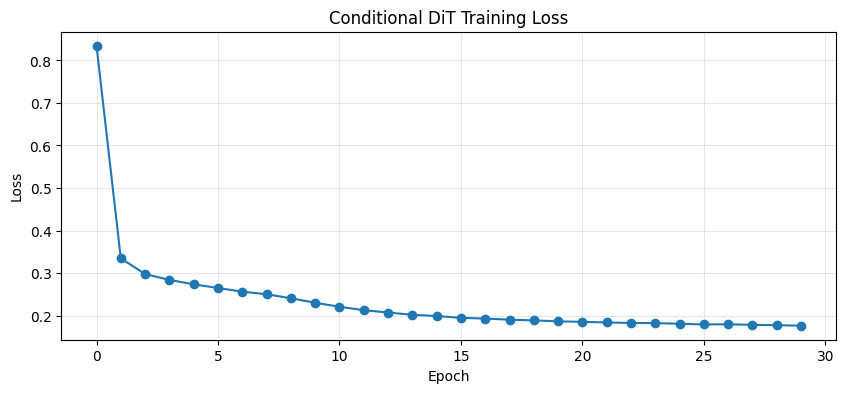


Final loss: 0.1762


In [9]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Conditional DiT Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal loss: {losses[-1]:.4f}")

## Step 7: Sampling with CFG

Now for the exciting part - generating specific digits with controllable guidance!

### CFG Sampling Algorithm

At each step of the ODE solver:

```
For each timestep t (from 1 to 0):
    v_cond = model(x_t, t, y)        # Conditional velocity
    v_uncond = model(x_t, t, null)   # Unconditional velocity
    
    # Apply CFG
    v_guided = v_uncond + w * (v_cond - v_uncond)
    
    # Euler step
    x_t = x_t - dt * v_guided
```

### Computational Cost

CFG requires **two forward passes** per sampling step:

| Method | Forward Passes per Step | Total for 50 Steps |
|--------|------------------------|-------------------|
| Unconditional | 1 | 50 |
| Conditional (no CFG) | 1 | 50 |
| Conditional + CFG | 2 | 100 |

The 2× cost is worth it for the quality improvement.

Generating 4 samples for each digit (0-9) with CFG scale=4.0...


Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  16%|███████████▎                                                           | 8/50 [00:00<00:00, 74.51it/s]

Sampling (CFG):  32%|██████████████████████▍                                               | 16/50 [00:00<00:00, 77.39it/s]

Sampling (CFG):  50%|███████████████████████████████████                                   | 25/50 [00:00<00:00, 79.63it/s]

Sampling (CFG):  68%|███████████████████████████████████████████████▌                      | 34/50 [00:00<00:00, 81.81it/s]

Sampling (CFG):  86%|████████████████████████████████████████████████████████████▏         | 43/50 [00:00<00:00, 83.60it/s]

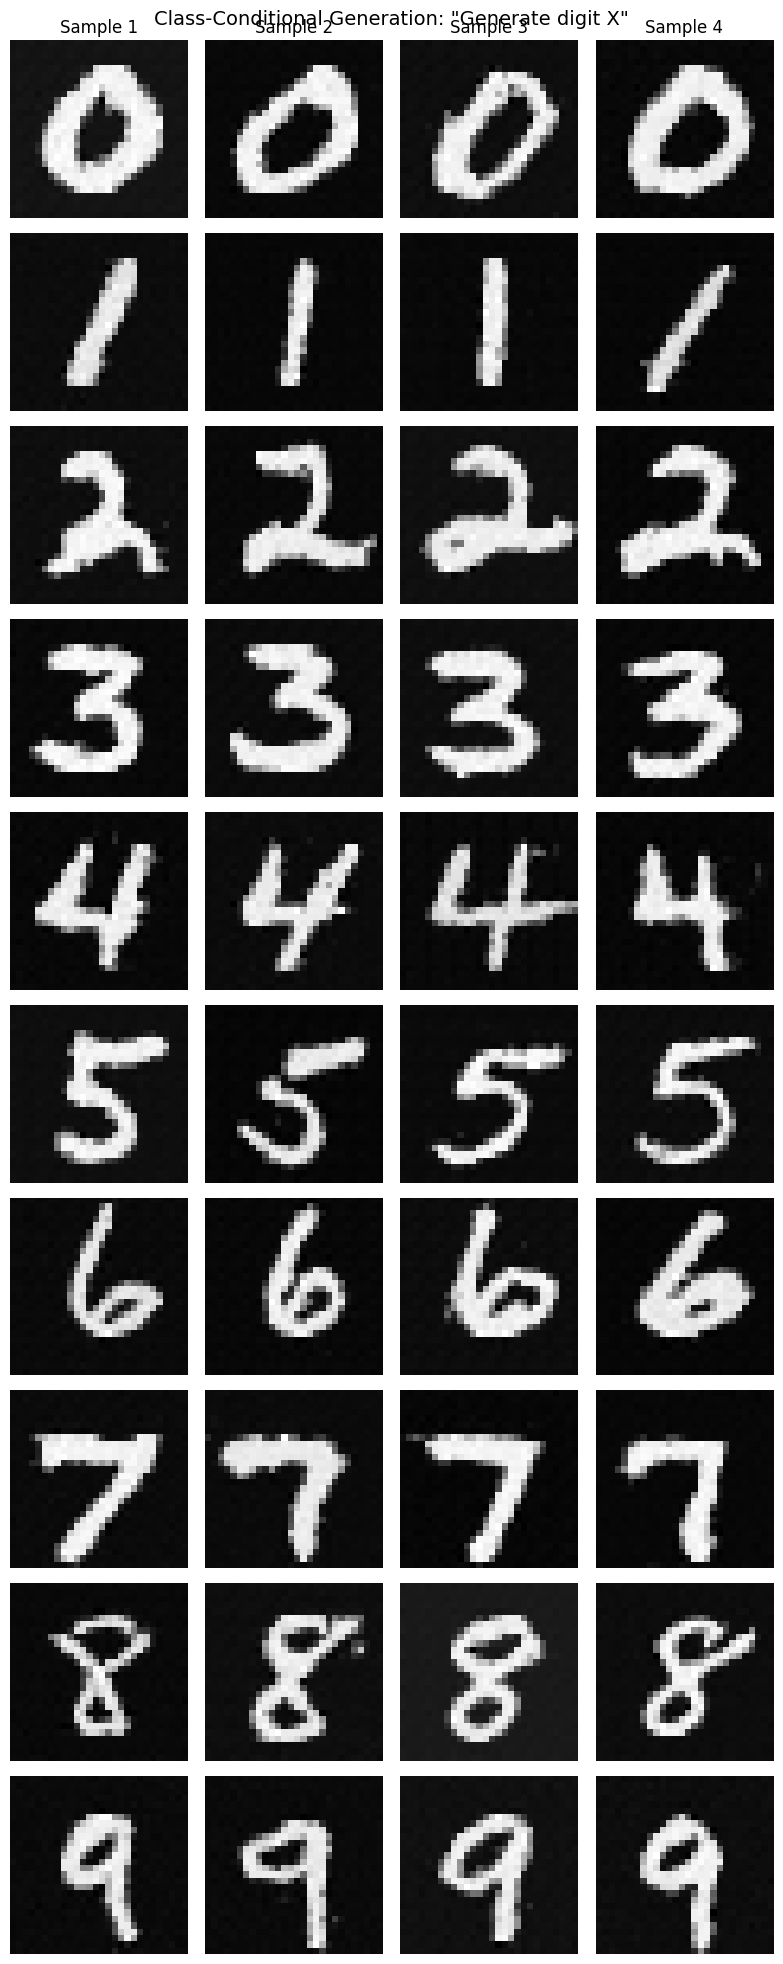

In [10]:
from from_noise_to_images.sampling import sample_conditional, sample_each_class

def show_images(images, nrow=8, title=""):
    """Display a grid of images."""
    images = (images + 1) / 2
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

# Generate samples for each class
model.eval()

print("Generating 4 samples for each digit (0-9) with CFG scale=4.0...")

samples = sample_each_class(
    model=model,
    num_per_class=4,
    image_shape=(1, 28, 28),
    num_steps=50,
    cfg_scale=4.0,
    device=device,
)

# Reshape for display: (40, 1, 28, 28) → (10, 4, 1, 28, 28)
samples_grid = samples.view(10, 4, 1, 28, 28)

# Create a nice display
fig, axes = plt.subplots(10, 4, figsize=(8, 20))

for digit in range(10):
    for i in range(4):
        img = (samples_grid[digit, i, 0] + 1) / 2
        axes[digit, i].imshow(img.cpu().numpy(), cmap='gray')
        axes[digit, i].axis('off')
        if i == 0:
            axes[digit, i].set_ylabel(f'{digit}', rotation=0, fontsize=14, labelpad=20)
        if digit == 0:
            axes[digit, i].set_title(f'Sample {i+1}')

plt.suptitle('Class-Conditional Generation: "Generate digit X"', fontsize=14)
plt.tight_layout()
plt.show()

## Step 8: Effect of Guidance Scale

The guidance scale $w$ controls the **trade-off between quality and diversity**:

### Mathematical Interpretation

$$v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})$$

- **Low $w$**: Samples closer to learned distribution → more diversity
- **High $w$**: Samples pushed toward class-specific regions → less diversity, higher fidelity

Let's visualize this trade-off:

Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  46%|███████████████████████████████▋                                     | 23/50 [00:00<00:00, 223.05it/s]

Sampling (CFG):  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [00:00<00:00, 233.46it/s]

Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  50%|██████████████████████████████████▌                                  | 25/50 [00:00<00:00, 242.27it/s]

Sampling (CFG): 100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 238.34it/s]

Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  48%|█████████████████████████████████                                    | 24/50 [00:00<00:00, 232.00it/s]

Sampling (CFG):  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [00:00<00:00, 231.83it/s]

Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  48%|█████████████████████████████████                                    | 24/50 [00:00<00:00, 231.18it/s]

Sampling (CFG):  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [00:00<00:00, 231.67it/s]

Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  48%|█████████████████████████████████                                    | 24/50 [00:00<00:00, 230.37it/s]

Sampling (CFG):  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [00:00<00:00, 231.27it/s]

Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  48%|█████████████████████████████████                                    | 24/50 [00:00<00:00, 232.15it/s]

Sampling (CFG):  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [00:00<00:00, 231.92it/s]

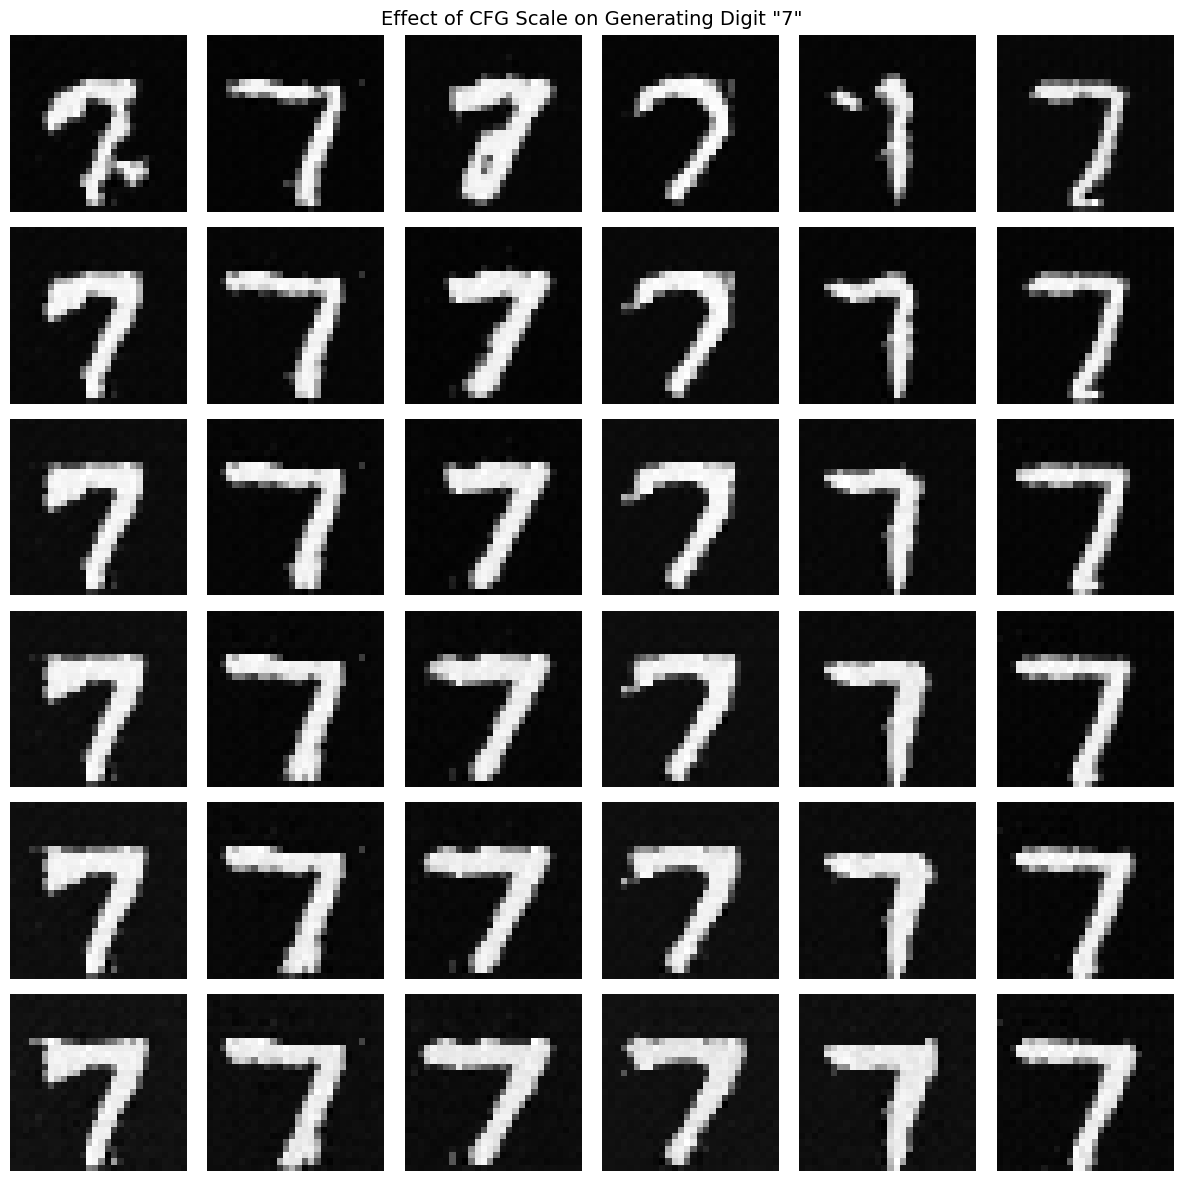


CFG Scale Analysis:
  • w=1.0: No guidance (pure conditional)
  • w=2-3: Light guidance, maintains diversity
  • w=4-5: Strong guidance, clear digit identity
  • w=7+: Very strong, may oversaturate


In [11]:
def compare_cfg_scales(model, target_digit=7, scales=[1.0, 2.0, 3.0, 4.0, 5.0, 7.0]):
    """
    Compare generation quality across different CFG scales.
    """
    num_samples = 6
    
    fig, axes = plt.subplots(len(scales), num_samples, figsize=(12, 2*len(scales)))
    
    for row, scale in enumerate(scales):
        # Use same seed for fair comparison
        torch.manual_seed(42)
        
        labels = torch.full((num_samples,), target_digit, dtype=torch.long)
        samples = sample_conditional(
            model=model,
            class_labels=labels,
            image_shape=(1, 28, 28),
            num_steps=50,
            cfg_scale=scale,
            device=device,
        )
        
        for col in range(num_samples):
            img = (samples[col, 0] + 1) / 2
            axes[row, col].imshow(img.cpu().numpy(), cmap='gray')
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_ylabel(f'w={scale}', fontsize=11)
    
    plt.suptitle(f'Effect of CFG Scale on Generating Digit "{target_digit}"', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nCFG Scale Analysis:")
    print("  • w=1.0: No guidance (pure conditional)")
    print("  • w=2-3: Light guidance, maintains diversity")
    print("  • w=4-5: Strong guidance, clear digit identity")
    print("  • w=7+: Very strong, may oversaturate")

compare_cfg_scales(model, target_digit=7)

Generating 8 samples for each digit with CFG scale=4.0...



Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  10%|███████                                                                | 5/50 [00:00<00:00, 48.49it/s]

Sampling (CFG):  20%|██████████████                                                        | 10/50 [00:00<00:00, 45.35it/s]

Sampling (CFG):  30%|█████████████████████                                                 | 15/50 [00:00<00:00, 45.04it/s]

Sampling (CFG):  40%|████████████████████████████                                          | 20/50 [00:00<00:00, 45.44it/s]

Sampling (CFG):  50%|███████████████████████████████████                                   | 25/50 [00:00<00:00, 45.99it/s]

Sampling (CFG):  60%|██████████████████████████████████████████                            | 30/50 [00:00<00:00, 46.53it/s]

Sampling (CFG):  70%|█████████████████████████████████████████████████                     | 35/50 [00:00<00:00, 47.14it/s]

Sampling (CFG):  80%|████████████████████████████████████████████████████████              | 40/50 [00:00<00:00, 47.65it/s]

Sampling (CFG):  90%|███████████████████████████████████████████████████████████████       | 45/50 [00:00<00:00, 48.15it/s]

Sampling (CFG): 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.56it/s]

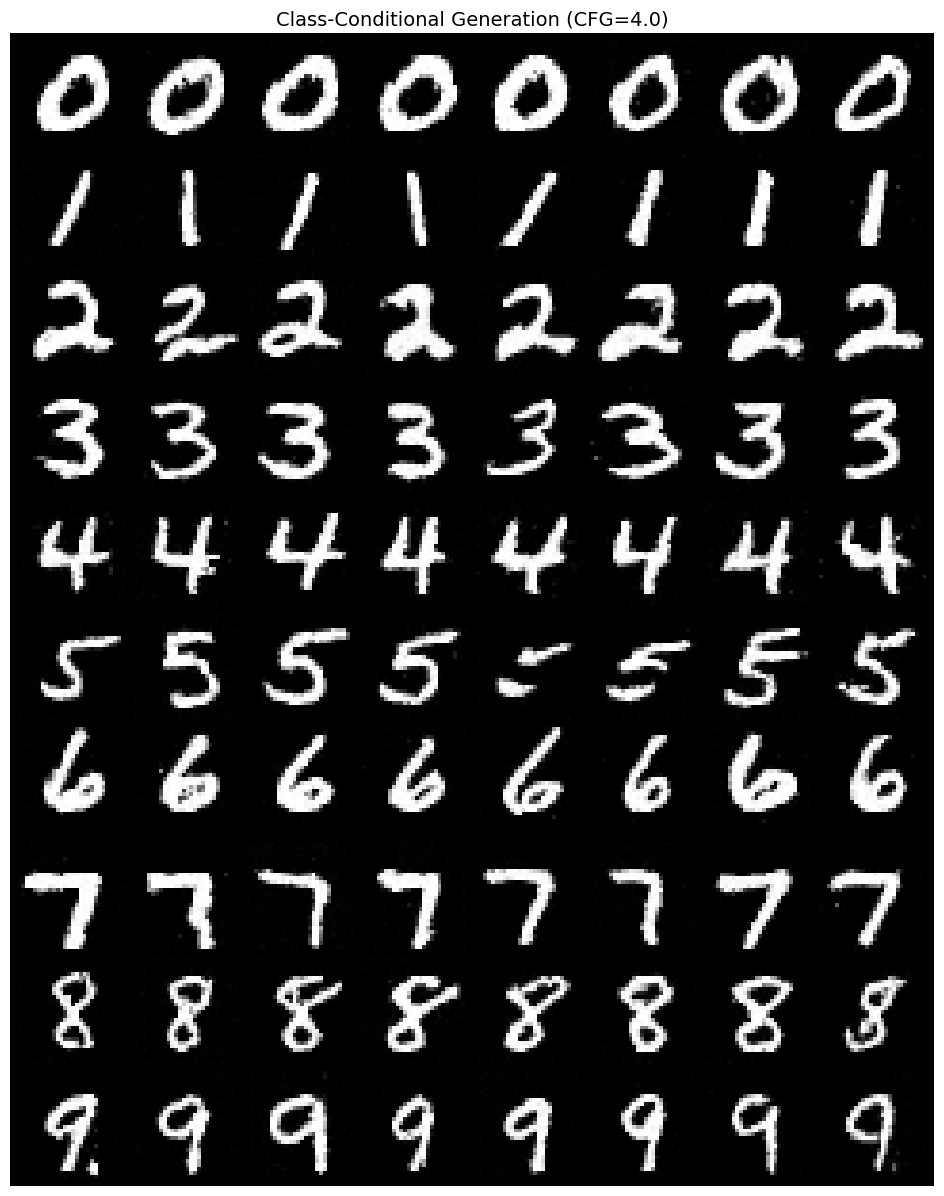

Each row is a different digit class (0-9)
Each column is a different sample from that class


In [12]:
# Compare generation for all digits at optimal CFG scale
print("Generating 8 samples for each digit with CFG scale=4.0...\n")

samples_all = sample_each_class(
    model=model,
    num_per_class=8,
    image_shape=(1, 28, 28),
    num_steps=50,
    cfg_scale=4.0,
    device=device,
)

# Show as 10 rows (one per digit), 8 columns (samples)
show_images(samples_all, nrow=8, title='Class-Conditional Generation (CFG=4.0)')

print("Each row is a different digit class (0-9)")
print("Each column is a different sample from that class")

## Step 9: Comparing Sampling Modes

Let's directly compare three sampling modes:

| Mode | Class Input | CFG Scale | What We're Sampling |
|------|-------------|-----------|--------------------|
| Unconditional | $\emptyset$ | N/A | $p(x)$ |
| Conditional (no CFG) | $y$ | $w=1$ | $p(x \mid y)$ |
| Conditional + CFG | $y$ | $w>1$ | "Sharpened" $p(x \mid y)$ |

Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  32%|██████████████████████                                               | 16/50 [00:00<00:00, 151.45it/s]

Sampling (CFG):  66%|█████████████████████████████████████████████▌                       | 33/50 [00:00<00:00, 158.13it/s]

Sampling (CFG): 100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.07it/s]

Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  36%|████████████████████████▊                                            | 18/50 [00:00<00:00, 175.90it/s]

Sampling (CFG):  72%|█████████████████████████████████████████████████▋                   | 36/50 [00:00<00:00, 173.72it/s]

Sampling (CFG):   0%|                                                                               | 0/50 [00:00<?, ?it/s]

Sampling (CFG):  36%|████████████████████████▊                                            | 18/50 [00:00<00:00, 173.66it/s]

Sampling (CFG):  72%|█████████████████████████████████████████████████▋                   | 36/50 [00:00<00:00, 171.83it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050307572..1.1140869].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054355264..1.1005306].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.072761714..1.1224711].


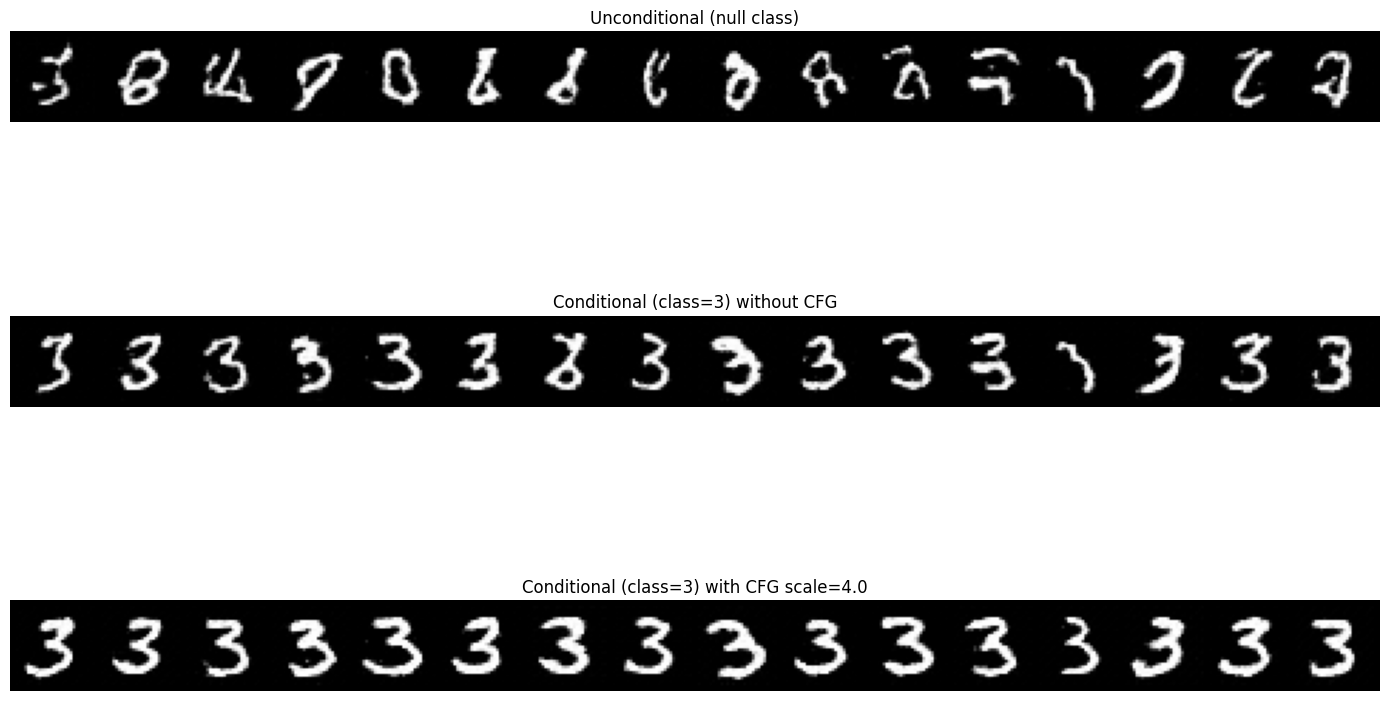


Comparison for generating '3':
  • Unconditional: Random digits (no control)
  • Conditional (no CFG): Tends toward 3 but may be weak
  • Conditional (CFG=4): Strong 3 identity


In [13]:
from from_noise_to_images.sampling import sample

torch.manual_seed(123)

target_class = 3  # Generate threes
num_samples = 16

# 1. Unconditional (no class)
null_labels = torch.full((num_samples,), 10, dtype=torch.long, device=device)  # 10 = null
uncond_samples = sample_conditional(
    model=model,
    class_labels=null_labels,
    image_shape=(1, 28, 28),
    cfg_scale=1.0,
    device=device,
)

# 2. Conditional without CFG
torch.manual_seed(123)
cond_nocfg_samples = sample_conditional(
    model=model,
    class_labels=[target_class] * num_samples,
    image_shape=(1, 28, 28),
    cfg_scale=1.0,
    device=device,
)

# 3. Conditional with CFG
torch.manual_seed(123)
cond_cfg_samples = sample_conditional(
    model=model,
    class_labels=[target_class] * num_samples,
    image_shape=(1, 28, 28),
    cfg_scale=4.0,
    device=device,
)

# Display comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for ax, samples, title in [
    (axes[0], uncond_samples, 'Unconditional (null class)'),
    (axes[1], cond_nocfg_samples, f'Conditional (class={target_class}) without CFG'),
    (axes[2], cond_cfg_samples, f'Conditional (class={target_class}) with CFG scale=4.0'),
]:
    grid = torchvision.utils.make_grid((samples + 1) / 2, nrow=16, padding=2)
    ax.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nComparison for generating '{target_class}':")
print("  • Unconditional: Random digits (no control)")
print(f"  • Conditional (no CFG): Tends toward {target_class} but may be weak")
print(f"  • Conditional (CFG=4): Strong {target_class} identity")

## Step 10: Analyzing Learned Embeddings

After training, the class embeddings should exhibit learned structure:

- **Semantic clustering**: Similar digits (3 and 8, 4 and 9) might be nearby
- **Null separation**: The null embedding should be distinct
- **Discriminability**: Different classes should be distinguishable

This structure emerges purely from the training objective - no explicit clustering loss.

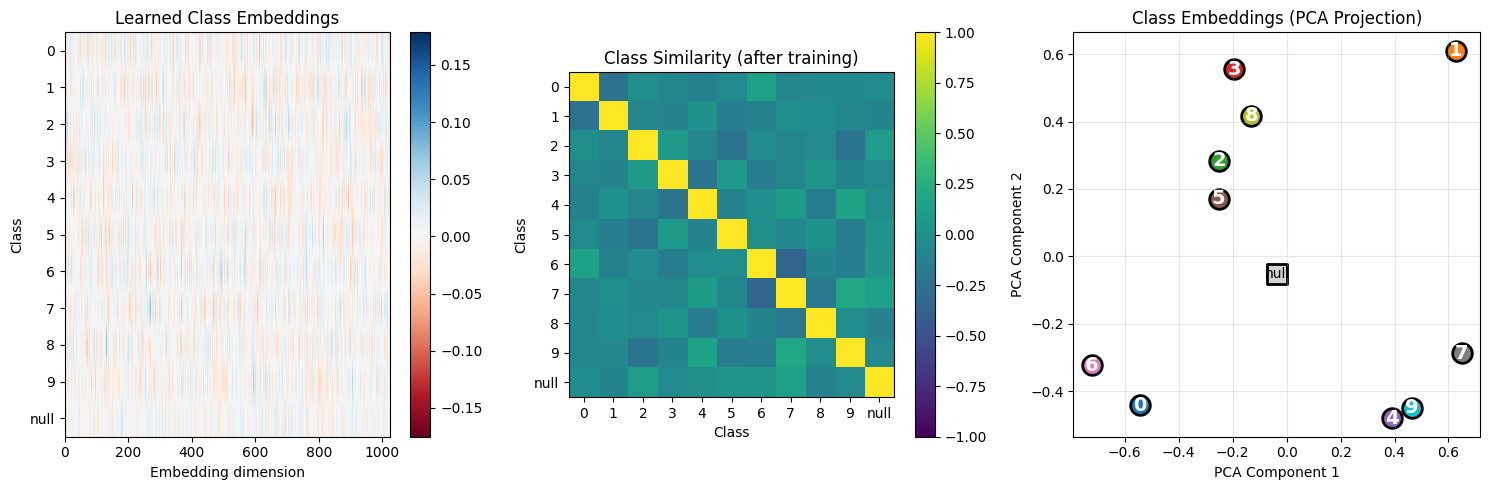


Learned Embedding Analysis:
  • Similarity matrix shows which digits the model considers 'similar'
  • PCA projection shows embedding space structure
  • Null class (gray square) should be somewhat central/neutral


In [14]:
# Extract learned class embeddings
with torch.no_grad():
    learned_embeddings = model.class_embed.embed.weight.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Embedding matrix
im = axes[0].imshow(learned_embeddings, aspect='auto', cmap='RdBu')
axes[0].set_xlabel('Embedding dimension')
axes[0].set_ylabel('Class')
axes[0].set_yticks(range(11))
axes[0].set_yticklabels([str(i) for i in range(10)] + ['null'])
axes[0].set_title('Learned Class Embeddings')
plt.colorbar(im, ax=axes[0])

# 2. Similarity matrix
similarity = np.corrcoef(learned_embeddings)
im = axes[1].imshow(similarity, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Class')
axes[1].set_xticks(range(11))
axes[1].set_xticklabels([str(i) for i in range(10)] + ['null'])
axes[1].set_yticks(range(11))
axes[1].set_yticklabels([str(i) for i in range(10)] + ['null'])
axes[1].set_title('Class Similarity (after training)')
plt.colorbar(im, ax=axes[1])

# 3. 2D PCA projection
def simple_pca(X, n_components=2):
    """Simple PCA using numpy SVD."""
    X_centered = X - X.mean(axis=0)
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    return X_centered @ Vt.T[:, :n_components]

embeddings_2d = simple_pca(learned_embeddings, n_components=2)

for i in range(10):
    axes[2].scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], s=200, 
                   c=[plt.cm.tab10(i)], edgecolors='black', linewidths=2)
    axes[2].annotate(str(i), (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=14, ha='center', va='center', color='white', fontweight='bold')

# Plot null class differently
axes[2].scatter(embeddings_2d[10, 0], embeddings_2d[10, 1], s=200,
               c='lightgray', edgecolors='black', linewidths=2, marker='s')
axes[2].annotate('null', (embeddings_2d[10, 0], embeddings_2d[10, 1]),
                fontsize=10, ha='center', va='center', color='black')

axes[2].set_xlabel('PCA Component 1')
axes[2].set_ylabel('PCA Component 2')
axes[2].set_title('Class Embeddings (PCA Projection)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLearned Embedding Analysis:")
print("  • Similarity matrix shows which digits the model considers 'similar'")
print("  • PCA projection shows embedding space structure")
print("  • Null class (gray square) should be somewhat central/neutral")

In [15]:
# Save the trained model
trainer.save_checkpoint("phase3_conditional_dit.pt")
print("Model saved to phase3_conditional_dit.pt")

Model saved to phase3_conditional_dit.pt


## Summary: The CFG Recipe

We extended the DiT with **class conditioning** and **Classifier-Free Guidance**.

### Key Equations

| Concept | Equation |
|---------|----------|
| Class embedding | $e(y) = W_e[y] \in \mathbb{R}^D$ |
| Combined conditioning | $c = \text{TimeEmbed}(t) + e(y)$ |
| Label dropout | $y_{\text{train}} = y$ w.p. 0.9, else $\emptyset$ |
| Training loss | $\mathcal{L} = \mathbb{E}[\|v_\theta(x_t, t, y_{\text{train}}) - v\|^2]$ |
| **CFG formula** | $\boxed{v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})}$ |

### CFG Derivation Summary

From Bayes' rule:
$$\nabla_x \log p(x \mid y) = \nabla_x \log p(x) + \nabla_x \log p(y \mid x)$$

The "classifier gradient" $\nabla_x \log p(y \mid x)$ is implicitly:
$$\nabla_x \log p(y \mid x) \propto v_{\text{cond}} - v_{\text{uncond}}$$

CFG amplifies this by factor $w$.

### Recommended Hyperparameters

| Parameter | Typical Value | Effect |
|-----------|--------------|--------|
| Label dropout $p_{\text{drop}}$ | 0.1 | Enables CFG |
| CFG scale $w$ | 3-5 | Quality/diversity trade-off |
| Embedding dim $D$ | 1024 | Same as conditioning dimension |

## What's Next

In the next notebook, we move from **class labels** to **text prompts**:

| This Notebook | Next Notebook |
|---------------|---------------|
| $y \in \{0, \ldots, 9\}$ | $y = \text{"a photo of a cat"}$ |
| Embedding table $W_e$ | CLIP text encoder |
| Addition to timestep | Cross-attention |

The mathematical principles remain the same - we're just using richer conditioning!